In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import sys  
sys.path.insert(0, '../../')
import trainer_helper
import normalization_helper

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [20]:
D001_df = pd.read_csv('../../../../../../valdo/OneDrive - Instituto Politécnico de Viana do Castelo/rnhealth/Data/SensorsData/interpolated_D001_data.csv')
D001_df = D001_df.iloc[913:]
D001_df = pd.DataFrame(D001_df)
D001_df['time'] =  pd.to_datetime(D001_df['time'], format='%Y-%m-%d %H:%M:%S')
D001_df.index = D001_df['time']
D001_df = D001_df.drop(['time'],axis = 1)
normalization_helper.datasetScaler

#Data scalling
normalized_D001_df,scaler = normalization_helper.datasetScaler(D001_df)

In [21]:
def DataHandler(hoursToPredict,windowSize):
    X1, y1 = trainer_helper.df_to_X_y(normalized_D001_df,hoursToPredict,windowSize)

    return X1, y1

In [5]:
plt.style.use('seaborn')

/var/folders/7j/3trkfvq127v4fw5vvdhpch6w0000gn/T/ipykernel_1251/240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [14]:
def Trainer(time,windowSize,finalWindowSize,trainEpochs):
    while(windowSize <= finalWindowSize):
        model = Sequential()
        model.add(InputLayer((windowSize, 5)))
        model.add(LSTM(64))
        model.add(Dense(8, 'relu'))
        model.add(Dense(1, 'linear'))

        model.summary()
        X, y = DataHandler(time,windowSize)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle = False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle= False) 

        X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

        cp1= ModelCheckpoint(
            str(time)+"H_Forecast/"+str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/", 
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )
        
        model.compile(
            loss=MeanSquaredError(), 
            optimizer=Adam(learning_rate=0.0001), 
            metrics=['mae', 'mse', 'mape']
        )

        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=trainEpochs, callbacks=[cp1])
        windowSize += 1
        print()
        print("-----------------------------------------------------------------------------------------------------------")
        print()

In [22]:
def modelsEvaluator(time,windowSize,finalWindowSize):
    while(windowSize <= finalWindowSize):
        model = load_model(f'{1}H_Forecast/{1}H_ForecastModel_{windowSize}_SizeWindow/')

        X, y = DataHandler(time,windowSize)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 
               
        print("Loading: "+ str(time)+"H_Forecast/" + str(time)+"H_ForecastModel_"+str(windowSize)+"_SizeWindow/")
        
        test_predictions = model.predict(X_test).flatten()
        inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

        inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)
        
        print(normalization_helper.mae(inversedTestPredictions,inversed_y_test))
              
        windowSize += 1

In [16]:
%%time

Trainer(1,6,12,100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                17920     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2023-02-10 07:03:38.223410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 07:03:38.328921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  5/161 [..............................] - ETA: 2s - loss: 0.8712 - mae: 0.7945 - mse: 0.8712 - mape: 122.1576  

2023-02-10 07:03:38.435927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9269 - mae: 0.6789 - mse: 0.9269 - mape: 131.0534

2023-02-10 07:03:40.578907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 07:03:40.624367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.34962, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 38ms/step - loss: 0.9269 - mae: 0.6789 - mse: 0.9269 - mape: 131.0534 - val_loss: 0.3496 - val_mae: 0.4527 - val_mse: 0.3496 - val_mape: 124.7653
Epoch 2/100
158/161 [============================>.] - ETA: 0s - loss: 0.5179 - mae: 0.4036 - mse: 0.5179 - mape: 184.5343
Epoch 2: val_loss improved from 0.34962 to 0.21683, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 35ms/step - loss: 0.5135 - mae: 0.4024 - mse: 0.5135 - mape: 188.8643 - val_loss: 0.2168 - val_mae: 0.3442 - val_mse: 0.2168 - val_mape: 157.4077
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.4164 - mae: 0.2920 - mse: 0.4164 - mape: 215.5022
Epoch 3: val_loss improved from 0.21683 to 0.17830, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 36ms/step - loss: 0.4164 - mae: 0.2920 - mse: 0.4164 - mape: 215.5022 - val_loss: 0.1783 - val_mae: 0.3016 - val_mse: 0.1783 - val_mape: 147.8519
Epoch 4/100
161/161 [==============================] - ETA: 0s - loss: 0.3881 - mae: 0.2679 - mse: 0.3881 - mape: 231.8878
Epoch 4: val_loss improved from 0.17830 to 0.16506, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 35ms/step - loss: 0.3881 - mae: 0.2679 - mse: 0.3881 - mape: 231.8878 - val_loss: 0.1651 - val_mae: 0.2863 - val_mse: 0.1651 - val_mape: 143.9542
Epoch 5/100
159/161 [============================>.] - ETA: 0s - loss: 0.3744 - mae: 0.2539 - mse: 0.3744 - mape: 227.9992
Epoch 5: val_loss improved from 0.16506 to 0.16099, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 32ms/step - loss: 0.3728 - mae: 0.2538 - mse: 0.3728 - mape: 226.9254 - val_loss: 0.1610 - val_mae: 0.2846 - val_mse: 0.1610 - val_mape: 137.2332
Epoch 6/100
160/161 [============================>.] - ETA: 0s - loss: 0.3603 - mae: 0.2489 - mse: 0.3603 - mape: 212.9655
Epoch 6: val_loss improved from 0.16099 to 0.15406, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 32ms/step - loss: 0.3600 - mae: 0.2488 - mse: 0.3600 - mape: 212.9894 - val_loss: 0.1541 - val_mae: 0.2760 - val_mse: 0.1541 - val_mape: 138.9451
Epoch 7/100
157/161 [============================>.] - ETA: 0s - loss: 0.3536 - mae: 0.2406 - mse: 0.3536 - mape: 210.9168
Epoch 7: val_loss did not improve from 0.15406
161/161 [==============================] - 2s 13ms/step - loss: 0.3491 - mae: 0.2408 - mse: 0.3491 - mape: 208.6719 - val_loss: 0.1574 - val_mae: 0.2799 - val_mse: 0.1574 - val_mape: 136.0543
Epoch 8/100
157/161 [============================>.] - ETA: 0s - loss: 0.3425 - mae: 0.2360 - mse: 0.3425 - mape: 200.0383
Epoch 8: val_loss improved from 0.15406 to 0.14391, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.3385 - mae: 0.2364 - mse: 0.3385 - mape: 197.2612 - val_loss: 0.1439 - val_mae: 0.2658 - val_mse: 0.1439 - val_mape: 135.3909
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3286 - mae: 0.2297 - mse: 0.3286 - mape: 193.5795
Epoch 9: val_loss improved from 0.14391 to 0.13855, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 33ms/step - loss: 0.3286 - mae: 0.2297 - mse: 0.3286 - mape: 193.5795 - val_loss: 0.1386 - val_mae: 0.2612 - val_mse: 0.1386 - val_mape: 132.6535
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3188 - mae: 0.2243 - mse: 0.3188 - mape: 187.1330
Epoch 10: val_loss improved from 0.13855 to 0.13216, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.3188 - mae: 0.2243 - mse: 0.3188 - mape: 187.1330 - val_loss: 0.1322 - val_mae: 0.2550 - val_mse: 0.1322 - val_mape: 127.7803
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.3087 - mae: 0.2175 - mse: 0.3087 - mape: 180.5652
Epoch 11: val_loss improved from 0.13216 to 0.12921, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 32ms/step - loss: 0.3087 - mae: 0.2175 - mse: 0.3087 - mape: 180.5652 - val_loss: 0.1292 - val_mae: 0.2492 - val_mse: 0.1292 - val_mape: 127.9919
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.2985 - mae: 0.2108 - mse: 0.2985 - mape: 175.7628
Epoch 12: val_loss improved from 0.12921 to 0.12687, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.2985 - mae: 0.2108 - mse: 0.2985 - mape: 175.7628 - val_loss: 0.1269 - val_mae: 0.2480 - val_mse: 0.1269 - val_mape: 120.5257
Epoch 13/100
159/161 [============================>.] - ETA: 0s - loss: 0.2910 - mae: 0.2049 - mse: 0.2910 - mape: 170.2837
Epoch 13: val_loss improved from 0.12687 to 0.11888, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 32ms/step - loss: 0.2896 - mae: 0.2051 - mse: 0.2896 - mape: 169.9485 - val_loss: 0.1189 - val_mae: 0.2390 - val_mse: 0.1189 - val_mape: 119.8165
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2801 - mae: 0.2019 - mse: 0.2801 - mape: 164.8779
Epoch 14: val_loss improved from 0.11888 to 0.11394, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.2801 - mae: 0.2019 - mse: 0.2801 - mape: 164.8779 - val_loss: 0.1139 - val_mae: 0.2311 - val_mse: 0.1139 - val_mape: 113.3395
Epoch 15/100
159/161 [============================>.] - ETA: 0s - loss: 0.2728 - mae: 0.1933 - mse: 0.2728 - mape: 150.9139
Epoch 15: val_loss improved from 0.11394 to 0.09839, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.2713 - mae: 0.1932 - mse: 0.2713 - mape: 150.5417 - val_loss: 0.0984 - val_mae: 0.2137 - val_mse: 0.0984 - val_mape: 112.0747
Epoch 16/100
158/161 [============================>.] - ETA: 0s - loss: 0.2655 - mae: 0.1892 - mse: 0.2655 - mape: 143.6213
Epoch 16: val_loss improved from 0.09839 to 0.09707, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 31ms/step - loss: 0.2630 - mae: 0.1890 - mse: 0.2630 - mape: 143.1568 - val_loss: 0.0971 - val_mae: 0.2115 - val_mse: 0.0971 - val_mape: 107.6607
Epoch 17/100
161/161 [==============================] - ETA: 0s - loss: 0.2540 - mae: 0.1828 - mse: 0.2540 - mape: 138.8194
Epoch 17: val_loss improved from 0.09707 to 0.09229, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 33ms/step - loss: 0.2540 - mae: 0.1828 - mse: 0.2540 - mape: 138.8194 - val_loss: 0.0923 - val_mae: 0.2052 - val_mse: 0.0923 - val_mape: 106.3723
Epoch 18/100
160/161 [============================>.] - ETA: 0s - loss: 0.2461 - mae: 0.1768 - mse: 0.2461 - mape: 134.4752
Epoch 18: val_loss improved from 0.09229 to 0.09039, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 36ms/step - loss: 0.2459 - mae: 0.1768 - mse: 0.2459 - mape: 134.4610 - val_loss: 0.0904 - val_mae: 0.2040 - val_mse: 0.0904 - val_mape: 100.4614
Epoch 19/100
161/161 [==============================] - ETA: 0s - loss: 0.2385 - mae: 0.1741 - mse: 0.2385 - mape: 130.1387
Epoch 19: val_loss improved from 0.09039 to 0.08400, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 34ms/step - loss: 0.2385 - mae: 0.1741 - mse: 0.2385 - mape: 130.1387 - val_loss: 0.0840 - val_mae: 0.1940 - val_mse: 0.0840 - val_mape: 99.4726
Epoch 20/100
161/161 [==============================] - ETA: 0s - loss: 0.2310 - mae: 0.1694 - mse: 0.2310 - mape: 124.5879
Epoch 20: val_loss improved from 0.08400 to 0.07663, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 32ms/step - loss: 0.2310 - mae: 0.1694 - mse: 0.2310 - mape: 124.5879 - val_loss: 0.0766 - val_mae: 0.1854 - val_mse: 0.0766 - val_mape: 96.6914
Epoch 21/100
161/161 [==============================] - ETA: 0s - loss: 0.2244 - mae: 0.1637 - mse: 0.2244 - mape: 117.9284
Epoch 21: val_loss improved from 0.07663 to 0.07410, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 36ms/step - loss: 0.2244 - mae: 0.1637 - mse: 0.2244 - mape: 117.9284 - val_loss: 0.0741 - val_mae: 0.1812 - val_mse: 0.0741 - val_mape: 95.8851
Epoch 22/100
160/161 [============================>.] - ETA: 0s - loss: 0.2188 - mae: 0.1600 - mse: 0.2188 - mape: 116.2667
Epoch 22: val_loss improved from 0.07410 to 0.07004, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 34ms/step - loss: 0.2186 - mae: 0.1599 - mse: 0.2186 - mape: 116.1827 - val_loss: 0.0700 - val_mae: 0.1776 - val_mse: 0.0700 - val_mape: 90.0829
Epoch 23/100
158/161 [============================>.] - ETA: 0s - loss: 0.2041 - mae: 0.1569 - mse: 0.2041 - mape: 116.2435
Epoch 23: val_loss improved from 0.07004 to 0.06840, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.2125 - mae: 0.1581 - mse: 0.2125 - mape: 115.7528 - val_loss: 0.0684 - val_mae: 0.1731 - val_mse: 0.0684 - val_mape: 90.2141
Epoch 24/100
160/161 [============================>.] - ETA: 0s - loss: 0.2073 - mae: 0.1552 - mse: 0.2073 - mape: 106.9390
Epoch 24: val_loss improved from 0.06840 to 0.06620, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.2072 - mae: 0.1551 - mse: 0.2072 - mape: 106.8650 - val_loss: 0.0662 - val_mae: 0.1698 - val_mse: 0.0662 - val_mape: 89.0228
Epoch 25/100
158/161 [============================>.] - ETA: 0s - loss: 0.2046 - mae: 0.1534 - mse: 0.2046 - mape: 112.2701
Epoch 25: val_loss improved from 0.06620 to 0.06591, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 34ms/step - loss: 0.2024 - mae: 0.1531 - mse: 0.2024 - mape: 111.3600 - val_loss: 0.0659 - val_mae: 0.1704 - val_mse: 0.0659 - val_mape: 85.2590
Epoch 26/100
160/161 [============================>.] - ETA: 0s - loss: 0.1996 - mae: 0.1512 - mse: 0.1996 - mape: 106.2995
Epoch 26: val_loss improved from 0.06591 to 0.06290, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.1995 - mae: 0.1512 - mse: 0.1995 - mape: 106.2654 - val_loss: 0.0629 - val_mae: 0.1679 - val_mse: 0.0629 - val_mape: 82.7778
Epoch 27/100
158/161 [============================>.] - ETA: 0s - loss: 0.1970 - mae: 0.1479 - mse: 0.1970 - mape: 106.7816
Epoch 27: val_loss improved from 0.06290 to 0.06134, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 5s 34ms/step - loss: 0.1960 - mae: 0.1484 - mse: 0.1960 - mape: 106.4889 - val_loss: 0.0613 - val_mae: 0.1639 - val_mse: 0.0613 - val_mape: 80.5681
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.1913 - mae: 0.1477 - mse: 0.1913 - mape: 103.2457
Epoch 28: val_loss improved from 0.06134 to 0.05990, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.1913 - mae: 0.1477 - mse: 0.1913 - mape: 103.2457 - val_loss: 0.0599 - val_mae: 0.1625 - val_mse: 0.0599 - val_mape: 82.2359
Epoch 29/100
159/161 [============================>.] - ETA: 0s - loss: 0.1893 - mae: 0.1468 - mse: 0.1893 - mape: 100.8810
Epoch 29: val_loss did not improve from 0.05990
161/161 [==============================] - 2s 14ms/step - loss: 0.1882 - mae: 0.1465 - mse: 0.1882 - mape: 100.4326 - val_loss: 0.0606 - val_mae: 0.1631 - val_mse: 0.0606 - val_mape: 79.7566
Epoch 30/100
158/161 [============================>.] - ETA: 0s - loss: 0.1881 - mae: 0.1463 - mse: 0.1881 - mape: 113.1103
Epoch 30: val_loss did not improve from 0.05990
161/161 [==============================] - 2s 14ms/step - loss: 0.1859 - mae: 0.1458 - mse: 0.1859 - mape: 112.2955 - val_loss: 0.0602 - val_mae: 0.1632 - val_mse: 0.0602 - val_mape: 76.6646
Epoch 31/100
159/161 [============================>.] - ETA: 12s - loss: 0.1845 - m

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 1000s 6s/step - loss: 0.1834 - mae: 0.1433 - mse: 0.1834 - mape: 105.8194 - val_loss: 0.0597 - val_mae: 0.1634 - val_mse: 0.0597 - val_mape: 76.2350
Epoch 32/100
161/161 [==============================] - ETA: 0s - loss: 0.1812 - mae: 0.1435 - mse: 0.1812 - mape: 107.7993 
Epoch 32: val_loss improved from 0.05967 to 0.05916, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 1061s 7s/step - loss: 0.1812 - mae: 0.1435 - mse: 0.1812 - mape: 107.7993 - val_loss: 0.0592 - val_mae: 0.1616 - val_mse: 0.0592 - val_mape: 74.2282
Epoch 33/100
158/161 [============================>.] - ETA: 0s - loss: 0.1813 - mae: 0.1426 - mse: 0.1813 - mape: 99.1276
Epoch 33: val_loss improved from 0.05916 to 0.05812, saving model to 1H_Forecast/1H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 1013s 6s/step - loss: 0.1792 - mae: 0.1421 - mse: 0.1792 - mape: 98.5765 - val_loss: 0.0581 - val_mae: 0.1613 - val_mse: 0.0581 - val_mape: 70.9696
Epoch 34/100
161/161 [==============================] - ETA: 0s - loss: 0.1769 - mae: 0.1418 - mse: 0.1769 - mape: 106.5277
Epoch 34: val_loss did not improve from 0.05812
161/161 [==============================] - 2s 14ms/step - loss: 0.1769 - mae: 0.1418 - mse: 0.1769 - mape: 106.5277 - val_loss: 0.0598 - val_mae: 0.1620 - val_mse: 0.0598 - val_mape: 73.9613
Epoch 35/100
160/161 [============================>.] - ETA: 6s - loss: 0.1738 - mae: 0.1413 - mse: 0.1738 - mape: 103.3354 
Epoch 35: val_loss did not improve from 0.05812
161/161 [==============================] - 1007s 6s/step - loss: 0.1737 - mae: 0.1414 - mse: 0.1737 - mape: 103.3567 - val_loss: 0.0596 - val_mae: 0.1630 - val_mse: 0.0596 - val_mape: 71.6028
Epoch 36/100
159/161 [============================>.] - ETA: 0s - loss: 0.1737 - 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.1650 - mae: 0.1367 - mse: 0.1650 - mape: 108.4436 - val_loss: 0.0577 - val_mae: 0.1608 - val_mse: 0.0577 - val_mape: 65.5747
Epoch 42/100
157/161 [============================>.] - ETA: 0s - loss: 0.1674 - mae: 0.1403 - mse: 0.1674 - mape: 110.1587
Epoch 42: val_loss did not improve from 0.05775
161/161 [==============================] - 2s 14ms/step - loss: 0.1646 - mae: 0.1399 - mse: 0.1646 - mape: 108.5986 - val_loss: 0.0596 - val_mae: 0.1642 - val_mse: 0.0596 - val_mape: 69.4164
Epoch 43/100
159/161 [============================>.] - ETA: 0s - loss: 0.1630 - mae: 0.1371 - mse: 0.1630 - mape: 105.7527
Epoch 43: val_loss did not improve from 0.05775
161/161 [==============================] - 2s 14ms/step - loss: 0.1622 - mae: 0.1372 - mse: 0.1622 - mape: 105.7882 - val_loss: 0.0605 - val_mae: 0.1656 - val_mse: 0.0605 - val_mape: 70.3069
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.1609 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.1422 - mae: 0.1284 - mse: 0.1422 - mape: 111.1281 - val_loss: 0.0574 - val_mae: 0.1609 - val_mse: 0.0574 - val_mape: 70.9510
Epoch 73/100
159/161 [============================>.] - ETA: 0s - loss: 0.1425 - mae: 0.1326 - mse: 0.1425 - mape: 119.7610
Epoch 73: val_loss did not improve from 0.05736
161/161 [==============================] - 2s 14ms/step - loss: 0.1417 - mae: 0.1324 - mse: 0.1417 - mape: 119.1231 - val_loss: 0.0592 - val_mae: 0.1629 - val_mse: 0.0592 - val_mape: 66.9257
Epoch 74/100
157/161 [============================>.] - ETA: 0s - loss: 0.1439 - mae: 0.1307 - mse: 0.1439 - mape: 69.6617
Epoch 74: val_loss did not improve from 0.05736
161/161 [==============================] - 2s 14ms/step - loss: 0.1415 - mae: 0.1301 - mse: 0.1415 - mape: 112.5827 - val_loss: 0.0584 - val_mae: 0.1618 - val_mse: 0.0584 - val_mape: 69.9517
Epoch 75/100
157/161 [============================>.] - ETA: 0s - loss: 0.1199 - mae

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.1277 - mae: 0.1285 - mse: 0.1277 - mape: 117.9825 - val_loss: 0.0573 - val_mae: 0.1589 - val_mse: 0.0573 - val_mape: 65.0009
Epoch 99/100
159/161 [============================>.] - ETA: 0s - loss: 0.1271 - mae: 0.1287 - mse: 0.1271 - mape: 117.6200
Epoch 99: val_loss did not improve from 0.05734
161/161 [==============================] - 2s 14ms/step - loss: 0.1265 - mae: 0.1287 - mse: 0.1265 - mape: 117.0660 - val_loss: 0.0588 - val_mae: 0.1609 - val_mse: 0.0588 - val_mape: 64.3831
Epoch 100/100
160/161 [============================>.] - ETA: 0s - loss: 0.1261 - mae: 0.1286 - mse: 0.1261 - mape: 115.8640
Epoch 100: val_loss did not improve from 0.05734
161/161 [==============================] - 2s 14ms/step - loss: 0.1261 - mae: 0.1286 - mse: 0.1261 - mape: 115.8107 - val_loss: 0.0584 - val_mae: 0.1603 - val_mse: 0.0584 - val_mape: 63.5710

--------------------------------------------------------------------------------

2023-02-10 08:26:41.018803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:26:41.115597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  4/161 [..............................] - ETA: 2s - loss: 0.8907 - mae: 0.7790 - mse: 0.8907 - mape: 105.9083  

2023-02-10 08:26:41.232655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9574 - mae: 0.6639 - mse: 0.9574 - mape: 119.3612

2023-02-10 08:26:43.551026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:26:43.599439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.90563, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 41ms/step - loss: 0.9574 - mae: 0.6639 - mse: 0.9574 - mape: 119.3612 - val_loss: 0.9056 - val_mae: 0.7376 - val_mse: 0.9056 - val_mape: 103.4506
Epoch 2/100
159/161 [============================>.] - ETA: 0s - loss: 0.7579 - mae: 0.4999 - mse: 0.7579 - mape: 168.2806
Epoch 2: val_loss improved from 0.90563 to 0.71493, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.7575 - mae: 0.5001 - mse: 0.7575 - mape: 167.7023 - val_loss: 0.7149 - val_mae: 0.6255 - val_mse: 0.7149 - val_mape: 115.3794
Epoch 3/100
159/161 [============================>.] - ETA: 0s - loss: 0.6135 - mae: 0.3950 - mse: 0.6135 - mape: 234.3027
Epoch 3: val_loss improved from 0.71493 to 0.47626, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 36ms/step - loss: 0.6107 - mae: 0.3944 - mse: 0.6107 - mape: 233.1410 - val_loss: 0.4763 - val_mae: 0.4844 - val_mse: 0.4763 - val_mape: 139.1076
Epoch 4/100
160/161 [============================>.] - ETA: 0s - loss: 0.5061 - mae: 0.3267 - mse: 0.5061 - mape: 274.3889
Epoch 4: val_loss improved from 0.47626 to 0.32403, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.5059 - mae: 0.3267 - mse: 0.5059 - mape: 274.1942 - val_loss: 0.3240 - val_mae: 0.3897 - val_mse: 0.3240 - val_mape: 141.1334
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.4689 - mae: 0.3027 - mse: 0.4689 - mape: 275.3866
Epoch 5: val_loss improved from 0.32403 to 0.27144, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 36ms/step - loss: 0.4687 - mae: 0.3027 - mse: 0.4687 - mape: 275.2722 - val_loss: 0.2714 - val_mae: 0.3572 - val_mse: 0.2714 - val_mape: 141.2410
Epoch 6/100
160/161 [============================>.] - ETA: 0s - loss: 0.4484 - mae: 0.2836 - mse: 0.4484 - mape: 262.9473
Epoch 6: val_loss improved from 0.27144 to 0.25334, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.4481 - mae: 0.2835 - mse: 0.4481 - mape: 262.7543 - val_loss: 0.2533 - val_mae: 0.3502 - val_mse: 0.2533 - val_mape: 135.2940
Epoch 7/100
157/161 [============================>.] - ETA: 0s - loss: 0.4354 - mae: 0.2723 - mse: 0.4354 - mape: 245.9628
Epoch 7: val_loss improved from 0.25334 to 0.23137, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 35ms/step - loss: 0.4282 - mae: 0.2708 - mse: 0.4282 - mape: 242.8385 - val_loss: 0.2314 - val_mae: 0.3367 - val_mse: 0.2314 - val_mape: 134.5211
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.4073 - mae: 0.2532 - mse: 0.4073 - mape: 230.1852
Epoch 8: val_loss improved from 0.23137 to 0.20524, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.4073 - mae: 0.2532 - mse: 0.4073 - mape: 230.1852 - val_loss: 0.2052 - val_mae: 0.3160 - val_mse: 0.2052 - val_mape: 130.8814
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3910 - mae: 0.2384 - mse: 0.3910 - mape: 220.6599
Epoch 9: val_loss improved from 0.20524 to 0.18939, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 35ms/step - loss: 0.3910 - mae: 0.2384 - mse: 0.3910 - mape: 220.6599 - val_loss: 0.1894 - val_mae: 0.3066 - val_mse: 0.1894 - val_mape: 122.4919
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3754 - mae: 0.2265 - mse: 0.3754 - mape: 199.9949
Epoch 10: val_loss improved from 0.18939 to 0.17442, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.3754 - mae: 0.2265 - mse: 0.3754 - mape: 199.9949 - val_loss: 0.1744 - val_mae: 0.2947 - val_mse: 0.1744 - val_mape: 119.2869
Epoch 11/100
160/161 [============================>.] - ETA: 0s - loss: 0.3617 - mae: 0.2146 - mse: 0.3617 - mape: 186.5446
Epoch 11: val_loss improved from 0.17442 to 0.15281, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.3614 - mae: 0.2146 - mse: 0.3614 - mape: 186.4838 - val_loss: 0.1528 - val_mae: 0.2759 - val_mse: 0.1528 - val_mape: 110.4661
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.3490 - mae: 0.2047 - mse: 0.3490 - mape: 169.3419
Epoch 12: val_loss improved from 0.15281 to 0.13364, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.3490 - mae: 0.2047 - mse: 0.3490 - mape: 169.3419 - val_loss: 0.1336 - val_mae: 0.2557 - val_mse: 0.1336 - val_mape: 108.4324
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.3389 - mae: 0.1955 - mse: 0.3389 - mape: 151.0968
Epoch 13: val_loss improved from 0.13364 to 0.12900, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.3389 - mae: 0.1955 - mse: 0.3389 - mape: 151.0968 - val_loss: 0.1290 - val_mae: 0.2521 - val_mse: 0.1290 - val_mape: 104.4827
Epoch 14/100
159/161 [============================>.] - ETA: 0s - loss: 0.3324 - mae: 0.1902 - mse: 0.3324 - mape: 139.7600
Epoch 14: val_loss improved from 0.12900 to 0.11957, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3306 - mae: 0.1903 - mse: 0.3306 - mape: 139.4682 - val_loss: 0.1196 - val_mae: 0.2416 - val_mse: 0.1196 - val_mape: 100.3383
Epoch 15/100
159/161 [============================>.] - ETA: 0s - loss: 0.3248 - mae: 0.1861 - mse: 0.3248 - mape: 123.4422
Epoch 15: val_loss improved from 0.11957 to 0.10142, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.3233 - mae: 0.1860 - mse: 0.3233 - mape: 122.8658 - val_loss: 0.1014 - val_mae: 0.2196 - val_mse: 0.1014 - val_mape: 97.1668
Epoch 16/100
161/161 [==============================] - ETA: 0s - loss: 0.3175 - mae: 0.1836 - mse: 0.3175 - mape: 119.3580
Epoch 16: val_loss improved from 0.10142 to 0.09623, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3175 - mae: 0.1836 - mse: 0.3175 - mape: 119.3580 - val_loss: 0.0962 - val_mae: 0.2134 - val_mse: 0.0962 - val_mape: 91.3605
Epoch 17/100
161/161 [==============================] - ETA: 0s - loss: 0.3114 - mae: 0.1802 - mse: 0.3114 - mape: 109.3984
Epoch 17: val_loss improved from 0.09623 to 0.09532, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.3114 - mae: 0.1802 - mse: 0.3114 - mape: 109.3984 - val_loss: 0.0953 - val_mae: 0.2108 - val_mse: 0.0953 - val_mape: 90.2961
Epoch 18/100
161/161 [==============================] - ETA: 0s - loss: 0.3063 - mae: 0.1767 - mse: 0.3063 - mape: 100.2647
Epoch 18: val_loss improved from 0.09532 to 0.09057, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.3063 - mae: 0.1767 - mse: 0.3063 - mape: 100.2647 - val_loss: 0.0906 - val_mae: 0.2050 - val_mse: 0.0906 - val_mape: 86.5384
Epoch 19/100
159/161 [============================>.] - ETA: 0s - loss: 0.3027 - mae: 0.1752 - mse: 0.3027 - mape: 98.5019
Epoch 19: val_loss improved from 0.09057 to 0.07835, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.3011 - mae: 0.1752 - mse: 0.3011 - mape: 98.0519 - val_loss: 0.0784 - val_mae: 0.1910 - val_mse: 0.0784 - val_mape: 83.3760
Epoch 20/100
160/161 [============================>.] - ETA: 0s - loss: 0.2956 - mae: 0.1735 - mse: 0.2956 - mape: 96.1259
Epoch 20: val_loss did not improve from 0.07835
161/161 [==============================] - 2s 15ms/step - loss: 0.2954 - mae: 0.1735 - mse: 0.2954 - mape: 96.0881 - val_loss: 0.0845 - val_mae: 0.1968 - val_mse: 0.0845 - val_mape: 80.0696
Epoch 21/100
158/161 [============================>.] - ETA: 0s - loss: 0.2935 - mae: 0.1729 - mse: 0.2935 - mape: 95.8525
Epoch 21: val_loss did not improve from 0.07835
161/161 [==============================] - 3s 16ms/step - loss: 0.2901 - mae: 0.1724 - mse: 0.2901 - mape: 95.6321 - val_loss: 0.0795 - val_mae: 0.1896 - val_mse: 0.0795 - val_mape: 78.9044
Epoch 22/100
159/161 [============================>.] - ETA: 0s - loss: 0.2871 - mae: 0.

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.2805 - mae: 0.1659 - mse: 0.2805 - mape: 92.4559 - val_loss: 0.0762 - val_mae: 0.1856 - val_mse: 0.0762 - val_mape: 73.4380
Epoch 24/100
158/161 [============================>.] - ETA: 0s - loss: 0.2541 - mae: 0.1630 - mse: 0.2541 - mape: 87.1274
Epoch 24: val_loss improved from 0.07619 to 0.07118, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.2754 - mae: 0.1651 - mse: 0.2754 - mape: 86.5191 - val_loss: 0.0712 - val_mae: 0.1796 - val_mse: 0.0712 - val_mape: 73.7223
Epoch 25/100
161/161 [==============================] - ETA: 0s - loss: 0.2707 - mae: 0.1617 - mse: 0.2707 - mape: 81.8666
Epoch 25: val_loss improved from 0.07118 to 0.06925, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.2707 - mae: 0.1617 - mse: 0.2707 - mape: 81.8666 - val_loss: 0.0692 - val_mae: 0.1760 - val_mse: 0.0692 - val_mape: 71.3697
Epoch 26/100
159/161 [============================>.] - ETA: 0s - loss: 0.2678 - mae: 0.1600 - mse: 0.2678 - mape: 92.6509
Epoch 26: val_loss improved from 0.06925 to 0.06767, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.2662 - mae: 0.1599 - mse: 0.2662 - mape: 92.3659 - val_loss: 0.0677 - val_mae: 0.1729 - val_mse: 0.0677 - val_mape: 71.9459
Epoch 27/100
157/161 [============================>.] - ETA: 0s - loss: 0.2662 - mae: 0.1577 - mse: 0.2662 - mape: 89.4668
Epoch 27: val_loss improved from 0.06767 to 0.06498, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 5s 34ms/step - loss: 0.2617 - mae: 0.1571 - mse: 0.2617 - mape: 90.0595 - val_loss: 0.0650 - val_mae: 0.1692 - val_mse: 0.0650 - val_mape: 67.9723
Epoch 28/100
160/161 [============================>.] - ETA: 0s - loss: 0.2569 - mae: 0.1549 - mse: 0.2569 - mape: 87.9398
Epoch 28: val_loss improved from 0.06498 to 0.06456, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.2568 - mae: 0.1549 - mse: 0.2568 - mape: 87.9177 - val_loss: 0.0646 - val_mae: 0.1689 - val_mse: 0.0646 - val_mape: 66.6579
Epoch 29/100
159/161 [============================>.] - ETA: 0s - loss: 0.2538 - mae: 0.1539 - mse: 0.2538 - mape: 86.1733
Epoch 29: val_loss improved from 0.06456 to 0.06372, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 5s 32ms/step - loss: 0.2523 - mae: 0.1537 - mse: 0.2523 - mape: 85.8396 - val_loss: 0.0637 - val_mae: 0.1673 - val_mse: 0.0637 - val_mape: 65.3316
Epoch 30/100
161/161 [==============================] - ETA: 0s - loss: 0.2479 - mae: 0.1516 - mse: 0.2479 - mape: 80.5278
Epoch 30: val_loss improved from 0.06372 to 0.06177, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.2479 - mae: 0.1516 - mse: 0.2479 - mape: 80.5278 - val_loss: 0.0618 - val_mae: 0.1640 - val_mse: 0.0618 - val_mape: 64.7502
Epoch 31/100
158/161 [============================>.] - ETA: 0s - loss: 0.2465 - mae: 0.1495 - mse: 0.2465 - mape: 87.5745
Epoch 31: val_loss improved from 0.06177 to 0.06047, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 5s 33ms/step - loss: 0.2442 - mae: 0.1497 - mse: 0.2442 - mape: 87.3825 - val_loss: 0.0605 - val_mae: 0.1615 - val_mse: 0.0605 - val_mape: 64.9367
Epoch 32/100
160/161 [============================>.] - ETA: 0s - loss: 0.2402 - mae: 0.1489 - mse: 0.2402 - mape: 92.9984
Epoch 32: val_loss did not improve from 0.06047
161/161 [==============================] - 2s 13ms/step - loss: 0.2400 - mae: 0.1489 - mse: 0.2400 - mape: 92.9418 - val_loss: 0.0623 - val_mae: 0.1638 - val_mse: 0.0623 - val_mape: 60.2135
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.2365 - mae: 0.1482 - mse: 0.2365 - mape: 92.7024
Epoch 33: val_loss improved from 0.06047 to 0.05939, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.2365 - mae: 0.1482 - mse: 0.2365 - mape: 92.7024 - val_loss: 0.0594 - val_mae: 0.1591 - val_mse: 0.0594 - val_mape: 60.0905
Epoch 34/100
157/161 [============================>.] - ETA: 0s - loss: 0.2361 - mae: 0.1456 - mse: 0.2361 - mape: 92.2531
Epoch 34: val_loss improved from 0.05939 to 0.05907, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 5s 34ms/step - loss: 0.2324 - mae: 0.1455 - mse: 0.2324 - mape: 91.7656 - val_loss: 0.0591 - val_mae: 0.1587 - val_mse: 0.0591 - val_mape: 58.0351
Epoch 35/100
158/161 [============================>.] - ETA: 0s - loss: 0.2115 - mae: 0.1432 - mse: 0.2115 - mape: 94.5647
Epoch 35: val_loss improved from 0.05907 to 0.05616, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.2291 - mae: 0.1447 - mse: 0.2291 - mape: 93.9956 - val_loss: 0.0562 - val_mae: 0.1551 - val_mse: 0.0562 - val_mape: 61.3411
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.2249 - mae: 0.1430 - mse: 0.2249 - mape: 92.9133
Epoch 36: val_loss did not improve from 0.05616
161/161 [==============================] - 2s 15ms/step - loss: 0.2249 - mae: 0.1430 - mse: 0.2249 - mape: 92.9133 - val_loss: 0.0574 - val_mae: 0.1555 - val_mse: 0.0574 - val_mape: 57.6001
Epoch 37/100
159/161 [============================>.] - ETA: 0s - loss: 0.2235 - mae: 0.1440 - mse: 0.2235 - mape: 96.5471
Epoch 37: val_loss did not improve from 0.05616
161/161 [==============================] - 2s 15ms/step - loss: 0.2221 - mae: 0.1437 - mse: 0.2221 - mape: 96.0400 - val_loss: 0.0612 - val_mae: 0.1611 - val_mse: 0.0612 - val_mape: 56.5289
Epoch 38/100
161/161 [==============================] - ETA: 0s - loss: 0.2180 - mae: 0.

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.2097 - mae: 0.1386 - mse: 0.2097 - mape: 99.4343 - val_loss: 0.0553 - val_mae: 0.1524 - val_mse: 0.0553 - val_mape: 60.1185
Epoch 42/100
160/161 [============================>.] - ETA: 0s - loss: 0.2074 - mae: 0.1388 - mse: 0.2074 - mape: 103.1844
Epoch 42: val_loss improved from 0.05530 to 0.05528, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.2073 - mae: 0.1389 - mse: 0.2073 - mape: 103.1773 - val_loss: 0.0553 - val_mae: 0.1518 - val_mse: 0.0553 - val_mape: 59.6595
Epoch 43/100
157/161 [============================>.] - ETA: 0s - loss: 0.2072 - mae: 0.1373 - mse: 0.2072 - mape: 99.7673 
Epoch 43: val_loss improved from 0.05528 to 0.05388, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 36ms/step - loss: 0.2042 - mae: 0.1370 - mse: 0.2042 - mape: 99.2104 - val_loss: 0.0539 - val_mae: 0.1493 - val_mse: 0.0539 - val_mape: 60.9202
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.2021 - mae: 0.1374 - mse: 0.2021 - mape: 102.3077
Epoch 44: val_loss did not improve from 0.05388
161/161 [==============================] - 2s 14ms/step - loss: 0.2020 - mae: 0.1374 - mse: 0.2020 - mape: 102.2547 - val_loss: 0.0602 - val_mae: 0.1586 - val_mse: 0.0602 - val_mape: 54.9792
Epoch 45/100
158/161 [============================>.] - ETA: 0s - loss: 0.2025 - mae: 0.1376 - mse: 0.2025 - mape: 102.6946
Epoch 45: val_loss did not improve from 0.05388
161/161 [==============================] - 3s 16ms/step - loss: 0.2001 - mae: 0.1371 - mse: 0.2001 - mape: 101.6965 - val_loss: 0.0540 - val_mae: 0.1489 - val_mse: 0.0540 - val_mape: 60.0038
Epoch 46/100
160/161 [============================>.] - ETA: 0s - loss: 0.1981 - mae

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.1952 - mae: 0.1345 - mse: 0.1952 - mape: 104.9731 - val_loss: 0.0529 - val_mae: 0.1477 - val_mse: 0.0529 - val_mape: 62.4573
Epoch 48/100
160/161 [============================>.] - ETA: 0s - loss: 0.1937 - mae: 0.1371 - mse: 0.1937 - mape: 111.2016
Epoch 48: val_loss improved from 0.05290 to 0.05233, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.1936 - mae: 0.1371 - mse: 0.1936 - mape: 111.1251 - val_loss: 0.0523 - val_mae: 0.1465 - val_mse: 0.0523 - val_mape: 62.3178
Epoch 49/100
160/161 [============================>.] - ETA: 0s - loss: 0.1918 - mae: 0.1364 - mse: 0.1918 - mape: 112.9669
Epoch 49: val_loss did not improve from 0.05233
161/161 [==============================] - 2s 14ms/step - loss: 0.1917 - mae: 0.1364 - mse: 0.1917 - mape: 113.4461 - val_loss: 0.0535 - val_mae: 0.1477 - val_mse: 0.0535 - val_mape: 60.7032
Epoch 50/100
157/161 [============================>.] - ETA: 0s - loss: 0.1927 - mae: 0.1345 - mse: 0.1927 - mape: 102.4162
Epoch 50: val_loss did not improve from 0.05233
161/161 [==============================] - 2s 14ms/step - loss: 0.1898 - mae: 0.1345 - mse: 0.1898 - mape: 101.3156 - val_loss: 0.0570 - val_mae: 0.1529 - val_mse: 0.0570 - val_mape: 56.5076
Epoch 51/100
160/161 [============================>.] - ETA: 0s - loss: 0.1882 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 37ms/step - loss: 0.1825 - mae: 0.1358 - mse: 0.1825 - mape: 107.4441 - val_loss: 0.0520 - val_mae: 0.1457 - val_mse: 0.0520 - val_mape: 63.9214
Epoch 56/100
158/161 [============================>.] - ETA: 0s - loss: 0.1825 - mae: 0.1345 - mse: 0.1825 - mape: 119.9895
Epoch 56: val_loss did not improve from 0.05198
161/161 [==============================] - 3s 16ms/step - loss: 0.1803 - mae: 0.1342 - mse: 0.1803 - mape: 118.7936 - val_loss: 0.0525 - val_mae: 0.1456 - val_mse: 0.0525 - val_mape: 60.4110
Epoch 57/100
159/161 [============================>.] - ETA: 0s - loss: 0.1801 - mae: 0.1329 - mse: 0.1801 - mape: 107.1827
Epoch 57: val_loss improved from 0.05198 to 0.05169, saving model to 1H_Forecast/1H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.1790 - mae: 0.1329 - mse: 0.1790 - mape: 106.9046 - val_loss: 0.0517 - val_mae: 0.1454 - val_mse: 0.0517 - val_mape: 63.1312
Epoch 58/100
160/161 [============================>.] - ETA: 0s - loss: 0.1784 - mae: 0.1354 - mse: 0.1784 - mape: 113.2779
Epoch 58: val_loss did not improve from 0.05169
161/161 [==============================] - 3s 16ms/step - loss: 0.1782 - mae: 0.1354 - mse: 0.1782 - mape: 113.2410 - val_loss: 0.0585 - val_mae: 0.1559 - val_mse: 0.0585 - val_mape: 58.4916
Epoch 59/100
158/161 [============================>.] - ETA: 0s - loss: 0.1774 - mae: 0.1328 - mse: 0.1774 - mape: 119.3107
Epoch 59: val_loss did not improve from 0.05169
161/161 [==============================] - 3s 17ms/step - loss: 0.1762 - mae: 0.1329 - mse: 0.1762 - mape: 118.3018 - val_loss: 0.0537 - val_mae: 0.1470 - val_mse: 0.0537 - val_mape: 57.0867
Epoch 60/100
160/161 [============================>.] - ETA: 0s - loss: 0.1756 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.1659 - mae: 0.1332 - mse: 0.1659 - mape: 117.1194 - val_loss: 0.0513 - val_mae: 0.1433 - val_mse: 0.0513 - val_mape: 60.5966
Epoch 71/100
161/161 [==============================] - ETA: 0s - loss: 0.1653 - mae: 0.1352 - mse: 0.1653 - mape: 107.5673
Epoch 71: val_loss did not improve from 0.05129
161/161 [==============================] - 5s 30ms/step - loss: 0.1653 - mae: 0.1352 - mse: 0.1653 - mape: 107.5673 - val_loss: 0.0522 - val_mae: 0.1443 - val_mse: 0.0522 - val_mape: 59.1525
Epoch 72/100
159/161 [============================>.] - ETA: 0s - loss: 0.1655 - mae: 0.1340 - mse: 0.1655 - mape: 119.0745
Epoch 72: val_loss did not improve from 0.05129
161/161 [==============================] - 4s 25ms/step - loss: 0.1645 - mae: 0.1337 - mse: 0.1645 - mape: 118.4506 - val_loss: 0.0529 - val_mae: 0.1453 - val_mse: 0.0529 - val_mape: 57.5373
Epoch 73/100
161/161 [==============================] - ETA: 0s - loss: 0.1634 - ma

2023-02-10 08:33:25.313123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:33:25.423814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:01 - loss: 0.6314 - mae: 0.7167 - mse: 0.6314 - mape: 128.3144

2023-02-10 08:33:25.584980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9176 - mae: 0.6643 - mse: 0.9176 - mape: 186.3959

2023-02-10 08:33:28.483502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:33:28.538475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.40442, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 47ms/step - loss: 0.9176 - mae: 0.6643 - mse: 0.9176 - mape: 186.3959 - val_loss: 0.4044 - val_mae: 0.4735 - val_mse: 0.4044 - val_mape: 128.9441
Epoch 2/100
160/161 [============================>.] - ETA: 0s - loss: 0.5355 - mae: 0.3939 - mse: 0.5355 - mape: 266.2825
Epoch 2: val_loss improved from 0.40442 to 0.23781, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.5352 - mae: 0.3938 - mse: 0.5352 - mape: 266.1381 - val_loss: 0.2378 - val_mae: 0.3486 - val_mse: 0.2378 - val_mape: 146.5356
Epoch 3/100
158/161 [============================>.] - ETA: 0s - loss: 0.4059 - mae: 0.2891 - mse: 0.4059 - mape: 282.5634
Epoch 3: val_loss improved from 0.23781 to 0.22853, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4509 - mae: 0.2919 - mse: 0.4509 - mape: 280.0857 - val_loss: 0.2285 - val_mae: 0.3439 - val_mse: 0.2285 - val_mape: 137.0135
Epoch 4/100
158/161 [============================>.] - ETA: 0s - loss: 0.4337 - mae: 0.2844 - mse: 0.4337 - mape: 270.1382
Epoch 4: val_loss improved from 0.22853 to 0.21609, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4289 - mae: 0.2831 - mse: 0.4289 - mape: 267.3950 - val_loss: 0.2161 - val_mae: 0.3359 - val_mse: 0.2161 - val_mape: 131.2742
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.4155 - mae: 0.2703 - mse: 0.4155 - mape: 250.9484
Epoch 5: val_loss improved from 0.21609 to 0.20050, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4154 - mae: 0.2703 - mse: 0.4154 - mape: 250.8185 - val_loss: 0.2005 - val_mae: 0.3213 - val_mse: 0.2005 - val_mape: 131.5854
Epoch 6/100
158/161 [============================>.] - ETA: 0s - loss: 0.4049 - mae: 0.2626 - mse: 0.4049 - mape: 247.9794
Epoch 6: val_loss improved from 0.20050 to 0.17935, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.4020 - mae: 0.2621 - mse: 0.4020 - mape: 245.5060 - val_loss: 0.1793 - val_mae: 0.3020 - val_mse: 0.1793 - val_mape: 129.5123
Epoch 7/100
159/161 [============================>.] - ETA: 0s - loss: 0.3911 - mae: 0.2533 - mse: 0.3911 - mape: 235.8768
Epoch 7: val_loss improved from 0.17935 to 0.16996, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3889 - mae: 0.2529 - mse: 0.3889 - mape: 234.7354 - val_loss: 0.1700 - val_mae: 0.2954 - val_mse: 0.1700 - val_mape: 121.6157
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3755 - mae: 0.2439 - mse: 0.3755 - mape: 222.8116
Epoch 8: val_loss improved from 0.16996 to 0.15579, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3755 - mae: 0.2439 - mse: 0.3755 - mape: 222.8116 - val_loss: 0.1558 - val_mae: 0.2806 - val_mse: 0.1558 - val_mape: 121.3825
Epoch 9/100
158/161 [============================>.] - ETA: 0s - loss: 0.3657 - mae: 0.2343 - mse: 0.3657 - mape: 210.1248
Epoch 9: val_loss improved from 0.15579 to 0.13976, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.3619 - mae: 0.2338 - mse: 0.3619 - mape: 208.4515 - val_loss: 0.1398 - val_mae: 0.2645 - val_mse: 0.1398 - val_mape: 113.5179
Epoch 10/100
158/161 [============================>.] - ETA: 0s - loss: 0.3526 - mae: 0.2281 - mse: 0.3526 - mape: 203.1691
Epoch 10: val_loss improved from 0.13976 to 0.12989, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3490 - mae: 0.2277 - mse: 0.3490 - mape: 201.7665 - val_loss: 0.1299 - val_mae: 0.2529 - val_mse: 0.1299 - val_mape: 109.4276
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.3350 - mae: 0.2159 - mse: 0.3350 - mape: 178.8547
Epoch 11: val_loss improved from 0.12989 to 0.11798, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3350 - mae: 0.2159 - mse: 0.3350 - mape: 178.8547 - val_loss: 0.1180 - val_mae: 0.2409 - val_mse: 0.1180 - val_mape: 101.0170
Epoch 12/100
160/161 [============================>.] - ETA: 0s - loss: 0.3217 - mae: 0.2051 - mse: 0.3217 - mape: 165.1252
Epoch 12: val_loss improved from 0.11798 to 0.10562, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3216 - mae: 0.2050 - mse: 0.3216 - mape: 165.0565 - val_loss: 0.1056 - val_mae: 0.2273 - val_mse: 0.1056 - val_mape: 96.5526
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.3091 - mae: 0.1949 - mse: 0.3091 - mape: 144.9014
Epoch 13: val_loss improved from 0.10562 to 0.09555, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.3091 - mae: 0.1949 - mse: 0.3091 - mape: 144.9014 - val_loss: 0.0955 - val_mae: 0.2159 - val_mse: 0.0955 - val_mape: 90.4409
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2986 - mae: 0.1880 - mse: 0.2986 - mape: 125.4777
Epoch 14: val_loss improved from 0.09555 to 0.08796, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.2986 - mae: 0.1880 - mse: 0.2986 - mape: 125.4777 - val_loss: 0.0880 - val_mae: 0.2058 - val_mse: 0.0880 - val_mape: 89.6410
Epoch 15/100
160/161 [============================>.] - ETA: 0s - loss: 0.2891 - mae: 0.1810 - mse: 0.2891 - mape: 116.5308
Epoch 15: val_loss improved from 0.08796 to 0.08307, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 46ms/step - loss: 0.2889 - mae: 0.1810 - mse: 0.2889 - mape: 116.5969 - val_loss: 0.0831 - val_mae: 0.1988 - val_mse: 0.0831 - val_mape: 88.4108
Epoch 16/100
160/161 [============================>.] - ETA: 0s - loss: 0.2808 - mae: 0.1759 - mse: 0.2808 - mape: 110.9878
Epoch 16: val_loss improved from 0.08307 to 0.07694, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2806 - mae: 0.1758 - mse: 0.2806 - mape: 110.9322 - val_loss: 0.0769 - val_mae: 0.1903 - val_mse: 0.0769 - val_mape: 86.3909
Epoch 17/100
159/161 [============================>.] - ETA: 0s - loss: 0.2755 - mae: 0.1730 - mse: 0.2755 - mape: 100.1978
Epoch 17: val_loss improved from 0.07694 to 0.07278, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.2741 - mae: 0.1728 - mse: 0.2741 - mape: 100.8429 - val_loss: 0.0728 - val_mae: 0.1842 - val_mse: 0.0728 - val_mape: 85.1416
Epoch 18/100
160/161 [============================>.] - ETA: 0s - loss: 0.2676 - mae: 0.1696 - mse: 0.2676 - mape: 104.7596
Epoch 18: val_loss improved from 0.07278 to 0.06923, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.2674 - mae: 0.1695 - mse: 0.2674 - mape: 104.7039 - val_loss: 0.0692 - val_mae: 0.1779 - val_mse: 0.0692 - val_mape: 85.3895
Epoch 19/100
159/161 [============================>.] - ETA: 0s - loss: 0.2619 - mae: 0.1665 - mse: 0.2619 - mape: 102.2386
Epoch 19: val_loss improved from 0.06923 to 0.06645, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.2609 - mae: 0.1668 - mse: 0.2609 - mape: 101.7761 - val_loss: 0.0665 - val_mae: 0.1750 - val_mse: 0.0665 - val_mape: 82.5366
Epoch 20/100
161/161 [==============================] - ETA: 0s - loss: 0.2557 - mae: 0.1649 - mse: 0.2557 - mape: 101.6791
Epoch 20: val_loss did not improve from 0.06645
161/161 [==============================] - 4s 22ms/step - loss: 0.2557 - mae: 0.1649 - mse: 0.2557 - mape: 101.6791 - val_loss: 0.0668 - val_mae: 0.1756 - val_mse: 0.0668 - val_mape: 78.0893
Epoch 21/100
161/161 [==============================] - ETA: 0s - loss: 0.2499 - mae: 0.1632 - mse: 0.2499 - mape: 102.0573
Epoch 21: val_loss improved from 0.06645 to 0.06584, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2499 - mae: 0.1632 - mse: 0.2499 - mape: 102.0573 - val_loss: 0.0658 - val_mae: 0.1733 - val_mse: 0.0658 - val_mape: 77.1847
Epoch 22/100
158/161 [============================>.] - ETA: 0s - loss: 0.2454 - mae: 0.1622 - mse: 0.2454 - mape: 100.3807
Epoch 22: val_loss improved from 0.06584 to 0.06424, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2450 - mae: 0.1621 - mse: 0.2450 - mape: 99.7251 - val_loss: 0.0642 - val_mae: 0.1696 - val_mse: 0.0642 - val_mape: 77.9165
Epoch 23/100
160/161 [============================>.] - ETA: 0s - loss: 0.2401 - mae: 0.1603 - mse: 0.2401 - mape: 101.0076
Epoch 23: val_loss did not improve from 0.06424
161/161 [==============================] - 4s 25ms/step - loss: 0.2400 - mae: 0.1603 - mse: 0.2400 - mape: 100.9616 - val_loss: 0.0646 - val_mae: 0.1712 - val_mse: 0.0646 - val_mape: 75.5198
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2337 - mae: 0.1586 - mse: 0.2337 - mape: 99.5677
Epoch 24: val_loss improved from 0.06424 to 0.06108, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.2337 - mae: 0.1586 - mse: 0.2337 - mape: 99.5677 - val_loss: 0.0611 - val_mae: 0.1651 - val_mse: 0.0611 - val_mape: 72.2344
Epoch 25/100
160/161 [============================>.] - ETA: 0s - loss: 0.2288 - mae: 0.1564 - mse: 0.2288 - mape: 105.3902
Epoch 25: val_loss improved from 0.06108 to 0.06042, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2288 - mae: 0.1564 - mse: 0.2288 - mape: 105.3545 - val_loss: 0.0604 - val_mae: 0.1639 - val_mse: 0.0604 - val_mape: 70.6963
Epoch 26/100
160/161 [============================>.] - ETA: 0s - loss: 0.2232 - mae: 0.1561 - mse: 0.2232 - mape: 107.9695
Epoch 26: val_loss did not improve from 0.06042
161/161 [==============================] - 3s 20ms/step - loss: 0.2231 - mae: 0.1561 - mse: 0.2231 - mape: 107.9115 - val_loss: 0.0619 - val_mae: 0.1673 - val_mse: 0.0619 - val_mape: 69.7155
Epoch 27/100
159/161 [============================>.] - ETA: 0s - loss: 0.2186 - mae: 0.1536 - mse: 0.2186 - mape: 104.6540
Epoch 27: val_loss improved from 0.06042 to 0.06000, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2184 - mae: 0.1538 - mse: 0.2184 - mape: 104.1462 - val_loss: 0.0600 - val_mae: 0.1636 - val_mse: 0.0600 - val_mape: 68.0261
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.2134 - mae: 0.1521 - mse: 0.2134 - mape: 99.5813 
Epoch 28: val_loss improved from 0.06000 to 0.05858, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.2134 - mae: 0.1521 - mse: 0.2134 - mape: 99.5813 - val_loss: 0.0586 - val_mae: 0.1619 - val_mse: 0.0586 - val_mape: 69.5147
Epoch 29/100
161/161 [==============================] - ETA: 0s - loss: 0.2081 - mae: 0.1505 - mse: 0.2081 - mape: 105.4459
Epoch 29: val_loss did not improve from 0.05858
161/161 [==============================] - 3s 21ms/step - loss: 0.2081 - mae: 0.1505 - mse: 0.2081 - mape: 105.4459 - val_loss: 0.0591 - val_mae: 0.1623 - val_mse: 0.0591 - val_mape: 66.9113
Epoch 30/100
160/161 [============================>.] - ETA: 0s - loss: 0.2037 - mae: 0.1486 - mse: 0.2037 - mape: 106.2913
Epoch 30: val_loss improved from 0.05858 to 0.05673, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.2036 - mae: 0.1486 - mse: 0.2036 - mape: 106.3223 - val_loss: 0.0567 - val_mae: 0.1576 - val_mse: 0.0567 - val_mape: 67.2871
Epoch 31/100
161/161 [==============================] - ETA: 0s - loss: 0.1983 - mae: 0.1469 - mse: 0.1983 - mape: 103.0285
Epoch 31: val_loss did not improve from 0.05673
161/161 [==============================] - 4s 25ms/step - loss: 0.1983 - mae: 0.1469 - mse: 0.1983 - mape: 103.0285 - val_loss: 0.0575 - val_mae: 0.1599 - val_mse: 0.0575 - val_mape: 69.4878
Epoch 32/100
161/161 [==============================] - ETA: 0s - loss: 0.1939 - mae: 0.1444 - mse: 0.1939 - mape: 104.9671
Epoch 32: val_loss did not improve from 0.05673
161/161 [==============================] - 3s 21ms/step - loss: 0.1939 - mae: 0.1444 - mse: 0.1939 - mape: 104.9671 - val_loss: 0.0576 - val_mae: 0.1605 - val_mse: 0.0576 - val_mape: 70.2080
Epoch 33/100
160/161 [============================>.] - ETA: 0s - loss: 0.1903 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1902 - mae: 0.1457 - mse: 0.1902 - mape: 102.7321 - val_loss: 0.0557 - val_mae: 0.1554 - val_mse: 0.0557 - val_mape: 67.5294
Epoch 34/100
161/161 [==============================] - ETA: 0s - loss: 0.1872 - mae: 0.1430 - mse: 0.1872 - mape: 111.6148
Epoch 34: val_loss did not improve from 0.05570
161/161 [==============================] - 3s 20ms/step - loss: 0.1872 - mae: 0.1430 - mse: 0.1872 - mape: 111.6148 - val_loss: 0.0580 - val_mae: 0.1600 - val_mse: 0.0580 - val_mape: 67.1178
Epoch 35/100
159/161 [============================>.] - ETA: 0s - loss: 0.1839 - mae: 0.1414 - mse: 0.1839 - mape: 113.3367
Epoch 35: val_loss did not improve from 0.05570
161/161 [==============================] - 4s 24ms/step - loss: 0.1829 - mae: 0.1414 - mse: 0.1829 - mape: 112.7659 - val_loss: 0.0558 - val_mae: 0.1568 - val_mse: 0.0558 - val_mape: 72.6479
Epoch 36/100
160/161 [============================>.] - ETA: 0s - loss: 0.1807 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1770 - mae: 0.1399 - mse: 0.1770 - mape: 109.2644 - val_loss: 0.0556 - val_mae: 0.1560 - val_mse: 0.0556 - val_mape: 71.1996
Epoch 38/100
160/161 [============================>.] - ETA: 0s - loss: 0.1742 - mae: 0.1370 - mse: 0.1742 - mape: 108.9761
Epoch 38: val_loss did not improve from 0.05559
161/161 [==============================] - 4s 23ms/step - loss: 0.1741 - mae: 0.1370 - mse: 0.1741 - mape: 108.9754 - val_loss: 0.0560 - val_mae: 0.1573 - val_mse: 0.0560 - val_mape: 74.4392
Epoch 39/100
159/161 [============================>.] - ETA: 0s - loss: 0.1722 - mae: 0.1375 - mse: 0.1722 - mape: 104.6863
Epoch 39: val_loss improved from 0.05559 to 0.05496, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.1714 - mae: 0.1373 - mse: 0.1714 - mape: 104.2024 - val_loss: 0.0550 - val_mae: 0.1553 - val_mse: 0.0550 - val_mape: 74.0783
Epoch 40/100
161/161 [==============================] - ETA: 0s - loss: 0.1681 - mae: 0.1334 - mse: 0.1681 - mape: 111.9380
Epoch 40: val_loss improved from 0.05496 to 0.05426, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.1681 - mae: 0.1334 - mse: 0.1681 - mape: 111.9380 - val_loss: 0.0543 - val_mae: 0.1538 - val_mse: 0.0543 - val_mape: 74.2043
Epoch 41/100
161/161 [==============================] - ETA: 0s - loss: 0.1674 - mae: 0.1376 - mse: 0.1674 - mape: 111.7201
Epoch 41: val_loss improved from 0.05426 to 0.05384, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.1674 - mae: 0.1376 - mse: 0.1674 - mape: 111.7201 - val_loss: 0.0538 - val_mae: 0.1530 - val_mse: 0.0538 - val_mape: 75.2623
Epoch 42/100
159/161 [============================>.] - ETA: 0s - loss: 0.1649 - mae: 0.1360 - mse: 0.1649 - mape: 111.8554
Epoch 42: val_loss did not improve from 0.05384
161/161 [==============================] - 3s 21ms/step - loss: 0.1647 - mae: 0.1360 - mse: 0.1647 - mape: 111.4075 - val_loss: 0.0548 - val_mae: 0.1544 - val_mse: 0.0548 - val_mape: 73.7193
Epoch 43/100
159/161 [============================>.] - ETA: 0s - loss: 0.1637 - mae: 0.1354 - mse: 0.1637 - mape: 121.4060
Epoch 43: val_loss did not improve from 0.05384
161/161 [==============================] - 3s 21ms/step - loss: 0.1627 - mae: 0.1350 - mse: 0.1627 - mape: 120.7092 - val_loss: 0.0549 - val_mae: 0.1544 - val_mse: 0.0549 - val_mape: 73.6509
Epoch 44/100
159/161 [============================>.] - ETA: 0s - loss: 0.1611 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.1551 - mae: 0.1311 - mse: 0.1551 - mape: 114.6012 - val_loss: 0.0536 - val_mae: 0.1508 - val_mse: 0.0536 - val_mape: 69.5653
Epoch 48/100
160/161 [============================>.] - ETA: 0s - loss: 0.1543 - mae: 0.1341 - mse: 0.1543 - mape: 117.8452
Epoch 48: val_loss improved from 0.05360 to 0.05351, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.1542 - mae: 0.1340 - mse: 0.1542 - mape: 117.7785 - val_loss: 0.0535 - val_mae: 0.1511 - val_mse: 0.0535 - val_mape: 75.3809
Epoch 49/100
161/161 [==============================] - ETA: 0s - loss: 0.1531 - mae: 0.1327 - mse: 0.1531 - mape: 112.3898
Epoch 49: val_loss improved from 0.05351 to 0.05345, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.1531 - mae: 0.1327 - mse: 0.1531 - mape: 112.3898 - val_loss: 0.0534 - val_mae: 0.1503 - val_mse: 0.0534 - val_mape: 70.8288
Epoch 50/100
161/161 [==============================] - ETA: 0s - loss: 0.1509 - mae: 0.1318 - mse: 0.1509 - mape: 118.6747
Epoch 50: val_loss improved from 0.05345 to 0.05271, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 58ms/step - loss: 0.1509 - mae: 0.1318 - mse: 0.1509 - mape: 118.6747 - val_loss: 0.0527 - val_mae: 0.1494 - val_mse: 0.0527 - val_mape: 72.6494
Epoch 51/100
161/161 [==============================] - ETA: 0s - loss: 0.1500 - mae: 0.1303 - mse: 0.1500 - mape: 117.5951
Epoch 51: val_loss did not improve from 0.05271
161/161 [==============================] - 3s 21ms/step - loss: 0.1500 - mae: 0.1303 - mse: 0.1500 - mape: 117.5951 - val_loss: 0.0529 - val_mae: 0.1482 - val_mse: 0.0529 - val_mape: 66.8760
Epoch 52/100
159/161 [============================>.] - ETA: 0s - loss: 0.1497 - mae: 0.1302 - mse: 0.1497 - mape: 114.6962
Epoch 52: val_loss did not improve from 0.05271
161/161 [==============================] - 3s 20ms/step - loss: 0.1489 - mae: 0.1302 - mse: 0.1489 - mape: 114.6685 - val_loss: 0.0533 - val_mae: 0.1497 - val_mse: 0.0533 - val_mape: 69.9365
Epoch 53/100
161/161 [==============================] - ETA: 0s - loss: 0.1480 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.1480 - mae: 0.1298 - mse: 0.1480 - mape: 114.8618 - val_loss: 0.0522 - val_mae: 0.1475 - val_mse: 0.0522 - val_mape: 71.8251
Epoch 54/100
161/161 [==============================] - ETA: 0s - loss: 0.1472 - mae: 0.1311 - mse: 0.1472 - mape: 123.7530
Epoch 54: val_loss did not improve from 0.05224
161/161 [==============================] - 3s 21ms/step - loss: 0.1472 - mae: 0.1311 - mse: 0.1472 - mape: 123.7530 - val_loss: 0.0527 - val_mae: 0.1480 - val_mse: 0.0527 - val_mape: 68.5405
Epoch 55/100
161/161 [==============================] - ETA: 0s - loss: 0.1459 - mae: 0.1301 - mse: 0.1459 - mape: 116.5639
Epoch 55: val_loss improved from 0.05224 to 0.05217, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1459 - mae: 0.1301 - mse: 0.1459 - mape: 116.5639 - val_loss: 0.0522 - val_mae: 0.1471 - val_mse: 0.0522 - val_mape: 69.9483
Epoch 56/100
160/161 [============================>.] - ETA: 0s - loss: 0.1451 - mae: 0.1292 - mse: 0.1451 - mape: 117.1892
Epoch 56: val_loss did not improve from 0.05217
161/161 [==============================] - 3s 20ms/step - loss: 0.1450 - mae: 0.1292 - mse: 0.1450 - mape: 117.1311 - val_loss: 0.0523 - val_mae: 0.1473 - val_mse: 0.0523 - val_mape: 66.8446
Epoch 57/100
159/161 [============================>.] - ETA: 0s - loss: 0.1455 - mae: 0.1309 - mse: 0.1455 - mape: 115.0370
Epoch 57: val_loss did not improve from 0.05217
161/161 [==============================] - 3s 21ms/step - loss: 0.1447 - mae: 0.1308 - mse: 0.1447 - mape: 114.6118 - val_loss: 0.0526 - val_mae: 0.1475 - val_mse: 0.0526 - val_mape: 67.5101
Epoch 58/100
158/161 [============================>.] - ETA: 0s - loss: 0.1450 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1433 - mae: 0.1299 - mse: 0.1433 - mape: 112.0283 - val_loss: 0.0516 - val_mae: 0.1461 - val_mse: 0.0516 - val_mape: 69.0824
Epoch 59/100
160/161 [============================>.] - ETA: 0s - loss: 0.1415 - mae: 0.1285 - mse: 0.1415 - mape: 116.7418
Epoch 59: val_loss did not improve from 0.05161
161/161 [==============================] - 3s 21ms/step - loss: 0.1414 - mae: 0.1285 - mse: 0.1414 - mape: 116.7258 - val_loss: 0.0518 - val_mae: 0.1464 - val_mse: 0.0518 - val_mape: 71.3244
Epoch 60/100
161/161 [==============================] - ETA: 0s - loss: 0.1410 - mae: 0.1293 - mse: 0.1410 - mape: 117.2065
Epoch 60: val_loss did not improve from 0.05161
161/161 [==============================] - 3s 21ms/step - loss: 0.1410 - mae: 0.1293 - mse: 0.1410 - mape: 117.2065 - val_loss: 0.0523 - val_mae: 0.1472 - val_mse: 0.0523 - val_mape: 68.7221
Epoch 61/100
159/161 [============================>.] - ETA: 0s - loss: 0.1406 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.1397 - mae: 0.1283 - mse: 0.1397 - mape: 111.2856 - val_loss: 0.0504 - val_mae: 0.1440 - val_mse: 0.0504 - val_mape: 74.8591
Epoch 62/100
160/161 [============================>.] - ETA: 0s - loss: 0.1381 - mae: 0.1315 - mse: 0.1381 - mape: 120.1142
Epoch 62: val_loss did not improve from 0.05039
161/161 [==============================] - 4s 25ms/step - loss: 0.1381 - mae: 0.1315 - mse: 0.1381 - mape: 120.0927 - val_loss: 0.0515 - val_mae: 0.1452 - val_mse: 0.0515 - val_mape: 68.8726
Epoch 63/100
160/161 [============================>.] - ETA: 0s - loss: 0.1385 - mae: 0.1287 - mse: 0.1385 - mape: 118.1586
Epoch 63: val_loss did not improve from 0.05039
161/161 [==============================] - 4s 23ms/step - loss: 0.1386 - mae: 0.1288 - mse: 0.1386 - mape: 118.1248 - val_loss: 0.0511 - val_mae: 0.1439 - val_mse: 0.0511 - val_mape: 65.3728
Epoch 64/100
159/161 [============================>.] - ETA: 0s - loss: 0.1247 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 57ms/step - loss: 0.1369 - mae: 0.1292 - mse: 0.1369 - mape: 124.7311 - val_loss: 0.0495 - val_mae: 0.1408 - val_mse: 0.0495 - val_mape: 68.3001
Epoch 66/100
159/161 [============================>.] - ETA: 0s - loss: 0.1360 - mae: 0.1282 - mse: 0.1360 - mape: 122.4505
Epoch 66: val_loss did not improve from 0.04952
161/161 [==============================] - 4s 24ms/step - loss: 0.1352 - mae: 0.1281 - mse: 0.1352 - mape: 122.2485 - val_loss: 0.0497 - val_mae: 0.1403 - val_mse: 0.0497 - val_mape: 67.2356
Epoch 67/100
159/161 [============================>.] - ETA: 0s - loss: 0.1353 - mae: 0.1282 - mse: 0.1353 - mape: 119.9058
Epoch 67: val_loss did not improve from 0.04952
161/161 [==============================] - 4s 23ms/step - loss: 0.1345 - mae: 0.1280 - mse: 0.1345 - mape: 119.2910 - val_loss: 0.0505 - val_mae: 0.1418 - val_mse: 0.0505 - val_mape: 65.9120
Epoch 68/100
161/161 [==============================] - ETA: 0s - loss: 0.1338 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.1304 - mae: 0.1279 - mse: 0.1304 - mape: 121.7551 - val_loss: 0.0490 - val_mae: 0.1388 - val_mse: 0.0490 - val_mape: 65.3178
Epoch 72/100
160/161 [============================>.] - ETA: 0s - loss: 0.1293 - mae: 0.1280 - mse: 0.1293 - mape: 123.4989
Epoch 72: val_loss did not improve from 0.04903
161/161 [==============================] - 4s 23ms/step - loss: 0.1293 - mae: 0.1279 - mse: 0.1293 - mape: 123.4316 - val_loss: 0.0494 - val_mae: 0.1402 - val_mse: 0.0494 - val_mape: 69.4284
Epoch 73/100
160/161 [============================>.] - ETA: 0s - loss: 0.1285 - mae: 0.1283 - mse: 0.1285 - mape: 117.9890
Epoch 73: val_loss did not improve from 0.04903
161/161 [==============================] - 3s 21ms/step - loss: 0.1284 - mae: 0.1284 - mse: 0.1284 - mape: 117.9302 - val_loss: 0.0503 - val_mae: 0.1410 - val_mse: 0.0503 - val_mape: 62.5491
Epoch 74/100
160/161 [============================>.] - ETA: 0s - loss: 0.1272 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 57ms/step - loss: 0.1263 - mae: 0.1271 - mse: 0.1263 - mape: 122.1916 - val_loss: 0.0489 - val_mae: 0.1379 - val_mse: 0.0489 - val_mape: 66.5452
Epoch 76/100
160/161 [============================>.] - ETA: 0s - loss: 0.1255 - mae: 0.1281 - mse: 0.1255 - mape: 121.3282
Epoch 76: val_loss improved from 0.04889 to 0.04862, saving model to 1H_Forecast/1H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1254 - mae: 0.1281 - mse: 0.1254 - mape: 121.2651 - val_loss: 0.0486 - val_mae: 0.1378 - val_mse: 0.0486 - val_mape: 68.9820
Epoch 77/100
161/161 [==============================] - ETA: 0s - loss: 0.1249 - mae: 0.1289 - mse: 0.1249 - mape: 126.3375
Epoch 77: val_loss did not improve from 0.04862
161/161 [==============================] - 4s 23ms/step - loss: 0.1249 - mae: 0.1289 - mse: 0.1249 - mape: 126.3375 - val_loss: 0.0489 - val_mae: 0.1379 - val_mse: 0.0489 - val_mape: 66.1501
Epoch 78/100
161/161 [==============================] - ETA: 0s - loss: 0.1231 - mae: 0.1296 - mse: 0.1231 - mape: 113.1787
Epoch 78: val_loss did not improve from 0.04862
161/161 [==============================] - 3s 21ms/step - loss: 0.1231 - mae: 0.1296 - mse: 0.1231 - mape: 113.1787 - val_loss: 0.0494 - val_mae: 0.1380 - val_mse: 0.0494 - val_mape: 63.2584
Epoch 79/100
159/161 [============================>.] - ETA: 0s - loss: 0.1228 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1081 - mae: 0.1244 - mse: 0.1081 - mape: 121.1822 - val_loss: 0.0483 - val_mae: 0.1370 - val_mse: 0.0483 - val_mape: 69.9844
Epoch 95/100
160/161 [============================>.] - ETA: 0s - loss: 0.1080 - mae: 0.1288 - mse: 0.1080 - mape: 132.6553
Epoch 95: val_loss did not improve from 0.04835
161/161 [==============================] - 4s 22ms/step - loss: 0.1080 - mae: 0.1288 - mse: 0.1080 - mape: 132.5940 - val_loss: 0.0493 - val_mae: 0.1389 - val_mse: 0.0493 - val_mape: 67.5145
Epoch 96/100
160/161 [============================>.] - ETA: 0s - loss: 0.1072 - mae: 0.1259 - mse: 0.1072 - mape: 131.7292
Epoch 96: val_loss did not improve from 0.04835
161/161 [==============================] - 3s 20ms/step - loss: 0.1072 - mae: 0.1260 - mse: 0.1072 - mape: 131.6941 - val_loss: 0.0492 - val_mae: 0.1383 - val_mse: 0.0492 - val_mape: 63.9889
Epoch 97/100
161/161 [==============================] - ETA: 0s - loss: 0.1064 - ma

2023-02-10 08:42:34.308007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:42:34.463652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:31 - loss: 0.9231 - mae: 0.7151 - mse: 0.9231 - mape: 111.0549

2023-02-10 08:42:34.681673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8442 - mae: 0.5832 - mse: 0.8442 - mape: 121.1239

2023-02-10 08:42:38.335824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:42:38.389281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.60108, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 10s 55ms/step - loss: 0.8442 - mae: 0.5832 - mse: 0.8442 - mape: 121.1239 - val_loss: 0.6011 - val_mae: 0.5984 - val_mse: 0.6011 - val_mape: 125.0803
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.5943 - mae: 0.4032 - mse: 0.5943 - mape: 255.7567
Epoch 2: val_loss improved from 0.60108 to 0.33979, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.5943 - mae: 0.4032 - mse: 0.5943 - mape: 255.7567 - val_loss: 0.3398 - val_mae: 0.4275 - val_mse: 0.3398 - val_mape: 144.0867
Epoch 3/100
160/161 [============================>.] - ETA: 0s - loss: 0.4984 - mae: 0.3321 - mse: 0.4984 - mape: 297.0170
Epoch 3: val_loss improved from 0.33979 to 0.26488, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4982 - mae: 0.3320 - mse: 0.4982 - mape: 296.9068 - val_loss: 0.2649 - val_mae: 0.3683 - val_mse: 0.2649 - val_mape: 145.2622
Epoch 4/100
161/161 [==============================] - ETA: 0s - loss: 0.4600 - mae: 0.3005 - mse: 0.4600 - mape: 279.2260
Epoch 4: val_loss improved from 0.26488 to 0.22700, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.4600 - mae: 0.3005 - mse: 0.4600 - mape: 279.2260 - val_loss: 0.2270 - val_mae: 0.3344 - val_mse: 0.2270 - val_mape: 130.9141
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.4312 - mae: 0.2781 - mse: 0.4312 - mape: 260.7953
Epoch 5: val_loss improved from 0.22700 to 0.19746, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4311 - mae: 0.2781 - mse: 0.4311 - mape: 260.8195 - val_loss: 0.1975 - val_mae: 0.3097 - val_mse: 0.1975 - val_mape: 121.1764
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.4066 - mae: 0.2600 - mse: 0.4066 - mape: 237.6328
Epoch 6: val_loss improved from 0.19746 to 0.17115, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4066 - mae: 0.2600 - mse: 0.4066 - mape: 237.6328 - val_loss: 0.1711 - val_mae: 0.2882 - val_mse: 0.1711 - val_mape: 114.4553
Epoch 7/100
161/161 [==============================] - ETA: 0s - loss: 0.3843 - mae: 0.2440 - mse: 0.3843 - mape: 214.6872
Epoch 7: val_loss improved from 0.17115 to 0.15403, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3843 - mae: 0.2440 - mse: 0.3843 - mape: 214.6872 - val_loss: 0.1540 - val_mae: 0.2717 - val_mse: 0.1540 - val_mape: 113.3166
Epoch 8/100
159/161 [============================>.] - ETA: 0s - loss: 0.3668 - mae: 0.2271 - mse: 0.3668 - mape: 203.5824
Epoch 8: val_loss improved from 0.15403 to 0.13454, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3647 - mae: 0.2268 - mse: 0.3647 - mape: 203.3747 - val_loss: 0.1345 - val_mae: 0.2540 - val_mse: 0.1345 - val_mape: 105.9010
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3479 - mae: 0.2113 - mse: 0.3479 - mape: 186.9521
Epoch 9: val_loss improved from 0.13454 to 0.12387, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3479 - mae: 0.2113 - mse: 0.3479 - mape: 186.9521 - val_loss: 0.1239 - val_mae: 0.2456 - val_mse: 0.1239 - val_mape: 94.0544
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3357 - mae: 0.2053 - mse: 0.3357 - mape: 164.2518
Epoch 10: val_loss improved from 0.12387 to 0.10727, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3357 - mae: 0.2053 - mse: 0.3357 - mape: 164.2518 - val_loss: 0.1073 - val_mae: 0.2263 - val_mse: 0.1073 - val_mape: 94.6148
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.3245 - mae: 0.1939 - mse: 0.3245 - mape: 144.6592
Epoch 11: val_loss improved from 0.10727 to 0.10255, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3245 - mae: 0.1939 - mse: 0.3245 - mape: 144.6592 - val_loss: 0.1026 - val_mae: 0.2219 - val_mse: 0.1026 - val_mape: 86.4631
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.3172 - mae: 0.1933 - mse: 0.3172 - mape: 132.9984
Epoch 12: val_loss improved from 0.10255 to 0.09263, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3172 - mae: 0.1933 - mse: 0.3172 - mape: 132.9984 - val_loss: 0.0926 - val_mae: 0.2131 - val_mse: 0.0926 - val_mape: 90.4002
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.3088 - mae: 0.1866 - mse: 0.3088 - mape: 130.7666
Epoch 13: val_loss did not improve from 0.09263
161/161 [==============================] - 3s 18ms/step - loss: 0.3088 - mae: 0.1866 - mse: 0.3088 - mape: 130.7666 - val_loss: 0.0932 - val_mae: 0.2120 - val_mse: 0.0932 - val_mape: 79.9828
Epoch 14/100
159/161 [============================>.] - ETA: 0s - loss: 0.3040 - mae: 0.1874 - mse: 0.3040 - mape: 94.1603
Epoch 14: val_loss improved from 0.09263 to 0.09083, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3024 - mae: 0.1872 - mse: 0.3024 - mape: 123.6192 - val_loss: 0.0908 - val_mae: 0.2066 - val_mse: 0.0908 - val_mape: 82.3930
Epoch 15/100
159/161 [============================>.] - ETA: 0s - loss: 0.2971 - mae: 0.1817 - mse: 0.2971 - mape: 118.7675
Epoch 15: val_loss improved from 0.09083 to 0.08744, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.2953 - mae: 0.1813 - mse: 0.2953 - mape: 118.5353 - val_loss: 0.0874 - val_mae: 0.2024 - val_mse: 0.0874 - val_mape: 79.3543
Epoch 16/100
161/161 [==============================] - ETA: 0s - loss: 0.2889 - mae: 0.1813 - mse: 0.2889 - mape: 114.2507
Epoch 16: val_loss improved from 0.08744 to 0.08384, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2889 - mae: 0.1813 - mse: 0.2889 - mape: 114.2507 - val_loss: 0.0838 - val_mae: 0.1986 - val_mse: 0.0838 - val_mape: 80.0711
Epoch 17/100
160/161 [============================>.] - ETA: 0s - loss: 0.2827 - mae: 0.1772 - mse: 0.2827 - mape: 106.4132
Epoch 17: val_loss improved from 0.08384 to 0.08283, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2827 - mae: 0.1772 - mse: 0.2827 - mape: 106.3899 - val_loss: 0.0828 - val_mae: 0.1947 - val_mse: 0.0828 - val_mape: 77.0544
Epoch 18/100
159/161 [============================>.] - ETA: 0s - loss: 0.2784 - mae: 0.1746 - mse: 0.2784 - mape: 100.6670
Epoch 18: val_loss did not improve from 0.08283
161/161 [==============================] - 3s 21ms/step - loss: 0.2770 - mae: 0.1745 - mse: 0.2770 - mape: 100.1842 - val_loss: 0.0830 - val_mae: 0.1929 - val_mse: 0.0830 - val_mape: 76.5190
Epoch 19/100
159/161 [============================>.] - ETA: 0s - loss: 0.2731 - mae: 0.1721 - mse: 0.2731 - mape: 106.2722
Epoch 19: val_loss improved from 0.08283 to 0.07760, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.2715 - mae: 0.1719 - mse: 0.2715 - mape: 105.9433 - val_loss: 0.0776 - val_mae: 0.1883 - val_mse: 0.0776 - val_mape: 75.4732
Epoch 20/100
159/161 [============================>.] - ETA: 0s - loss: 0.2667 - mae: 0.1676 - mse: 0.2667 - mape: 99.7765 
Epoch 20: val_loss improved from 0.07760 to 0.07751, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.2652 - mae: 0.1676 - mse: 0.2652 - mape: 99.3684 - val_loss: 0.0775 - val_mae: 0.1869 - val_mse: 0.0775 - val_mape: 72.9873
Epoch 21/100
159/161 [============================>.] - ETA: 0s - loss: 0.2619 - mae: 0.1668 - mse: 0.2619 - mape: 96.5188
Epoch 21: val_loss improved from 0.07751 to 0.07454, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2603 - mae: 0.1663 - mse: 0.2603 - mape: 96.0038 - val_loss: 0.0745 - val_mae: 0.1824 - val_mse: 0.0745 - val_mape: 72.7056
Epoch 22/100
161/161 [==============================] - ETA: 0s - loss: 0.2555 - mae: 0.1642 - mse: 0.2555 - mape: 90.6544
Epoch 22: val_loss improved from 0.07454 to 0.07096, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2555 - mae: 0.1642 - mse: 0.2555 - mape: 90.6544 - val_loss: 0.0710 - val_mae: 0.1786 - val_mse: 0.0710 - val_mape: 72.3098
Epoch 23/100
161/161 [==============================] - ETA: 0s - loss: 0.2504 - mae: 0.1613 - mse: 0.2504 - mape: 90.2074
Epoch 23: val_loss improved from 0.07096 to 0.07015, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2504 - mae: 0.1613 - mse: 0.2504 - mape: 90.2074 - val_loss: 0.0701 - val_mae: 0.1759 - val_mse: 0.0701 - val_mape: 68.7077
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2421 - mae: 0.1620 - mse: 0.2421 - mape: 91.0562
Epoch 24: val_loss improved from 0.07015 to 0.06868, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2421 - mae: 0.1620 - mse: 0.2421 - mape: 91.0562 - val_loss: 0.0687 - val_mae: 0.1745 - val_mse: 0.0687 - val_mape: 66.2842
Epoch 25/100
160/161 [============================>.] - ETA: 0s - loss: 0.2395 - mae: 0.1580 - mse: 0.2395 - mape: 93.2468
Epoch 25: val_loss did not improve from 0.06868
161/161 [==============================] - 3s 21ms/step - loss: 0.2394 - mae: 0.1580 - mse: 0.2394 - mape: 93.2140 - val_loss: 0.0700 - val_mae: 0.1751 - val_mse: 0.0700 - val_mape: 66.6425
Epoch 26/100
160/161 [============================>.] - ETA: 0s - loss: 0.2367 - mae: 0.1561 - mse: 0.2367 - mape: 90.3200
Epoch 26: val_loss improved from 0.06868 to 0.06563, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2366 - mae: 0.1560 - mse: 0.2366 - mape: 90.2864 - val_loss: 0.0656 - val_mae: 0.1709 - val_mse: 0.0656 - val_mape: 66.0638
Epoch 27/100
161/161 [==============================] - ETA: 0s - loss: 0.2341 - mae: 0.1564 - mse: 0.2341 - mape: 89.0157
Epoch 27: val_loss did not improve from 0.06563
161/161 [==============================] - 3s 20ms/step - loss: 0.2341 - mae: 0.1564 - mse: 0.2341 - mape: 89.0157 - val_loss: 0.0683 - val_mae: 0.1719 - val_mse: 0.0683 - val_mape: 68.0539
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.2308 - mae: 0.1535 - mse: 0.2308 - mape: 84.8452
Epoch 28: val_loss improved from 0.06563 to 0.06394, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2308 - mae: 0.1535 - mse: 0.2308 - mape: 84.8452 - val_loss: 0.0639 - val_mae: 0.1669 - val_mse: 0.0639 - val_mape: 64.2944
Epoch 29/100
161/161 [==============================] - ETA: 0s - loss: 0.2282 - mae: 0.1494 - mse: 0.2282 - mape: 91.0094
Epoch 29: val_loss improved from 0.06394 to 0.06335, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.2282 - mae: 0.1494 - mse: 0.2282 - mape: 91.0094 - val_loss: 0.0633 - val_mae: 0.1667 - val_mse: 0.0633 - val_mape: 61.5420
Epoch 30/100
161/161 [==============================] - ETA: 0s - loss: 0.2268 - mae: 0.1537 - mse: 0.2268 - mape: 86.8450
Epoch 30: val_loss did not improve from 0.06335
161/161 [==============================] - 3s 21ms/step - loss: 0.2268 - mae: 0.1537 - mse: 0.2268 - mape: 86.8450 - val_loss: 0.0640 - val_mae: 0.1644 - val_mse: 0.0640 - val_mape: 66.0125
Epoch 31/100
158/161 [============================>.] - ETA: 0s - loss: 0.2255 - mae: 0.1484 - mse: 0.2255 - mape: 85.4846
Epoch 31: val_loss improved from 0.06335 to 0.06053, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2235 - mae: 0.1483 - mse: 0.2235 - mape: 85.9126 - val_loss: 0.0605 - val_mae: 0.1609 - val_mse: 0.0605 - val_mape: 62.0818
Epoch 32/100
160/161 [============================>.] - ETA: 0s - loss: 0.2209 - mae: 0.1470 - mse: 0.2209 - mape: 93.9891
Epoch 32: val_loss improved from 0.06053 to 0.06020, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2208 - mae: 0.1470 - mse: 0.2208 - mape: 93.9561 - val_loss: 0.0602 - val_mae: 0.1599 - val_mse: 0.0602 - val_mape: 62.4379
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.2181 - mae: 0.1456 - mse: 0.2181 - mape: 88.7485
Epoch 33: val_loss improved from 0.06020 to 0.05904, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2181 - mae: 0.1456 - mse: 0.2181 - mape: 88.7485 - val_loss: 0.0590 - val_mae: 0.1580 - val_mse: 0.0590 - val_mape: 59.2100
Epoch 34/100
160/161 [============================>.] - ETA: 0s - loss: 0.2160 - mae: 0.1456 - mse: 0.2160 - mape: 87.9113
Epoch 34: val_loss improved from 0.05904 to 0.05705, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2160 - mae: 0.1455 - mse: 0.2160 - mape: 87.8838 - val_loss: 0.0570 - val_mae: 0.1570 - val_mse: 0.0570 - val_mape: 64.5526
Epoch 35/100
159/161 [============================>.] - ETA: 0s - loss: 0.2143 - mae: 0.1451 - mse: 0.2143 - mape: 89.5107
Epoch 35: val_loss did not improve from 0.05705
161/161 [==============================] - 3s 21ms/step - loss: 0.2130 - mae: 0.1448 - mse: 0.2130 - mape: 89.4314 - val_loss: 0.0610 - val_mae: 0.1604 - val_mse: 0.0610 - val_mape: 61.9949
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.2112 - mae: 0.1443 - mse: 0.2112 - mape: 89.8622
Epoch 36: val_loss improved from 0.05705 to 0.05618, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.2112 - mae: 0.1443 - mse: 0.2112 - mape: 89.8622 - val_loss: 0.0562 - val_mae: 0.1545 - val_mse: 0.0562 - val_mape: 62.3239
Epoch 37/100
159/161 [============================>.] - ETA: 0s - loss: 0.2098 - mae: 0.1427 - mse: 0.2098 - mape: 97.7567
Epoch 37: val_loss did not improve from 0.05618
161/161 [==============================] - 4s 22ms/step - loss: 0.2088 - mae: 0.1427 - mse: 0.2088 - mape: 97.3610 - val_loss: 0.0564 - val_mae: 0.1539 - val_mse: 0.0564 - val_mape: 58.0627
Epoch 38/100
159/161 [============================>.] - ETA: 0s - loss: 0.2077 - mae: 0.1415 - mse: 0.2077 - mape: 97.3289
Epoch 38: val_loss improved from 0.05618 to 0.05573, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2066 - mae: 0.1415 - mse: 0.2066 - mape: 96.8335 - val_loss: 0.0557 - val_mae: 0.1536 - val_mse: 0.0557 - val_mape: 60.7508
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.2039 - mae: 0.1406 - mse: 0.2039 - mape: 96.7303
Epoch 39: val_loss did not improve from 0.05573
161/161 [==============================] - 3s 21ms/step - loss: 0.2038 - mae: 0.1406 - mse: 0.2038 - mape: 96.6985 - val_loss: 0.0574 - val_mae: 0.1549 - val_mse: 0.0574 - val_mape: 57.9157
Epoch 40/100
161/161 [==============================] - ETA: 0s - loss: 0.2024 - mae: 0.1421 - mse: 0.2024 - mape: 105.6964
Epoch 40: val_loss improved from 0.05573 to 0.05463, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2024 - mae: 0.1421 - mse: 0.2024 - mape: 105.6964 - val_loss: 0.0546 - val_mae: 0.1516 - val_mse: 0.0546 - val_mape: 60.8438
Epoch 41/100
161/161 [==============================] - ETA: 0s - loss: 0.2002 - mae: 0.1399 - mse: 0.2002 - mape: 96.0843
Epoch 41: val_loss did not improve from 0.05463
161/161 [==============================] - 3s 21ms/step - loss: 0.2002 - mae: 0.1399 - mse: 0.2002 - mape: 96.0843 - val_loss: 0.0567 - val_mae: 0.1541 - val_mse: 0.0567 - val_mape: 58.0079
Epoch 42/100
161/161 [==============================] - ETA: 0s - loss: 0.1977 - mae: 0.1391 - mse: 0.1977 - mape: 99.6897 
Epoch 42: val_loss improved from 0.05463 to 0.05380, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.1977 - mae: 0.1391 - mse: 0.1977 - mape: 99.6897 - val_loss: 0.0538 - val_mae: 0.1502 - val_mse: 0.0538 - val_mape: 60.8942
Epoch 43/100
160/161 [============================>.] - ETA: 0s - loss: 0.1961 - mae: 0.1386 - mse: 0.1961 - mape: 96.9354
Epoch 43: val_loss improved from 0.05380 to 0.05371, saving model to 1H_Forecast/1H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1960 - mae: 0.1385 - mse: 0.1960 - mape: 96.9161 - val_loss: 0.0537 - val_mae: 0.1503 - val_mse: 0.0537 - val_mape: 61.8430
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.1945 - mae: 0.1389 - mse: 0.1945 - mape: 99.2102
Epoch 44: val_loss did not improve from 0.05371
161/161 [==============================] - 4s 22ms/step - loss: 0.1944 - mae: 0.1389 - mse: 0.1944 - mape: 99.1735 - val_loss: 0.0541 - val_mae: 0.1507 - val_mse: 0.0541 - val_mape: 59.4215
Epoch 45/100
159/161 [============================>.] - ETA: 0s - loss: 0.1933 - mae: 0.1379 - mse: 0.1933 - mape: 101.6447
Epoch 45: val_loss did not improve from 0.05371
161/161 [==============================] - 4s 23ms/step - loss: 0.1921 - mae: 0.1376 - mse: 0.1921 - mape: 101.0955 - val_loss: 0.0543 - val_mae: 0.1517 - val_mse: 0.0543 - val_mape: 61.6577
Epoch 46/100
161/161 [==============================] - ETA: 0s - loss: 0.1909 - mae: 

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.1909 - mae: 0.1387 - mse: 0.1909 - mape: 101.0609 - val_loss: 0.0532 - val_mae: 0.1501 - val_mse: 0.0532 - val_mape: 63.3456
Epoch 47/100
161/161 [==============================] - ETA: 0s - loss: 0.1881 - mae: 0.1369 - mse: 0.1881 - mape: 103.6298
Epoch 47: val_loss did not improve from 0.05325
161/161 [==============================] - 4s 22ms/step - loss: 0.1881 - mae: 0.1369 - mse: 0.1881 - mape: 103.6298 - val_loss: 0.0533 - val_mae: 0.1506 - val_mse: 0.0533 - val_mape: 66.1908
Epoch 48/100
159/161 [============================>.] - ETA: 0s - loss: 0.1884 - mae: 0.1368 - mse: 0.1884 - mape: 105.8408
Epoch 48: val_loss did not improve from 0.05325
161/161 [==============================] - 3s 20ms/step - loss: 0.1872 - mae: 0.1366 - mse: 0.1872 - mape: 105.3675 - val_loss: 0.0543 - val_mae: 0.1513 - val_mse: 0.0543 - val_mape: 62.0259
Epoch 49/100
160/161 [============================>.] - ETA: 0s - loss: 0.1851 - ma

Epoch 92/100
159/161 [============================>.] - ETA: 0s - loss: 0.1453 - mae: 0.1324 - mse: 0.1453 - mape: 110.8082
Epoch 92: val_loss did not improve from 0.05325
161/161 [==============================] - 3s 20ms/step - loss: 0.1445 - mae: 0.1322 - mse: 0.1445 - mape: 110.3560 - val_loss: 0.0579 - val_mae: 0.1578 - val_mse: 0.0579 - val_mape: 65.4226
Epoch 93/100
161/161 [==============================] - ETA: 0s - loss: 0.1438 - mae: 0.1321 - mse: 0.1438 - mape: 109.1897
Epoch 93: val_loss did not improve from 0.05325
161/161 [==============================] - 3s 20ms/step - loss: 0.1438 - mae: 0.1321 - mse: 0.1438 - mape: 109.1897 - val_loss: 0.0612 - val_mae: 0.1636 - val_mse: 0.0612 - val_mape: 65.3607
Epoch 94/100
160/161 [============================>.] - ETA: 0s - loss: 0.1435 - mae: 0.1326 - mse: 0.1435 - mape: 108.4379
Epoch 94: val_loss did not improve from 0.05325
161/161 [==============================] - 3s 20ms/step - loss: 0.1435 - mae: 0.1326 - mse: 0.1435 - m

2023-02-10 08:50:53.738635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:50:53.868006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:38 - loss: 0.6509 - mae: 0.6519 - mse: 0.6509 - mape: 141.9389

2023-02-10 08:50:54.102788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.6967 - mae: 0.5029 - mse: 0.6967 - mape: 143.8212

2023-02-10 08:50:59.019482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:50:59.083213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.39426, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 12s 65ms/step - loss: 0.6967 - mae: 0.5029 - mse: 0.6967 - mape: 143.8212 - val_loss: 0.3943 - val_mae: 0.4786 - val_mse: 0.3943 - val_mape: 166.2650
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.5117 - mae: 0.3585 - mse: 0.5117 - mape: 169.3178
Epoch 2: val_loss improved from 0.39426 to 0.29033, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.5117 - mae: 0.3585 - mse: 0.5117 - mape: 169.3178 - val_loss: 0.2903 - val_mae: 0.4026 - val_mse: 0.2903 - val_mape: 141.6981
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.4542 - mae: 0.3053 - mse: 0.4542 - mape: 241.3186
Epoch 3: val_loss improved from 0.29033 to 0.25536, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4542 - mae: 0.3053 - mse: 0.4542 - mape: 241.3186 - val_loss: 0.2554 - val_mae: 0.3715 - val_mse: 0.2554 - val_mape: 139.8246
Epoch 4/100
159/161 [============================>.] - ETA: 0s - loss: 0.4218 - mae: 0.2782 - mse: 0.4218 - mape: 250.3105
Epoch 4: val_loss improved from 0.25536 to 0.23691, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4196 - mae: 0.2777 - mse: 0.4196 - mape: 249.0800 - val_loss: 0.2369 - val_mae: 0.3550 - val_mse: 0.2369 - val_mape: 135.0929
Epoch 5/100
161/161 [==============================] - ETA: 0s - loss: 0.3934 - mae: 0.2600 - mse: 0.3934 - mape: 239.1831
Epoch 5: val_loss improved from 0.23691 to 0.21145, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3934 - mae: 0.2600 - mse: 0.3934 - mape: 239.1831 - val_loss: 0.2115 - val_mae: 0.3334 - val_mse: 0.2115 - val_mape: 129.2436
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.3703 - mae: 0.2424 - mse: 0.3703 - mape: 207.3739
Epoch 6: val_loss improved from 0.21145 to 0.19339, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.3703 - mae: 0.2424 - mse: 0.3703 - mape: 207.3739 - val_loss: 0.1934 - val_mae: 0.3162 - val_mse: 0.1934 - val_mape: 125.7264
Epoch 7/100
160/161 [============================>.] - ETA: 0s - loss: 0.3511 - mae: 0.2300 - mse: 0.3511 - mape: 196.5442
Epoch 7: val_loss improved from 0.19339 to 0.15692, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3510 - mae: 0.2300 - mse: 0.3510 - mape: 196.5062 - val_loss: 0.1569 - val_mae: 0.2808 - val_mse: 0.1569 - val_mape: 125.5735
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3348 - mae: 0.2152 - mse: 0.3348 - mape: 168.6279
Epoch 8: val_loss improved from 0.15692 to 0.14736, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3348 - mae: 0.2152 - mse: 0.3348 - mape: 168.6279 - val_loss: 0.1474 - val_mae: 0.2702 - val_mse: 0.1474 - val_mape: 122.1035
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3205 - mae: 0.2081 - mse: 0.3205 - mape: 159.4984
Epoch 9: val_loss improved from 0.14736 to 0.13531, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.3205 - mae: 0.2081 - mse: 0.3205 - mape: 159.4984 - val_loss: 0.1353 - val_mae: 0.2577 - val_mse: 0.1353 - val_mape: 119.0828
Epoch 10/100
160/161 [============================>.] - ETA: 0s - loss: 0.3084 - mae: 0.1999 - mse: 0.3084 - mape: 150.7854
Epoch 10: val_loss improved from 0.13531 to 0.12551, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3084 - mae: 0.1999 - mse: 0.3084 - mape: 150.7641 - val_loss: 0.1255 - val_mae: 0.2473 - val_mse: 0.1255 - val_mape: 117.6736
Epoch 11/100
160/161 [============================>.] - ETA: 0s - loss: 0.2994 - mae: 0.1935 - mse: 0.2994 - mape: 144.8654
Epoch 11: val_loss improved from 0.12551 to 0.11758, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.2994 - mae: 0.1935 - mse: 0.2994 - mape: 144.8379 - val_loss: 0.1176 - val_mae: 0.2391 - val_mse: 0.1176 - val_mape: 112.0969
Epoch 12/100
160/161 [============================>.] - ETA: 0s - loss: 0.2893 - mae: 0.1886 - mse: 0.2893 - mape: 127.8123
Epoch 12: val_loss improved from 0.11758 to 0.10475, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2893 - mae: 0.1886 - mse: 0.2893 - mape: 127.7880 - val_loss: 0.1048 - val_mae: 0.2245 - val_mse: 0.1048 - val_mape: 107.1556
Epoch 13/100
159/161 [============================>.] - ETA: 0s - loss: 0.2822 - mae: 0.1852 - mse: 0.2822 - mape: 128.4708
Epoch 13: val_loss did not improve from 0.10475
161/161 [==============================] - 3s 20ms/step - loss: 0.2805 - mae: 0.1848 - mse: 0.2805 - mape: 127.8231 - val_loss: 0.1067 - val_mae: 0.2254 - val_mse: 0.1067 - val_mape: 107.9920
Epoch 14/100
159/161 [============================>.] - ETA: 0s - loss: 0.2739 - mae: 0.1809 - mse: 0.2739 - mape: 120.1249
Epoch 14: val_loss improved from 0.10475 to 0.09100, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2730 - mae: 0.1810 - mse: 0.2730 - mape: 119.8164 - val_loss: 0.0910 - val_mae: 0.2053 - val_mse: 0.0910 - val_mape: 105.6775
Epoch 15/100
160/161 [============================>.] - ETA: 0s - loss: 0.2666 - mae: 0.1776 - mse: 0.2666 - mape: 114.2016
Epoch 15: val_loss did not improve from 0.09100
161/161 [==============================] - 3s 21ms/step - loss: 0.2665 - mae: 0.1776 - mse: 0.2665 - mape: 114.1802 - val_loss: 0.0925 - val_mae: 0.2070 - val_mse: 0.0925 - val_mape: 100.9392
Epoch 16/100
159/161 [============================>.] - ETA: 0s - loss: 0.2611 - mae: 0.1756 - mse: 0.2611 - mape: 109.6633
Epoch 16: val_loss improved from 0.09100 to 0.08621, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.2599 - mae: 0.1758 - mse: 0.2599 - mape: 109.2730 - val_loss: 0.0862 - val_mae: 0.1984 - val_mse: 0.0862 - val_mape: 99.4214
Epoch 17/100
159/161 [============================>.] - ETA: 0s - loss: 0.2548 - mae: 0.1712 - mse: 0.2548 - mape: 106.8853
Epoch 17: val_loss improved from 0.08621 to 0.08037, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.2535 - mae: 0.1711 - mse: 0.2535 - mape: 106.4605 - val_loss: 0.0804 - val_mae: 0.1919 - val_mse: 0.0804 - val_mape: 90.8412
Epoch 18/100
159/161 [============================>.] - ETA: 0s - loss: 0.2233 - mae: 0.1646 - mse: 0.2233 - mape: 107.7664
Epoch 18: val_loss did not improve from 0.08037
161/161 [==============================] - 3s 21ms/step - loss: 0.2461 - mae: 0.1665 - mse: 0.2461 - mape: 107.3756 - val_loss: 0.0826 - val_mae: 0.1946 - val_mse: 0.0826 - val_mape: 84.6132
Epoch 19/100
159/161 [============================>.] - ETA: 0s - loss: 0.2430 - mae: 0.1707 - mse: 0.2430 - mape: 108.2801
Epoch 19: val_loss improved from 0.08037 to 0.07952, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2416 - mae: 0.1706 - mse: 0.2416 - mape: 107.8556 - val_loss: 0.0795 - val_mae: 0.1895 - val_mse: 0.0795 - val_mape: 86.6922
Epoch 20/100
160/161 [============================>.] - ETA: 0s - loss: 0.2361 - mae: 0.1659 - mse: 0.2361 - mape: 107.4340
Epoch 20: val_loss improved from 0.07952 to 0.07767, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2361 - mae: 0.1658 - mse: 0.2361 - mape: 107.4147 - val_loss: 0.0777 - val_mae: 0.1865 - val_mse: 0.0777 - val_mape: 86.3096
Epoch 21/100
159/161 [============================>.] - ETA: 0s - loss: 0.2310 - mae: 0.1628 - mse: 0.2310 - mape: 110.2244
Epoch 21: val_loss improved from 0.07767 to 0.07264, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.2299 - mae: 0.1627 - mse: 0.2299 - mape: 109.7700 - val_loss: 0.0726 - val_mae: 0.1794 - val_mse: 0.0726 - val_mape: 82.6156
Epoch 22/100
161/161 [==============================] - ETA: 0s - loss: 0.2252 - mae: 0.1615 - mse: 0.2252 - mape: 106.6268
Epoch 22: val_loss improved from 0.07264 to 0.07017, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2252 - mae: 0.1615 - mse: 0.2252 - mape: 106.6268 - val_loss: 0.0702 - val_mae: 0.1765 - val_mse: 0.0702 - val_mape: 79.3558
Epoch 23/100
161/161 [==============================] - ETA: 0s - loss: 0.2190 - mae: 0.1556 - mse: 0.2190 - mape: 115.6354
Epoch 23: val_loss improved from 0.07017 to 0.06771, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.2190 - mae: 0.1556 - mse: 0.2190 - mape: 115.6354 - val_loss: 0.0677 - val_mae: 0.1739 - val_mse: 0.0677 - val_mape: 69.8287
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2156 - mae: 0.1591 - mse: 0.2156 - mape: 112.8864
Epoch 24: val_loss improved from 0.06771 to 0.06371, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.2156 - mae: 0.1591 - mse: 0.2156 - mape: 112.8864 - val_loss: 0.0637 - val_mae: 0.1669 - val_mse: 0.0637 - val_mape: 71.8495
Epoch 25/100
161/161 [==============================] - ETA: 0s - loss: 0.2107 - mae: 0.1546 - mse: 0.2107 - mape: 106.2466
Epoch 25: val_loss did not improve from 0.06371
161/161 [==============================] - 3s 21ms/step - loss: 0.2107 - mae: 0.1546 - mse: 0.2107 - mape: 106.2466 - val_loss: 0.0651 - val_mae: 0.1680 - val_mse: 0.0651 - val_mape: 72.8273
Epoch 26/100
159/161 [============================>.] - ETA: 0s - loss: 0.2079 - mae: 0.1543 - mse: 0.2079 - mape: 107.3025
Epoch 26: val_loss did not improve from 0.06371
161/161 [==============================] - 3s 21ms/step - loss: 0.2067 - mae: 0.1538 - mse: 0.2067 - mape: 106.8267 - val_loss: 0.0652 - val_mae: 0.1681 - val_mse: 0.0652 - val_mape: 69.8697
Epoch 27/100
158/161 [============================>.] - ETA: 0s - loss: 0.2044 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2022 - mae: 0.1513 - mse: 0.2022 - mape: 106.3288 - val_loss: 0.0619 - val_mae: 0.1631 - val_mse: 0.0619 - val_mape: 71.0054
Epoch 28/100
161/161 [==============================] - ETA: 0s - loss: 0.1984 - mae: 0.1507 - mse: 0.1984 - mape: 107.6927
Epoch 28: val_loss improved from 0.06187 to 0.06029, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.1984 - mae: 0.1507 - mse: 0.1984 - mape: 107.6927 - val_loss: 0.0603 - val_mae: 0.1610 - val_mse: 0.0603 - val_mape: 65.7691
Epoch 29/100
159/161 [============================>.] - ETA: 0s - loss: 0.1948 - mae: 0.1462 - mse: 0.1948 - mape: 107.5982
Epoch 29: val_loss did not improve from 0.06029
161/161 [==============================] - 3s 20ms/step - loss: 0.1938 - mae: 0.1463 - mse: 0.1938 - mape: 107.1702 - val_loss: 0.0619 - val_mae: 0.1641 - val_mse: 0.0619 - val_mape: 63.9199
Epoch 30/100
160/161 [============================>.] - ETA: 0s - loss: 0.1920 - mae: 0.1502 - mse: 0.1920 - mape: 111.2878
Epoch 30: val_loss improved from 0.06029 to 0.05879, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1919 - mae: 0.1502 - mse: 0.1919 - mape: 111.2704 - val_loss: 0.0588 - val_mae: 0.1576 - val_mse: 0.0588 - val_mape: 61.7769
Epoch 31/100
161/161 [==============================] - ETA: 0s - loss: 0.1884 - mae: 0.1468 - mse: 0.1884 - mape: 107.1757
Epoch 31: val_loss improved from 0.05879 to 0.05856, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1884 - mae: 0.1468 - mse: 0.1884 - mape: 107.1757 - val_loss: 0.0586 - val_mae: 0.1570 - val_mse: 0.0586 - val_mape: 63.5485
Epoch 32/100
160/161 [============================>.] - ETA: 0s - loss: 0.1857 - mae: 0.1452 - mse: 0.1857 - mape: 113.5962
Epoch 32: val_loss improved from 0.05856 to 0.05745, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1857 - mae: 0.1452 - mse: 0.1857 - mape: 113.5750 - val_loss: 0.0574 - val_mae: 0.1560 - val_mse: 0.0574 - val_mape: 63.9665
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.1830 - mae: 0.1438 - mse: 0.1830 - mape: 114.6367
Epoch 33: val_loss improved from 0.05745 to 0.05730, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1830 - mae: 0.1438 - mse: 0.1830 - mape: 114.6367 - val_loss: 0.0573 - val_mae: 0.1551 - val_mse: 0.0573 - val_mape: 63.7383
Epoch 34/100
160/161 [============================>.] - ETA: 0s - loss: 0.1795 - mae: 0.1427 - mse: 0.1795 - mape: 114.3858
Epoch 34: val_loss improved from 0.05730 to 0.05628, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1795 - mae: 0.1427 - mse: 0.1795 - mape: 114.4369 - val_loss: 0.0563 - val_mae: 0.1540 - val_mse: 0.0563 - val_mape: 63.1399
Epoch 35/100
160/161 [============================>.] - ETA: 0s - loss: 0.1782 - mae: 0.1412 - mse: 0.1782 - mape: 111.6505
Epoch 35: val_loss improved from 0.05628 to 0.05482, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1782 - mae: 0.1412 - mse: 0.1782 - mape: 111.6468 - val_loss: 0.0548 - val_mae: 0.1520 - val_mse: 0.0548 - val_mape: 65.4624
Epoch 36/100
160/161 [============================>.] - ETA: 0s - loss: 0.1763 - mae: 0.1420 - mse: 0.1763 - mape: 115.8015
Epoch 36: val_loss improved from 0.05482 to 0.05444, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.1763 - mae: 0.1419 - mse: 0.1763 - mape: 115.7789 - val_loss: 0.0544 - val_mae: 0.1519 - val_mse: 0.0544 - val_mape: 65.6986
Epoch 37/100
159/161 [============================>.] - ETA: 0s - loss: 0.1741 - mae: 0.1402 - mse: 0.1741 - mape: 114.7470
Epoch 37: val_loss did not improve from 0.05444
161/161 [==============================] - 3s 21ms/step - loss: 0.1731 - mae: 0.1400 - mse: 0.1731 - mape: 114.4607 - val_loss: 0.0553 - val_mae: 0.1516 - val_mse: 0.0553 - val_mape: 64.0571
Epoch 38/100
159/161 [============================>.] - ETA: 0s - loss: 0.1727 - mae: 0.1405 - mse: 0.1727 - mape: 111.8495
Epoch 38: val_loss did not improve from 0.05444
161/161 [==============================] - 3s 21ms/step - loss: 0.1719 - mae: 0.1406 - mse: 0.1719 - mape: 111.3618 - val_loss: 0.0549 - val_mae: 0.1528 - val_mse: 0.0549 - val_mape: 65.4875
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.1687 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1686 - mae: 0.1381 - mse: 0.1686 - mape: 119.2774 - val_loss: 0.0541 - val_mae: 0.1502 - val_mse: 0.0541 - val_mape: 62.8115
Epoch 40/100
161/161 [==============================] - ETA: 0s - loss: 0.1672 - mae: 0.1360 - mse: 0.1672 - mape: 126.5191
Epoch 40: val_loss improved from 0.05405 to 0.05269, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1672 - mae: 0.1360 - mse: 0.1672 - mape: 126.5191 - val_loss: 0.0527 - val_mae: 0.1481 - val_mse: 0.0527 - val_mape: 67.4951
Epoch 41/100
159/161 [============================>.] - ETA: 0s - loss: 0.1670 - mae: 0.1389 - mse: 0.1670 - mape: 114.8177
Epoch 41: val_loss did not improve from 0.05269
161/161 [==============================] - 3s 21ms/step - loss: 0.1661 - mae: 0.1388 - mse: 0.1661 - mape: 114.2778 - val_loss: 0.0535 - val_mae: 0.1500 - val_mse: 0.0535 - val_mape: 63.2888
Epoch 42/100
159/161 [============================>.] - ETA: 0s - loss: 0.1655 - mae: 0.1374 - mse: 0.1655 - mape: 117.6697
Epoch 42: val_loss did not improve from 0.05269
161/161 [==============================] - 3s 20ms/step - loss: 0.1646 - mae: 0.1374 - mse: 0.1646 - mape: 117.1892 - val_loss: 0.0533 - val_mae: 0.1516 - val_mse: 0.0533 - val_mape: 70.4886
Epoch 43/100
158/161 [============================>.] - ETA: 0s - loss: 0.1645 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1532 - mae: 0.1333 - mse: 0.1532 - mape: 126.0789 - val_loss: 0.0521 - val_mae: 0.1484 - val_mse: 0.0521 - val_mape: 67.5959
Epoch 52/100
161/161 [==============================] - ETA: 0s - loss: 0.1529 - mae: 0.1332 - mse: 0.1529 - mape: 120.9782
Epoch 52: val_loss did not improve from 0.05210
161/161 [==============================] - 3s 20ms/step - loss: 0.1529 - mae: 0.1332 - mse: 0.1529 - mape: 120.9782 - val_loss: 0.0532 - val_mae: 0.1502 - val_mse: 0.0532 - val_mape: 63.6549
Epoch 53/100
160/161 [============================>.] - ETA: 0s - loss: 0.1511 - mae: 0.1314 - mse: 0.1511 - mape: 123.3994
Epoch 53: val_loss did not improve from 0.05210
161/161 [==============================] - 3s 20ms/step - loss: 0.1511 - mae: 0.1314 - mse: 0.1511 - mape: 123.3755 - val_loss: 0.0524 - val_mae: 0.1481 - val_mse: 0.0524 - val_mape: 63.8162
Epoch 54/100
159/161 [============================>.] - ETA: 0s - loss: 0.1522 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1475 - mae: 0.1320 - mse: 0.1475 - mape: 126.0399 - val_loss: 0.0515 - val_mae: 0.1479 - val_mse: 0.0515 - val_mape: 68.4422
Epoch 58/100
161/161 [==============================] - ETA: 0s - loss: 0.1465 - mae: 0.1337 - mse: 0.1465 - mape: 131.7081
Epoch 58: val_loss did not improve from 0.05154
161/161 [==============================] - 3s 20ms/step - loss: 0.1465 - mae: 0.1337 - mse: 0.1465 - mape: 131.7081 - val_loss: 0.0547 - val_mae: 0.1533 - val_mse: 0.0547 - val_mape: 63.8075
Epoch 59/100
159/161 [============================>.] - ETA: 0s - loss: 0.1468 - mae: 0.1314 - mse: 0.1468 - mape: 122.8915
Epoch 59: val_loss did not improve from 0.05154
161/161 [==============================] - 3s 21ms/step - loss: 0.1460 - mae: 0.1311 - mse: 0.1460 - mape: 122.5673 - val_loss: 0.0557 - val_mae: 0.1564 - val_mse: 0.0557 - val_mape: 69.0217
Epoch 60/100
160/161 [============================>.] - ETA: 0s - loss: 0.1438 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.1252 - mae: 0.1302 - mse: 0.1252 - mape: 124.9469 - val_loss: 0.0514 - val_mae: 0.1467 - val_mse: 0.0514 - val_mape: 60.9273
Epoch 83/100
159/161 [============================>.] - ETA: 0s - loss: 0.1239 - mae: 0.1266 - mse: 0.1239 - mape: 121.9935
Epoch 83: val_loss did not improve from 0.05145
161/161 [==============================] - 3s 21ms/step - loss: 0.1234 - mae: 0.1268 - mse: 0.1234 - mape: 121.4855 - val_loss: 0.0541 - val_mae: 0.1496 - val_mse: 0.0541 - val_mape: 65.1690
Epoch 84/100
161/161 [==============================] - ETA: 0s - loss: 0.1235 - mae: 0.1297 - mse: 0.1235 - mape: 126.8839
Epoch 84: val_loss improved from 0.05145 to 0.05145, saving model to 1H_Forecast/1H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.1235 - mae: 0.1297 - mse: 0.1235 - mape: 126.8839 - val_loss: 0.0514 - val_mae: 0.1457 - val_mse: 0.0514 - val_mape: 67.7573
Epoch 85/100
160/161 [============================>.] - ETA: 0s - loss: 0.1212 - mae: 0.1289 - mse: 0.1212 - mape: 137.3045
Epoch 85: val_loss did not improve from 0.05145
161/161 [==============================] - 3s 21ms/step - loss: 0.1212 - mae: 0.1289 - mse: 0.1212 - mape: 137.2852 - val_loss: 0.0539 - val_mae: 0.1515 - val_mse: 0.0539 - val_mape: 70.5090
Epoch 86/100
161/161 [==============================] - ETA: 0s - loss: 0.1201 - mae: 0.1271 - mse: 0.1201 - mape: 129.8773
Epoch 86: val_loss did not improve from 0.05145
161/161 [==============================] - 3s 20ms/step - loss: 0.1201 - mae: 0.1271 - mse: 0.1201 - mape: 129.8773 - val_loss: 0.0529 - val_mae: 0.1488 - val_mse: 0.0529 - val_mape: 71.3424
Epoch 87/100
159/161 [============================>.] - ETA: 0s - loss: 0.1207 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.1102 - mae: 0.1277 - mse: 0.1102 - mape: 132.1887 - val_loss: 0.0511 - val_mae: 0.1454 - val_mse: 0.0511 - val_mape: 64.1873
Epoch 98/100
159/161 [============================>.] - ETA: 0s - loss: 0.1094 - mae: 0.1273 - mse: 0.1094 - mape: 131.3740
Epoch 98: val_loss did not improve from 0.05114
161/161 [==============================] - 3s 21ms/step - loss: 0.1089 - mae: 0.1273 - mse: 0.1089 - mape: 130.8817 - val_loss: 0.0526 - val_mae: 0.1483 - val_mse: 0.0526 - val_mape: 67.5101
Epoch 99/100
158/161 [============================>.] - ETA: 0s - loss: 0.1045 - mae: 0.1252 - mse: 0.1045 - mape: 120.4105
Epoch 99: val_loss did not improve from 0.05114
161/161 [==============================] - 3s 21ms/step - loss: 0.1084 - mae: 0.1262 - mse: 0.1084 - mape: 119.4459 - val_loss: 0.0537 - val_mae: 0.1503 - val_mse: 0.0537 - val_mape: 72.4503
Epoch 100/100
161/161 [==============================] - ETA: 0s - loss: 0.1069 - m

2023-02-10 08:59:30.218012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:59:30.343631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:25 - loss: 8.6431 - mae: 1.1725 - mse: 8.6431 - mape: 295.1757

2023-02-10 08:59:30.573873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9039 - mae: 0.6634 - mse: 0.9039 - mape: 147.9315

2023-02-10 08:59:34.144713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 08:59:34.196810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.36456, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 10s 57ms/step - loss: 0.9039 - mae: 0.6634 - mse: 0.9039 - mape: 147.9315 - val_loss: 0.3646 - val_mae: 0.4584 - val_mse: 0.3646 - val_mape: 143.3417
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.7038 - mae: 0.5356 - mse: 0.7038 - mape: 208.3292
Epoch 2: val_loss improved from 0.36456 to 0.25849, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.7038 - mae: 0.5356 - mse: 0.7038 - mape: 208.3292 - val_loss: 0.2585 - val_mae: 0.3704 - val_mse: 0.2585 - val_mape: 137.6822
Epoch 3/100
160/161 [============================>.] - ETA: 0s - loss: 0.5358 - mae: 0.4072 - mse: 0.5358 - mape: 251.5218
Epoch 3: val_loss improved from 0.25849 to 0.20660, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.5357 - mae: 0.4072 - mse: 0.5357 - mape: 251.4764 - val_loss: 0.2066 - val_mae: 0.3314 - val_mse: 0.2066 - val_mape: 146.2203
Epoch 4/100
160/161 [============================>.] - ETA: 0s - loss: 0.4199 - mae: 0.2910 - mse: 0.4199 - mape: 237.2144
Epoch 4: val_loss improved from 0.20660 to 0.19490, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4199 - mae: 0.2911 - mse: 0.4199 - mape: 237.1770 - val_loss: 0.1949 - val_mae: 0.3202 - val_mse: 0.1949 - val_mape: 143.0939
Epoch 5/100
161/161 [==============================] - ETA: 0s - loss: 0.3858 - mae: 0.2665 - mse: 0.3858 - mape: 226.3581
Epoch 5: val_loss improved from 0.19490 to 0.18282, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.3858 - mae: 0.2665 - mse: 0.3858 - mape: 226.3581 - val_loss: 0.1828 - val_mae: 0.3113 - val_mse: 0.1828 - val_mape: 140.2518
Epoch 6/100
160/161 [============================>.] - ETA: 0s - loss: 0.3616 - mae: 0.2474 - mse: 0.3616 - mape: 205.1018
Epoch 6: val_loss improved from 0.18282 to 0.17701, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3616 - mae: 0.2473 - mse: 0.3616 - mape: 205.0630 - val_loss: 0.1770 - val_mae: 0.3049 - val_mse: 0.1770 - val_mape: 137.1688
Epoch 7/100
161/161 [==============================] - ETA: 0s - loss: 0.3431 - mae: 0.2369 - mse: 0.3431 - mape: 189.4120
Epoch 7: val_loss improved from 0.17701 to 0.15112, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.3431 - mae: 0.2369 - mse: 0.3431 - mape: 189.4120 - val_loss: 0.1511 - val_mae: 0.2810 - val_mse: 0.1511 - val_mape: 133.8030
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3280 - mae: 0.2282 - mse: 0.3280 - mape: 175.5800
Epoch 8: val_loss improved from 0.15112 to 0.14063, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3280 - mae: 0.2282 - mse: 0.3280 - mape: 175.5800 - val_loss: 0.1406 - val_mae: 0.2670 - val_mse: 0.1406 - val_mape: 133.0282
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3151 - mae: 0.2190 - mse: 0.3151 - mape: 161.1775
Epoch 9: val_loss improved from 0.14063 to 0.12732, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.3151 - mae: 0.2190 - mse: 0.3151 - mape: 161.1775 - val_loss: 0.1273 - val_mae: 0.2492 - val_mse: 0.1273 - val_mape: 131.7505
Epoch 10/100
159/161 [============================>.] - ETA: 0s - loss: 0.3049 - mae: 0.2121 - mse: 0.3049 - mape: 153.7023
Epoch 10: val_loss improved from 0.12732 to 0.12453, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3033 - mae: 0.2120 - mse: 0.3033 - mape: 153.1867 - val_loss: 0.1245 - val_mae: 0.2444 - val_mse: 0.1245 - val_mape: 127.4306
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.2932 - mae: 0.2044 - mse: 0.2932 - mape: 140.8487
Epoch 11: val_loss improved from 0.12453 to 0.10919, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.2932 - mae: 0.2044 - mse: 0.2932 - mape: 140.8487 - val_loss: 0.1092 - val_mae: 0.2284 - val_mse: 0.1092 - val_mape: 122.5504
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.2823 - mae: 0.1993 - mse: 0.2823 - mape: 144.4642
Epoch 12: val_loss improved from 0.10919 to 0.10863, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.2823 - mae: 0.1993 - mse: 0.2823 - mape: 144.4642 - val_loss: 0.1086 - val_mae: 0.2256 - val_mse: 0.1086 - val_mape: 120.4694
Epoch 13/100
160/161 [============================>.] - ETA: 0s - loss: 0.2724 - mae: 0.1947 - mse: 0.2724 - mape: 142.1669
Epoch 13: val_loss improved from 0.10863 to 0.10804, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2724 - mae: 0.1947 - mse: 0.2724 - mape: 142.1436 - val_loss: 0.1080 - val_mae: 0.2248 - val_mse: 0.1080 - val_mape: 114.5750
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.2653 - mae: 0.1925 - mse: 0.2653 - mape: 132.1310
Epoch 14: val_loss improved from 0.10804 to 0.10773, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2653 - mae: 0.1925 - mse: 0.2653 - mape: 132.1310 - val_loss: 0.1077 - val_mae: 0.2236 - val_mse: 0.1077 - val_mape: 111.6659
Epoch 15/100
160/161 [============================>.] - ETA: 0s - loss: 0.2574 - mae: 0.1888 - mse: 0.2574 - mape: 117.7244
Epoch 15: val_loss improved from 0.10773 to 0.09942, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2574 - mae: 0.1888 - mse: 0.2574 - mape: 117.7530 - val_loss: 0.0994 - val_mae: 0.2138 - val_mse: 0.0994 - val_mape: 111.8110
Epoch 16/100
159/161 [============================>.] - ETA: 0s - loss: 0.2518 - mae: 0.1850 - mse: 0.2518 - mape: 116.1111
Epoch 16: val_loss improved from 0.09942 to 0.09519, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.2505 - mae: 0.1848 - mse: 0.2505 - mape: 115.8083 - val_loss: 0.0952 - val_mae: 0.2091 - val_mse: 0.0952 - val_mape: 109.5200
Epoch 17/100
159/161 [============================>.] - ETA: 0s - loss: 0.2448 - mae: 0.1824 - mse: 0.2448 - mape: 113.3241
Epoch 17: val_loss improved from 0.09519 to 0.09201, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.2433 - mae: 0.1819 - mse: 0.2433 - mape: 113.0525 - val_loss: 0.0920 - val_mae: 0.2059 - val_mse: 0.0920 - val_mape: 106.7007
Epoch 18/100
159/161 [============================>.] - ETA: 0s - loss: 0.2383 - mae: 0.1768 - mse: 0.2383 - mape: 115.0132
Epoch 18: val_loss improved from 0.09201 to 0.08524, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2372 - mae: 0.1768 - mse: 0.2372 - mape: 114.5925 - val_loss: 0.0852 - val_mae: 0.1989 - val_mse: 0.0852 - val_mape: 103.5802
Epoch 19/100
159/161 [============================>.] - ETA: 0s - loss: 0.2315 - mae: 0.1736 - mse: 0.2315 - mape: 105.7331
Epoch 19: val_loss did not improve from 0.08524
161/161 [==============================] - 4s 21ms/step - loss: 0.2304 - mae: 0.1737 - mse: 0.2304 - mape: 105.5559 - val_loss: 0.0911 - val_mae: 0.2057 - val_mse: 0.0911 - val_mape: 97.5051
Epoch 20/100
160/161 [============================>.] - ETA: 0s - loss: 0.2260 - mae: 0.1743 - mse: 0.2260 - mape: 113.0342
Epoch 20: val_loss improved from 0.08524 to 0.08471, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2260 - mae: 0.1743 - mse: 0.2260 - mape: 113.0164 - val_loss: 0.0847 - val_mae: 0.1967 - val_mse: 0.0847 - val_mape: 95.7197
Epoch 21/100
161/161 [==============================] - ETA: 0s - loss: 0.2197 - mae: 0.1695 - mse: 0.2197 - mape: 106.7110
Epoch 21: val_loss did not improve from 0.08471
161/161 [==============================] - 4s 22ms/step - loss: 0.2197 - mae: 0.1695 - mse: 0.2197 - mape: 106.7110 - val_loss: 0.0852 - val_mae: 0.1987 - val_mse: 0.0852 - val_mape: 89.3828
Epoch 22/100
161/161 [==============================] - ETA: 0s - loss: 0.2154 - mae: 0.1699 - mse: 0.2154 - mape: 105.0776
Epoch 22: val_loss did not improve from 0.08471
161/161 [==============================] - 4s 22ms/step - loss: 0.2154 - mae: 0.1699 - mse: 0.2154 - mape: 105.0776 - val_loss: 0.0853 - val_mae: 0.1971 - val_mse: 0.0853 - val_mape: 96.0651
Epoch 23/100
159/161 [============================>.] - ETA: 0s - loss: 0.2106 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.2094 - mae: 0.1663 - mse: 0.2094 - mape: 105.8271 - val_loss: 0.0795 - val_mae: 0.1911 - val_mse: 0.0795 - val_mape: 88.6558
Epoch 24/100
160/161 [============================>.] - ETA: 0s - loss: 0.2061 - mae: 0.1663 - mse: 0.2061 - mape: 119.7114
Epoch 24: val_loss improved from 0.07948 to 0.07404, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2060 - mae: 0.1663 - mse: 0.2060 - mape: 119.6896 - val_loss: 0.0740 - val_mae: 0.1861 - val_mse: 0.0740 - val_mape: 86.5853
Epoch 25/100
159/161 [============================>.] - ETA: 0s - loss: 0.2035 - mae: 0.1641 - mse: 0.2035 - mape: 106.6175
Epoch 25: val_loss did not improve from 0.07404
161/161 [==============================] - 3s 21ms/step - loss: 0.2023 - mae: 0.1637 - mse: 0.2023 - mape: 106.4398 - val_loss: 0.0782 - val_mae: 0.1880 - val_mse: 0.0782 - val_mape: 90.4051
Epoch 26/100
160/161 [============================>.] - ETA: 0s - loss: 0.1984 - mae: 0.1600 - mse: 0.1984 - mape: 109.3987
Epoch 26: val_loss did not improve from 0.07404
161/161 [==============================] - 3s 20ms/step - loss: 0.1984 - mae: 0.1600 - mse: 0.1984 - mape: 109.8074 - val_loss: 0.0767 - val_mae: 0.1867 - val_mse: 0.0767 - val_mape: 86.8986
Epoch 27/100
159/161 [============================>.] - ETA: 0s - loss: 0.1942 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.1931 - mae: 0.1596 - mse: 0.1931 - mape: 103.2637 - val_loss: 0.0722 - val_mae: 0.1831 - val_mse: 0.0722 - val_mape: 79.9819
Epoch 28/100
159/161 [============================>.] - ETA: 0s - loss: 0.1922 - mae: 0.1586 - mse: 0.1922 - mape: 103.8485
Epoch 28: val_loss did not improve from 0.07216
161/161 [==============================] - 3s 20ms/step - loss: 0.1911 - mae: 0.1583 - mse: 0.1911 - mape: 103.4630 - val_loss: 0.0742 - val_mae: 0.1848 - val_mse: 0.0742 - val_mape: 85.9311
Epoch 29/100
161/161 [==============================] - ETA: 0s - loss: 0.1874 - mae: 0.1556 - mse: 0.1874 - mape: 104.8755
Epoch 29: val_loss did not improve from 0.07216
161/161 [==============================] - 3s 20ms/step - loss: 0.1874 - mae: 0.1556 - mse: 0.1874 - mape: 104.8755 - val_loss: 0.0725 - val_mae: 0.1842 - val_mse: 0.0725 - val_mape: 78.7799
Epoch 30/100
161/161 [==============================] - ETA: 0s - loss: 0.1835 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1781 - mae: 0.1520 - mse: 0.1781 - mape: 95.0105 - val_loss: 0.0708 - val_mae: 0.1824 - val_mse: 0.0708 - val_mape: 80.9358
Epoch 33/100
161/161 [==============================] - ETA: 0s - loss: 0.1754 - mae: 0.1513 - mse: 0.1754 - mape: 117.1712
Epoch 33: val_loss did not improve from 0.07080
161/161 [==============================] - 3s 21ms/step - loss: 0.1754 - mae: 0.1513 - mse: 0.1754 - mape: 117.1712 - val_loss: 0.0730 - val_mae: 0.1853 - val_mse: 0.0730 - val_mape: 83.5756
Epoch 34/100
160/161 [============================>.] - ETA: 0s - loss: 0.1727 - mae: 0.1465 - mse: 0.1727 - mape: 103.3827
Epoch 34: val_loss did not improve from 0.07080
161/161 [==============================] - 3s 20ms/step - loss: 0.1727 - mae: 0.1465 - mse: 0.1727 - mape: 103.3684 - val_loss: 0.0711 - val_mae: 0.1836 - val_mse: 0.0711 - val_mape: 74.8395
Epoch 35/100
160/161 [============================>.] - ETA: 0s - loss: 0.1719 - mae

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1719 - mae: 0.1495 - mse: 0.1719 - mape: 113.4027 - val_loss: 0.0674 - val_mae: 0.1771 - val_mse: 0.0674 - val_mape: 78.0282
Epoch 36/100
161/161 [==============================] - ETA: 0s - loss: 0.1684 - mae: 0.1460 - mse: 0.1684 - mape: 107.4530
Epoch 36: val_loss improved from 0.06740 to 0.06724, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.1684 - mae: 0.1460 - mse: 0.1684 - mape: 107.4530 - val_loss: 0.0672 - val_mae: 0.1773 - val_mse: 0.0672 - val_mape: 75.2895
Epoch 37/100
161/161 [==============================] - ETA: 0s - loss: 0.1659 - mae: 0.1452 - mse: 0.1659 - mape: 110.7987
Epoch 37: val_loss did not improve from 0.06724
161/161 [==============================] - 4s 22ms/step - loss: 0.1659 - mae: 0.1452 - mse: 0.1659 - mape: 110.7987 - val_loss: 0.0675 - val_mae: 0.1775 - val_mse: 0.0675 - val_mape: 77.4711
Epoch 38/100
161/161 [==============================] - ETA: 0s - loss: 0.1635 - mae: 0.1450 - mse: 0.1635 - mape: 114.9649
Epoch 38: val_loss improved from 0.06724 to 0.06496, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.1635 - mae: 0.1450 - mse: 0.1635 - mape: 114.9649 - val_loss: 0.0650 - val_mae: 0.1717 - val_mse: 0.0650 - val_mape: 77.8265
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.1613 - mae: 0.1428 - mse: 0.1613 - mape: 122.7397
Epoch 39: val_loss improved from 0.06496 to 0.06272, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.1612 - mae: 0.1428 - mse: 0.1612 - mape: 122.7162 - val_loss: 0.0627 - val_mae: 0.1712 - val_mse: 0.0627 - val_mape: 72.6166
Epoch 40/100
161/161 [==============================] - ETA: 0s - loss: 0.1593 - mae: 0.1412 - mse: 0.1593 - mape: 108.5064
Epoch 40: val_loss improved from 0.06272 to 0.06242, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1593 - mae: 0.1412 - mse: 0.1593 - mape: 108.5064 - val_loss: 0.0624 - val_mae: 0.1699 - val_mse: 0.0624 - val_mape: 71.3276
Epoch 41/100
161/161 [==============================] - ETA: 0s - loss: 0.1580 - mae: 0.1410 - mse: 0.1580 - mape: 106.8616
Epoch 41: val_loss did not improve from 0.06242
161/161 [==============================] - 4s 22ms/step - loss: 0.1580 - mae: 0.1410 - mse: 0.1580 - mape: 106.8616 - val_loss: 0.0644 - val_mae: 0.1729 - val_mse: 0.0644 - val_mape: 73.9356
Epoch 42/100
159/161 [============================>.] - ETA: 0s - loss: 0.1569 - mae: 0.1388 - mse: 0.1569 - mape: 117.7328
Epoch 42: val_loss did not improve from 0.06242
161/161 [==============================] - 3s 21ms/step - loss: 0.1560 - mae: 0.1386 - mse: 0.1560 - mape: 117.1197 - val_loss: 0.0631 - val_mae: 0.1703 - val_mse: 0.0631 - val_mape: 71.6714
Epoch 43/100
160/161 [============================>.] - ETA: 0s - loss: 0.1536 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1536 - mae: 0.1398 - mse: 0.1536 - mape: 114.3751 - val_loss: 0.0604 - val_mae: 0.1645 - val_mse: 0.0604 - val_mape: 72.0896
Epoch 44/100
160/161 [============================>.] - ETA: 0s - loss: 0.1527 - mae: 0.1386 - mse: 0.1527 - mape: 120.4782
Epoch 44: val_loss improved from 0.06036 to 0.05906, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.1527 - mae: 0.1385 - mse: 0.1527 - mape: 120.4555 - val_loss: 0.0591 - val_mae: 0.1625 - val_mse: 0.0591 - val_mape: 75.0915
Epoch 45/100
161/161 [==============================] - ETA: 0s - loss: 0.1497 - mae: 0.1352 - mse: 0.1497 - mape: 108.6870
Epoch 45: val_loss did not improve from 0.05906
161/161 [==============================] - 3s 21ms/step - loss: 0.1497 - mae: 0.1352 - mse: 0.1497 - mape: 108.6870 - val_loss: 0.0615 - val_mae: 0.1663 - val_mse: 0.0615 - val_mape: 74.0453
Epoch 46/100
160/161 [============================>.] - ETA: 0s - loss: 0.1479 - mae: 0.1368 - mse: 0.1479 - mape: 112.5214
Epoch 46: val_loss did not improve from 0.05906
161/161 [==============================] - 3s 21ms/step - loss: 0.1479 - mae: 0.1368 - mse: 0.1479 - mape: 112.4995 - val_loss: 0.0596 - val_mae: 0.1625 - val_mse: 0.0596 - val_mape: 72.9851
Epoch 47/100
161/161 [==============================] - ETA: 0s - loss: 0.1470 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1470 - mae: 0.1368 - mse: 0.1470 - mape: 114.5663 - val_loss: 0.0589 - val_mae: 0.1641 - val_mse: 0.0589 - val_mape: 70.4774
Epoch 48/100
159/161 [============================>.] - ETA: 0s - loss: 0.1471 - mae: 0.1376 - mse: 0.1471 - mape: 123.3992
Epoch 48: val_loss did not improve from 0.05889
161/161 [==============================] - 4s 22ms/step - loss: 0.1464 - mae: 0.1376 - mse: 0.1464 - mape: 123.0102 - val_loss: 0.0608 - val_mae: 0.1652 - val_mse: 0.0608 - val_mape: 75.4243
Epoch 49/100
161/161 [==============================] - ETA: 0s - loss: 0.1451 - mae: 0.1353 - mse: 0.1451 - mape: 120.7195
Epoch 49: val_loss improved from 0.05889 to 0.05824, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.1451 - mae: 0.1353 - mse: 0.1451 - mape: 120.7195 - val_loss: 0.0582 - val_mae: 0.1594 - val_mse: 0.0582 - val_mape: 73.4180
Epoch 50/100
161/161 [==============================] - ETA: 0s - loss: 0.1424 - mae: 0.1357 - mse: 0.1424 - mape: 110.3390
Epoch 50: val_loss did not improve from 0.05824
161/161 [==============================] - 3s 21ms/step - loss: 0.1424 - mae: 0.1357 - mse: 0.1424 - mape: 110.3390 - val_loss: 0.0588 - val_mae: 0.1614 - val_mse: 0.0588 - val_mape: 73.6306
Epoch 51/100
161/161 [==============================] - ETA: 0s - loss: 0.1423 - mae: 0.1327 - mse: 0.1423 - mape: 123.5454
Epoch 51: val_loss improved from 0.05824 to 0.05666, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1423 - mae: 0.1327 - mse: 0.1423 - mape: 123.5454 - val_loss: 0.0567 - val_mae: 0.1590 - val_mse: 0.0567 - val_mape: 68.3837
Epoch 52/100
160/161 [============================>.] - ETA: 0s - loss: 0.1419 - mae: 0.1345 - mse: 0.1419 - mape: 131.9360
Epoch 52: val_loss did not improve from 0.05666
161/161 [==============================] - 3s 21ms/step - loss: 0.1419 - mae: 0.1345 - mse: 0.1419 - mape: 131.9623 - val_loss: 0.0570 - val_mae: 0.1586 - val_mse: 0.0570 - val_mape: 68.2700
Epoch 53/100
159/161 [============================>.] - ETA: 0s - loss: 0.0814 - mae: 0.1274 - mse: 0.0814 - mape: 125.4042
Epoch 53: val_loss did not improve from 0.05666
161/161 [==============================] - 3s 21ms/step - loss: 0.1386 - mae: 0.1305 - mse: 0.1386 - mape: 124.8505 - val_loss: 0.0580 - val_mae: 0.1620 - val_mse: 0.0580 - val_mape: 67.5910
Epoch 54/100
160/161 [============================>.] - ETA: 0s - loss: 0.1376 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1375 - mae: 0.1352 - mse: 0.1375 - mape: 122.6061 - val_loss: 0.0551 - val_mae: 0.1548 - val_mse: 0.0551 - val_mape: 65.2773
Epoch 55/100
161/161 [==============================] - ETA: 0s - loss: 0.1371 - mae: 0.1332 - mse: 0.1371 - mape: 119.4900
Epoch 55: val_loss did not improve from 0.05506
161/161 [==============================] - 3s 21ms/step - loss: 0.1371 - mae: 0.1332 - mse: 0.1371 - mape: 119.4900 - val_loss: 0.0560 - val_mae: 0.1563 - val_mse: 0.0560 - val_mape: 70.2261
Epoch 56/100
159/161 [============================>.] - ETA: 0s - loss: 0.1359 - mae: 0.1328 - mse: 0.1359 - mape: 124.2801
Epoch 56: val_loss did not improve from 0.05506
161/161 [==============================] - 3s 20ms/step - loss: 0.1352 - mae: 0.1327 - mse: 0.1352 - mape: 123.7000 - val_loss: 0.0551 - val_mae: 0.1557 - val_mse: 0.0551 - val_mape: 68.4217
Epoch 57/100
158/161 [============================>.] - ETA: 0s - loss: 0.1357 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.1324 - mae: 0.1311 - mse: 0.1324 - mape: 124.1025 - val_loss: 0.0544 - val_mae: 0.1539 - val_mse: 0.0544 - val_mape: 67.1397
Epoch 60/100
161/161 [==============================] - ETA: 0s - loss: 0.1311 - mae: 0.1308 - mse: 0.1311 - mape: 120.4284
Epoch 60: val_loss did not improve from 0.05438
161/161 [==============================] - 4s 22ms/step - loss: 0.1311 - mae: 0.1308 - mse: 0.1311 - mape: 120.4284 - val_loss: 0.0550 - val_mae: 0.1549 - val_mse: 0.0550 - val_mape: 70.9866
Epoch 61/100
158/161 [============================>.] - ETA: 0s - loss: 0.1143 - mae: 0.1291 - mse: 0.1143 - mape: 118.2709
Epoch 61: val_loss did not improve from 0.05438
161/161 [==============================] - 3s 21ms/step - loss: 0.1279 - mae: 0.1307 - mse: 0.1279 - mape: 118.0002 - val_loss: 0.0574 - val_mae: 0.1564 - val_mse: 0.0574 - val_mape: 77.2583
Epoch 62/100
158/161 [============================>.] - ETA: 0s - loss: 0.0714 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 53ms/step - loss: 0.1285 - mae: 0.1280 - mse: 0.1285 - mape: 130.4402 - val_loss: 0.0542 - val_mae: 0.1527 - val_mse: 0.0542 - val_mape: 69.1693
Epoch 63/100
160/161 [============================>.] - ETA: 0s - loss: 0.1275 - mae: 0.1337 - mse: 0.1275 - mape: 130.5323
Epoch 63: val_loss did not improve from 0.05423
161/161 [==============================] - 3s 20ms/step - loss: 0.1274 - mae: 0.1337 - mse: 0.1274 - mape: 130.5132 - val_loss: 0.0550 - val_mae: 0.1540 - val_mse: 0.0550 - val_mape: 74.0522
Epoch 64/100
161/161 [==============================] - ETA: 0s - loss: 0.1251 - mae: 0.1277 - mse: 0.1251 - mape: 125.1682
Epoch 64: val_loss did not improve from 0.05423
161/161 [==============================] - 3s 20ms/step - loss: 0.1251 - mae: 0.1277 - mse: 0.1251 - mape: 125.1682 - val_loss: 0.0549 - val_mae: 0.1528 - val_mse: 0.0549 - val_mape: 73.5543
Epoch 65/100
161/161 [==============================] - ETA: 0s - loss: 0.1246 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1145 - mae: 0.1286 - mse: 0.1145 - mape: 128.3212 - val_loss: 0.0538 - val_mae: 0.1508 - val_mse: 0.0538 - val_mape: 66.2264
Epoch 76/100
159/161 [============================>.] - ETA: 0s - loss: 0.1133 - mae: 0.1270 - mse: 0.1133 - mape: 126.9008
Epoch 76: val_loss did not improve from 0.05380
161/161 [==============================] - 3s 21ms/step - loss: 0.1129 - mae: 0.1272 - mse: 0.1129 - mape: 126.5815 - val_loss: 0.0542 - val_mae: 0.1517 - val_mse: 0.0542 - val_mape: 65.6191
Epoch 77/100
161/161 [==============================] - ETA: 0s - loss: 0.1124 - mae: 0.1288 - mse: 0.1124 - mape: 126.4418
Epoch 77: val_loss did not improve from 0.05380
161/161 [==============================] - 3s 20ms/step - loss: 0.1124 - mae: 0.1288 - mse: 0.1124 - mape: 126.4418 - val_loss: 0.0563 - val_mae: 0.1541 - val_mse: 0.0563 - val_mape: 79.5154
Epoch 78/100
161/161 [==============================] - ETA: 0s - loss: 0.1113 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.1056 - mae: 0.1300 - mse: 0.1056 - mape: 116.6508 - val_loss: 0.0510 - val_mae: 0.1457 - val_mse: 0.0510 - val_mape: 77.6604
Epoch 97/100
161/161 [==============================] - ETA: 0s - loss: 0.1012 - mae: 0.1233 - mse: 0.1012 - mape: 119.6420
Epoch 97: val_loss improved from 0.05104 to 0.05082, saving model to 1H_Forecast/1H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.1012 - mae: 0.1233 - mse: 0.1012 - mape: 119.6420 - val_loss: 0.0508 - val_mae: 0.1446 - val_mse: 0.0508 - val_mape: 71.4379
Epoch 98/100
159/161 [============================>.] - ETA: 0s - loss: 0.0994 - mae: 0.1209 - mse: 0.0994 - mape: 120.5451
Epoch 98: val_loss did not improve from 0.05082
161/161 [==============================] - 4s 22ms/step - loss: 0.0990 - mae: 0.1211 - mse: 0.0990 - mape: 119.9328 - val_loss: 0.0512 - val_mae: 0.1460 - val_mse: 0.0512 - val_mape: 63.8359
Epoch 99/100
159/161 [============================>.] - ETA: 0s - loss: 0.1012 - mae: 0.1288 - mse: 0.1012 - mape: 117.5580
Epoch 99: val_loss did not improve from 0.05082
161/161 [==============================] - 3s 20ms/step - loss: 0.1006 - mae: 0.1286 - mse: 0.1006 - mape: 116.9400 - val_loss: 0.0522 - val_mae: 0.1463 - val_mse: 0.0522 - val_mape: 74.1658
Epoch 100/100
159/161 [============================>.] - ETA: 0s - loss: 0.0996 - m

2023-02-10 09:08:19.909988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:08:20.048603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:47 - loss: 8.5873 - mae: 1.2495 - mse: 8.5873 - mape: 121.6325

2023-02-10 09:08:20.325709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8853 - mae: 0.6244 - mse: 0.8853 - mape: 121.4038

2023-02-10 09:08:24.024810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:08:24.090002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.71809, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 11s 60ms/step - loss: 0.8853 - mae: 0.6244 - mse: 0.8853 - mape: 121.4038 - val_loss: 0.7181 - val_mae: 0.6437 - val_mse: 0.7181 - val_mape: 110.7176
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.6259 - mae: 0.4195 - mse: 0.6259 - mape: 193.6908
Epoch 2: val_loss improved from 0.71809 to 0.44456, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.6259 - mae: 0.4195 - mse: 0.6259 - mape: 193.6908 - val_loss: 0.4446 - val_mae: 0.4779 - val_mse: 0.4446 - val_mape: 119.2915
Epoch 3/100
160/161 [============================>.] - ETA: 0s - loss: 0.5198 - mae: 0.3386 - mse: 0.5198 - mape: 269.1544
Epoch 3: val_loss improved from 0.44456 to 0.32407, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.5198 - mae: 0.3386 - mse: 0.5198 - mape: 269.1141 - val_loss: 0.3241 - val_mae: 0.4007 - val_mse: 0.3241 - val_mape: 121.1233
Epoch 4/100
161/161 [==============================] - ETA: 0s - loss: 0.4777 - mae: 0.3064 - mse: 0.4777 - mape: 263.1937
Epoch 4: val_loss improved from 0.32407 to 0.28305, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 10s 61ms/step - loss: 0.4777 - mae: 0.3064 - mse: 0.4777 - mape: 263.1937 - val_loss: 0.2830 - val_mae: 0.3697 - val_mse: 0.2830 - val_mape: 114.4809
Epoch 5/100
160/161 [============================>.] - ETA: 0s - loss: 0.4438 - mae: 0.2801 - mse: 0.4438 - mape: 227.0786
Epoch 5: val_loss improved from 0.28305 to 0.24427, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.4437 - mae: 0.2801 - mse: 0.4437 - mape: 227.0437 - val_loss: 0.2443 - val_mae: 0.3405 - val_mse: 0.2443 - val_mape: 107.1654
Epoch 6/100
161/161 [==============================] - ETA: 0s - loss: 0.4133 - mae: 0.2549 - mse: 0.4133 - mape: 213.2422
Epoch 6: val_loss improved from 0.24427 to 0.21184, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4133 - mae: 0.2549 - mse: 0.4133 - mape: 213.2422 - val_loss: 0.2118 - val_mae: 0.3162 - val_mse: 0.2118 - val_mape: 101.6181
Epoch 7/100
159/161 [============================>.] - ETA: 0s - loss: 0.3891 - mae: 0.2355 - mse: 0.3891 - mape: 182.7076
Epoch 7: val_loss improved from 0.21184 to 0.17540, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.3877 - mae: 0.2356 - mse: 0.3877 - mape: 183.7161 - val_loss: 0.1754 - val_mae: 0.2877 - val_mse: 0.1754 - val_mape: 102.8055
Epoch 8/100
161/161 [==============================] - ETA: 0s - loss: 0.3694 - mae: 0.2215 - mse: 0.3694 - mape: 169.7584
Epoch 8: val_loss improved from 0.17540 to 0.15396, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.3694 - mae: 0.2215 - mse: 0.3694 - mape: 169.7584 - val_loss: 0.1540 - val_mae: 0.2715 - val_mse: 0.1540 - val_mape: 102.1910
Epoch 9/100
161/161 [==============================] - ETA: 0s - loss: 0.3565 - mae: 0.2127 - mse: 0.3565 - mape: 153.8539
Epoch 9: val_loss improved from 0.15396 to 0.14751, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3565 - mae: 0.2127 - mse: 0.3565 - mape: 153.8539 - val_loss: 0.1475 - val_mae: 0.2665 - val_mse: 0.1475 - val_mape: 99.8080
Epoch 10/100
161/161 [==============================] - ETA: 0s - loss: 0.3443 - mae: 0.2053 - mse: 0.3443 - mape: 140.3233
Epoch 10: val_loss improved from 0.14751 to 0.13833, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.3443 - mae: 0.2053 - mse: 0.3443 - mape: 140.3233 - val_loss: 0.1383 - val_mae: 0.2596 - val_mse: 0.1383 - val_mape: 96.6841
Epoch 11/100
161/161 [==============================] - ETA: 0s - loss: 0.3340 - mae: 0.2002 - mse: 0.3340 - mape: 133.9758
Epoch 11: val_loss improved from 0.13833 to 0.13311, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3340 - mae: 0.2002 - mse: 0.3340 - mape: 133.9758 - val_loss: 0.1331 - val_mae: 0.2540 - val_mse: 0.1331 - val_mape: 100.8573
Epoch 12/100
161/161 [==============================] - ETA: 0s - loss: 0.3245 - mae: 0.1957 - mse: 0.3245 - mape: 129.2932
Epoch 12: val_loss improved from 0.13311 to 0.12552, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3245 - mae: 0.1957 - mse: 0.3245 - mape: 129.2932 - val_loss: 0.1255 - val_mae: 0.2456 - val_mse: 0.1255 - val_mape: 103.8465
Epoch 13/100
161/161 [==============================] - ETA: 0s - loss: 0.3153 - mae: 0.1875 - mse: 0.3153 - mape: 120.1376
Epoch 13: val_loss improved from 0.12552 to 0.11773, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.3153 - mae: 0.1875 - mse: 0.3153 - mape: 120.1376 - val_loss: 0.1177 - val_mae: 0.2414 - val_mse: 0.1177 - val_mape: 94.9655
Epoch 14/100
161/161 [==============================] - ETA: 0s - loss: 0.3085 - mae: 0.1904 - mse: 0.3085 - mape: 118.1219
Epoch 14: val_loss improved from 0.11773 to 0.11432, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.3085 - mae: 0.1904 - mse: 0.3085 - mape: 118.1219 - val_loss: 0.1143 - val_mae: 0.2356 - val_mse: 0.1143 - val_mape: 97.9974
Epoch 15/100
161/161 [==============================] - ETA: 0s - loss: 0.2994 - mae: 0.1812 - mse: 0.2994 - mape: 106.4997
Epoch 15: val_loss improved from 0.11432 to 0.11134, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2994 - mae: 0.1812 - mse: 0.2994 - mape: 106.4997 - val_loss: 0.1113 - val_mae: 0.2327 - val_mse: 0.1113 - val_mape: 90.6897
Epoch 16/100
160/161 [============================>.] - ETA: 0s - loss: 0.2925 - mae: 0.1802 - mse: 0.2925 - mape: 111.3573
Epoch 16: val_loss improved from 0.11134 to 0.10567, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.2924 - mae: 0.1802 - mse: 0.2924 - mape: 111.3370 - val_loss: 0.1057 - val_mae: 0.2235 - val_mse: 0.1057 - val_mape: 90.3486
Epoch 17/100
159/161 [============================>.] - ETA: 0s - loss: 0.2867 - mae: 0.1755 - mse: 0.2867 - mape: 103.4766
Epoch 17: val_loss improved from 0.10567 to 0.10528, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2850 - mae: 0.1751 - mse: 0.2850 - mape: 102.9675 - val_loss: 0.1053 - val_mae: 0.2236 - val_mse: 0.1053 - val_mape: 89.1846
Epoch 18/100
161/161 [==============================] - ETA: 0s - loss: 0.2775 - mae: 0.1707 - mse: 0.2775 - mape: 105.2434
Epoch 18: val_loss improved from 0.10528 to 0.09912, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.2775 - mae: 0.1707 - mse: 0.2775 - mape: 105.2434 - val_loss: 0.0991 - val_mae: 0.2158 - val_mse: 0.0991 - val_mape: 84.3447
Epoch 19/100
161/161 [==============================] - ETA: 0s - loss: 0.2719 - mae: 0.1681 - mse: 0.2719 - mape: 91.3089
Epoch 19: val_loss improved from 0.09912 to 0.09666, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2719 - mae: 0.1681 - mse: 0.2719 - mape: 91.3089 - val_loss: 0.0967 - val_mae: 0.2110 - val_mse: 0.0967 - val_mape: 82.1390
Epoch 20/100
159/161 [============================>.] - ETA: 0s - loss: 0.2669 - mae: 0.1665 - mse: 0.2669 - mape: 95.9885
Epoch 20: val_loss improved from 0.09666 to 0.09552, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.2654 - mae: 0.1663 - mse: 0.2654 - mape: 95.5690 - val_loss: 0.0955 - val_mae: 0.2091 - val_mse: 0.0955 - val_mape: 82.6356
Epoch 21/100
161/161 [==============================] - ETA: 0s - loss: 0.2590 - mae: 0.1625 - mse: 0.2590 - mape: 95.0446
Epoch 21: val_loss improved from 0.09552 to 0.08959, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.2590 - mae: 0.1625 - mse: 0.2590 - mape: 95.0446 - val_loss: 0.0896 - val_mae: 0.2043 - val_mse: 0.0896 - val_mape: 93.6449
Epoch 22/100
159/161 [============================>.] - ETA: 0s - loss: 0.2536 - mae: 0.1563 - mse: 0.2536 - mape: 87.7531
Epoch 22: val_loss did not improve from 0.08959
161/161 [==============================] - 3s 21ms/step - loss: 0.2525 - mae: 0.1565 - mse: 0.2525 - mape: 87.5867 - val_loss: 0.0911 - val_mae: 0.2042 - val_mse: 0.0911 - val_mape: 90.6723
Epoch 23/100
159/161 [============================>.] - ETA: 0s - loss: 0.2491 - mae: 0.1587 - mse: 0.2491 - mape: 97.6990
Epoch 23: val_loss improved from 0.08959 to 0.08630, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2486 - mae: 0.1588 - mse: 0.2486 - mape: 97.2793 - val_loss: 0.0863 - val_mae: 0.1977 - val_mse: 0.0863 - val_mape: 88.6817
Epoch 24/100
161/161 [==============================] - ETA: 0s - loss: 0.2412 - mae: 0.1527 - mse: 0.2412 - mape: 87.5824
Epoch 24: val_loss improved from 0.08630 to 0.08490, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.2412 - mae: 0.1527 - mse: 0.2412 - mape: 87.5824 - val_loss: 0.0849 - val_mae: 0.1949 - val_mse: 0.0849 - val_mape: 91.3776
Epoch 25/100
161/161 [==============================] - ETA: 0s - loss: 0.2369 - mae: 0.1522 - mse: 0.2369 - mape: 92.6728
Epoch 25: val_loss improved from 0.08490 to 0.08292, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2369 - mae: 0.1522 - mse: 0.2369 - mape: 92.6728 - val_loss: 0.0829 - val_mae: 0.1942 - val_mse: 0.0829 - val_mape: 94.2264
Epoch 26/100
161/161 [==============================] - ETA: 0s - loss: 0.2317 - mae: 0.1495 - mse: 0.2317 - mape: 93.4086
Epoch 26: val_loss improved from 0.08292 to 0.08197, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2317 - mae: 0.1495 - mse: 0.2317 - mape: 93.4086 - val_loss: 0.0820 - val_mae: 0.1910 - val_mse: 0.0820 - val_mape: 92.8838
Epoch 27/100
161/161 [==============================] - ETA: 0s - loss: 0.2279 - mae: 0.1504 - mse: 0.2279 - mape: 98.2013
Epoch 27: val_loss improved from 0.08197 to 0.08099, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.2279 - mae: 0.1504 - mse: 0.2279 - mape: 98.2013 - val_loss: 0.0810 - val_mae: 0.1891 - val_mse: 0.0810 - val_mape: 86.3730
Epoch 28/100
159/161 [============================>.] - ETA: 0s - loss: 0.2245 - mae: 0.1469 - mse: 0.2245 - mape: 88.1139
Epoch 28: val_loss improved from 0.08099 to 0.07691, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 58ms/step - loss: 0.2233 - mae: 0.1470 - mse: 0.2233 - mape: 87.8396 - val_loss: 0.0769 - val_mae: 0.1842 - val_mse: 0.0769 - val_mape: 95.9133
Epoch 29/100
160/161 [============================>.] - ETA: 0s - loss: 0.2193 - mae: 0.1452 - mse: 0.2193 - mape: 91.2924
Epoch 29: val_loss did not improve from 0.07691
161/161 [==============================] - 5s 25ms/step - loss: 0.2192 - mae: 0.1452 - mse: 0.2192 - mape: 91.2766 - val_loss: 0.0781 - val_mae: 0.1836 - val_mse: 0.0781 - val_mape: 86.3532
Epoch 30/100
161/161 [==============================] - ETA: 0s - loss: 0.2156 - mae: 0.1442 - mse: 0.2156 - mape: 93.4299
Epoch 30: val_loss improved from 0.07691 to 0.07520, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2156 - mae: 0.1442 - mse: 0.2156 - mape: 93.4299 - val_loss: 0.0752 - val_mae: 0.1788 - val_mse: 0.0752 - val_mape: 85.5776
Epoch 31/100
161/161 [==============================] - ETA: 0s - loss: 0.2112 - mae: 0.1428 - mse: 0.2112 - mape: 99.4700
Epoch 31: val_loss did not improve from 0.07520
161/161 [==============================] - 3s 21ms/step - loss: 0.2112 - mae: 0.1428 - mse: 0.2112 - mape: 99.4700 - val_loss: 0.0756 - val_mae: 0.1805 - val_mse: 0.0756 - val_mape: 90.4442
Epoch 32/100
161/161 [==============================] - ETA: 0s - loss: 0.2074 - mae: 0.1392 - mse: 0.2074 - mape: 89.3355
Epoch 32: val_loss improved from 0.07520 to 0.07350, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.2074 - mae: 0.1392 - mse: 0.2074 - mape: 89.3355 - val_loss: 0.0735 - val_mae: 0.1775 - val_mse: 0.0735 - val_mape: 93.1259
Epoch 33/100
160/161 [============================>.] - ETA: 0s - loss: 0.2065 - mae: 0.1459 - mse: 0.2065 - mape: 109.8181
Epoch 33: val_loss improved from 0.07350 to 0.07330, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.2064 - mae: 0.1459 - mse: 0.2064 - mape: 109.7981 - val_loss: 0.0733 - val_mae: 0.1762 - val_mse: 0.0733 - val_mape: 88.3571
Epoch 34/100
161/161 [==============================] - ETA: 0s - loss: 0.2015 - mae: 0.1401 - mse: 0.2015 - mape: 103.7242
Epoch 34: val_loss improved from 0.07330 to 0.07234, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.2015 - mae: 0.1401 - mse: 0.2015 - mape: 103.7242 - val_loss: 0.0723 - val_mae: 0.1748 - val_mse: 0.0723 - val_mape: 91.9512
Epoch 35/100
161/161 [==============================] - ETA: 0s - loss: 0.1990 - mae: 0.1403 - mse: 0.1990 - mape: 97.9281
Epoch 35: val_loss did not improve from 0.07234
161/161 [==============================] - 3s 19ms/step - loss: 0.1990 - mae: 0.1403 - mse: 0.1990 - mape: 97.9281 - val_loss: 0.0736 - val_mae: 0.1767 - val_mse: 0.0736 - val_mape: 89.5022
Epoch 36/100
159/161 [============================>.] - ETA: 0s - loss: 0.1972 - mae: 0.1395 - mse: 0.1972 - mape: 96.9613
Epoch 36: val_loss did not improve from 0.07234
161/161 [==============================] - 3s 20ms/step - loss: 0.1962 - mae: 0.1393 - mse: 0.1962 - mape: 96.8948 - val_loss: 0.0729 - val_mae: 0.1765 - val_mse: 0.0729 - val_mape: 91.5318
Epoch 37/100
158/161 [============================>.] - ETA: 0s - loss: 0.1957 - mae: 0

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.1938 - mae: 0.1408 - mse: 0.1938 - mape: 105.6190 - val_loss: 0.0696 - val_mae: 0.1695 - val_mse: 0.0696 - val_mape: 86.7858
Epoch 38/100
159/161 [============================>.] - ETA: 0s - loss: 0.1917 - mae: 0.1381 - mse: 0.1917 - mape: 97.8339
Epoch 38: val_loss did not improve from 0.06960
161/161 [==============================] - 3s 19ms/step - loss: 0.1914 - mae: 0.1384 - mse: 0.1914 - mape: 97.7081 - val_loss: 0.0717 - val_mae: 0.1734 - val_mse: 0.0717 - val_mape: 89.0787
Epoch 39/100
160/161 [============================>.] - ETA: 0s - loss: 0.1889 - mae: 0.1375 - mse: 0.1889 - mape: 102.8760
Epoch 39: val_loss did not improve from 0.06960
161/161 [==============================] - 3s 18ms/step - loss: 0.1890 - mae: 0.1376 - mse: 0.1890 - mape: 102.8941 - val_loss: 0.0709 - val_mae: 0.1716 - val_mse: 0.0709 - val_mape: 87.8615
Epoch 40/100
160/161 [============================>.] - ETA: 0s - loss: 0.1867 - mae:

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.1794 - mae: 0.1364 - mse: 0.1794 - mape: 103.2305 - val_loss: 0.0694 - val_mae: 0.1685 - val_mse: 0.0694 - val_mape: 88.1874
Epoch 45/100
161/161 [==============================] - ETA: 0s - loss: 0.1775 - mae: 0.1383 - mse: 0.1775 - mape: 127.1845
Epoch 45: val_loss did not improve from 0.06942
161/161 [==============================] - 3s 20ms/step - loss: 0.1775 - mae: 0.1383 - mse: 0.1775 - mape: 127.1845 - val_loss: 0.0705 - val_mae: 0.1698 - val_mse: 0.0705 - val_mape: 88.4025
Epoch 46/100
158/161 [============================>.] - ETA: 0s - loss: 0.1773 - mae: 0.1357 - mse: 0.1773 - mape: 104.9069
Epoch 46: val_loss did not improve from 0.06942
161/161 [==============================] - 3s 20ms/step - loss: 0.1759 - mae: 0.1357 - mse: 0.1759 - mape: 104.4258 - val_loss: 0.0703 - val_mae: 0.1697 - val_mse: 0.0703 - val_mape: 88.4030
Epoch 47/100
161/161 [==============================] - ETA: 0s - loss: 0.1750 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.1701 - mae: 0.1360 - mse: 0.1701 - mape: 109.3908 - val_loss: 0.0693 - val_mae: 0.1672 - val_mse: 0.0693 - val_mape: 80.4987
Epoch 51/100
161/161 [==============================] - ETA: 0s - loss: 0.1699 - mae: 0.1367 - mse: 0.1699 - mape: 100.7008
Epoch 51: val_loss did not improve from 0.06935
161/161 [==============================] - 3s 19ms/step - loss: 0.1699 - mae: 0.1367 - mse: 0.1699 - mape: 100.7008 - val_loss: 0.0712 - val_mae: 0.1702 - val_mse: 0.0712 - val_mape: 83.8440
Epoch 52/100
161/161 [==============================] - ETA: 0s - loss: 0.1688 - mae: 0.1353 - mse: 0.1688 - mape: 117.9420
Epoch 52: val_loss did not improve from 0.06935
161/161 [==============================] - 3s 18ms/step - loss: 0.1688 - mae: 0.1353 - mse: 0.1688 - mape: 117.9420 - val_loss: 0.0704 - val_mae: 0.1694 - val_mse: 0.0704 - val_mape: 85.7666
Epoch 53/100
159/161 [============================>.] - ETA: 0s - loss: 0.1675 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.1490 - mae: 0.1314 - mse: 0.1490 - mape: 110.6557 - val_loss: 0.0691 - val_mae: 0.1665 - val_mse: 0.0691 - val_mape: 87.5699
Epoch 77/100
161/161 [==============================] - ETA: 0s - loss: 0.1495 - mae: 0.1349 - mse: 0.1495 - mape: 110.7446
Epoch 77: val_loss did not improve from 0.06911
161/161 [==============================] - 3s 19ms/step - loss: 0.1495 - mae: 0.1349 - mse: 0.1495 - mape: 110.7446 - val_loss: 0.0699 - val_mae: 0.1667 - val_mse: 0.0699 - val_mape: 82.9489
Epoch 78/100
161/161 [==============================] - ETA: 0s - loss: 0.1482 - mae: 0.1308 - mse: 0.1482 - mape: 117.1943
Epoch 78: val_loss did not improve from 0.06911
161/161 [==============================] - 3s 20ms/step - loss: 0.1482 - mae: 0.1308 - mse: 0.1482 - mape: 117.1943 - val_loss: 0.0704 - val_mae: 0.1688 - val_mse: 0.0704 - val_mape: 81.4251
Epoch 79/100
159/161 [============================>.] - ETA: 0s - loss: 0.1477 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.1483 - mae: 0.1360 - mse: 0.1483 - mape: 109.4198 - val_loss: 0.0685 - val_mae: 0.1652 - val_mse: 0.0685 - val_mape: 79.6843
Epoch 82/100
161/161 [==============================] - ETA: 0s - loss: 0.1459 - mae: 0.1329 - mse: 0.1459 - mape: 109.7094
Epoch 82: val_loss improved from 0.06854 to 0.06825, saving model to 1H_Forecast/1H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.1459 - mae: 0.1329 - mse: 0.1459 - mape: 109.7094 - val_loss: 0.0683 - val_mae: 0.1646 - val_mse: 0.0683 - val_mape: 80.8486
Epoch 83/100
160/161 [============================>.] - ETA: 0s - loss: 0.1449 - mae: 0.1317 - mse: 0.1449 - mape: 110.6615
Epoch 83: val_loss did not improve from 0.06825
161/161 [==============================] - 3s 19ms/step - loss: 0.1449 - mae: 0.1318 - mse: 0.1449 - mape: 110.6506 - val_loss: 0.0706 - val_mae: 0.1687 - val_mse: 0.0706 - val_mape: 73.8887
Epoch 84/100
161/161 [==============================] - ETA: 0s - loss: 0.1455 - mae: 0.1327 - mse: 0.1455 - mape: 119.9272
Epoch 84: val_loss did not improve from 0.06825
161/161 [==============================] - 3s 19ms/step - loss: 0.1455 - mae: 0.1327 - mse: 0.1455 - mape: 119.9272 - val_loss: 0.0712 - val_mae: 0.1683 - val_mse: 0.0712 - val_mape: 77.2356
Epoch 85/100
159/161 [============================>.] - ETA: 0s - loss: 0.1448 - ma

INFO:tensorflow:Assets written to: 1H_Forecast/1H_ForecastModel_12_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.1383 - mae: 0.1299 - mse: 0.1383 - mape: 103.7797 - val_loss: 0.0680 - val_mae: 0.1653 - val_mse: 0.0680 - val_mape: 75.2368
Epoch 97/100
160/161 [============================>.] - ETA: 0s - loss: 0.1375 - mae: 0.1284 - mse: 0.1375 - mape: 109.8601
Epoch 97: val_loss did not improve from 0.06802
161/161 [==============================] - 3s 19ms/step - loss: 0.1374 - mae: 0.1284 - mse: 0.1374 - mape: 109.8475 - val_loss: 0.0707 - val_mae: 0.1699 - val_mse: 0.0707 - val_mape: 80.0056
Epoch 98/100
159/161 [============================>.] - ETA: 0s - loss: 0.1307 - mae: 0.1304 - mse: 0.1307 - mape: 117.4495
Epoch 98: val_loss did not improve from 0.06802
161/161 [==============================] - 3s 18ms/step - loss: 0.1376 - mae: 0.1313 - mse: 0.1376 - mape: 116.8906 - val_loss: 0.0711 - val_mae: 0.1691 - val_mse: 0.0711 - val_mape: 69.7506
Epoch 99/100
158/161 [============================>.] - ETA: 0s - loss: 0.1397 - ma

In [23]:
%%time

modelsEvaluator(1,6,12)

AttributeError: module 'trainer_helper' has no attribute 'df_to_X_y'

38/54 [====================>.........] - ETA: 0s

2023-02-14 13:46:12.048161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 13:46:12.075619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,1199.583130,853.960000
1,761.693359,90.156667
2,96.227211,68.766000
3,48.105431,79.580000
4,58.131157,69.918333
5,63.469414,78.193333
6,74.096611,99.771667
7,99.042747,110.829091
8,114.982521,94.683333
9,101.069328,104.376667


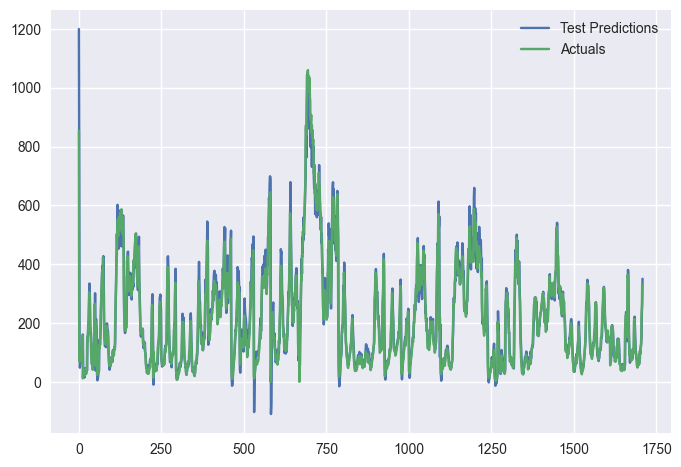

In [17]:
model = load_model('1H_Forecast/1H_ForecastModel_6_SizeWindow/')

X, y = DataHandler(1,6)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

In [8]:
normalization_helper.mae(inversedTestPredictions,inversed_y_test)

29.422386892794172

### 2 hours forecast

In [26]:
%%time

Trainer(2,6,12,50)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 64)                17920     
                                                                 
 dense_22 (Dense)            (None, 8)                 520       
                                                                 
 dense_23 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 09:36:11.243101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:36:11.368450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:28 - loss: 0.8369 - mae: 0.8043 - mse: 0.8369 - mape: 107.3169

2023-02-10 09:36:11.603782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9743 - mae: 0.6524 - mse: 0.9743 - mape: 140.2617

2023-02-10 09:36:14.831282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:36:14.883379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.97775, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 9s 50ms/step - loss: 0.9743 - mae: 0.6524 - mse: 0.9743 - mape: 140.2617 - val_loss: 0.9777 - val_mae: 0.7641 - val_mse: 0.9777 - val_mape: 159.2706
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.7052 - mae: 0.4797 - mse: 0.7052 - mape: 122.4434
Epoch 2: val_loss improved from 0.97775 to 0.62542, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.7052 - mae: 0.4797 - mse: 0.7052 - mape: 122.4434 - val_loss: 0.6254 - val_mae: 0.5829 - val_mse: 0.6254 - val_mape: 149.1359
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5420 - mae: 0.3559 - mse: 0.5420 - mape: 243.8353
Epoch 3: val_loss improved from 0.62542 to 0.41551, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5420 - mae: 0.3559 - mse: 0.5420 - mape: 243.8353 - val_loss: 0.4155 - val_mae: 0.4603 - val_mse: 0.4155 - val_mape: 154.7082
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.4996 - mae: 0.3247 - mse: 0.4996 - mape: 289.4429
Epoch 4: val_loss improved from 0.41551 to 0.35741, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4996 - mae: 0.3247 - mse: 0.4996 - mape: 289.4429 - val_loss: 0.3574 - val_mae: 0.4253 - val_mse: 0.3574 - val_mape: 155.1992
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4876 - mae: 0.3116 - mse: 0.4876 - mape: 287.3697
Epoch 5: val_loss improved from 0.35741 to 0.33725, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4876 - mae: 0.3116 - mse: 0.4876 - mape: 287.3697 - val_loss: 0.3372 - val_mae: 0.4132 - val_mse: 0.3372 - val_mape: 151.9687
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4789 - mae: 0.3046 - mse: 0.4789 - mape: 272.5894
Epoch 6: val_loss improved from 0.33725 to 0.31536, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4789 - mae: 0.3046 - mse: 0.4789 - mape: 272.5894 - val_loss: 0.3154 - val_mae: 0.3989 - val_mse: 0.3154 - val_mape: 147.3173
Epoch 7/50
158/161 [============================>.] - ETA: 0s - loss: 0.4752 - mae: 0.3016 - mse: 0.4752 - mape: 262.3202
Epoch 7: val_loss improved from 0.31536 to 0.29750, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4711 - mae: 0.3014 - mse: 0.4711 - mape: 260.8141 - val_loss: 0.2975 - val_mae: 0.3846 - val_mse: 0.2975 - val_mape: 147.3315
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4645 - mae: 0.2946 - mse: 0.4645 - mape: 260.1419
Epoch 8: val_loss improved from 0.29750 to 0.29377, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4645 - mae: 0.2946 - mse: 0.4645 - mape: 260.1419 - val_loss: 0.2938 - val_mae: 0.3822 - val_mse: 0.2938 - val_mape: 141.4773
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.4588 - mae: 0.2912 - mse: 0.4588 - mape: 249.2440
Epoch 9: val_loss improved from 0.29377 to 0.27867, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4584 - mae: 0.2911 - mse: 0.4584 - mape: 249.0595 - val_loss: 0.2787 - val_mae: 0.3707 - val_mse: 0.2787 - val_mape: 139.7681
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4521 - mae: 0.2875 - mse: 0.4521 - mape: 247.7396
Epoch 10: val_loss improved from 0.27867 to 0.26555, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4521 - mae: 0.2875 - mse: 0.4521 - mape: 247.7396 - val_loss: 0.2655 - val_mae: 0.3602 - val_mse: 0.2655 - val_mape: 139.1224
Epoch 11/50
159/161 [============================>.] - ETA: 0s - loss: 0.4490 - mae: 0.2836 - mse: 0.4490 - mape: 234.3725
Epoch 11: val_loss improved from 0.26555 to 0.25568, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4468 - mae: 0.2833 - mse: 0.4468 - mape: 233.9827 - val_loss: 0.2557 - val_mae: 0.3536 - val_mse: 0.2557 - val_mape: 136.3156
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.4419 - mae: 0.2805 - mse: 0.4419 - mape: 237.2318
Epoch 12: val_loss improved from 0.25568 to 0.24889, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4416 - mae: 0.2804 - mse: 0.4416 - mape: 237.0632 - val_loss: 0.2489 - val_mae: 0.3476 - val_mse: 0.2489 - val_mape: 135.8460
Epoch 13/50
160/161 [============================>.] - ETA: 0s - loss: 0.4361 - mae: 0.2755 - mse: 0.4361 - mape: 219.8319
Epoch 13: val_loss improved from 0.24889 to 0.24475, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4358 - mae: 0.2754 - mse: 0.4358 - mape: 219.6956 - val_loss: 0.2448 - val_mae: 0.3431 - val_mse: 0.2448 - val_mape: 136.1425
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4304 - mae: 0.2727 - mse: 0.4304 - mape: 220.4497
Epoch 14: val_loss improved from 0.24475 to 0.23767, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4304 - mae: 0.2727 - mse: 0.4304 - mape: 220.4497 - val_loss: 0.2377 - val_mae: 0.3379 - val_mse: 0.2377 - val_mape: 134.7634
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.4253 - mae: 0.2667 - mse: 0.4253 - mape: 206.9847
Epoch 15: val_loss improved from 0.23767 to 0.23734, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4253 - mae: 0.2667 - mse: 0.4253 - mape: 206.9847 - val_loss: 0.2373 - val_mae: 0.3377 - val_mse: 0.2373 - val_mape: 132.8005
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.4256 - mae: 0.2869 - mse: 0.4256 - mape: 200.2397
Epoch 16: val_loss improved from 0.23734 to 0.22336, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4253 - mae: 0.2868 - mse: 0.4253 - mape: 200.0948 - val_loss: 0.2234 - val_mae: 0.3257 - val_mse: 0.2234 - val_mape: 132.9371
Epoch 17/50
160/161 [============================>.] - ETA: 0s - loss: 0.4154 - mae: 0.2609 - mse: 0.4154 - mape: 196.8107
Epoch 17: val_loss improved from 0.22336 to 0.22319, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4153 - mae: 0.2610 - mse: 0.4153 - mape: 196.6774 - val_loss: 0.2232 - val_mae: 0.3253 - val_mse: 0.2232 - val_mape: 131.9648
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.4114 - mae: 0.2613 - mse: 0.4114 - mape: 193.6134
Epoch 18: val_loss improved from 0.22319 to 0.21462, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4112 - mae: 0.2614 - mse: 0.4112 - mape: 193.5123 - val_loss: 0.2146 - val_mae: 0.3188 - val_mse: 0.2146 - val_mape: 131.6977
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.4070 - mae: 0.2564 - mse: 0.4070 - mape: 183.4169
Epoch 19: val_loss improved from 0.21462 to 0.20727, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4067 - mae: 0.2563 - mse: 0.4067 - mape: 183.3008 - val_loss: 0.2073 - val_mae: 0.3129 - val_mse: 0.2073 - val_mape: 131.5431
Epoch 20/50
160/161 [============================>.] - ETA: 0s - loss: 0.4026 - mae: 0.2532 - mse: 0.4026 - mape: 177.3823
Epoch 20: val_loss improved from 0.20727 to 0.19956, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4023 - mae: 0.2531 - mse: 0.4023 - mape: 177.3010 - val_loss: 0.1996 - val_mae: 0.3067 - val_mse: 0.1996 - val_mape: 131.7032
Epoch 21/50
160/161 [============================>.] - ETA: 0s - loss: 0.3972 - mae: 0.2501 - mse: 0.3972 - mape: 171.6028
Epoch 21: val_loss improved from 0.19956 to 0.19491, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3975 - mae: 0.2505 - mse: 0.3975 - mape: 172.3075 - val_loss: 0.1949 - val_mae: 0.3025 - val_mse: 0.1949 - val_mape: 132.4184
Epoch 22/50
159/161 [============================>.] - ETA: 0s - loss: 0.3953 - mae: 0.2450 - mse: 0.3953 - mape: 166.0212
Epoch 22: val_loss improved from 0.19491 to 0.18892, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 10s 62ms/step - loss: 0.3933 - mae: 0.2451 - mse: 0.3933 - mape: 165.3127 - val_loss: 0.1889 - val_mae: 0.2982 - val_mse: 0.1889 - val_mape: 131.0170
Epoch 23/50
159/161 [============================>.] - ETA: 0s - loss: 0.3902 - mae: 0.2439 - mse: 0.3902 - mape: 161.4350
Epoch 23: val_loss improved from 0.18892 to 0.17846, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3886 - mae: 0.2440 - mse: 0.3886 - mape: 161.1236 - val_loss: 0.1785 - val_mae: 0.2907 - val_mse: 0.1785 - val_mape: 130.9874
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.3841 - mae: 0.2414 - mse: 0.3841 - mape: 156.1163
Epoch 24: val_loss did not improve from 0.17846
161/161 [==============================] - 3s 20ms/step - loss: 0.3841 - mae: 0.2414 - mse: 0.3841 - mape: 156.1163 - val_loss: 0.1848 - val_mae: 0.2942 - val_mse: 0.1848 - val_mape: 131.5814
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.3799 - mae: 0.2373 - mse: 0.3799 - mape: 148.3604
Epoch 25: val_loss improved from 0.17846 to 0.16826, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3799 - mae: 0.2373 - mse: 0.3799 - mape: 148.3604 - val_loss: 0.1683 - val_mae: 0.2809 - val_mse: 0.1683 - val_mape: 133.6985
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.3761 - mae: 0.2355 - mse: 0.3761 - mape: 147.3702
Epoch 26: val_loss improved from 0.16826 to 0.16742, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 11s 65ms/step - loss: 0.3761 - mae: 0.2355 - mse: 0.3761 - mape: 147.3702 - val_loss: 0.1674 - val_mae: 0.2790 - val_mse: 0.1674 - val_mape: 134.9922
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.3744 - mae: 0.2325 - mse: 0.3744 - mape: 133.9665
Epoch 27: val_loss did not improve from 0.16742
161/161 [==============================] - 4s 22ms/step - loss: 0.3724 - mae: 0.2324 - mse: 0.3724 - mape: 133.5728 - val_loss: 0.1703 - val_mae: 0.2806 - val_mse: 0.1703 - val_mape: 134.5682
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.3698 - mae: 0.2320 - mse: 0.3698 - mape: 133.5099
Epoch 28: val_loss improved from 0.16742 to 0.15232, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3696 - mae: 0.2320 - mse: 0.3696 - mape: 133.4194 - val_loss: 0.1523 - val_mae: 0.2659 - val_mse: 0.1523 - val_mape: 138.4877
Epoch 29/50
159/161 [============================>.] - ETA: 0s - loss: 0.3662 - mae: 0.2298 - mse: 0.3662 - mape: 136.7922
Epoch 29: val_loss did not improve from 0.15232
161/161 [==============================] - 3s 20ms/step - loss: 0.3648 - mae: 0.2298 - mse: 0.3648 - mape: 136.1595 - val_loss: 0.1571 - val_mae: 0.2690 - val_mse: 0.1571 - val_mape: 132.6518
Epoch 30/50
159/161 [============================>.] - ETA: 0s - loss: 0.3640 - mae: 0.2259 - mse: 0.3640 - mape: 128.5421
Epoch 30: val_loss improved from 0.15232 to 0.14987, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3625 - mae: 0.2262 - mse: 0.3625 - mape: 128.3512 - val_loss: 0.1499 - val_mae: 0.2638 - val_mse: 0.1499 - val_mape: 131.1814
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.3596 - mae: 0.2254 - mse: 0.3596 - mape: 127.3849
Epoch 31: val_loss improved from 0.14987 to 0.14481, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3596 - mae: 0.2254 - mse: 0.3596 - mape: 127.3849 - val_loss: 0.1448 - val_mae: 0.2603 - val_mse: 0.1448 - val_mape: 131.2747
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.3577 - mae: 0.2237 - mse: 0.3577 - mape: 128.4096
Epoch 32: val_loss improved from 0.14481 to 0.14259, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3577 - mae: 0.2237 - mse: 0.3577 - mape: 128.4096 - val_loss: 0.1426 - val_mae: 0.2565 - val_mse: 0.1426 - val_mape: 132.1118
Epoch 33/50
160/161 [============================>.] - ETA: 0s - loss: 0.3549 - mae: 0.2206 - mse: 0.3549 - mape: 122.4452
Epoch 33: val_loss did not improve from 0.14259
161/161 [==============================] - 3s 20ms/step - loss: 0.3547 - mae: 0.2206 - mse: 0.3547 - mape: 122.6255 - val_loss: 0.1436 - val_mae: 0.2555 - val_mse: 0.1436 - val_mape: 130.9716
Epoch 34/50
161/161 [==============================] - ETA: 0s - loss: 0.3522 - mae: 0.2220 - mse: 0.3522 - mape: 122.7075
Epoch 34: val_loss improved from 0.14259 to 0.13498, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3522 - mae: 0.2220 - mse: 0.3522 - mape: 122.7075 - val_loss: 0.1350 - val_mae: 0.2506 - val_mse: 0.1350 - val_mape: 130.5587
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.3506 - mae: 0.2212 - mse: 0.3506 - mape: 126.8644
Epoch 35: val_loss did not improve from 0.13498
161/161 [==============================] - 3s 18ms/step - loss: 0.3504 - mae: 0.2212 - mse: 0.3504 - mape: 127.3400 - val_loss: 0.1374 - val_mae: 0.2509 - val_mse: 0.1374 - val_mape: 131.6901
Epoch 36/50
160/161 [============================>.] - ETA: 0s - loss: 0.3490 - mae: 0.2194 - mse: 0.3490 - mape: 118.7662
Epoch 36: val_loss improved from 0.13498 to 0.13104, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3488 - mae: 0.2194 - mse: 0.3488 - mape: 118.7340 - val_loss: 0.1310 - val_mae: 0.2473 - val_mse: 0.1310 - val_mape: 129.3068
Epoch 37/50
161/161 [==============================] - ETA: 0s - loss: 0.3454 - mae: 0.2180 - mse: 0.3454 - mape: 121.1188
Epoch 37: val_loss did not improve from 0.13104
161/161 [==============================] - 3s 18ms/step - loss: 0.3454 - mae: 0.2180 - mse: 0.3454 - mape: 121.1188 - val_loss: 0.1312 - val_mae: 0.2462 - val_mse: 0.1312 - val_mape: 127.1941
Epoch 38/50
159/161 [============================>.] - ETA: 0s - loss: 0.3455 - mae: 0.2180 - mse: 0.3455 - mape: 118.4099
Epoch 38: val_loss did not improve from 0.13104
161/161 [==============================] - 3s 18ms/step - loss: 0.3434 - mae: 0.2176 - mse: 0.3434 - mape: 119.2494 - val_loss: 0.1328 - val_mae: 0.2478 - val_mse: 0.1328 - val_mape: 128.4185
Epoch 39/50
158/161 [============================>.] - ETA: 0s - loss: 0.3463 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3428 - mae: 0.2161 - mse: 0.3428 - mape: 119.9887 - val_loss: 0.1305 - val_mae: 0.2455 - val_mse: 0.1305 - val_mape: 123.8943
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.3401 - mae: 0.2146 - mse: 0.3401 - mape: 121.5350
Epoch 40: val_loss improved from 0.13048 to 0.13028, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3400 - mae: 0.2147 - mse: 0.3400 - mape: 121.7457 - val_loss: 0.1303 - val_mae: 0.2452 - val_mse: 0.1303 - val_mape: 121.6543
Epoch 41/50
159/161 [============================>.] - ETA: 0s - loss: 0.3401 - mae: 0.2160 - mse: 0.3401 - mape: 118.5260
Epoch 41: val_loss improved from 0.13028 to 0.12679, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3383 - mae: 0.2159 - mse: 0.3383 - mape: 118.7762 - val_loss: 0.1268 - val_mae: 0.2419 - val_mse: 0.1268 - val_mape: 122.3121
Epoch 42/50
159/161 [============================>.] - ETA: 0s - loss: 0.3381 - mae: 0.2141 - mse: 0.3381 - mape: 119.1758
Epoch 42: val_loss did not improve from 0.12679
161/161 [==============================] - 3s 17ms/step - loss: 0.3360 - mae: 0.2137 - mse: 0.3360 - mape: 118.7914 - val_loss: 0.1304 - val_mae: 0.2431 - val_mse: 0.1304 - val_mape: 120.7866
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.3342 - mae: 0.2124 - mse: 0.3342 - mape: 125.4084
Epoch 43: val_loss did not improve from 0.12679
161/161 [==============================] - 3s 19ms/step - loss: 0.3340 - mae: 0.2123 - mse: 0.3340 - mape: 125.3323 - val_loss: 0.1301 - val_mae: 0.2434 - val_mse: 0.1301 - val_mape: 118.9897
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.3324 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3284 - mae: 0.2116 - mse: 0.3284 - mape: 124.3291 - val_loss: 0.1266 - val_mae: 0.2442 - val_mse: 0.1266 - val_mape: 115.3109
Epoch 47/50
161/161 [==============================] - ETA: 0s - loss: 0.3261 - mae: 0.2120 - mse: 0.3261 - mape: 120.7598
Epoch 47: val_loss improved from 0.12660 to 0.12349, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3261 - mae: 0.2120 - mse: 0.3261 - mape: 120.7598 - val_loss: 0.1235 - val_mae: 0.2417 - val_mse: 0.1235 - val_mape: 116.1124
Epoch 48/50
161/161 [==============================] - ETA: 0s - loss: 0.3245 - mae: 0.2103 - mse: 0.3245 - mape: 121.4709
Epoch 48: val_loss improved from 0.12349 to 0.12342, saving model to 2H_Forecast/2H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3245 - mae: 0.2103 - mse: 0.3245 - mape: 121.4709 - val_loss: 0.1234 - val_mae: 0.2393 - val_mse: 0.1234 - val_mape: 114.2740
Epoch 49/50
161/161 [==============================] - ETA: 0s - loss: 0.3214 - mae: 0.2085 - mse: 0.3214 - mape: 126.5488
Epoch 49: val_loss did not improve from 0.12342
161/161 [==============================] - 3s 18ms/step - loss: 0.3214 - mae: 0.2085 - mse: 0.3214 - mape: 126.5488 - val_loss: 0.1260 - val_mae: 0.2424 - val_mse: 0.1260 - val_mape: 111.2411
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.3205 - mae: 0.2104 - mse: 0.3205 - mape: 126.6288
Epoch 50: val_loss did not improve from 0.12342
161/161 [==============================] - 3s 18ms/step - loss: 0.3203 - mae: 0.2104 - mse: 0.3203 - mape: 126.6031 - val_loss: 0.1251 - val_mae: 0.2423 - val_mse: 0.1251 - val_mape: 110.9717

---------------------------------------------------------------------------------

2023-02-10 09:41:32.419228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:41:32.571834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:41:32.851580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.7925 - mae: 0.5695 - mse: 0.7925 - mape: 138.4720

2023-02-10 09:41:36.070450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:41:36.156412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.65808, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 11s 57ms/step - loss: 0.7925 - mae: 0.5695 - mse: 0.7925 - mape: 138.4720 - val_loss: 0.6581 - val_mae: 0.6239 - val_mse: 0.6581 - val_mape: 128.7444
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.5604 - mae: 0.3863 - mse: 0.5604 - mape: 267.1477
Epoch 2: val_loss improved from 0.65808 to 0.38329, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5604 - mae: 0.3863 - mse: 0.5604 - mape: 267.1477 - val_loss: 0.3833 - val_mae: 0.4606 - val_mse: 0.3833 - val_mape: 129.9082
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.4975 - mae: 0.3349 - mse: 0.4975 - mape: 310.9289
Epoch 3: val_loss improved from 0.38329 to 0.30678, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.4975 - mae: 0.3349 - mse: 0.4975 - mape: 310.9289 - val_loss: 0.3068 - val_mae: 0.4058 - val_mse: 0.3068 - val_mape: 136.9918
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.4823 - mae: 0.3199 - mse: 0.4823 - mape: 313.9161
Epoch 4: val_loss improved from 0.30678 to 0.28141, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4823 - mae: 0.3199 - mse: 0.4823 - mape: 313.9161 - val_loss: 0.2814 - val_mae: 0.3863 - val_mse: 0.2814 - val_mape: 141.1772
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4737 - mae: 0.3129 - mse: 0.4737 - mape: 300.4251
Epoch 5: val_loss improved from 0.28141 to 0.27165, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4737 - mae: 0.3129 - mse: 0.4737 - mape: 300.4251 - val_loss: 0.2717 - val_mae: 0.3774 - val_mse: 0.2717 - val_mape: 143.8706
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4653 - mae: 0.3070 - mse: 0.4653 - mape: 290.2657
Epoch 6: val_loss improved from 0.27165 to 0.26399, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4653 - mae: 0.3070 - mse: 0.4653 - mape: 290.2657 - val_loss: 0.2640 - val_mae: 0.3690 - val_mse: 0.2640 - val_mape: 146.3874
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.4580 - mae: 0.2995 - mse: 0.4580 - mape: 275.7919
Epoch 7: val_loss improved from 0.26399 to 0.25573, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.4580 - mae: 0.2995 - mse: 0.4580 - mape: 275.7919 - val_loss: 0.2557 - val_mae: 0.3625 - val_mse: 0.2557 - val_mape: 143.6341
Epoch 8/50
160/161 [============================>.] - ETA: 0s - loss: 0.4513 - mae: 0.2950 - mse: 0.4513 - mape: 260.6117
Epoch 8: val_loss improved from 0.25573 to 0.23943, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4511 - mae: 0.2950 - mse: 0.4511 - mape: 260.5123 - val_loss: 0.2394 - val_mae: 0.3480 - val_mse: 0.2394 - val_mape: 144.1959
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.4440 - mae: 0.2885 - mse: 0.4440 - mape: 247.3438
Epoch 9: val_loss improved from 0.23943 to 0.23243, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4438 - mae: 0.2884 - mse: 0.4438 - mape: 247.2138 - val_loss: 0.2324 - val_mae: 0.3406 - val_mse: 0.2324 - val_mape: 143.0366
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4354 - mae: 0.2814 - mse: 0.4354 - mape: 248.1342
Epoch 10: val_loss improved from 0.23243 to 0.22400, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4354 - mae: 0.2814 - mse: 0.4354 - mape: 248.1342 - val_loss: 0.2240 - val_mae: 0.3335 - val_mse: 0.2240 - val_mape: 138.2959
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.4290 - mae: 0.2770 - mse: 0.4290 - mape: 234.1489
Epoch 11: val_loss improved from 0.22400 to 0.21627, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4290 - mae: 0.2770 - mse: 0.4290 - mape: 234.1489 - val_loss: 0.2163 - val_mae: 0.3247 - val_mse: 0.2163 - val_mape: 139.2001
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.4221 - mae: 0.2727 - mse: 0.4221 - mape: 221.5932
Epoch 12: val_loss improved from 0.21627 to 0.20217, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 38ms/step - loss: 0.4219 - mae: 0.2726 - mse: 0.4219 - mape: 221.4762 - val_loss: 0.2022 - val_mae: 0.3120 - val_mse: 0.2022 - val_mape: 137.5851
Epoch 13/50
159/161 [============================>.] - ETA: 0s - loss: 0.4157 - mae: 0.2646 - mse: 0.4157 - mape: 204.6220
Epoch 13: val_loss improved from 0.20217 to 0.19829, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 39ms/step - loss: 0.4134 - mae: 0.2642 - mse: 0.4134 - mape: 203.5822 - val_loss: 0.1983 - val_mae: 0.3064 - val_mse: 0.1983 - val_mape: 134.3504
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4065 - mae: 0.2582 - mse: 0.4065 - mape: 190.7902
Epoch 14: val_loss improved from 0.19829 to 0.18456, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4065 - mae: 0.2582 - mse: 0.4065 - mape: 190.7902 - val_loss: 0.1846 - val_mae: 0.2931 - val_mse: 0.1846 - val_mape: 133.9960
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.3990 - mae: 0.2519 - mse: 0.3990 - mape: 179.9241
Epoch 15: val_loss improved from 0.18456 to 0.17865, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.3990 - mae: 0.2519 - mse: 0.3990 - mape: 179.9241 - val_loss: 0.1787 - val_mae: 0.2858 - val_mse: 0.1787 - val_mape: 135.4711
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.3925 - mae: 0.2451 - mse: 0.3925 - mape: 164.2710
Epoch 16: val_loss improved from 0.17865 to 0.17073, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.3923 - mae: 0.2451 - mse: 0.3923 - mape: 164.1841 - val_loss: 0.1707 - val_mae: 0.2797 - val_mse: 0.1707 - val_mape: 128.0254
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.3849 - mae: 0.2389 - mse: 0.3849 - mape: 155.5681
Epoch 17: val_loss did not improve from 0.17073
161/161 [==============================] - 3s 16ms/step - loss: 0.3849 - mae: 0.2389 - mse: 0.3849 - mape: 155.5681 - val_loss: 0.1729 - val_mae: 0.2781 - val_mse: 0.1729 - val_mape: 127.8378
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.3784 - mae: 0.2354 - mse: 0.3784 - mape: 149.3897
Epoch 18: val_loss improved from 0.17073 to 0.15840, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3784 - mae: 0.2354 - mse: 0.3784 - mape: 149.3897 - val_loss: 0.1584 - val_mae: 0.2674 - val_mse: 0.1584 - val_mape: 118.7042
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.3733 - mae: 0.2316 - mse: 0.3733 - mape: 139.4974
Epoch 19: val_loss improved from 0.15840 to 0.15590, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3731 - mae: 0.2316 - mse: 0.3731 - mape: 139.4292 - val_loss: 0.1559 - val_mae: 0.2614 - val_mse: 0.1559 - val_mape: 120.5324
Epoch 20/50
159/161 [============================>.] - ETA: 0s - loss: 0.3706 - mae: 0.2286 - mse: 0.3706 - mape: 135.2056
Epoch 20: val_loss improved from 0.15590 to 0.14760, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.3684 - mae: 0.2283 - mse: 0.3684 - mape: 135.1871 - val_loss: 0.1476 - val_mae: 0.2550 - val_mse: 0.1476 - val_mape: 115.7347
Epoch 21/50
158/161 [============================>.] - ETA: 0s - loss: 0.3355 - mae: 0.2220 - mse: 0.3355 - mape: 129.8725
Epoch 21: val_loss did not improve from 0.14760
161/161 [==============================] - 3s 18ms/step - loss: 0.3636 - mae: 0.2252 - mse: 0.3636 - mape: 129.2973 - val_loss: 0.1490 - val_mae: 0.2559 - val_mse: 0.1490 - val_mape: 112.1659
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.3621 - mae: 0.2272 - mse: 0.3621 - mape: 127.0690
Epoch 22: val_loss improved from 0.14760 to 0.14653, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3621 - mae: 0.2272 - mse: 0.3621 - mape: 127.0690 - val_loss: 0.1465 - val_mae: 0.2523 - val_mse: 0.1465 - val_mape: 113.6884
Epoch 23/50
159/161 [============================>.] - ETA: 0s - loss: 0.3577 - mae: 0.2231 - mse: 0.3577 - mape: 122.1244
Epoch 23: val_loss did not improve from 0.14653
161/161 [==============================] - 3s 18ms/step - loss: 0.3557 - mae: 0.2229 - mse: 0.3557 - mape: 122.4401 - val_loss: 0.1526 - val_mae: 0.2567 - val_mse: 0.1526 - val_mape: 111.5266
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.3520 - mae: 0.2229 - mse: 0.3520 - mape: 124.0140
Epoch 24: val_loss improved from 0.14653 to 0.14410, saving model to 2H_Forecast/2H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3520 - mae: 0.2229 - mse: 0.3520 - mape: 124.0140 - val_loss: 0.1441 - val_mae: 0.2490 - val_mse: 0.1441 - val_mape: 113.2025
Epoch 25/50
158/161 [============================>.] - ETA: 0s - loss: 0.3502 - mae: 0.2208 - mse: 0.3502 - mape: 125.9338
Epoch 25: val_loss did not improve from 0.14410
161/161 [==============================] - 3s 18ms/step - loss: 0.3472 - mae: 0.2209 - mse: 0.3472 - mape: 124.9262 - val_loss: 0.1595 - val_mae: 0.2605 - val_mse: 0.1595 - val_mape: 109.8316
Epoch 26/50
159/161 [============================>.] - ETA: 0s - loss: 0.3441 - mae: 0.2186 - mse: 0.3441 - mape: 127.2413
Epoch 26: val_loss did not improve from 0.14410
161/161 [==============================] - 3s 17ms/step - loss: 0.3434 - mae: 0.2192 - mse: 0.3434 - mape: 127.0740 - val_loss: 0.1492 - val_mae: 0.2534 - val_mse: 0.1492 - val_mape: 107.4223
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.3415 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.2619 - mae: 0.2052 - mse: 0.2619 - mape: 131.5935 - val_loss: 0.1397 - val_mae: 0.2469 - val_mse: 0.1397 - val_mape: 94.6970
Epoch 48/50
161/161 [==============================] - ETA: 0s - loss: 0.2595 - mae: 0.2037 - mse: 0.2595 - mape: 130.5268
Epoch 48: val_loss did not improve from 0.13970
161/161 [==============================] - 3s 16ms/step - loss: 0.2595 - mae: 0.2037 - mse: 0.2595 - mape: 130.5268 - val_loss: 0.1440 - val_mae: 0.2470 - val_mse: 0.1440 - val_mape: 99.6794
Epoch 49/50
158/161 [============================>.] - ETA: 0s - loss: 0.2575 - mae: 0.2059 - mse: 0.2575 - mape: 135.5753
Epoch 49: val_loss did not improve from 0.13970
161/161 [==============================] - 3s 17ms/step - loss: 0.2574 - mae: 0.2061 - mse: 0.2574 - mape: 135.0267 - val_loss: 0.1483 - val_mae: 0.2488 - val_mse: 0.1483 - val_mape: 100.7483
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.2552 - mae:

2023-02-10 09:45:27.566967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:45:27.690556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:19 - loss: 0.8480 - mae: 0.7866 - mse: 0.8480 - mape: 111.3926

2023-02-10 09:45:27.919266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9544 - mae: 0.6913 - mse: 0.9544 - mape: 124.9224

2023-02-10 09:45:31.069928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:45:31.127490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.58381, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 49ms/step - loss: 0.9544 - mae: 0.6913 - mse: 0.9544 - mape: 124.9224 - val_loss: 0.5838 - val_mae: 0.5988 - val_mse: 0.5838 - val_mape: 115.0224
Epoch 2/50
159/161 [============================>.] - ETA: 0s - loss: 0.6193 - mae: 0.4746 - mse: 0.6193 - mape: 155.7219
Epoch 2: val_loss improved from 0.58381 to 0.39574, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.6167 - mae: 0.4739 - mse: 0.6167 - mape: 155.3082 - val_loss: 0.3957 - val_mae: 0.4786 - val_mse: 0.3957 - val_mape: 127.7841
Epoch 3/50
159/161 [============================>.] - ETA: 0s - loss: 0.5373 - mae: 0.3761 - mse: 0.5373 - mape: 240.4443
Epoch 3: val_loss improved from 0.39574 to 0.35959, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5354 - mae: 0.3762 - mse: 0.5354 - mape: 239.4192 - val_loss: 0.3596 - val_mae: 0.4469 - val_mse: 0.3596 - val_mape: 120.9909
Epoch 4/50
160/161 [============================>.] - ETA: 0s - loss: 0.5135 - mae: 0.3531 - mse: 0.5135 - mape: 263.1063
Epoch 4: val_loss improved from 0.35959 to 0.34657, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5133 - mae: 0.3530 - mse: 0.5133 - mape: 263.0417 - val_loss: 0.3466 - val_mae: 0.4350 - val_mse: 0.3466 - val_mape: 118.3415
Epoch 5/50
160/161 [============================>.] - ETA: 0s - loss: 0.4993 - mae: 0.3382 - mse: 0.4993 - mape: 283.9863
Epoch 5: val_loss improved from 0.34657 to 0.32368, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.4991 - mae: 0.3382 - mse: 0.4991 - mape: 283.8816 - val_loss: 0.3237 - val_mae: 0.4179 - val_mse: 0.3237 - val_mape: 117.6764
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4874 - mae: 0.3279 - mse: 0.4874 - mape: 292.2057
Epoch 6: val_loss improved from 0.32368 to 0.30408, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4874 - mae: 0.3279 - mse: 0.4874 - mape: 292.2057 - val_loss: 0.3041 - val_mae: 0.4018 - val_mse: 0.3041 - val_mape: 117.0773
Epoch 7/50
160/161 [============================>.] - ETA: 0s - loss: 0.4749 - mae: 0.3187 - mse: 0.4749 - mape: 293.3528
Epoch 7: val_loss improved from 0.30408 to 0.29976, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4748 - mae: 0.3188 - mse: 0.4748 - mape: 293.2527 - val_loss: 0.2998 - val_mae: 0.3977 - val_mse: 0.2998 - val_mape: 114.1419
Epoch 8/50
159/161 [============================>.] - ETA: 0s - loss: 0.4675 - mae: 0.3118 - mse: 0.4675 - mape: 282.3758
Epoch 8: val_loss improved from 0.29976 to 0.26955, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4650 - mae: 0.3112 - mse: 0.4650 - mape: 281.7397 - val_loss: 0.2696 - val_mae: 0.3719 - val_mse: 0.2696 - val_mape: 120.9781
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4539 - mae: 0.3043 - mse: 0.4539 - mape: 271.8122
Epoch 9: val_loss improved from 0.26955 to 0.26213, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.4539 - mae: 0.3043 - mse: 0.4539 - mape: 271.8122 - val_loss: 0.2621 - val_mae: 0.3642 - val_mse: 0.2621 - val_mape: 124.1740
Epoch 10/50
160/161 [============================>.] - ETA: 0s - loss: 0.4445 - mae: 0.2933 - mse: 0.4445 - mape: 261.3344
Epoch 10: val_loss improved from 0.26213 to 0.24742, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4444 - mae: 0.2933 - mse: 0.4444 - mape: 261.2856 - val_loss: 0.2474 - val_mae: 0.3513 - val_mse: 0.2474 - val_mape: 125.1259
Epoch 11/50
159/161 [============================>.] - ETA: 0s - loss: 0.4345 - mae: 0.2864 - mse: 0.4345 - mape: 240.5213
Epoch 11: val_loss improved from 0.24742 to 0.23967, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4347 - mae: 0.2869 - mse: 0.4347 - mape: 239.3000 - val_loss: 0.2397 - val_mae: 0.3434 - val_mse: 0.2397 - val_mape: 120.0613
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.4261 - mae: 0.2788 - mse: 0.4261 - mape: 224.6796
Epoch 12: val_loss improved from 0.23967 to 0.22690, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4259 - mae: 0.2787 - mse: 0.4259 - mape: 224.6005 - val_loss: 0.2269 - val_mae: 0.3312 - val_mse: 0.2269 - val_mape: 121.3313
Epoch 13/50
160/161 [============================>.] - ETA: 0s - loss: 0.4175 - mae: 0.2689 - mse: 0.4175 - mape: 206.7564
Epoch 13: val_loss improved from 0.22690 to 0.21765, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4174 - mae: 0.2688 - mse: 0.4174 - mape: 206.6794 - val_loss: 0.2176 - val_mae: 0.3250 - val_mse: 0.2176 - val_mape: 112.4765
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4095 - mae: 0.2646 - mse: 0.4095 - mape: 196.8312
Epoch 14: val_loss improved from 0.21765 to 0.20565, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4095 - mae: 0.2646 - mse: 0.4095 - mape: 196.8312 - val_loss: 0.2056 - val_mae: 0.3119 - val_mse: 0.2056 - val_mape: 119.8210
Epoch 15/50
159/161 [============================>.] - ETA: 0s - loss: 0.4044 - mae: 0.2592 - mse: 0.4044 - mape: 191.5477
Epoch 15: val_loss improved from 0.20565 to 0.19943, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4026 - mae: 0.2592 - mse: 0.4026 - mape: 190.9514 - val_loss: 0.1994 - val_mae: 0.3048 - val_mse: 0.1994 - val_mape: 121.7001
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.3957 - mae: 0.2541 - mse: 0.3957 - mape: 176.4258
Epoch 16: val_loss improved from 0.19943 to 0.19780, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3956 - mae: 0.2541 - mse: 0.3956 - mape: 176.3630 - val_loss: 0.1978 - val_mae: 0.3008 - val_mse: 0.1978 - val_mape: 124.7269
Epoch 17/50
159/161 [============================>.] - ETA: 0s - loss: 0.3908 - mae: 0.2490 - mse: 0.3908 - mape: 168.3740
Epoch 17: val_loss improved from 0.19780 to 0.19092, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3888 - mae: 0.2487 - mse: 0.3888 - mape: 167.7088 - val_loss: 0.1909 - val_mae: 0.2966 - val_mse: 0.1909 - val_mape: 124.2868
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.3824 - mae: 0.2450 - mse: 0.3824 - mape: 156.1306
Epoch 18: val_loss improved from 0.19092 to 0.19076, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3824 - mae: 0.2450 - mse: 0.3824 - mape: 156.1306 - val_loss: 0.1908 - val_mae: 0.2961 - val_mse: 0.1908 - val_mape: 118.5885
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.3769 - mae: 0.2434 - mse: 0.3769 - mape: 157.7447
Epoch 19: val_loss improved from 0.19076 to 0.17638, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3769 - mae: 0.2434 - mse: 0.3769 - mape: 157.7447 - val_loss: 0.1764 - val_mae: 0.2855 - val_mse: 0.1764 - val_mape: 127.5920
Epoch 20/50
159/161 [============================>.] - ETA: 0s - loss: 0.3727 - mae: 0.2392 - mse: 0.3727 - mape: 146.2190
Epoch 20: val_loss did not improve from 0.17638
161/161 [==============================] - 3s 18ms/step - loss: 0.3711 - mae: 0.2393 - mse: 0.3711 - mape: 146.8860 - val_loss: 0.1799 - val_mae: 0.2866 - val_mse: 0.1799 - val_mape: 123.3325
Epoch 21/50
161/161 [==============================] - ETA: 0s - loss: 0.3656 - mae: 0.2367 - mse: 0.3656 - mape: 136.9470
Epoch 21: val_loss did not improve from 0.17638
161/161 [==============================] - 3s 18ms/step - loss: 0.3656 - mae: 0.2367 - mse: 0.3656 - mape: 136.9470 - val_loss: 0.1856 - val_mae: 0.2891 - val_mse: 0.1856 - val_mape: 125.6146
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.3598 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3465 - mae: 0.2320 - mse: 0.3465 - mape: 135.9549 - val_loss: 0.1761 - val_mae: 0.2824 - val_mse: 0.1761 - val_mape: 135.9059
Epoch 25/50
159/161 [============================>.] - ETA: 0s - loss: 0.3427 - mae: 0.2315 - mse: 0.3427 - mape: 129.6010
Epoch 25: val_loss improved from 0.17605 to 0.17522, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3415 - mae: 0.2315 - mse: 0.3415 - mape: 129.5871 - val_loss: 0.1752 - val_mae: 0.2839 - val_mse: 0.1752 - val_mape: 134.4590
Epoch 26/50
160/161 [============================>.] - ETA: 0s - loss: 0.3347 - mae: 0.2302 - mse: 0.3347 - mape: 129.3916
Epoch 26: val_loss did not improve from 0.17522
161/161 [==============================] - 3s 18ms/step - loss: 0.3345 - mae: 0.2301 - mse: 0.3345 - mape: 129.3434 - val_loss: 0.1834 - val_mae: 0.2898 - val_mse: 0.1834 - val_mape: 128.0287
Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.3284 - mae: 0.2276 - mse: 0.3284 - mape: 131.8121
Epoch 27: val_loss improved from 0.17522 to 0.17340, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3284 - mae: 0.2276 - mse: 0.3284 - mape: 131.8121 - val_loss: 0.1734 - val_mae: 0.2845 - val_mse: 0.1734 - val_mape: 127.3776
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.3230 - mae: 0.2280 - mse: 0.3230 - mape: 121.3705
Epoch 28: val_loss did not improve from 0.17340
161/161 [==============================] - 3s 18ms/step - loss: 0.3229 - mae: 0.2280 - mse: 0.3229 - mape: 121.3259 - val_loss: 0.1777 - val_mae: 0.2807 - val_mse: 0.1777 - val_mape: 123.6608
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.3157 - mae: 0.2239 - mse: 0.3157 - mape: 122.1029
Epoch 29: val_loss improved from 0.17340 to 0.16980, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3157 - mae: 0.2240 - mse: 0.3157 - mape: 122.6643 - val_loss: 0.1698 - val_mae: 0.2803 - val_mse: 0.1698 - val_mape: 125.3165
Epoch 30/50
160/161 [============================>.] - ETA: 0s - loss: 0.3102 - mae: 0.2232 - mse: 0.3102 - mape: 126.7495
Epoch 30: val_loss did not improve from 0.16980
161/161 [==============================] - 3s 18ms/step - loss: 0.3101 - mae: 0.2231 - mse: 0.3101 - mape: 126.7056 - val_loss: 0.1804 - val_mae: 0.2854 - val_mse: 0.1804 - val_mape: 123.4643
Epoch 31/50
159/161 [============================>.] - ETA: 0s - loss: 0.3071 - mae: 0.2222 - mse: 0.3071 - mape: 123.8857
Epoch 31: val_loss did not improve from 0.16980
161/161 [==============================] - 3s 20ms/step - loss: 0.3054 - mae: 0.2218 - mse: 0.3054 - mape: 123.3769 - val_loss: 0.1712 - val_mae: 0.2786 - val_mse: 0.1712 - val_mape: 117.2295
Epoch 32/50
158/161 [============================>.] - ETA: 0s - loss: 0.3015 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.2602 - mae: 0.2128 - mse: 0.2602 - mape: 123.1339 - val_loss: 0.1667 - val_mae: 0.2748 - val_mse: 0.1667 - val_mape: 116.8192
Epoch 42/50
159/161 [============================>.] - ETA: 0s - loss: 0.2584 - mae: 0.2076 - mse: 0.2584 - mape: 119.3947
Epoch 42: val_loss improved from 0.16673 to 0.16568, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.2573 - mae: 0.2077 - mse: 0.2573 - mape: 119.3281 - val_loss: 0.1657 - val_mae: 0.2671 - val_mse: 0.1657 - val_mape: 113.2308
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.2535 - mae: 0.2092 - mse: 0.2535 - mape: 116.5616
Epoch 43: val_loss did not improve from 0.16568
161/161 [==============================] - 3s 19ms/step - loss: 0.2535 - mae: 0.2092 - mse: 0.2535 - mape: 116.5256 - val_loss: 0.1679 - val_mae: 0.2724 - val_mse: 0.1679 - val_mape: 118.3141
Epoch 44/50
158/161 [============================>.] - ETA: 0s - loss: 0.2528 - mae: 0.2057 - mse: 0.2528 - mape: 117.9177
Epoch 44: val_loss did not improve from 0.16568
161/161 [==============================] - 3s 18ms/step - loss: 0.2506 - mae: 0.2055 - mse: 0.2506 - mape: 118.7281 - val_loss: 0.1683 - val_mae: 0.2676 - val_mse: 0.1683 - val_mape: 114.7176
Epoch 45/50
159/161 [============================>.] - ETA: 0s - loss: 0.2475 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.2459 - mae: 0.2083 - mse: 0.2459 - mape: 114.6273 - val_loss: 0.1579 - val_mae: 0.2586 - val_mse: 0.1579 - val_mape: 108.0464
Epoch 47/50
160/161 [============================>.] - ETA: 0s - loss: 0.2417 - mae: 0.2039 - mse: 0.2417 - mape: 121.4266
Epoch 47: val_loss did not improve from 0.15785
161/161 [==============================] - 3s 19ms/step - loss: 0.2416 - mae: 0.2038 - mse: 0.2416 - mape: 121.3799 - val_loss: 0.1637 - val_mae: 0.2618 - val_mse: 0.1637 - val_mape: 116.2677
Epoch 48/50
161/161 [==============================] - ETA: 0s - loss: 0.2390 - mae: 0.2030 - mse: 0.2390 - mape: 118.2734
Epoch 48: val_loss did not improve from 0.15785
161/161 [==============================] - 3s 19ms/step - loss: 0.2390 - mae: 0.2030 - mse: 0.2390 - mape: 118.2734 - val_loss: 0.1632 - val_mae: 0.2601 - val_mse: 0.1632 - val_mape: 111.9407
Epoch 49/50
161/161 [==============================] - ETA: 0s - loss: 0.2371 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.2371 - mae: 0.2012 - mse: 0.2371 - mape: 117.1367 - val_loss: 0.1547 - val_mae: 0.2538 - val_mse: 0.1547 - val_mape: 105.2917
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.2343 - mae: 0.2036 - mse: 0.2343 - mape: 113.5130
Epoch 50: val_loss improved from 0.15465 to 0.15274, saving model to 2H_Forecast/2H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.2343 - mae: 0.2036 - mse: 0.2343 - mape: 113.5130 - val_loss: 0.1527 - val_mae: 0.2530 - val_mse: 0.1527 - val_mape: 108.7282

-----------------------------------------------------------------------------------------------------------

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 64)                17920     
                                                                 
 dense_28 (Dense)            (None, 8)                 520       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 09:49:54.292817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:49:54.411673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:49:54.787372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8535 - mae: 0.5773 - mse: 0.8535 - mape: 138.3655

2023-02-10 09:49:58.610727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:49:58.663709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.67037, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 11s 57ms/step - loss: 0.8535 - mae: 0.5773 - mse: 0.8535 - mape: 138.3655 - val_loss: 0.6704 - val_mae: 0.6294 - val_mse: 0.6704 - val_mape: 115.2388
Epoch 2/50
159/161 [============================>.] - ETA: 0s - loss: 0.6656 - mae: 0.4435 - mse: 0.6656 - mape: 225.0809
Epoch 2: val_loss improved from 0.67037 to 0.42124, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.6627 - mae: 0.4431 - mse: 0.6627 - mape: 224.3486 - val_loss: 0.4212 - val_mae: 0.4746 - val_mse: 0.4212 - val_mape: 146.0001
Epoch 3/50
160/161 [============================>.] - ETA: 0s - loss: 0.5595 - mae: 0.3687 - mse: 0.5595 - mape: 301.1797
Epoch 3: val_loss improved from 0.42124 to 0.33089, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.5594 - mae: 0.3687 - mse: 0.5594 - mape: 301.1211 - val_loss: 0.3309 - val_mae: 0.4109 - val_mse: 0.3309 - val_mape: 147.8505
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5237 - mae: 0.3396 - mse: 0.5237 - mape: 301.2347
Epoch 4: val_loss improved from 0.33089 to 0.30370, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5237 - mae: 0.3396 - mse: 0.5237 - mape: 301.2347 - val_loss: 0.3037 - val_mae: 0.3910 - val_mse: 0.3037 - val_mape: 142.5130
Epoch 5/50
160/161 [============================>.] - ETA: 0s - loss: 0.5007 - mae: 0.3204 - mse: 0.5007 - mape: 292.6495
Epoch 5: val_loss improved from 0.30370 to 0.27226, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5009 - mae: 0.3206 - mse: 0.5009 - mape: 292.6130 - val_loss: 0.2723 - val_mae: 0.3681 - val_mse: 0.2723 - val_mape: 139.7931
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4827 - mae: 0.3045 - mse: 0.4827 - mape: 270.2881
Epoch 6: val_loss improved from 0.27226 to 0.23898, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4827 - mae: 0.3045 - mse: 0.4827 - mape: 270.2881 - val_loss: 0.2390 - val_mae: 0.3434 - val_mse: 0.2390 - val_mape: 136.9660
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.4659 - mae: 0.2929 - mse: 0.4659 - mape: 248.9413
Epoch 7: val_loss improved from 0.23898 to 0.22761, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4659 - mae: 0.2929 - mse: 0.4659 - mape: 248.9413 - val_loss: 0.2276 - val_mae: 0.3356 - val_mse: 0.2276 - val_mape: 130.1675
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4505 - mae: 0.2829 - mse: 0.4505 - mape: 223.9386
Epoch 8: val_loss improved from 0.22761 to 0.21536, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4505 - mae: 0.2829 - mse: 0.4505 - mape: 223.9386 - val_loss: 0.2154 - val_mae: 0.3260 - val_mse: 0.2154 - val_mape: 127.2634
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4369 - mae: 0.2718 - mse: 0.4369 - mape: 202.6239
Epoch 9: val_loss improved from 0.21536 to 0.20377, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4369 - mae: 0.2718 - mse: 0.4369 - mape: 202.6239 - val_loss: 0.2038 - val_mae: 0.3184 - val_mse: 0.2038 - val_mape: 124.8313
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4263 - mae: 0.2620 - mse: 0.4263 - mape: 199.4107
Epoch 10: val_loss improved from 0.20377 to 0.17753, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4263 - mae: 0.2620 - mse: 0.4263 - mape: 199.4107 - val_loss: 0.1775 - val_mae: 0.2973 - val_mse: 0.1775 - val_mape: 125.0936
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.4171 - mae: 0.2579 - mse: 0.4171 - mape: 188.1243
Epoch 11: val_loss did not improve from 0.17753
161/161 [==============================] - 3s 18ms/step - loss: 0.4171 - mae: 0.2578 - mse: 0.4171 - mape: 188.1826 - val_loss: 0.1817 - val_mae: 0.2999 - val_mse: 0.1817 - val_mape: 124.2760
Epoch 12/50
159/161 [============================>.] - ETA: 0s - loss: 0.4114 - mae: 0.2515 - mse: 0.4114 - mape: 167.2713
Epoch 12: val_loss improved from 0.17753 to 0.17080, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4097 - mae: 0.2514 - mse: 0.4097 - mape: 166.9985 - val_loss: 0.1708 - val_mae: 0.2920 - val_mse: 0.1708 - val_mape: 125.2368
Epoch 13/50
159/161 [============================>.] - ETA: 0s - loss: 0.4027 - mae: 0.2450 - mse: 0.4027 - mape: 164.3727
Epoch 13: val_loss improved from 0.17080 to 0.16704, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.4013 - mae: 0.2449 - mse: 0.4013 - mape: 163.6817 - val_loss: 0.1670 - val_mae: 0.2879 - val_mse: 0.1670 - val_mape: 124.2896
Epoch 14/50
160/161 [============================>.] - ETA: 0s - loss: 0.3967 - mae: 0.2470 - mse: 0.3967 - mape: 157.4364
Epoch 14: val_loss improved from 0.16704 to 0.16227, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3966 - mae: 0.2470 - mse: 0.3966 - mape: 157.4128 - val_loss: 0.1623 - val_mae: 0.2830 - val_mse: 0.1623 - val_mape: 127.0115
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.3912 - mae: 0.2434 - mse: 0.3912 - mape: 151.7612
Epoch 15: val_loss improved from 0.16227 to 0.15138, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3912 - mae: 0.2434 - mse: 0.3912 - mape: 151.7612 - val_loss: 0.1514 - val_mae: 0.2738 - val_mse: 0.1514 - val_mape: 130.9837
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.3871 - mae: 0.2398 - mse: 0.3871 - mape: 144.5330
Epoch 16: val_loss improved from 0.15138 to 0.14894, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3871 - mae: 0.2398 - mse: 0.3871 - mape: 144.5330 - val_loss: 0.1489 - val_mae: 0.2723 - val_mse: 0.1489 - val_mape: 129.5460
Epoch 17/50
159/161 [============================>.] - ETA: 0s - loss: 0.3837 - mae: 0.2372 - mse: 0.3837 - mape: 138.1541
Epoch 17: val_loss did not improve from 0.14894
161/161 [==============================] - 3s 18ms/step - loss: 0.3821 - mae: 0.2371 - mse: 0.3821 - mape: 138.5592 - val_loss: 0.1533 - val_mae: 0.2725 - val_mse: 0.1533 - val_mape: 128.5910
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.3772 - mae: 0.2353 - mse: 0.3772 - mape: 136.1032
Epoch 18: val_loss did not improve from 0.14894
161/161 [==============================] - 3s 17ms/step - loss: 0.3772 - mae: 0.2353 - mse: 0.3772 - mape: 136.1032 - val_loss: 0.1528 - val_mae: 0.2724 - val_mse: 0.1528 - val_mape: 126.4488
Epoch 19/50
159/161 [============================>.] - ETA: 0s - loss: 0.3746 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3727 - mae: 0.2322 - mse: 0.3727 - mape: 123.1113 - val_loss: 0.1468 - val_mae: 0.2694 - val_mse: 0.1468 - val_mape: 124.1227
Epoch 20/50
160/161 [============================>.] - ETA: 0s - loss: 0.3683 - mae: 0.2307 - mse: 0.3683 - mape: 134.3159
Epoch 20: val_loss improved from 0.14685 to 0.14675, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3683 - mae: 0.2306 - mse: 0.3683 - mape: 135.1394 - val_loss: 0.1468 - val_mae: 0.2665 - val_mse: 0.1468 - val_mape: 122.6591
Epoch 21/50
160/161 [============================>.] - ETA: 0s - loss: 0.3645 - mae: 0.2294 - mse: 0.3645 - mape: 126.9327
Epoch 21: val_loss improved from 0.14675 to 0.14518, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3645 - mae: 0.2294 - mse: 0.3645 - mape: 126.9082 - val_loss: 0.1452 - val_mae: 0.2632 - val_mse: 0.1452 - val_mape: 121.4757
Epoch 22/50
160/161 [============================>.] - ETA: 0s - loss: 0.3602 - mae: 0.2273 - mse: 0.3602 - mape: 123.3878
Epoch 22: val_loss improved from 0.14518 to 0.14425, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3601 - mae: 0.2273 - mse: 0.3601 - mape: 123.3800 - val_loss: 0.1443 - val_mae: 0.2638 - val_mse: 0.1443 - val_mape: 120.1867
Epoch 23/50
160/161 [============================>.] - ETA: 0s - loss: 0.3560 - mae: 0.2231 - mse: 0.3560 - mape: 118.1224
Epoch 23: val_loss did not improve from 0.14425
161/161 [==============================] - 4s 27ms/step - loss: 0.3559 - mae: 0.2231 - mse: 0.3559 - mape: 118.1011 - val_loss: 0.1478 - val_mae: 0.2632 - val_mse: 0.1478 - val_mape: 120.0201
Epoch 24/50
159/161 [============================>.] - ETA: 0s - loss: 0.3548 - mae: 0.2246 - mse: 0.3548 - mape: 123.2809
Epoch 24: val_loss did not improve from 0.14425
161/161 [==============================] - 3s 21ms/step - loss: 0.3531 - mae: 0.2244 - mse: 0.3531 - mape: 123.3462 - val_loss: 0.1451 - val_mae: 0.2610 - val_mse: 0.1451 - val_mape: 120.6998
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.3488 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3488 - mae: 0.2213 - mse: 0.3488 - mape: 119.4723 - val_loss: 0.1357 - val_mae: 0.2540 - val_mse: 0.1357 - val_mape: 119.7867
Epoch 26/50
160/161 [============================>.] - ETA: 0s - loss: 0.3460 - mae: 0.2202 - mse: 0.3460 - mape: 116.9777
Epoch 26: val_loss did not improve from 0.13574
161/161 [==============================] - 3s 18ms/step - loss: 0.3461 - mae: 0.2203 - mse: 0.3461 - mape: 117.0324 - val_loss: 0.1360 - val_mae: 0.2531 - val_mse: 0.1360 - val_mape: 113.0412
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.3447 - mae: 0.2192 - mse: 0.3447 - mape: 118.4232
Epoch 27: val_loss improved from 0.13574 to 0.13397, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3429 - mae: 0.2188 - mse: 0.3429 - mape: 118.3605 - val_loss: 0.1340 - val_mae: 0.2508 - val_mse: 0.1340 - val_mape: 114.0348
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.3394 - mae: 0.2170 - mse: 0.3394 - mape: 118.4011
Epoch 28: val_loss did not improve from 0.13397
161/161 [==============================] - 3s 18ms/step - loss: 0.3393 - mae: 0.2170 - mse: 0.3393 - mape: 118.3782 - val_loss: 0.1356 - val_mae: 0.2509 - val_mse: 0.1356 - val_mape: 115.5290
Epoch 29/50
159/161 [============================>.] - ETA: 0s - loss: 0.3381 - mae: 0.2162 - mse: 0.3381 - mape: 122.9828
Epoch 29: val_loss did not improve from 0.13397
161/161 [==============================] - 3s 18ms/step - loss: 0.3362 - mae: 0.2157 - mse: 0.3362 - mape: 122.4720 - val_loss: 0.1369 - val_mae: 0.2517 - val_mse: 0.1369 - val_mape: 112.9631
Epoch 30/50
160/161 [============================>.] - ETA: 0s - loss: 0.3348 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3347 - mae: 0.2141 - mse: 0.3347 - mape: 122.8715 - val_loss: 0.1337 - val_mae: 0.2480 - val_mse: 0.1337 - val_mape: 112.7350
Epoch 31/50
159/161 [============================>.] - ETA: 0s - loss: 0.3323 - mae: 0.2121 - mse: 0.3323 - mape: 116.9440
Epoch 31: val_loss improved from 0.13368 to 0.13084, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3311 - mae: 0.2122 - mse: 0.3311 - mape: 116.5499 - val_loss: 0.1308 - val_mae: 0.2470 - val_mse: 0.1308 - val_mape: 113.7899
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.3285 - mae: 0.2101 - mse: 0.3285 - mape: 124.2049
Epoch 32: val_loss improved from 0.13084 to 0.12754, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3285 - mae: 0.2101 - mse: 0.3285 - mape: 124.2049 - val_loss: 0.1275 - val_mae: 0.2437 - val_mse: 0.1275 - val_mape: 111.5281
Epoch 33/50
160/161 [============================>.] - ETA: 0s - loss: 0.3266 - mae: 0.2102 - mse: 0.3266 - mape: 117.1506
Epoch 33: val_loss did not improve from 0.12754
161/161 [==============================] - 3s 17ms/step - loss: 0.3265 - mae: 0.2102 - mse: 0.3265 - mape: 117.1284 - val_loss: 0.1338 - val_mae: 0.2458 - val_mse: 0.1338 - val_mape: 114.6131
Epoch 34/50
160/161 [============================>.] - ETA: 0s - loss: 0.3250 - mae: 0.2103 - mse: 0.3250 - mape: 120.8337
Epoch 34: val_loss improved from 0.12754 to 0.12674, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3249 - mae: 0.2104 - mse: 0.3249 - mape: 120.8806 - val_loss: 0.1267 - val_mae: 0.2429 - val_mse: 0.1267 - val_mape: 107.9646
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.3220 - mae: 0.2101 - mse: 0.3220 - mape: 127.2378
Epoch 35: val_loss improved from 0.12674 to 0.12574, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3219 - mae: 0.2101 - mse: 0.3219 - mape: 127.2138 - val_loss: 0.1257 - val_mae: 0.2408 - val_mse: 0.1257 - val_mape: 109.5968
Epoch 36/50
159/161 [============================>.] - ETA: 0s - loss: 0.3213 - mae: 0.2083 - mse: 0.3213 - mape: 119.4469
Epoch 36: val_loss did not improve from 0.12574
161/161 [==============================] - 3s 19ms/step - loss: 0.3195 - mae: 0.2080 - mse: 0.3195 - mape: 126.1677 - val_loss: 0.1274 - val_mae: 0.2389 - val_mse: 0.1274 - val_mape: 108.7027
Epoch 37/50
161/161 [==============================] - ETA: 0s - loss: 0.3169 - mae: 0.2066 - mse: 0.3169 - mape: 120.3244
Epoch 37: val_loss improved from 0.12574 to 0.12423, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.3169 - mae: 0.2066 - mse: 0.3169 - mape: 120.3244 - val_loss: 0.1242 - val_mae: 0.2393 - val_mse: 0.1242 - val_mape: 109.6049
Epoch 38/50
160/161 [============================>.] - ETA: 0s - loss: 0.3153 - mae: 0.2048 - mse: 0.3153 - mape: 116.0899
Epoch 38: val_loss did not improve from 0.12423
161/161 [==============================] - 3s 18ms/step - loss: 0.3152 - mae: 0.2048 - mse: 0.3152 - mape: 116.0699 - val_loss: 0.1265 - val_mae: 0.2378 - val_mse: 0.1265 - val_mape: 110.1069
Epoch 39/50
159/161 [============================>.] - ETA: 0s - loss: 0.3142 - mae: 0.2029 - mse: 0.3142 - mape: 124.2769
Epoch 39: val_loss did not improve from 0.12423
161/161 [==============================] - 3s 18ms/step - loss: 0.3128 - mae: 0.2030 - mse: 0.3128 - mape: 123.8225 - val_loss: 0.1301 - val_mae: 0.2440 - val_mse: 0.1301 - val_mape: 112.5301
Epoch 40/50
159/161 [============================>.] - ETA: 0s - loss: 0.3137 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3095 - mae: 0.2043 - mse: 0.3095 - mape: 121.4951 - val_loss: 0.1231 - val_mae: 0.2353 - val_mse: 0.1231 - val_mape: 106.2746
Epoch 42/50
161/161 [==============================] - ETA: 0s - loss: 0.3081 - mae: 0.2047 - mse: 0.3081 - mape: 118.7774
Epoch 42: val_loss improved from 0.12306 to 0.12246, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3081 - mae: 0.2047 - mse: 0.3081 - mape: 118.7774 - val_loss: 0.1225 - val_mae: 0.2358 - val_mse: 0.1225 - val_mape: 109.1313
Epoch 43/50
161/161 [==============================] - ETA: 0s - loss: 0.3061 - mae: 0.2037 - mse: 0.3061 - mape: 120.0700
Epoch 43: val_loss improved from 0.12246 to 0.12133, saving model to 2H_Forecast/2H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3061 - mae: 0.2037 - mse: 0.3061 - mape: 120.0700 - val_loss: 0.1213 - val_mae: 0.2346 - val_mse: 0.1213 - val_mape: 108.7197
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.3049 - mae: 0.2018 - mse: 0.3049 - mape: 120.8247
Epoch 44: val_loss did not improve from 0.12133
161/161 [==============================] - 3s 20ms/step - loss: 0.3048 - mae: 0.2017 - mse: 0.3048 - mape: 120.8027 - val_loss: 0.1235 - val_mae: 0.2363 - val_mse: 0.1235 - val_mape: 108.7495
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.3036 - mae: 0.2002 - mse: 0.3036 - mape: 125.9059
Epoch 45: val_loss did not improve from 0.12133
161/161 [==============================] - 3s 19ms/step - loss: 0.3036 - mae: 0.2002 - mse: 0.3036 - mape: 125.9059 - val_loss: 0.1262 - val_mae: 0.2364 - val_mse: 0.1262 - val_mape: 109.9879
Epoch 46/50
159/161 [============================>.] - ETA: 0s - loss: 0.3040 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.2962 - mae: 0.2017 - mse: 0.2962 - mape: 119.9153 - val_loss: 0.1189 - val_mae: 0.2313 - val_mse: 0.1189 - val_mape: 105.0500

-----------------------------------------------------------------------------------------------------------

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 64)                17920     
                                                                 
 dense_30 (Dense)            (None, 8)                 520       
                                                                 
 dense_31 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 09:54:39.617177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:54:39.760778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:54:40.019844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9211 - mae: 0.6209 - mse: 0.9211 - mape: 122.1204

2023-02-10 09:54:43.453177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 09:54:43.531108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.55589, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 10s 55ms/step - loss: 0.9211 - mae: 0.6209 - mse: 0.9211 - mape: 122.1204 - val_loss: 0.5559 - val_mae: 0.5517 - val_mse: 0.5559 - val_mape: 166.2534
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6265 - mae: 0.4243 - mse: 0.6265 - mape: 243.0249
Epoch 2: val_loss improved from 0.55589 to 0.35589, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6265 - mae: 0.4243 - mse: 0.6265 - mape: 243.0249 - val_loss: 0.3559 - val_mae: 0.4293 - val_mse: 0.3559 - val_mape: 155.4202
Epoch 3/50
160/161 [============================>.] - ETA: 0s - loss: 0.5459 - mae: 0.3622 - mse: 0.5459 - mape: 328.1804
Epoch 3: val_loss improved from 0.35589 to 0.31950, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.5459 - mae: 0.3623 - mse: 0.5459 - mape: 328.1909 - val_loss: 0.3195 - val_mae: 0.4055 - val_mse: 0.3195 - val_mape: 140.2671
Epoch 4/50
158/161 [============================>.] - ETA: 0s - loss: 0.5271 - mae: 0.3405 - mse: 0.5271 - mape: 308.2573
Epoch 4: val_loss improved from 0.31950 to 0.30570, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5227 - mae: 0.3399 - mse: 0.5227 - mape: 305.9866 - val_loss: 0.3057 - val_mae: 0.3907 - val_mse: 0.3057 - val_mape: 145.5161
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5064 - mae: 0.3246 - mse: 0.5064 - mape: 301.8647
Epoch 5: val_loss improved from 0.30570 to 0.28974, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5064 - mae: 0.3246 - mse: 0.5064 - mape: 301.8647 - val_loss: 0.2897 - val_mae: 0.3811 - val_mse: 0.2897 - val_mape: 135.8617
Epoch 6/50
160/161 [============================>.] - ETA: 0s - loss: 0.4921 - mae: 0.3166 - mse: 0.4921 - mape: 281.7873
Epoch 6: val_loss improved from 0.28974 to 0.27232, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4920 - mae: 0.3166 - mse: 0.4920 - mape: 281.7480 - val_loss: 0.2723 - val_mae: 0.3646 - val_mse: 0.2723 - val_mape: 146.7448
Epoch 7/50
160/161 [============================>.] - ETA: 0s - loss: 0.4782 - mae: 0.3034 - mse: 0.4782 - mape: 275.1671
Epoch 7: val_loss improved from 0.27232 to 0.25843, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4782 - mae: 0.3033 - mse: 0.4782 - mape: 275.1167 - val_loss: 0.2584 - val_mae: 0.3546 - val_mse: 0.2584 - val_mape: 138.6371
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4650 - mae: 0.2937 - mse: 0.4650 - mape: 245.3602
Epoch 8: val_loss improved from 0.25843 to 0.24307, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4650 - mae: 0.2937 - mse: 0.4650 - mape: 245.3602 - val_loss: 0.2431 - val_mae: 0.3397 - val_mse: 0.2431 - val_mape: 144.1824
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4505 - mae: 0.2806 - mse: 0.4505 - mape: 222.2871
Epoch 9: val_loss improved from 0.24307 to 0.22745, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4505 - mae: 0.2806 - mse: 0.4505 - mape: 222.2871 - val_loss: 0.2275 - val_mae: 0.3263 - val_mse: 0.2275 - val_mape: 144.4587
Epoch 10/50
159/161 [============================>.] - ETA: 0s - loss: 0.4398 - mae: 0.2702 - mse: 0.4398 - mape: 201.4332
Epoch 10: val_loss improved from 0.22745 to 0.20937, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4379 - mae: 0.2702 - mse: 0.4379 - mape: 200.4630 - val_loss: 0.2094 - val_mae: 0.3136 - val_mse: 0.2094 - val_mape: 136.4015
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.4265 - mae: 0.2609 - mse: 0.4265 - mape: 172.4169
Epoch 11: val_loss improved from 0.20937 to 0.19324, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.4265 - mae: 0.2609 - mse: 0.4265 - mape: 172.4169 - val_loss: 0.1932 - val_mae: 0.2996 - val_mse: 0.1932 - val_mape: 142.3929
Epoch 12/50
158/161 [============================>.] - ETA: 0s - loss: 0.4233 - mae: 0.2552 - mse: 0.4233 - mape: 156.8075
Epoch 12: val_loss improved from 0.19324 to 0.18984, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4188 - mae: 0.2542 - mse: 0.4188 - mape: 156.0239 - val_loss: 0.1898 - val_mae: 0.2965 - val_mse: 0.1898 - val_mape: 140.5482
Epoch 13/50
160/161 [============================>.] - ETA: 0s - loss: 0.4134 - mae: 0.2492 - mse: 0.4134 - mape: 148.7217
Epoch 13: val_loss improved from 0.18984 to 0.18684, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4133 - mae: 0.2492 - mse: 0.4133 - mape: 148.7625 - val_loss: 0.1868 - val_mae: 0.2948 - val_mse: 0.1868 - val_mape: 136.4829
Epoch 14/50
159/161 [============================>.] - ETA: 0s - loss: 0.4101 - mae: 0.2462 - mse: 0.4101 - mape: 149.7907
Epoch 14: val_loss improved from 0.18684 to 0.17753, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4084 - mae: 0.2460 - mse: 0.4084 - mape: 149.1021 - val_loss: 0.1775 - val_mae: 0.2857 - val_mse: 0.1775 - val_mape: 141.7652
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.4033 - mae: 0.2443 - mse: 0.4033 - mape: 135.0519
Epoch 15: val_loss improved from 0.17753 to 0.16900, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.4033 - mae: 0.2443 - mse: 0.4033 - mape: 135.0519 - val_loss: 0.1690 - val_mae: 0.2802 - val_mse: 0.1690 - val_mape: 136.1445
Epoch 16/50
158/161 [============================>.] - ETA: 0s - loss: 0.4029 - mae: 0.2418 - mse: 0.4029 - mape: 126.3234
Epoch 16: val_loss improved from 0.16900 to 0.16767, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3991 - mae: 0.2415 - mse: 0.3991 - mape: 126.8746 - val_loss: 0.1677 - val_mae: 0.2787 - val_mse: 0.1677 - val_mape: 129.1160
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.3953 - mae: 0.2410 - mse: 0.3953 - mape: 133.1107
Epoch 17: val_loss improved from 0.16767 to 0.16492, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3953 - mae: 0.2410 - mse: 0.3953 - mape: 133.1107 - val_loss: 0.1649 - val_mae: 0.2757 - val_mse: 0.1649 - val_mape: 140.2767
Epoch 18/50
159/161 [============================>.] - ETA: 0s - loss: 0.3939 - mae: 0.2379 - mse: 0.3939 - mape: 126.2077
Epoch 18: val_loss improved from 0.16492 to 0.16234, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3917 - mae: 0.2374 - mse: 0.3917 - mape: 126.0234 - val_loss: 0.1623 - val_mae: 0.2735 - val_mse: 0.1623 - val_mape: 123.5912
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.3899 - mae: 0.2398 - mse: 0.3899 - mape: 122.9349
Epoch 19: val_loss improved from 0.16234 to 0.15762, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3899 - mae: 0.2397 - mse: 0.3899 - mape: 122.9110 - val_loss: 0.1576 - val_mae: 0.2701 - val_mse: 0.1576 - val_mape: 132.4143
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.3857 - mae: 0.2341 - mse: 0.3857 - mape: 133.5384
Epoch 20: val_loss improved from 0.15762 to 0.15338, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3857 - mae: 0.2341 - mse: 0.3857 - mape: 133.5384 - val_loss: 0.1534 - val_mae: 0.2684 - val_mse: 0.1534 - val_mape: 119.1030
Epoch 21/50
158/161 [============================>.] - ETA: 0s - loss: 0.3858 - mae: 0.2315 - mse: 0.3858 - mape: 130.6691
Epoch 21: val_loss improved from 0.15338 to 0.14902, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3823 - mae: 0.2315 - mse: 0.3823 - mape: 129.5321 - val_loss: 0.1490 - val_mae: 0.2649 - val_mse: 0.1490 - val_mape: 111.2511
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.3785 - mae: 0.2311 - mse: 0.3785 - mape: 121.7300
Epoch 22: val_loss did not improve from 0.14902
161/161 [==============================] - 3s 18ms/step - loss: 0.3785 - mae: 0.2311 - mse: 0.3785 - mape: 121.7300 - val_loss: 0.1514 - val_mae: 0.2648 - val_mse: 0.1514 - val_mape: 119.8444
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.3757 - mae: 0.2325 - mse: 0.3757 - mape: 127.9535
Epoch 23: val_loss did not improve from 0.14902
161/161 [==============================] - 3s 17ms/step - loss: 0.3757 - mae: 0.2325 - mse: 0.3757 - mape: 127.9535 - val_loss: 0.1529 - val_mae: 0.2646 - val_mse: 0.1529 - val_mape: 116.4588
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.3714 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3714 - mae: 0.2290 - mse: 0.3714 - mape: 126.9443 - val_loss: 0.1428 - val_mae: 0.2577 - val_mse: 0.1428 - val_mape: 120.1776
Epoch 25/50
159/161 [============================>.] - ETA: 0s - loss: 0.3686 - mae: 0.2263 - mse: 0.3686 - mape: 122.1648
Epoch 25: val_loss did not improve from 0.14282
161/161 [==============================] - 3s 17ms/step - loss: 0.3676 - mae: 0.2265 - mse: 0.3676 - mape: 122.1872 - val_loss: 0.1462 - val_mae: 0.2579 - val_mse: 0.1462 - val_mape: 116.7309
Epoch 26/50
159/161 [============================>.] - ETA: 0s - loss: 0.3622 - mae: 0.2280 - mse: 0.3622 - mape: 121.6668
Epoch 26: val_loss did not improve from 0.14282
161/161 [==============================] - 3s 17ms/step - loss: 0.3647 - mae: 0.2290 - mse: 0.3647 - mape: 122.3162 - val_loss: 0.1435 - val_mae: 0.2567 - val_mse: 0.1435 - val_mape: 118.0141
Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.3613 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3613 - mae: 0.2239 - mse: 0.3613 - mape: 121.7774 - val_loss: 0.1426 - val_mae: 0.2539 - val_mse: 0.1426 - val_mape: 112.9080
Epoch 28/50
161/161 [==============================] - ETA: 0s - loss: 0.3577 - mae: 0.2264 - mse: 0.3577 - mape: 118.3210
Epoch 28: val_loss did not improve from 0.14263
161/161 [==============================] - 3s 18ms/step - loss: 0.3577 - mae: 0.2264 - mse: 0.3577 - mape: 118.3210 - val_loss: 0.1437 - val_mae: 0.2549 - val_mse: 0.1437 - val_mape: 118.1469
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.3543 - mae: 0.2222 - mse: 0.3543 - mape: 118.4455
Epoch 29: val_loss did not improve from 0.14263
161/161 [==============================] - 3s 17ms/step - loss: 0.3542 - mae: 0.2222 - mse: 0.3542 - mape: 118.4720 - val_loss: 0.1428 - val_mae: 0.2548 - val_mse: 0.1428 - val_mape: 103.4910
Epoch 30/50
161/161 [==============================] - ETA: 0s - loss: 0.3496 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3496 - mae: 0.2245 - mse: 0.3496 - mape: 116.8249 - val_loss: 0.1365 - val_mae: 0.2508 - val_mse: 0.1365 - val_mape: 110.4983
Epoch 31/50
159/161 [============================>.] - ETA: 0s - loss: 0.3174 - mae: 0.2173 - mse: 0.3174 - mape: 116.9728
Epoch 31: val_loss did not improve from 0.13649
161/161 [==============================] - 3s 18ms/step - loss: 0.3458 - mae: 0.2194 - mse: 0.3458 - mape: 117.1567 - val_loss: 0.1368 - val_mae: 0.2511 - val_mse: 0.1368 - val_mape: 110.1252
Epoch 32/50
159/161 [============================>.] - ETA: 0s - loss: 0.3438 - mae: 0.2198 - mse: 0.3438 - mape: 120.7662
Epoch 32: val_loss improved from 0.13649 to 0.13539, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3419 - mae: 0.2196 - mse: 0.3419 - mape: 121.1625 - val_loss: 0.1354 - val_mae: 0.2478 - val_mse: 0.1354 - val_mape: 105.1817
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3388 - mae: 0.2180 - mse: 0.3388 - mape: 116.3706
Epoch 33: val_loss did not improve from 0.13539
161/161 [==============================] - 3s 17ms/step - loss: 0.3388 - mae: 0.2180 - mse: 0.3388 - mape: 116.3706 - val_loss: 0.1371 - val_mae: 0.2497 - val_mse: 0.1371 - val_mape: 111.9239
Epoch 34/50
159/161 [============================>.] - ETA: 0s - loss: 0.3355 - mae: 0.2155 - mse: 0.3355 - mape: 120.9597
Epoch 34: val_loss did not improve from 0.13539
161/161 [==============================] - 3s 17ms/step - loss: 0.3338 - mae: 0.2151 - mse: 0.3338 - mape: 120.7812 - val_loss: 0.1375 - val_mae: 0.2485 - val_mse: 0.1375 - val_mape: 113.3973
Epoch 35/50
158/161 [============================>.] - ETA: 0s - loss: 0.3069 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3303 - mae: 0.2156 - mse: 0.3303 - mape: 114.6696 - val_loss: 0.1351 - val_mae: 0.2467 - val_mse: 0.1351 - val_mape: 106.5512
Epoch 36/50
159/161 [============================>.] - ETA: 0s - loss: 0.3261 - mae: 0.2112 - mse: 0.3261 - mape: 116.2168
Epoch 36: val_loss improved from 0.13509 to 0.13308, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3251 - mae: 0.2114 - mse: 0.3251 - mape: 115.6672 - val_loss: 0.1331 - val_mae: 0.2443 - val_mse: 0.1331 - val_mape: 99.9486
Epoch 37/50
160/161 [============================>.] - ETA: 0s - loss: 0.3224 - mae: 0.2123 - mse: 0.3224 - mape: 119.7282
Epoch 37: val_loss improved from 0.13308 to 0.13159, saving model to 2H_Forecast/2H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3224 - mae: 0.2123 - mse: 0.3224 - mape: 119.7092 - val_loss: 0.1316 - val_mae: 0.2450 - val_mse: 0.1316 - val_mape: 99.7425
Epoch 38/50
160/161 [============================>.] - ETA: 0s - loss: 0.3176 - mae: 0.2129 - mse: 0.3176 - mape: 116.4250
Epoch 38: val_loss did not improve from 0.13159
161/161 [==============================] - 3s 17ms/step - loss: 0.3176 - mae: 0.2129 - mse: 0.3176 - mape: 116.4041 - val_loss: 0.1349 - val_mae: 0.2471 - val_mse: 0.1349 - val_mape: 103.9283
Epoch 39/50
159/161 [============================>.] - ETA: 0s - loss: 0.3152 - mae: 0.2093 - mse: 0.3152 - mape: 112.2785
Epoch 39: val_loss did not improve from 0.13159
161/161 [==============================] - 3s 17ms/step - loss: 0.3137 - mae: 0.2091 - mse: 0.3137 - mape: 112.6196 - val_loss: 0.1354 - val_mae: 0.2469 - val_mse: 0.1354 - val_mape: 104.5955
Epoch 40/50
159/161 [============================>.] - ETA: 0s - loss: 0.3106 - mae

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3011 - mae: 0.2053 - mse: 0.3011 - mape: 109.6357 - val_loss: 0.1313 - val_mae: 0.2451 - val_mse: 0.1313 - val_mape: 100.5397
Epoch 43/50
160/161 [============================>.] - ETA: 0s - loss: 0.2972 - mae: 0.2065 - mse: 0.2972 - mape: 111.9350
Epoch 43: val_loss did not improve from 0.13131
161/161 [==============================] - 3s 17ms/step - loss: 0.2971 - mae: 0.2065 - mse: 0.2971 - mape: 111.9205 - val_loss: 0.1451 - val_mae: 0.2526 - val_mse: 0.1451 - val_mape: 96.6758
Epoch 44/50
158/161 [============================>.] - ETA: 0s - loss: 0.2959 - mae: 0.2066 - mse: 0.2959 - mape: 110.7231
Epoch 44: val_loss did not improve from 0.13131
161/161 [==============================] - 3s 17ms/step - loss: 0.2931 - mae: 0.2065 - mse: 0.2931 - mape: 109.8823 - val_loss: 0.1366 - val_mae: 0.2474 - val_mse: 0.1366 - val_mape: 100.0355
Epoch 45/50
158/161 [============================>.] - ETA: 0s - loss: 0.2902 - mae

2023-02-10 10:15:41.273986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:15:41.421136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:35 - loss: 0.9974 - mae: 0.8331 - mse: 0.9974 - mape: 123.2537

2023-02-10 10:15:41.700507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8675 - mae: 0.6282 - mse: 0.8675 - mape: 152.6666

2023-02-10 10:15:44.786257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:15:44.844219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.50232, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 9s 51ms/step - loss: 0.8675 - mae: 0.6282 - mse: 0.8675 - mape: 152.6666 - val_loss: 0.5023 - val_mae: 0.5405 - val_mse: 0.5023 - val_mape: 184.5679
Epoch 2/50
159/161 [============================>.] - ETA: 0s - loss: 0.6316 - mae: 0.4536 - mse: 0.6316 - mape: 179.9384
Epoch 2: val_loss improved from 0.50232 to 0.38773, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.6294 - mae: 0.4534 - mse: 0.6294 - mape: 179.3303 - val_loss: 0.3877 - val_mae: 0.4582 - val_mse: 0.3877 - val_mape: 175.0394
Epoch 3/50
160/161 [============================>.] - ETA: 0s - loss: 0.5551 - mae: 0.3824 - mse: 0.5551 - mape: 219.8276
Epoch 3: val_loss improved from 0.38773 to 0.35139, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.5550 - mae: 0.3824 - mse: 0.5550 - mape: 219.8126 - val_loss: 0.3514 - val_mae: 0.4255 - val_mse: 0.3514 - val_mape: 166.2563
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5161 - mae: 0.3498 - mse: 0.5161 - mape: 282.0155
Epoch 4: val_loss improved from 0.35139 to 0.33244, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.5161 - mae: 0.3498 - mse: 0.5161 - mape: 282.0155 - val_loss: 0.3324 - val_mae: 0.4077 - val_mse: 0.3324 - val_mape: 165.3478
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.4901 - mae: 0.3283 - mse: 0.4901 - mape: 289.9401
Epoch 5: val_loss improved from 0.33244 to 0.30714, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4901 - mae: 0.3283 - mse: 0.4901 - mape: 289.9401 - val_loss: 0.3071 - val_mae: 0.3879 - val_mse: 0.3071 - val_mape: 161.2244
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.4700 - mae: 0.3159 - mse: 0.4700 - mape: 278.4900
Epoch 6: val_loss improved from 0.30714 to 0.27650, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.4700 - mae: 0.3159 - mse: 0.4700 - mape: 278.4900 - val_loss: 0.2765 - val_mae: 0.3659 - val_mse: 0.2765 - val_mape: 162.0674
Epoch 7/50
158/161 [============================>.] - ETA: 0s - loss: 0.4272 - mae: 0.3006 - mse: 0.4272 - mape: 260.4247
Epoch 7: val_loss improved from 0.27650 to 0.25874, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.4551 - mae: 0.3021 - mse: 0.4551 - mape: 257.7442 - val_loss: 0.2587 - val_mae: 0.3505 - val_mse: 0.2587 - val_mape: 163.4271
Epoch 8/50
159/161 [============================>.] - ETA: 0s - loss: 0.4395 - mae: 0.2912 - mse: 0.4395 - mape: 246.6364
Epoch 8: val_loss improved from 0.25874 to 0.24416, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4402 - mae: 0.2915 - mse: 0.4402 - mape: 245.5619 - val_loss: 0.2442 - val_mae: 0.3381 - val_mse: 0.2442 - val_mape: 165.6246
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.4284 - mae: 0.2831 - mse: 0.4284 - mape: 226.1636
Epoch 9: val_loss improved from 0.24416 to 0.22475, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.4284 - mae: 0.2830 - mse: 0.4284 - mape: 226.1222 - val_loss: 0.2247 - val_mae: 0.3254 - val_mse: 0.2247 - val_mape: 158.6505
Epoch 10/50
160/161 [============================>.] - ETA: 0s - loss: 0.4174 - mae: 0.2789 - mse: 0.4174 - mape: 218.8207
Epoch 10: val_loss improved from 0.22475 to 0.21285, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4174 - mae: 0.2789 - mse: 0.4174 - mape: 218.8176 - val_loss: 0.2128 - val_mae: 0.3178 - val_mse: 0.2128 - val_mape: 154.5681
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.4078 - mae: 0.2696 - mse: 0.4078 - mape: 202.7709
Epoch 11: val_loss improved from 0.21285 to 0.20640, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4078 - mae: 0.2696 - mse: 0.4078 - mape: 202.7379 - val_loss: 0.2064 - val_mae: 0.3131 - val_mse: 0.2064 - val_mape: 148.0420
Epoch 12/50
159/161 [============================>.] - ETA: 0s - loss: 0.4039 - mae: 0.2714 - mse: 0.4039 - mape: 198.9094
Epoch 12: val_loss improved from 0.20640 to 0.18576, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4018 - mae: 0.2711 - mse: 0.4018 - mape: 197.9523 - val_loss: 0.1858 - val_mae: 0.2962 - val_mse: 0.1858 - val_mape: 156.7943
Epoch 13/50
160/161 [============================>.] - ETA: 0s - loss: 0.3944 - mae: 0.2623 - mse: 0.3944 - mape: 182.4449
Epoch 13: val_loss did not improve from 0.18576
161/161 [==============================] - 3s 17ms/step - loss: 0.3943 - mae: 0.2623 - mse: 0.3943 - mape: 182.4129 - val_loss: 0.1863 - val_mae: 0.2946 - val_mse: 0.1863 - val_mape: 154.5397
Epoch 14/50
160/161 [============================>.] - ETA: 0s - loss: 0.3870 - mae: 0.2625 - mse: 0.3870 - mape: 175.1747
Epoch 14: val_loss improved from 0.18576 to 0.18059, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3869 - mae: 0.2624 - mse: 0.3869 - mape: 175.1448 - val_loss: 0.1806 - val_mae: 0.2914 - val_mse: 0.1806 - val_mape: 154.0911
Epoch 15/50
159/161 [============================>.] - ETA: 0s - loss: 0.3814 - mae: 0.2554 - mse: 0.3814 - mape: 177.8056
Epoch 15: val_loss did not improve from 0.18059
161/161 [==============================] - 3s 17ms/step - loss: 0.3796 - mae: 0.2553 - mse: 0.3796 - mape: 177.1309 - val_loss: 0.1855 - val_mae: 0.2947 - val_mse: 0.1855 - val_mape: 146.8411
Epoch 16/50
158/161 [============================>.] - ETA: 0s - loss: 0.3788 - mae: 0.2562 - mse: 0.3788 - mape: 169.8653
Epoch 16: val_loss improved from 0.18059 to 0.17060, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3757 - mae: 0.2563 - mse: 0.3757 - mape: 169.2431 - val_loss: 0.1706 - val_mae: 0.2866 - val_mse: 0.1706 - val_mape: 148.2306
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.3694 - mae: 0.2561 - mse: 0.3694 - mape: 172.4709
Epoch 17: val_loss did not improve from 0.17060
161/161 [==============================] - 3s 17ms/step - loss: 0.3694 - mae: 0.2561 - mse: 0.3694 - mape: 172.4709 - val_loss: 0.1711 - val_mae: 0.2846 - val_mse: 0.1711 - val_mape: 158.9846
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.3616 - mae: 0.2502 - mse: 0.3616 - mape: 172.9540
Epoch 18: val_loss improved from 0.17060 to 0.16541, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3616 - mae: 0.2502 - mse: 0.3616 - mape: 172.9540 - val_loss: 0.1654 - val_mae: 0.2830 - val_mse: 0.1654 - val_mape: 155.6985
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.3556 - mae: 0.2499 - mse: 0.3556 - mape: 158.4970
Epoch 19: val_loss did not improve from 0.16541
161/161 [==============================] - 3s 20ms/step - loss: 0.3556 - mae: 0.2499 - mse: 0.3556 - mape: 158.4970 - val_loss: 0.1704 - val_mae: 0.2844 - val_mse: 0.1704 - val_mape: 159.1745
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.3480 - mae: 0.2462 - mse: 0.3480 - mape: 162.8360
Epoch 20: val_loss improved from 0.16541 to 0.16444, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3480 - mae: 0.2462 - mse: 0.3480 - mape: 162.8360 - val_loss: 0.1644 - val_mae: 0.2818 - val_mse: 0.1644 - val_mape: 152.1824
Epoch 21/50
158/161 [============================>.] - ETA: 0s - loss: 0.3441 - mae: 0.2432 - mse: 0.3441 - mape: 157.8485
Epoch 21: val_loss improved from 0.16444 to 0.16392, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3415 - mae: 0.2434 - mse: 0.3415 - mape: 156.6949 - val_loss: 0.1639 - val_mae: 0.2801 - val_mse: 0.1639 - val_mape: 153.2450
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.3355 - mae: 0.2446 - mse: 0.3355 - mape: 158.7574
Epoch 22: val_loss improved from 0.16392 to 0.16381, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3355 - mae: 0.2446 - mse: 0.3355 - mape: 158.7574 - val_loss: 0.1638 - val_mae: 0.2849 - val_mse: 0.1638 - val_mape: 155.5208
Epoch 23/50
159/161 [============================>.] - ETA: 0s - loss: 0.3292 - mae: 0.2416 - mse: 0.3292 - mape: 158.5857
Epoch 23: val_loss improved from 0.16381 to 0.16268, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3285 - mae: 0.2416 - mse: 0.3285 - mape: 158.0353 - val_loss: 0.1627 - val_mae: 0.2850 - val_mse: 0.1627 - val_mape: 157.4028
Epoch 24/50
159/161 [============================>.] - ETA: 0s - loss: 0.3218 - mae: 0.2396 - mse: 0.3218 - mape: 156.0021
Epoch 24: val_loss did not improve from 0.16268
161/161 [==============================] - 3s 16ms/step - loss: 0.3205 - mae: 0.2396 - mse: 0.3205 - mape: 155.8321 - val_loss: 0.1634 - val_mae: 0.2827 - val_mse: 0.1634 - val_mape: 153.6535
Epoch 25/50
158/161 [============================>.] - ETA: 0s - loss: 0.3170 - mae: 0.2358 - mse: 0.3170 - mape: 145.8890
Epoch 25: val_loss did not improve from 0.16268
161/161 [==============================] - 3s 17ms/step - loss: 0.3146 - mae: 0.2359 - mse: 0.3146 - mape: 144.8790 - val_loss: 0.1629 - val_mae: 0.2855 - val_mse: 0.1629 - val_mape: 154.6091
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.3083 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 64s 402ms/step - loss: 0.2452 - mae: 0.2141 - mse: 0.2452 - mape: 117.2115 - val_loss: 0.1604 - val_mae: 0.2832 - val_mse: 0.1604 - val_mape: 144.4212
Epoch 39/50
158/161 [============================>.] - ETA: 0s - loss: 0.2440 - mae: 0.2125 - mse: 0.2440 - mape: 120.0409
Epoch 39: val_loss did not improve from 0.16035
161/161 [==============================] - 3s 18ms/step - loss: 0.2416 - mae: 0.2119 - mse: 0.2416 - mape: 120.3655 - val_loss: 0.1655 - val_mae: 0.2878 - val_mse: 0.1655 - val_mape: 154.5664
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.2402 - mae: 0.2102 - mse: 0.2402 - mape: 118.0617
Epoch 40: val_loss did not improve from 0.16035
161/161 [==============================] - 3s 17ms/step - loss: 0.2401 - mae: 0.2102 - mse: 0.2401 - mape: 118.0426 - val_loss: 0.1645 - val_mae: 0.2867 - val_mse: 0.1645 - val_mape: 149.6910
Epoch 41/50
160/161 [============================>.] - ETA: 0s - loss: 0.2355 - 

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.2324 - mae: 0.2083 - mse: 0.2324 - mape: 125.7606 - val_loss: 0.1575 - val_mae: 0.2769 - val_mse: 0.1575 - val_mape: 142.4447
Epoch 43/50
161/161 [==============================] - ETA: 0s - loss: 0.2300 - mae: 0.2046 - mse: 0.2300 - mape: 114.6564
Epoch 43: val_loss improved from 0.15748 to 0.15616, saving model to 2H_Forecast/2H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.2300 - mae: 0.2046 - mse: 0.2300 - mape: 114.6564 - val_loss: 0.1562 - val_mae: 0.2731 - val_mse: 0.1562 - val_mape: 139.4086
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.2274 - mae: 0.2074 - mse: 0.2274 - mape: 117.2025
Epoch 44: val_loss did not improve from 0.15616
161/161 [==============================] - 3s 17ms/step - loss: 0.2274 - mae: 0.2074 - mse: 0.2274 - mape: 117.1806 - val_loss: 0.1577 - val_mae: 0.2776 - val_mse: 0.1577 - val_mape: 145.6824
Epoch 45/50
160/161 [============================>.] - ETA: 0s - loss: 0.2256 - mae: 0.2028 - mse: 0.2256 - mape: 121.2055
Epoch 45: val_loss did not improve from 0.15616
161/161 [==============================] - 3s 17ms/step - loss: 0.2256 - mae: 0.2028 - mse: 0.2256 - mape: 121.1845 - val_loss: 0.1563 - val_mae: 0.2763 - val_mse: 0.1563 - val_mape: 137.5005
Epoch 46/50
158/161 [============================>.] - ETA: 0s - loss: 0.2235 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_11_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.2180 - mae: 0.1997 - mse: 0.2180 - mape: 116.6407 - val_loss: 0.1531 - val_mae: 0.2716 - val_mse: 0.1531 - val_mape: 133.0772
Epoch 49/50
160/161 [============================>.] - ETA: 0s - loss: 0.2178 - mae: 0.1981 - mse: 0.2178 - mape: 115.7650
Epoch 49: val_loss did not improve from 0.15312
161/161 [==============================] - 3s 18ms/step - loss: 0.2178 - mae: 0.1980 - mse: 0.2178 - mape: 115.7431 - val_loss: 0.1540 - val_mae: 0.2708 - val_mse: 0.1540 - val_mape: 132.0849
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.2156 - mae: 0.2005 - mse: 0.2156 - mape: 113.5394
Epoch 50: val_loss did not improve from 0.15312
161/161 [==============================] - 3s 16ms/step - loss: 0.2156 - mae: 0.2005 - mse: 0.2156 - mape: 113.5394 - val_loss: 0.1532 - val_mae: 0.2685 - val_mse: 0.1532 - val_mape: 138.0473

---------------------------------------------------------------------------------

2023-02-10 10:20:35.354027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:35.454814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/160 [..............................] - ETA: 2:49 - loss: 0.8257 - mae: 0.7512 - mse: 0.8257 - mape: 118.4589

2023-02-10 10:20:35.643999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


158/160 [============================>.] - ETA: 0s - loss: 0.8672 - mae: 0.5997 - mse: 0.8672 - mape: 192.7671

2023-02-10 10:20:38.013558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:20:38.062343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.56105, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 43ms/step - loss: 0.8618 - mae: 0.5980 - mse: 0.8618 - mape: 191.6488 - val_loss: 0.5610 - val_mae: 0.5101 - val_mse: 0.5610 - val_mape: 158.8710
Epoch 2/50
156/160 [============================>.] - ETA: 0s - loss: 0.6149 - mae: 0.3902 - mse: 0.6149 - mape: 267.2431
Epoch 2: val_loss improved from 0.56105 to 0.35064, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 38ms/step - loss: 0.6041 - mae: 0.3882 - mse: 0.6041 - mape: 262.5854 - val_loss: 0.3506 - val_mae: 0.4086 - val_mse: 0.3506 - val_mape: 138.2871
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.5352 - mae: 0.3434 - mse: 0.5352 - mape: 258.4318
Epoch 3: val_loss improved from 0.35064 to 0.28353, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 40ms/step - loss: 0.5352 - mae: 0.3434 - mse: 0.5352 - mape: 258.4318 - val_loss: 0.2835 - val_mae: 0.3639 - val_mse: 0.2835 - val_mape: 135.5791
Epoch 4/50
158/160 [============================>.] - ETA: 0s - loss: 0.5068 - mae: 0.3182 - mse: 0.5068 - mape: 239.2316
Epoch 4: val_loss improved from 0.28353 to 0.24099, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 37ms/step - loss: 0.5025 - mae: 0.3175 - mse: 0.5025 - mape: 240.0155 - val_loss: 0.2410 - val_mae: 0.3332 - val_mse: 0.2410 - val_mape: 133.1016
Epoch 5/50
159/160 [============================>.] - ETA: 0s - loss: 0.4804 - mae: 0.2970 - mse: 0.4804 - mape: 217.0619
Epoch 5: val_loss improved from 0.24099 to 0.21186, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 37ms/step - loss: 0.4785 - mae: 0.2969 - mse: 0.4785 - mape: 219.0467 - val_loss: 0.2119 - val_mae: 0.3125 - val_mse: 0.2119 - val_mape: 128.4922
Epoch 6/50
158/160 [============================>.] - ETA: 0s - loss: 0.4158 - mae: 0.2786 - mse: 0.4158 - mape: 198.8746
Epoch 6: val_loss improved from 0.21186 to 0.19154, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 36ms/step - loss: 0.4598 - mae: 0.2809 - mse: 0.4598 - mape: 197.2898 - val_loss: 0.1915 - val_mae: 0.2964 - val_mse: 0.1915 - val_mape: 133.7065
Epoch 7/50
159/160 [============================>.] - ETA: 0s - loss: 0.4467 - mae: 0.2675 - mse: 0.4467 - mape: 169.9090
Epoch 7: val_loss improved from 0.19154 to 0.17345, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 39ms/step - loss: 0.4447 - mae: 0.2675 - mse: 0.4447 - mape: 169.4981 - val_loss: 0.1734 - val_mae: 0.2853 - val_mse: 0.1734 - val_mape: 123.0011
Epoch 8/50
158/160 [============================>.] - ETA: 0s - loss: 0.4366 - mae: 0.2601 - mse: 0.4366 - mape: 167.1829
Epoch 8: val_loss did not improve from 0.17345
160/160 [==============================] - 2s 15ms/step - loss: 0.4334 - mae: 0.2601 - mse: 0.4334 - mape: 166.8578 - val_loss: 0.1749 - val_mae: 0.2885 - val_mse: 0.1749 - val_mape: 126.0858
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.4234 - mae: 0.2551 - mse: 0.4234 - mape: 161.5122
Epoch 9: val_loss improved from 0.17345 to 0.16663, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 1041s 7s/step - loss: 0.4234 - mae: 0.2551 - mse: 0.4234 - mape: 161.5122 - val_loss: 0.1666 - val_mae: 0.2805 - val_mse: 0.1666 - val_mape: 124.3578
Epoch 10/50
158/160 [============================>.] - ETA: 0s - loss: 0.4199 - mae: 0.2491 - mse: 0.4199 - mape: 152.1654
Epoch 10: val_loss improved from 0.16663 to 0.16610, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 39ms/step - loss: 0.4153 - mae: 0.2483 - mse: 0.4153 - mape: 150.8742 - val_loss: 0.1661 - val_mae: 0.2820 - val_mse: 0.1661 - val_mape: 120.0407
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.4083 - mae: 0.2451 - mse: 0.4083 - mape: 146.4985
Epoch 11: val_loss improved from 0.16610 to 0.15366, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 38ms/step - loss: 0.4083 - mae: 0.2451 - mse: 0.4083 - mape: 146.4985 - val_loss: 0.1537 - val_mae: 0.2704 - val_mse: 0.1537 - val_mape: 119.5003
Epoch 12/50
156/160 [============================>.] - ETA: 0s - loss: 0.4075 - mae: 0.2465 - mse: 0.4075 - mape: 146.0525
Epoch 12: val_loss did not improve from 0.15366
160/160 [==============================] - 2s 14ms/step - loss: 0.4036 - mae: 0.2470 - mse: 0.4036 - mape: 145.1954 - val_loss: 0.1551 - val_mae: 0.2698 - val_mse: 0.1551 - val_mape: 123.8378
Epoch 13/50
156/160 [============================>.] - ETA: 0s - loss: 0.4042 - mae: 0.2397 - mse: 0.4042 - mape: 148.7085
Epoch 13: val_loss improved from 0.15366 to 0.15348, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 38ms/step - loss: 0.3966 - mae: 0.2391 - mse: 0.3966 - mape: 146.6216 - val_loss: 0.1535 - val_mae: 0.2680 - val_mse: 0.1535 - val_mape: 122.8984
Epoch 14/50
156/160 [============================>.] - ETA: 0s - loss: 0.4003 - mae: 0.2412 - mse: 0.4003 - mape: 141.0897
Epoch 14: val_loss did not improve from 0.15348
160/160 [==============================] - 2s 14ms/step - loss: 0.3930 - mae: 0.2410 - mse: 0.3930 - mape: 147.1046 - val_loss: 0.1547 - val_mae: 0.2687 - val_mse: 0.1547 - val_mape: 123.3051
Epoch 15/50
159/160 [============================>.] - ETA: 0s - loss: 0.3879 - mae: 0.2331 - mse: 0.3879 - mape: 149.4667
Epoch 15: val_loss did not improve from 0.15348
160/160 [==============================] - 2s 14ms/step - loss: 0.3862 - mae: 0.2330 - mse: 0.3862 - mape: 148.8899 - val_loss: 0.1607 - val_mae: 0.2775 - val_mse: 0.1607 - val_mape: 113.7986
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.3815 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 38ms/step - loss: 0.3815 - mae: 0.2402 - mse: 0.3815 - mape: 142.8856 - val_loss: 0.1461 - val_mae: 0.2616 - val_mse: 0.1461 - val_mape: 117.2861
Epoch 17/50
158/160 [============================>.] - ETA: 0s - loss: 0.3791 - mae: 0.2328 - mse: 0.3791 - mape: 141.9493
Epoch 17: val_loss did not improve from 0.14614
160/160 [==============================] - 2s 14ms/step - loss: 0.3757 - mae: 0.2329 - mse: 0.3757 - mape: 141.1198 - val_loss: 0.1557 - val_mae: 0.2681 - val_mse: 0.1557 - val_mape: 117.7240
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.3698 - mae: 0.2328 - mse: 0.3698 - mape: 143.7826
Epoch 18: val_loss improved from 0.14614 to 0.13795, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 37ms/step - loss: 0.3698 - mae: 0.2328 - mse: 0.3698 - mape: 143.7826 - val_loss: 0.1379 - val_mae: 0.2514 - val_mse: 0.1379 - val_mape: 115.2459
Epoch 19/50
156/160 [============================>.] - ETA: 0s - loss: 0.3697 - mae: 0.2298 - mse: 0.3697 - mape: 145.6685
Epoch 19: val_loss did not improve from 0.13795
160/160 [==============================] - 2s 14ms/step - loss: 0.3637 - mae: 0.2294 - mse: 0.3637 - mape: 145.8777 - val_loss: 0.1448 - val_mae: 0.2566 - val_mse: 0.1448 - val_mape: 115.7929
Epoch 20/50
159/160 [============================>.] - ETA: 0s - loss: 0.3592 - mae: 0.2275 - mse: 0.3592 - mape: 136.3226
Epoch 20: val_loss did not improve from 0.13795
160/160 [==============================] - 2s 14ms/step - loss: 0.3572 - mae: 0.2271 - mse: 0.3572 - mape: 135.8053 - val_loss: 0.1415 - val_mae: 0.2529 - val_mse: 0.1415 - val_mape: 114.5813
Epoch 21/50
159/160 [============================>.] - ETA: 0s - loss: 0.3520 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 49s 306ms/step - loss: 0.3506 - mae: 0.2258 - mse: 0.3506 - mape: 142.9995 - val_loss: 0.1377 - val_mae: 0.2475 - val_mse: 0.1377 - val_mape: 116.9772
Epoch 22/50
156/160 [============================>.] - ETA: 0s - loss: 0.3515 - mae: 0.2235 - mse: 0.3515 - mape: 141.1613
Epoch 22: val_loss did not improve from 0.13772
160/160 [==============================] - 3s 15ms/step - loss: 0.3441 - mae: 0.2224 - mse: 0.3441 - mape: 140.1206 - val_loss: 0.1379 - val_mae: 0.2477 - val_mse: 0.1379 - val_mape: 111.3129
Epoch 23/50
157/160 [============================>.] - ETA: 0s - loss: 0.3426 - mae: 0.2214 - mse: 0.3426 - mape: 133.5534
Epoch 23: val_loss improved from 0.13772 to 0.13613, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 40ms/step - loss: 0.3374 - mae: 0.2209 - mse: 0.3374 - mape: 134.7462 - val_loss: 0.1361 - val_mae: 0.2440 - val_mse: 0.1361 - val_mape: 115.0874
Epoch 24/50
159/160 [============================>.] - ETA: 0s - loss: 0.3316 - mae: 0.2165 - mse: 0.3316 - mape: 135.4103
Epoch 24: val_loss did not improve from 0.13613
160/160 [==============================] - 2s 15ms/step - loss: 0.3304 - mae: 0.2165 - mse: 0.3304 - mape: 136.3239 - val_loss: 0.1377 - val_mae: 0.2455 - val_mse: 0.1377 - val_mape: 110.5129
Epoch 25/50
158/160 [============================>.] - ETA: 0s - loss: 0.3286 - mae: 0.2171 - mse: 0.3286 - mape: 140.8980
Epoch 25: val_loss improved from 0.13613 to 0.13476, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 37ms/step - loss: 0.3252 - mae: 0.2164 - mse: 0.3252 - mape: 139.9396 - val_loss: 0.1348 - val_mae: 0.2412 - val_mse: 0.1348 - val_mape: 114.3363
Epoch 26/50
159/160 [============================>.] - ETA: 0s - loss: 0.3198 - mae: 0.2120 - mse: 0.3198 - mape: 131.5031
Epoch 26: val_loss improved from 0.13476 to 0.13298, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 40ms/step - loss: 0.3185 - mae: 0.2122 - mse: 0.3185 - mape: 131.2936 - val_loss: 0.1330 - val_mae: 0.2404 - val_mse: 0.1330 - val_mape: 107.5514
Epoch 27/50
158/160 [============================>.] - ETA: 0s - loss: 0.3160 - mae: 0.2115 - mse: 0.3160 - mape: 134.7935
Epoch 27: val_loss improved from 0.13298 to 0.13003, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 37ms/step - loss: 0.3131 - mae: 0.2112 - mse: 0.3131 - mape: 133.7203 - val_loss: 0.1300 - val_mae: 0.2363 - val_mse: 0.1300 - val_mape: 107.2955
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.3091 - mae: 0.2105 - mse: 0.3091 - mape: 130.6398
Epoch 28: val_loss did not improve from 0.13003
160/160 [==============================] - 2s 14ms/step - loss: 0.3076 - mae: 0.2103 - mse: 0.3076 - mape: 130.2375 - val_loss: 0.1318 - val_mae: 0.2390 - val_mse: 0.1318 - val_mape: 102.6110
Epoch 29/50
158/160 [============================>.] - ETA: 0s - loss: 0.3043 - mae: 0.2071 - mse: 0.3043 - mape: 139.8591
Epoch 29: val_loss improved from 0.13003 to 0.12981, saving model to 2H_Forecast/2H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 38ms/step - loss: 0.3018 - mae: 0.2072 - mse: 0.3018 - mape: 141.1651 - val_loss: 0.1298 - val_mae: 0.2363 - val_mse: 0.1298 - val_mape: 103.8029
Epoch 30/50
156/160 [============================>.] - ETA: 0s - loss: 0.3024 - mae: 0.2076 - mse: 0.3024 - mape: 138.1846
Epoch 30: val_loss did not improve from 0.12981
160/160 [==============================] - 2s 14ms/step - loss: 0.2971 - mae: 0.2074 - mse: 0.2971 - mape: 138.4620 - val_loss: 0.1374 - val_mae: 0.2424 - val_mse: 0.1374 - val_mape: 103.6709
Epoch 31/50
156/160 [============================>.] - ETA: 0s - loss: 0.2730 - mae: 0.2038 - mse: 0.2730 - mape: 135.6893
Epoch 31: val_loss did not improve from 0.12981
160/160 [==============================] - 2s 14ms/step - loss: 0.2905 - mae: 0.2052 - mse: 0.2905 - mape: 138.0265 - val_loss: 0.1342 - val_mae: 0.2384 - val_mse: 0.1342 - val_mape: 105.2442
Epoch 32/50
159/160 [============================>.] - ETA: 0s - loss: 0.2875 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 39ms/step - loss: 0.2644 - mae: 0.1998 - mse: 0.2644 - mape: 139.3794 - val_loss: 0.1280 - val_mae: 0.2305 - val_mse: 0.1280 - val_mape: 107.3541
Epoch 39/50
160/160 [==============================] - ETA: 0s - loss: 0.2603 - mae: 0.2000 - mse: 0.2603 - mape: 134.2911
Epoch 39: val_loss did not improve from 0.12798
160/160 [==============================] - 2s 14ms/step - loss: 0.2603 - mae: 0.2000 - mse: 0.2603 - mape: 134.2911 - val_loss: 0.1350 - val_mae: 0.2364 - val_mse: 0.1350 - val_mape: 104.1335
Epoch 40/50
156/160 [============================>.] - ETA: 0s - loss: 0.2602 - mae: 0.1986 - mse: 0.2602 - mape: 139.3836
Epoch 40: val_loss did not improve from 0.12798
160/160 [==============================] - 2s 14ms/step - loss: 0.2573 - mae: 0.1995 - mse: 0.2573 - mape: 137.4761 - val_loss: 0.1410 - val_mae: 0.2424 - val_mse: 0.1410 - val_mape: 114.8884
Epoch 41/50
160/160 [==============================] - ETA: 0s - loss: 0.2565 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 40ms/step - loss: 0.2483 - mae: 0.1981 - mse: 0.2483 - mape: 128.4292 - val_loss: 0.1256 - val_mae: 0.2286 - val_mse: 0.1256 - val_mape: 113.0752
Epoch 45/50
159/160 [============================>.] - ETA: 0s - loss: 0.2463 - mae: 0.1986 - mse: 0.2463 - mape: 133.9193
Epoch 45: val_loss did not improve from 0.12563
160/160 [==============================] - 2s 15ms/step - loss: 0.2451 - mae: 0.1983 - mse: 0.2451 - mape: 133.8682 - val_loss: 0.1274 - val_mae: 0.2304 - val_mse: 0.1274 - val_mape: 105.3635
Epoch 46/50
158/160 [============================>.] - ETA: 0s - loss: 0.2436 - mae: 0.1968 - mse: 0.2436 - mape: 132.6196
Epoch 46: val_loss did not improve from 0.12563
160/160 [==============================] - 2s 14ms/step - loss: 0.2414 - mae: 0.1966 - mse: 0.2414 - mape: 133.7773 - val_loss: 0.1288 - val_mae: 0.2314 - val_mse: 0.1288 - val_mape: 114.1156
Epoch 47/50
159/160 [============================>.] - ETA: 0s - loss: 0.2408 - ma

INFO:tensorflow:Assets written to: 2H_Forecast/2H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 6s 38ms/step - loss: 0.2398 - mae: 0.1971 - mse: 0.2398 - mape: 136.8446 - val_loss: 0.1207 - val_mae: 0.2256 - val_mse: 0.1207 - val_mape: 108.8051
Epoch 48/50
157/160 [============================>.] - ETA: 0s - loss: 0.2423 - mae: 0.1974 - mse: 0.2423 - mape: 138.1591
Epoch 48: val_loss did not improve from 0.12072
160/160 [==============================] - 2s 15ms/step - loss: 0.2389 - mae: 0.1969 - mse: 0.2389 - mape: 137.2402 - val_loss: 0.1324 - val_mae: 0.2339 - val_mse: 0.1324 - val_mape: 118.0412
Epoch 49/50
157/160 [============================>.] - ETA: 0s - loss: 0.2408 - mae: 0.1976 - mse: 0.2408 - mape: 139.9908
Epoch 49: val_loss did not improve from 0.12072
160/160 [==============================] - 2s 14ms/step - loss: 0.2378 - mae: 0.1976 - mse: 0.2378 - mape: 138.8664 - val_loss: 0.1284 - val_mae: 0.2306 - val_mse: 0.1284 - val_mape: 125.0345
Epoch 50/50
158/160 [============================>.] - ETA: 0s - loss: 0.2351 - ma

In [30]:
%%time

modelsEvaluator(2,6,12)

Loading: 2H_Forecast/2H_ForecastModel_6_SizeWindow/
34/54 [=================>............] - ETA: 0s

2023-02-14 14:38:24.227146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:38:24.255840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
44.00835914368752
Loading: 2H_Forecast/2H_ForecastModel_7_SizeWindow/
36/54 [===================>..........] - ETA: 0s

2023-02-14 14:38:27.368023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:38:27.395732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
44.17428677342732
Loading: 2H_Forecast/2H_ForecastModel_8_SizeWindow/
36/54 [===================>..........] - ETA: 0s

2023-02-14 14:38:30.666589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:38:30.696288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
47.18087864653712
Loading: 2H_Forecast/2H_ForecastModel_9_SizeWindow/
29/54 [===============>..............] - ETA: 0s

2023-02-14 14:38:34.047811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:38:34.079554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
45.004981799689624
Loading: 2H_Forecast/2H_ForecastModel_10_SizeWindow/
37/54 [===================>..........] - ETA: 0s

2023-02-14 14:38:37.350148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:38:37.379255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
44.26600869077289
Loading: 2H_Forecast/2H_ForecastModel_11_SizeWindow/
29/54 [===============>..............] - ETA: 0s

2023-02-14 14:38:40.801062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:38:40.830941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
46.280181423851126
Loading: 2H_Forecast/2H_ForecastModel_12_SizeWindow/
32/54 [================>.............] - ETA: 0s

2023-02-14 14:38:44.075610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:38:44.103814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
43.49338557638103
CPU times: user 22.4 s, sys: 667 ms, total: 23.1 s
Wall time: 23 s


33/54 [=================>............] - ETA: 0s

2023-02-14 10:02:48.603842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 10:02:48.632068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step


,Test Predictions,Actuals
0,829.302551,68.766000
1,163.394806,79.580000
2,33.294090,69.918333
3,40.443916,78.193333
4,48.791100,99.771667
5,69.140785,110.829091
6,102.099464,94.683333
7,125.827019,104.376667
8,123.361855,134.989091
9,131.992035,157.801667


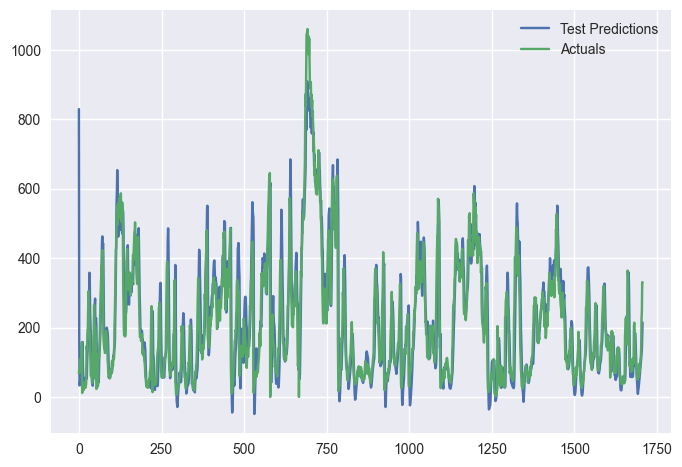

In [10]:
model = load_model('2H_Forecast/2H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(2,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 3 hours forecast

In [30]:
%%time

Trainer(3,6,12,50)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                17920     
                                                                 
 dense_36 (Dense)            (None, 8)                 520       
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 10:43:50.862188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:50.994466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:51.305234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.1508 - mae: 0.8003 - mse: 1.1508 - mape: 268.3663

2023-02-10 10:43:54.608530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:43:54.660286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.76013, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 10s 51ms/step - loss: 1.1508 - mae: 0.8003 - mse: 1.1508 - mape: 268.3663 - val_loss: 0.7601 - val_mae: 0.6978 - val_mse: 0.7601 - val_mape: 140.0375
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.8816 - mae: 0.6566 - mse: 0.8816 - mape: 159.4615
Epoch 2: val_loss improved from 0.76013 to 0.48943, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.8816 - mae: 0.6566 - mse: 0.8816 - mape: 159.4615 - val_loss: 0.4894 - val_mae: 0.5417 - val_mse: 0.4894 - val_mape: 121.9846
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.7716 - mae: 0.5876 - mse: 0.7716 - mape: 191.0573
Epoch 3: val_loss improved from 0.48943 to 0.40141, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.7716 - mae: 0.5876 - mse: 0.7716 - mape: 191.0573 - val_loss: 0.4014 - val_mae: 0.4815 - val_mse: 0.4014 - val_mape: 116.3342
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.7094 - mae: 0.5489 - mse: 0.7094 - mape: 203.0283
Epoch 4: val_loss improved from 0.40141 to 0.38595, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.7094 - mae: 0.5489 - mse: 0.7094 - mape: 203.0283 - val_loss: 0.3859 - val_mae: 0.4666 - val_mse: 0.3859 - val_mape: 119.9782
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.6188 - mae: 0.4850 - mse: 0.6188 - mape: 235.8005
Epoch 5: val_loss improved from 0.38595 to 0.37206, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.6188 - mae: 0.4850 - mse: 0.6188 - mape: 235.8005 - val_loss: 0.3721 - val_mae: 0.4526 - val_mse: 0.3721 - val_mape: 130.0537
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5486 - mae: 0.4124 - mse: 0.5486 - mape: 268.3976
Epoch 6: val_loss did not improve from 0.37206
161/161 [==============================] - 3s 17ms/step - loss: 0.5486 - mae: 0.4124 - mse: 0.5486 - mape: 268.3976 - val_loss: 0.3732 - val_mae: 0.4478 - val_mse: 0.3732 - val_mape: 142.4863
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5193 - mae: 0.3708 - mse: 0.5193 - mape: 284.2808
Epoch 7: val_loss improved from 0.37206 to 0.36284, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.5193 - mae: 0.3708 - mse: 0.5193 - mape: 284.2808 - val_loss: 0.3628 - val_mae: 0.4384 - val_mse: 0.3628 - val_mape: 148.8182
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5040 - mae: 0.3536 - mse: 0.5040 - mape: 291.6194
Epoch 8: val_loss improved from 0.36284 to 0.36150, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5040 - mae: 0.3536 - mse: 0.5040 - mape: 291.6194 - val_loss: 0.3615 - val_mae: 0.4358 - val_mse: 0.3615 - val_mape: 151.9008
Epoch 9/50
158/161 [============================>.] - ETA: 0s - loss: 0.4974 - mae: 0.3452 - mse: 0.4974 - mape: 290.6080
Epoch 9: val_loss improved from 0.36150 to 0.34940, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4935 - mae: 0.3451 - mse: 0.4935 - mape: 288.4897 - val_loss: 0.3494 - val_mae: 0.4271 - val_mse: 0.3494 - val_mape: 152.7915
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4838 - mae: 0.3376 - mse: 0.4838 - mape: 290.8484
Epoch 10: val_loss improved from 0.34940 to 0.34701, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.4838 - mae: 0.3376 - mse: 0.4838 - mape: 290.8484 - val_loss: 0.3470 - val_mae: 0.4246 - val_mse: 0.3470 - val_mape: 152.1160
Epoch 11/50
159/161 [============================>.] - ETA: 0s - loss: 0.4786 - mae: 0.3318 - mse: 0.4786 - mape: 267.6845
Epoch 11: val_loss improved from 0.34701 to 0.34211, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4766 - mae: 0.3315 - mse: 0.4766 - mape: 266.9538 - val_loss: 0.3421 - val_mae: 0.4196 - val_mse: 0.3421 - val_mape: 153.0225
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.4691 - mae: 0.3256 - mse: 0.4691 - mape: 261.1283
Epoch 12: val_loss improved from 0.34211 to 0.33216, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4688 - mae: 0.3255 - mse: 0.4688 - mape: 260.9922 - val_loss: 0.3322 - val_mae: 0.4126 - val_mse: 0.3322 - val_mape: 151.4547
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.4609 - mae: 0.3216 - mse: 0.4609 - mape: 252.8039
Epoch 13: val_loss improved from 0.33216 to 0.32215, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4609 - mae: 0.3216 - mse: 0.4609 - mape: 252.8039 - val_loss: 0.3222 - val_mae: 0.4028 - val_mse: 0.3222 - val_mape: 155.0334
Epoch 14/50
160/161 [============================>.] - ETA: 0s - loss: 0.4546 - mae: 0.3167 - mse: 0.4546 - mape: 243.0995
Epoch 14: val_loss improved from 0.32215 to 0.31095, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4544 - mae: 0.3165 - mse: 0.4544 - mape: 242.9625 - val_loss: 0.3110 - val_mae: 0.3978 - val_mse: 0.3110 - val_mape: 148.4656
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.4471 - mae: 0.3128 - mse: 0.4471 - mape: 228.3055
Epoch 15: val_loss improved from 0.31095 to 0.30615, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4471 - mae: 0.3128 - mse: 0.4471 - mape: 228.3055 - val_loss: 0.3061 - val_mae: 0.3923 - val_mse: 0.3061 - val_mape: 151.5754
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.4408 - mae: 0.3075 - mse: 0.4408 - mape: 214.3201
Epoch 16: val_loss improved from 0.30615 to 0.29468, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4408 - mae: 0.3075 - mse: 0.4408 - mape: 214.3201 - val_loss: 0.2947 - val_mae: 0.3851 - val_mse: 0.2947 - val_mape: 148.1748
Epoch 17/50
159/161 [============================>.] - ETA: 0s - loss: 0.4102 - mae: 0.3042 - mse: 0.4102 - mape: 205.1122
Epoch 17: val_loss improved from 0.29468 to 0.28218, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.4344 - mae: 0.3062 - mse: 0.4344 - mape: 204.5792 - val_loss: 0.2822 - val_mae: 0.3774 - val_mse: 0.2822 - val_mape: 150.1133
Epoch 18/50
159/161 [============================>.] - ETA: 0s - loss: 0.4285 - mae: 0.3043 - mse: 0.4285 - mape: 199.8274
Epoch 18: val_loss did not improve from 0.28218
161/161 [==============================] - 3s 17ms/step - loss: 0.4268 - mae: 0.3044 - mse: 0.4268 - mape: 200.6213 - val_loss: 0.2871 - val_mae: 0.3773 - val_mse: 0.2871 - val_mape: 153.4013
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.4189 - mae: 0.2996 - mse: 0.4189 - mape: 191.4765
Epoch 19: val_loss improved from 0.28218 to 0.27323, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4189 - mae: 0.2997 - mse: 0.4189 - mape: 191.5438 - val_loss: 0.2732 - val_mae: 0.3676 - val_mse: 0.2732 - val_mape: 152.7791
Epoch 20/50
159/161 [============================>.] - ETA: 0s - loss: 0.4136 - mae: 0.2966 - mse: 0.4136 - mape: 189.9279
Epoch 20: val_loss improved from 0.27323 to 0.27209, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4118 - mae: 0.2965 - mse: 0.4118 - mape: 189.5009 - val_loss: 0.2721 - val_mae: 0.3640 - val_mse: 0.2721 - val_mape: 156.0844
Epoch 21/50
161/161 [==============================] - ETA: 0s - loss: 0.4068 - mae: 0.2937 - mse: 0.4068 - mape: 188.6693
Epoch 21: val_loss improved from 0.27209 to 0.27017, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4068 - mae: 0.2937 - mse: 0.4068 - mape: 188.6693 - val_loss: 0.2702 - val_mae: 0.3647 - val_mse: 0.2702 - val_mape: 154.0828
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.3993 - mae: 0.2905 - mse: 0.3993 - mape: 168.6470
Epoch 22: val_loss improved from 0.27017 to 0.26058, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3993 - mae: 0.2905 - mse: 0.3993 - mape: 168.6470 - val_loss: 0.2606 - val_mae: 0.3612 - val_mse: 0.2606 - val_mape: 153.2628
Epoch 23/50
159/161 [============================>.] - ETA: 0s - loss: 0.3944 - mae: 0.2887 - mse: 0.3944 - mape: 164.5911
Epoch 23: val_loss improved from 0.26058 to 0.25385, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3924 - mae: 0.2882 - mse: 0.3924 - mape: 163.6983 - val_loss: 0.2538 - val_mae: 0.3564 - val_mse: 0.2538 - val_mape: 158.5876
Epoch 24/50
158/161 [============================>.] - ETA: 0s - loss: 0.3897 - mae: 0.2856 - mse: 0.3897 - mape: 174.8502
Epoch 24: val_loss improved from 0.25385 to 0.25187, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3861 - mae: 0.2853 - mse: 0.3861 - mape: 173.2345 - val_loss: 0.2519 - val_mae: 0.3538 - val_mse: 0.2519 - val_mape: 159.6380
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.3812 - mae: 0.2834 - mse: 0.3812 - mape: 148.0794
Epoch 25: val_loss did not improve from 0.25187
161/161 [==============================] - 3s 18ms/step - loss: 0.3812 - mae: 0.2834 - mse: 0.3812 - mape: 148.0794 - val_loss: 0.2542 - val_mae: 0.3589 - val_mse: 0.2542 - val_mape: 158.4164
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.3749 - mae: 0.2809 - mse: 0.3749 - mape: 152.8966
Epoch 26: val_loss did not improve from 0.25187
161/161 [==============================] - 3s 18ms/step - loss: 0.3749 - mae: 0.2809 - mse: 0.3749 - mape: 152.8966 - val_loss: 0.2523 - val_mae: 0.3569 - val_mse: 0.2523 - val_mape: 158.0291
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.3692 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3677 - mae: 0.2785 - mse: 0.3677 - mape: 145.4272 - val_loss: 0.2460 - val_mae: 0.3573 - val_mse: 0.2460 - val_mape: 159.3850
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.3641 - mae: 0.2759 - mse: 0.3641 - mape: 144.8487
Epoch 28: val_loss improved from 0.24598 to 0.24489, saving model to 3H_Forecast/3H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3639 - mae: 0.2758 - mse: 0.3639 - mape: 144.7786 - val_loss: 0.2449 - val_mae: 0.3561 - val_mse: 0.2449 - val_mape: 160.8734
Epoch 29/50
161/161 [==============================] - ETA: 0s - loss: 0.3591 - mae: 0.2738 - mse: 0.3591 - mape: 144.7380
Epoch 29: val_loss did not improve from 0.24489
161/161 [==============================] - 3s 19ms/step - loss: 0.3591 - mae: 0.2738 - mse: 0.3591 - mape: 144.7380 - val_loss: 0.2489 - val_mae: 0.3601 - val_mse: 0.2489 - val_mape: 162.3255
Epoch 30/50
160/161 [============================>.] - ETA: 0s - loss: 0.3541 - mae: 0.2735 - mse: 0.3541 - mape: 145.6311
Epoch 30: val_loss did not improve from 0.24489
161/161 [==============================] - 3s 18ms/step - loss: 0.3539 - mae: 0.2734 - mse: 0.3539 - mape: 145.5552 - val_loss: 0.2456 - val_mae: 0.3534 - val_mse: 0.2456 - val_mape: 170.1446
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.3490 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3456 - mae: 0.2697 - mse: 0.3456 - mape: 154.4710 - val_loss: 0.2441 - val_mae: 0.3578 - val_mse: 0.2441 - val_mape: 168.0666
Epoch 33/50
160/161 [============================>.] - ETA: 0s - loss: 0.3396 - mae: 0.2682 - mse: 0.3396 - mape: 148.3822
Epoch 33: val_loss did not improve from 0.24409
161/161 [==============================] - 3s 18ms/step - loss: 0.3396 - mae: 0.2683 - mse: 0.3396 - mape: 148.3330 - val_loss: 0.2542 - val_mae: 0.3649 - val_mse: 0.2542 - val_mape: 164.1978
Epoch 34/50
158/161 [============================>.] - ETA: 0s - loss: 0.3386 - mae: 0.2692 - mse: 0.3386 - mape: 155.8090
Epoch 34: val_loss did not improve from 0.24409
161/161 [==============================] - 3s 19ms/step - loss: 0.3354 - mae: 0.2685 - mse: 0.3354 - mape: 155.3271 - val_loss: 0.2526 - val_mae: 0.3643 - val_mse: 0.2526 - val_mape: 167.4134
Epoch 35/50
159/161 [============================>.] - ETA: 0s - loss: 0.3358 - ma

2023-02-10 10:48:00.595104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:48:00.739709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


  1/161 [..............................] - ETA: 3:41 - loss: 1.1675 - mae: 0.9045 - mse: 1.1675 - mape: 111.0807

2023-02-10 10:48:01.046436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8713 - mae: 0.6170 - mse: 0.8713 - mape: 118.7224

2023-02-10 10:48:04.428912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:48:04.484008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.70516, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 10s 53ms/step - loss: 0.8713 - mae: 0.6170 - mse: 0.8713 - mape: 118.7224 - val_loss: 0.7052 - val_mae: 0.6419 - val_mse: 0.7052 - val_mape: 139.1312
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6295 - mae: 0.4411 - mse: 0.6295 - mape: 183.3426
Epoch 2: val_loss improved from 0.70516 to 0.47768, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.6295 - mae: 0.4411 - mse: 0.6295 - mape: 183.3426 - val_loss: 0.4777 - val_mae: 0.5095 - val_mse: 0.4777 - val_mape: 141.9525
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5534 - mae: 0.3790 - mse: 0.5534 - mape: 259.6193
Epoch 3: val_loss improved from 0.47768 to 0.40305, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.5534 - mae: 0.3790 - mse: 0.5534 - mape: 259.6193 - val_loss: 0.4030 - val_mae: 0.4613 - val_mse: 0.4030 - val_mape: 143.1822
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5343 - mae: 0.3640 - mse: 0.5343 - mape: 311.9898
Epoch 4: val_loss improved from 0.40305 to 0.38537, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5343 - mae: 0.3640 - mse: 0.5343 - mape: 311.9898 - val_loss: 0.3854 - val_mae: 0.4515 - val_mse: 0.3854 - val_mape: 146.9583
Epoch 5/50
160/161 [============================>.] - ETA: 0s - loss: 0.5247 - mae: 0.3539 - mse: 0.5247 - mape: 316.9787
Epoch 5: val_loss improved from 0.38537 to 0.37432, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5245 - mae: 0.3538 - mse: 0.5245 - mape: 316.8738 - val_loss: 0.3743 - val_mae: 0.4458 - val_mse: 0.3743 - val_mape: 147.1345
Epoch 6/50
159/161 [============================>.] - ETA: 0s - loss: 0.5150 - mae: 0.3447 - mse: 0.5150 - mape: 307.3104
Epoch 6: val_loss improved from 0.37432 to 0.36875, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.5164 - mae: 0.3464 - mse: 0.5164 - mape: 306.1893 - val_loss: 0.3688 - val_mae: 0.4411 - val_mse: 0.3688 - val_mape: 144.8133
Epoch 7/50
160/161 [============================>.] - ETA: 0s - loss: 0.5098 - mae: 0.3435 - mse: 0.5098 - mape: 296.0331
Epoch 7: val_loss improved from 0.36875 to 0.35569, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5098 - mae: 0.3436 - mse: 0.5098 - mape: 295.9922 - val_loss: 0.3557 - val_mae: 0.4310 - val_mse: 0.3557 - val_mape: 145.7450
Epoch 8/50
160/161 [============================>.] - ETA: 0s - loss: 0.5039 - mae: 0.3391 - mse: 0.5039 - mape: 291.6402
Epoch 8: val_loss improved from 0.35569 to 0.35493, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.5037 - mae: 0.3390 - mse: 0.5037 - mape: 291.5539 - val_loss: 0.3549 - val_mae: 0.4295 - val_mse: 0.3549 - val_mape: 146.1530
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4974 - mae: 0.3350 - mse: 0.4974 - mape: 286.5587
Epoch 9: val_loss improved from 0.35493 to 0.34724, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4974 - mae: 0.3350 - mse: 0.4974 - mape: 286.5587 - val_loss: 0.3472 - val_mae: 0.4224 - val_mse: 0.3472 - val_mape: 145.4837
Epoch 10/50
159/161 [============================>.] - ETA: 0s - loss: 0.4941 - mae: 0.3309 - mse: 0.4941 - mape: 286.4107
Epoch 10: val_loss improved from 0.34724 to 0.34384, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4917 - mae: 0.3304 - mse: 0.4917 - mape: 284.9662 - val_loss: 0.3438 - val_mae: 0.4206 - val_mse: 0.3438 - val_mape: 139.9114
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.4859 - mae: 0.3280 - mse: 0.4859 - mape: 270.9083
Epoch 11: val_loss improved from 0.34384 to 0.32472, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4857 - mae: 0.3279 - mse: 0.4857 - mape: 270.8054 - val_loss: 0.3247 - val_mae: 0.4045 - val_mse: 0.3247 - val_mape: 143.5317
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.4796 - mae: 0.3238 - mse: 0.4796 - mape: 263.5501
Epoch 12: val_loss improved from 0.32472 to 0.31463, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4796 - mae: 0.3238 - mse: 0.4796 - mape: 263.5501 - val_loss: 0.3146 - val_mae: 0.3962 - val_mse: 0.3146 - val_mape: 143.2543
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.4737 - mae: 0.3208 - mse: 0.4737 - mape: 266.0275
Epoch 13: val_loss did not improve from 0.31463
161/161 [==============================] - 3s 21ms/step - loss: 0.4737 - mae: 0.3208 - mse: 0.4737 - mape: 266.0275 - val_loss: 0.3208 - val_mae: 0.3983 - val_mse: 0.3208 - val_mape: 141.4948
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4681 - mae: 0.3160 - mse: 0.4681 - mape: 248.8064
Epoch 14: val_loss improved from 0.31463 to 0.30012, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4681 - mae: 0.3160 - mse: 0.4681 - mape: 248.8064 - val_loss: 0.3001 - val_mae: 0.3830 - val_mse: 0.3001 - val_mape: 144.3147
Epoch 15/50
160/161 [============================>.] - ETA: 0s - loss: 0.4607 - mae: 0.3123 - mse: 0.4607 - mape: 249.2579
Epoch 15: val_loss improved from 0.30012 to 0.29353, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 6s 40ms/step - loss: 0.4606 - mae: 0.3124 - mse: 0.4606 - mape: 249.9570 - val_loss: 0.2935 - val_mae: 0.3781 - val_mse: 0.2935 - val_mape: 140.5800
Epoch 16/50
158/161 [============================>.] - ETA: 0s - loss: 0.4587 - mae: 0.3058 - mse: 0.4587 - mape: 241.6820
Epoch 16: val_loss improved from 0.29353 to 0.28635, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4553 - mae: 0.3060 - mse: 0.4553 - mape: 239.6001 - val_loss: 0.2864 - val_mae: 0.3701 - val_mse: 0.2864 - val_mape: 137.7950
Epoch 17/50
159/161 [============================>.] - ETA: 0s - loss: 0.4494 - mae: 0.3039 - mse: 0.4494 - mape: 227.0372
Epoch 17: val_loss improved from 0.28635 to 0.27663, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4485 - mae: 0.3039 - mse: 0.4485 - mape: 226.4529 - val_loss: 0.2766 - val_mae: 0.3607 - val_mse: 0.2766 - val_mape: 137.3493
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.4422 - mae: 0.2983 - mse: 0.4422 - mape: 209.7708
Epoch 18: val_loss improved from 0.27663 to 0.26677, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4423 - mae: 0.2985 - mse: 0.4423 - mape: 209.7187 - val_loss: 0.2668 - val_mae: 0.3543 - val_mse: 0.2668 - val_mape: 132.5447
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.4346 - mae: 0.2947 - mse: 0.4346 - mape: 219.8636
Epoch 19: val_loss improved from 0.26677 to 0.26193, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.4346 - mae: 0.2947 - mse: 0.4346 - mape: 219.8636 - val_loss: 0.2619 - val_mae: 0.3479 - val_mse: 0.2619 - val_mape: 130.8423
Epoch 20/50
159/161 [============================>.] - ETA: 0s - loss: 0.4311 - mae: 0.2919 - mse: 0.4311 - mape: 213.6649
Epoch 20: val_loss improved from 0.26193 to 0.25336, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4288 - mae: 0.2911 - mse: 0.4288 - mape: 212.5694 - val_loss: 0.2534 - val_mae: 0.3411 - val_mse: 0.2534 - val_mape: 137.7649
Epoch 21/50
161/161 [==============================] - ETA: 0s - loss: 0.4227 - mae: 0.2876 - mse: 0.4227 - mape: 199.7372
Epoch 21: val_loss improved from 0.25336 to 0.24351, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4227 - mae: 0.2876 - mse: 0.4227 - mape: 199.7372 - val_loss: 0.2435 - val_mae: 0.3353 - val_mse: 0.2435 - val_mape: 138.1855
Epoch 22/50
159/161 [============================>.] - ETA: 0s - loss: 0.4186 - mae: 0.2825 - mse: 0.4186 - mape: 196.9634
Epoch 22: val_loss did not improve from 0.24351
161/161 [==============================] - 3s 17ms/step - loss: 0.4172 - mae: 0.2825 - mse: 0.4172 - mape: 196.5121 - val_loss: 0.2457 - val_mae: 0.3370 - val_mse: 0.2457 - val_mape: 132.2993
Epoch 23/50
160/161 [============================>.] - ETA: 0s - loss: 0.4120 - mae: 0.2817 - mse: 0.4120 - mape: 182.4995
Epoch 23: val_loss improved from 0.24351 to 0.24268, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.4118 - mae: 0.2816 - mse: 0.4118 - mape: 182.4334 - val_loss: 0.2427 - val_mae: 0.3341 - val_mse: 0.2427 - val_mape: 138.8613
Epoch 24/50
158/161 [============================>.] - ETA: 0s - loss: 0.4089 - mae: 0.2775 - mse: 0.4089 - mape: 138.5188
Epoch 24: val_loss improved from 0.24268 to 0.22995, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4068 - mae: 0.2780 - mse: 0.4068 - mape: 170.3739 - val_loss: 0.2300 - val_mae: 0.3257 - val_mse: 0.2300 - val_mape: 138.7662
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.4019 - mae: 0.2745 - mse: 0.4019 - mape: 168.6181
Epoch 25: val_loss did not improve from 0.22995
161/161 [==============================] - 3s 18ms/step - loss: 0.4019 - mae: 0.2745 - mse: 0.4019 - mape: 168.6181 - val_loss: 0.2347 - val_mae: 0.3286 - val_mse: 0.2347 - val_mape: 137.5661
Epoch 26/50
158/161 [============================>.] - ETA: 0s - loss: 0.4016 - mae: 0.2748 - mse: 0.4016 - mape: 161.1966
Epoch 26: val_loss improved from 0.22995 to 0.22881, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.3974 - mae: 0.2737 - mse: 0.3974 - mape: 159.8605 - val_loss: 0.2288 - val_mae: 0.3243 - val_mse: 0.2288 - val_mape: 146.5860
Epoch 27/50
159/161 [============================>.] - ETA: 0s - loss: 0.3951 - mae: 0.2712 - mse: 0.3951 - mape: 164.5576
Epoch 27: val_loss improved from 0.22881 to 0.22461, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3932 - mae: 0.2710 - mse: 0.3932 - mape: 164.0550 - val_loss: 0.2246 - val_mae: 0.3215 - val_mse: 0.2246 - val_mape: 144.0811
Epoch 28/50
159/161 [============================>.] - ETA: 0s - loss: 0.3918 - mae: 0.2697 - mse: 0.3918 - mape: 158.5570
Epoch 28: val_loss improved from 0.22461 to 0.21337, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3901 - mae: 0.2696 - mse: 0.3901 - mape: 158.1956 - val_loss: 0.2134 - val_mae: 0.3151 - val_mse: 0.2134 - val_mape: 143.2349
Epoch 29/50
161/161 [==============================] - ETA: 0s - loss: 0.3844 - mae: 0.2678 - mse: 0.3844 - mape: 154.4144
Epoch 29: val_loss did not improve from 0.21337
161/161 [==============================] - 3s 17ms/step - loss: 0.3844 - mae: 0.2678 - mse: 0.3844 - mape: 154.4144 - val_loss: 0.2138 - val_mae: 0.3158 - val_mse: 0.2138 - val_mape: 147.1508
Epoch 30/50
160/161 [============================>.] - ETA: 0s - loss: 0.3803 - mae: 0.2675 - mse: 0.3803 - mape: 146.5615
Epoch 30: val_loss did not improve from 0.21337
161/161 [==============================] - 3s 17ms/step - loss: 0.3801 - mae: 0.2674 - mse: 0.3801 - mape: 146.5068 - val_loss: 0.2169 - val_mae: 0.3178 - val_mse: 0.2169 - val_mape: 148.0372
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.3760 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3723 - mae: 0.2650 - mse: 0.3723 - mape: 148.7032 - val_loss: 0.2107 - val_mae: 0.3137 - val_mse: 0.2107 - val_mape: 153.2520
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3677 - mae: 0.2655 - mse: 0.3677 - mape: 151.7182
Epoch 33: val_loss improved from 0.21072 to 0.20882, saving model to 3H_Forecast/3H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3677 - mae: 0.2655 - mse: 0.3677 - mape: 151.7182 - val_loss: 0.2088 - val_mae: 0.3121 - val_mse: 0.2088 - val_mape: 147.0882
Epoch 34/50
160/161 [============================>.] - ETA: 0s - loss: 0.3650 - mae: 0.2629 - mse: 0.3650 - mape: 145.3305
Epoch 34: val_loss did not improve from 0.20882
161/161 [==============================] - 3s 18ms/step - loss: 0.3652 - mae: 0.2631 - mse: 0.3652 - mape: 145.3382 - val_loss: 0.2134 - val_mae: 0.3139 - val_mse: 0.2134 - val_mape: 151.1177
Epoch 35/50
159/161 [============================>.] - ETA: 0s - loss: 0.3615 - mae: 0.2626 - mse: 0.3615 - mape: 145.2272
Epoch 35: val_loss did not improve from 0.20882
161/161 [==============================] - 3s 17ms/step - loss: 0.3606 - mae: 0.2626 - mse: 0.3606 - mape: 144.6997 - val_loss: 0.2145 - val_mae: 0.3152 - val_mse: 0.2145 - val_mape: 149.5749
Epoch 36/50
159/161 [============================>.] - ETA: 0s - loss: 0.3579 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3302 - mae: 0.2560 - mse: 0.3302 - mape: 133.5769 - val_loss: 0.2073 - val_mae: 0.3112 - val_mse: 0.2073 - val_mape: 149.3523
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.3266 - mae: 0.2570 - mse: 0.3266 - mape: 141.7225
Epoch 44: val_loss did not improve from 0.20726
161/161 [==============================] - 4s 22ms/step - loss: 0.3266 - mae: 0.2570 - mse: 0.3266 - mape: 141.7225 - val_loss: 0.2115 - val_mae: 0.3124 - val_mse: 0.2115 - val_mape: 153.0157
Epoch 45/50
158/161 [============================>.] - ETA: 0s - loss: 0.3271 - mae: 0.2533 - mse: 0.3271 - mape: 143.9435
Epoch 45: val_loss did not improve from 0.20726
161/161 [==============================] - 3s 20ms/step - loss: 0.3239 - mae: 0.2527 - mse: 0.3239 - mape: 143.0258 - val_loss: 0.2195 - val_mae: 0.3155 - val_mse: 0.2195 - val_mape: 146.4217
Epoch 46/50
159/161 [============================>.] - ETA: 0s - loss: 0.3222 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3110 - mae: 0.2527 - mse: 0.3110 - mape: 131.1974 - val_loss: 0.2065 - val_mae: 0.3070 - val_mse: 0.2065 - val_mape: 152.9939
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.3083 - mae: 0.2525 - mse: 0.3083 - mape: 135.8170
Epoch 50: val_loss did not improve from 0.20653
161/161 [==============================] - 3s 19ms/step - loss: 0.3083 - mae: 0.2525 - mse: 0.3083 - mape: 135.8170 - val_loss: 0.2110 - val_mae: 0.3092 - val_mse: 0.2110 - val_mape: 151.5243

-----------------------------------------------------------------------------------------------------------

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                17920     
                                                                 
 dense_40 (Dense)            (None, 8)          

2023-02-10 10:52:29.046311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:29.206836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:29.697737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9314 - mae: 0.6060 - mse: 0.9314 - mape: 170.1845

2023-02-10 10:52:33.726975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:52:33.780426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.93843, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 11s 59ms/step - loss: 0.9314 - mae: 0.6060 - mse: 0.9314 - mape: 170.1845 - val_loss: 0.9384 - val_mae: 0.7373 - val_mse: 0.9384 - val_mape: 123.5755
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.8067 - mae: 0.5056 - mse: 0.8067 - mape: 190.9973
Epoch 2: val_loss improved from 0.93843 to 0.83590, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.8067 - mae: 0.5056 - mse: 0.8067 - mape: 190.9973 - val_loss: 0.8359 - val_mae: 0.6777 - val_mse: 0.8359 - val_mape: 111.5875
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.7434 - mae: 0.4654 - mse: 0.7434 - mape: 233.8426
Epoch 3: val_loss improved from 0.83590 to 0.70638, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.7434 - mae: 0.4654 - mse: 0.7434 - mape: 233.8426 - val_loss: 0.7064 - val_mae: 0.6130 - val_mse: 0.7064 - val_mape: 115.1367
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6618 - mae: 0.4237 - mse: 0.6618 - mape: 268.4913
Epoch 4: val_loss improved from 0.70638 to 0.54021, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.6618 - mae: 0.4237 - mse: 0.6618 - mape: 268.4913 - val_loss: 0.5402 - val_mae: 0.5300 - val_mse: 0.5402 - val_mape: 130.7679
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5935 - mae: 0.3817 - mse: 0.5935 - mape: 309.8347
Epoch 5: val_loss improved from 0.54021 to 0.41013, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.5935 - mae: 0.3817 - mse: 0.5935 - mape: 309.8347 - val_loss: 0.4101 - val_mae: 0.4558 - val_mse: 0.4101 - val_mape: 136.4210
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5571 - mae: 0.3601 - mse: 0.5571 - mape: 316.7553
Epoch 6: val_loss improved from 0.41013 to 0.35006, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5571 - mae: 0.3601 - mse: 0.5571 - mape: 316.7553 - val_loss: 0.3501 - val_mae: 0.4174 - val_mse: 0.3501 - val_mape: 131.4670
Epoch 7/50
159/161 [============================>.] - ETA: 0s - loss: 0.5321 - mae: 0.3391 - mse: 0.5321 - mape: 287.2339
Epoch 7: val_loss improved from 0.35006 to 0.30740, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.5304 - mae: 0.3394 - mse: 0.5304 - mape: 286.2946 - val_loss: 0.3074 - val_mae: 0.3868 - val_mse: 0.3074 - val_mape: 126.3680
Epoch 8/50
160/161 [============================>.] - ETA: 0s - loss: 0.5066 - mae: 0.3207 - mse: 0.5066 - mape: 246.2711
Epoch 8: val_loss improved from 0.30740 to 0.27429, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5065 - mae: 0.3206 - mse: 0.5065 - mape: 246.2242 - val_loss: 0.2743 - val_mae: 0.3632 - val_mse: 0.2743 - val_mape: 126.1909
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.4912 - mae: 0.3115 - mse: 0.4912 - mape: 240.3630
Epoch 9: val_loss improved from 0.27429 to 0.25287, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4912 - mae: 0.3115 - mse: 0.4912 - mape: 240.3630 - val_loss: 0.2529 - val_mae: 0.3492 - val_mse: 0.2529 - val_mape: 123.4554
Epoch 10/50
160/161 [============================>.] - ETA: 0s - loss: 0.4797 - mae: 0.3022 - mse: 0.4797 - mape: 228.5246
Epoch 10: val_loss improved from 0.25287 to 0.23621, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4797 - mae: 0.3022 - mse: 0.4797 - mape: 228.4927 - val_loss: 0.2362 - val_mae: 0.3367 - val_mse: 0.2362 - val_mape: 128.7199
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.4707 - mae: 0.2944 - mse: 0.4707 - mape: 225.0027
Epoch 11: val_loss did not improve from 0.23621
161/161 [==============================] - 4s 26ms/step - loss: 0.4707 - mae: 0.2945 - mse: 0.4707 - mape: 224.9719 - val_loss: 0.2390 - val_mae: 0.3453 - val_mse: 0.2390 - val_mape: 125.5000
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.4643 - mae: 0.2904 - mse: 0.4643 - mape: 227.5518
Epoch 12: val_loss improved from 0.23621 to 0.21711, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 53ms/step - loss: 0.4643 - mae: 0.2904 - mse: 0.4643 - mape: 227.5518 - val_loss: 0.2171 - val_mae: 0.3246 - val_mse: 0.2171 - val_mape: 125.8793
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.4576 - mae: 0.2893 - mse: 0.4576 - mape: 211.1392
Epoch 13: val_loss did not improve from 0.21711
161/161 [==============================] - 4s 26ms/step - loss: 0.4576 - mae: 0.2893 - mse: 0.4576 - mape: 211.1392 - val_loss: 0.2294 - val_mae: 0.3362 - val_mse: 0.2294 - val_mape: 127.5426
Epoch 14/50
159/161 [============================>.] - ETA: 0s - loss: 0.4560 - mae: 0.2844 - mse: 0.4560 - mape: 201.9292
Epoch 14: val_loss did not improve from 0.21711
161/161 [==============================] - 4s 23ms/step - loss: 0.4538 - mae: 0.2839 - mse: 0.4538 - mape: 200.9483 - val_loss: 0.2199 - val_mae: 0.3291 - val_mse: 0.2199 - val_mape: 129.7282
Epoch 15/50
160/161 [============================>.] - ETA: 0s - loss: 0.4500 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.4456 - mae: 0.2791 - mse: 0.4456 - mape: 196.2716 - val_loss: 0.2024 - val_mae: 0.3131 - val_mse: 0.2024 - val_mape: 130.0528
Epoch 17/50
158/161 [============================>.] - ETA: 0s - loss: 0.4449 - mae: 0.2785 - mse: 0.4449 - mape: 185.4042
Epoch 17: val_loss improved from 0.20242 to 0.19527, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4418 - mae: 0.2787 - mse: 0.4418 - mape: 185.6259 - val_loss: 0.1953 - val_mae: 0.3078 - val_mse: 0.1953 - val_mape: 132.3736
Epoch 18/50
158/161 [============================>.] - ETA: 0s - loss: 0.4421 - mae: 0.2753 - mse: 0.4421 - mape: 181.6106
Epoch 18: val_loss did not improve from 0.19527
161/161 [==============================] - 3s 19ms/step - loss: 0.4385 - mae: 0.2754 - mse: 0.4385 - mape: 181.1046 - val_loss: 0.2139 - val_mae: 0.3241 - val_mse: 0.2139 - val_mape: 131.4449
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.4354 - mae: 0.2766 - mse: 0.4354 - mape: 180.2563
Epoch 19: val_loss did not improve from 0.19527
161/161 [==============================] - 3s 18ms/step - loss: 0.4354 - mae: 0.2766 - mse: 0.4354 - mape: 180.2563 - val_loss: 0.1976 - val_mae: 0.3081 - val_mse: 0.1976 - val_mape: 137.3432
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.4323 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4111 - mae: 0.2689 - mse: 0.4111 - mape: 163.0357 - val_loss: 0.1935 - val_mae: 0.3029 - val_mse: 0.1935 - val_mape: 136.2755
Epoch 28/50
158/161 [============================>.] - ETA: 0s - loss: 0.4102 - mae: 0.2637 - mse: 0.4102 - mape: 158.8548
Epoch 28: val_loss did not improve from 0.19349
161/161 [==============================] - 3s 19ms/step - loss: 0.4064 - mae: 0.2635 - mse: 0.4064 - mape: 157.6898 - val_loss: 0.2019 - val_mae: 0.3080 - val_mse: 0.2019 - val_mape: 139.0769
Epoch 29/50
158/161 [============================>.] - ETA: 0s - loss: 0.4086 - mae: 0.2632 - mse: 0.4086 - mape: 138.3768
Epoch 29: val_loss improved from 0.19349 to 0.19120, saving model to 3H_Forecast/3H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4057 - mae: 0.2633 - mse: 0.4057 - mape: 139.9081 - val_loss: 0.1912 - val_mae: 0.2995 - val_mse: 0.1912 - val_mape: 139.7200
Epoch 30/50
158/161 [============================>.] - ETA: 0s - loss: 0.4054 - mae: 0.2623 - mse: 0.4054 - mape: 159.6886
Epoch 30: val_loss did not improve from 0.19120
161/161 [==============================] - 3s 18ms/step - loss: 0.4013 - mae: 0.2616 - mse: 0.4013 - mape: 158.9671 - val_loss: 0.1930 - val_mae: 0.3015 - val_mse: 0.1930 - val_mape: 136.7427
Epoch 31/50
160/161 [============================>.] - ETA: 0s - loss: 0.3983 - mae: 0.2608 - mse: 0.3983 - mape: 147.1109
Epoch 31: val_loss did not improve from 0.19120
161/161 [==============================] - 3s 18ms/step - loss: 0.3983 - mae: 0.2608 - mse: 0.3983 - mape: 147.0991 - val_loss: 0.1965 - val_mae: 0.3020 - val_mse: 0.1965 - val_mape: 138.9529
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.3955 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3955 - mae: 0.2596 - mse: 0.3955 - mape: 150.1659 - val_loss: 0.1893 - val_mae: 0.2977 - val_mse: 0.1893 - val_mape: 139.4455
Epoch 33/50
159/161 [============================>.] - ETA: 0s - loss: 0.3945 - mae: 0.2594 - mse: 0.3945 - mape: 153.2102
Epoch 33: val_loss did not improve from 0.18934
161/161 [==============================] - 3s 19ms/step - loss: 0.3927 - mae: 0.2591 - mse: 0.3927 - mape: 152.8884 - val_loss: 0.1917 - val_mae: 0.2984 - val_mse: 0.1917 - val_mape: 143.6733
Epoch 34/50
159/161 [============================>.] - ETA: 0s - loss: 0.3910 - mae: 0.2569 - mse: 0.3910 - mape: 144.5830
Epoch 34: val_loss did not improve from 0.18934
161/161 [==============================] - 4s 23ms/step - loss: 0.3891 - mae: 0.2567 - mse: 0.3891 - mape: 144.2946 - val_loss: 0.1928 - val_mae: 0.2987 - val_mse: 0.1928 - val_mape: 142.4368
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.3874 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.3804 - mae: 0.2528 - mse: 0.3804 - mape: 136.6375 - val_loss: 0.1831 - val_mae: 0.2962 - val_mse: 0.1831 - val_mape: 140.2635
Epoch 38/50
160/161 [============================>.] - ETA: 0s - loss: 0.3793 - mae: 0.2536 - mse: 0.3793 - mape: 142.8815
Epoch 38: val_loss did not improve from 0.18311
161/161 [==============================] - 3s 19ms/step - loss: 0.3792 - mae: 0.2536 - mse: 0.3792 - mape: 142.8559 - val_loss: 0.1920 - val_mae: 0.2965 - val_mse: 0.1920 - val_mape: 145.1768
Epoch 39/50
161/161 [==============================] - ETA: 0s - loss: 0.3755 - mae: 0.2517 - mse: 0.3755 - mape: 135.4843
Epoch 39: val_loss did not improve from 0.18311
161/161 [==============================] - 3s 18ms/step - loss: 0.3755 - mae: 0.2517 - mse: 0.3755 - mape: 135.4843 - val_loss: 0.1894 - val_mae: 0.2968 - val_mse: 0.1894 - val_mape: 144.2708
Epoch 40/50
161/161 [==============================] - ETA: 0s - loss: 0.3738 - ma

2023-02-10 10:56:27.573928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:56:27.719300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:56:28.113179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8698 - mae: 0.5995 - mse: 0.8698 - mape: 114.7090

2023-02-10 10:56:31.908243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 10:56:31.959959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.64872, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 11s 59ms/step - loss: 0.8698 - mae: 0.5995 - mse: 0.8698 - mape: 114.7090 - val_loss: 0.6487 - val_mae: 0.6182 - val_mse: 0.6487 - val_mape: 124.3337
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6422 - mae: 0.4359 - mse: 0.6422 - mape: 203.7581
Epoch 2: val_loss improved from 0.64872 to 0.40892, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6422 - mae: 0.4359 - mse: 0.6422 - mape: 203.7581 - val_loss: 0.4089 - val_mae: 0.4720 - val_mse: 0.4089 - val_mape: 145.1323
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5686 - mae: 0.3805 - mse: 0.5686 - mape: 272.6057
Epoch 3: val_loss improved from 0.40892 to 0.34219, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5686 - mae: 0.3805 - mse: 0.5686 - mape: 272.6057 - val_loss: 0.3422 - val_mae: 0.4200 - val_mse: 0.3422 - val_mape: 160.1006
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5454 - mae: 0.3624 - mse: 0.5454 - mape: 302.3615
Epoch 4: val_loss improved from 0.34219 to 0.32440, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.5454 - mae: 0.3624 - mse: 0.5454 - mape: 302.3615 - val_loss: 0.3244 - val_mae: 0.4064 - val_mse: 0.3244 - val_mape: 160.5722
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5302 - mae: 0.3527 - mse: 0.5302 - mape: 295.2750
Epoch 5: val_loss improved from 0.32440 to 0.31118, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.5302 - mae: 0.3527 - mse: 0.5302 - mape: 295.2750 - val_loss: 0.3112 - val_mae: 0.3962 - val_mse: 0.3112 - val_mape: 159.8144
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5170 - mae: 0.3443 - mse: 0.5170 - mape: 279.6066
Epoch 6: val_loss improved from 0.31118 to 0.30218, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5170 - mae: 0.3443 - mse: 0.5170 - mape: 279.6066 - val_loss: 0.3022 - val_mae: 0.3882 - val_mse: 0.3022 - val_mape: 161.3311
Epoch 7/50
159/161 [============================>.] - ETA: 0s - loss: 0.5070 - mae: 0.3348 - mse: 0.5070 - mape: 278.7289
Epoch 7: val_loss improved from 0.30218 to 0.29276, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5054 - mae: 0.3349 - mse: 0.5054 - mape: 277.5780 - val_loss: 0.2928 - val_mae: 0.3802 - val_mse: 0.2928 - val_mape: 160.8491
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4948 - mae: 0.3257 - mse: 0.4948 - mape: 268.9401
Epoch 8: val_loss improved from 0.29276 to 0.28863, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4948 - mae: 0.3257 - mse: 0.4948 - mape: 268.9401 - val_loss: 0.2886 - val_mae: 0.3783 - val_mse: 0.2886 - val_mape: 158.0318
Epoch 9/50
158/161 [============================>.] - ETA: 0s - loss: 0.4891 - mae: 0.3196 - mse: 0.4891 - mape: 258.5078
Epoch 9: val_loss improved from 0.28863 to 0.27602, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4850 - mae: 0.3191 - mse: 0.4850 - mape: 256.0898 - val_loss: 0.2760 - val_mae: 0.3686 - val_mse: 0.2760 - val_mape: 160.9634
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4741 - mae: 0.3119 - mse: 0.4741 - mape: 245.4297
Epoch 10: val_loss improved from 0.27602 to 0.26268, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4741 - mae: 0.3119 - mse: 0.4741 - mape: 245.4297 - val_loss: 0.2627 - val_mae: 0.3586 - val_mse: 0.2627 - val_mape: 161.1824
Epoch 11/50
160/161 [============================>.] - ETA: 0s - loss: 0.4650 - mae: 0.3040 - mse: 0.4650 - mape: 230.7971
Epoch 11: val_loss improved from 0.26268 to 0.25516, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4649 - mae: 0.3040 - mse: 0.4649 - mape: 230.7528 - val_loss: 0.2552 - val_mae: 0.3516 - val_mse: 0.2552 - val_mape: 163.1581
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.4546 - mae: 0.2961 - mse: 0.4546 - mape: 232.6917
Epoch 12: val_loss improved from 0.25516 to 0.25227, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4546 - mae: 0.2961 - mse: 0.4546 - mape: 232.6917 - val_loss: 0.2523 - val_mae: 0.3497 - val_mse: 0.2523 - val_mape: 163.1714
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.4476 - mae: 0.2922 - mse: 0.4476 - mape: 212.4082
Epoch 13: val_loss improved from 0.25227 to 0.24381, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4476 - mae: 0.2922 - mse: 0.4476 - mape: 212.4082 - val_loss: 0.2438 - val_mae: 0.3421 - val_mse: 0.2438 - val_mape: 164.5189
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4409 - mae: 0.2888 - mse: 0.4409 - mape: 213.5089
Epoch 14: val_loss did not improve from 0.24381
161/161 [==============================] - 3s 20ms/step - loss: 0.4409 - mae: 0.2888 - mse: 0.4409 - mape: 213.5089 - val_loss: 0.2449 - val_mae: 0.3420 - val_mse: 0.2449 - val_mape: 164.8002
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.4338 - mae: 0.2812 - mse: 0.4338 - mape: 196.1895
Epoch 15: val_loss improved from 0.24381 to 0.24026, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4338 - mae: 0.2812 - mse: 0.4338 - mape: 196.1895 - val_loss: 0.2403 - val_mae: 0.3385 - val_mse: 0.2403 - val_mape: 166.3282
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.4285 - mae: 0.2813 - mse: 0.4285 - mape: 197.9161
Epoch 16: val_loss improved from 0.24026 to 0.23917, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4285 - mae: 0.2813 - mse: 0.4285 - mape: 197.9161 - val_loss: 0.2392 - val_mae: 0.3365 - val_mse: 0.2392 - val_mape: 169.6883
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.4226 - mae: 0.2763 - mse: 0.4226 - mape: 179.4829
Epoch 17: val_loss did not improve from 0.23917
161/161 [==============================] - 3s 18ms/step - loss: 0.4226 - mae: 0.2763 - mse: 0.4226 - mape: 179.4829 - val_loss: 0.2404 - val_mae: 0.3386 - val_mse: 0.2404 - val_mape: 169.0353
Epoch 18/50
159/161 [============================>.] - ETA: 0s - loss: 0.4199 - mae: 0.2764 - mse: 0.4199 - mape: 166.4802
Epoch 18: val_loss improved from 0.23917 to 0.23087, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4178 - mae: 0.2762 - mse: 0.4178 - mape: 166.1867 - val_loss: 0.2309 - val_mae: 0.3316 - val_mse: 0.2309 - val_mape: 170.5219
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.4126 - mae: 0.2738 - mse: 0.4126 - mape: 168.8275
Epoch 19: val_loss did not improve from 0.23087
161/161 [==============================] - 3s 19ms/step - loss: 0.4125 - mae: 0.2738 - mse: 0.4125 - mape: 168.7956 - val_loss: 0.2387 - val_mae: 0.3351 - val_mse: 0.2387 - val_mape: 175.0643
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.4072 - mae: 0.2726 - mse: 0.4072 - mape: 169.1287
Epoch 20: val_loss did not improve from 0.23087
161/161 [==============================] - 3s 18ms/step - loss: 0.4072 - mae: 0.2726 - mse: 0.4072 - mape: 169.1287 - val_loss: 0.2316 - val_mae: 0.3298 - val_mse: 0.2316 - val_mape: 176.9262
Epoch 21/50
158/161 [============================>.] - ETA: 0s - loss: 0.4061 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4019 - mae: 0.2704 - mse: 0.4019 - mape: 168.4284 - val_loss: 0.2305 - val_mae: 0.3290 - val_mse: 0.2305 - val_mape: 174.6463
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.3981 - mae: 0.2718 - mse: 0.3981 - mape: 169.7880
Epoch 22: val_loss did not improve from 0.23049
161/161 [==============================] - 3s 19ms/step - loss: 0.3981 - mae: 0.2718 - mse: 0.3981 - mape: 169.7880 - val_loss: 0.2413 - val_mae: 0.3364 - val_mse: 0.2413 - val_mape: 174.0251
Epoch 23/50
159/161 [============================>.] - ETA: 0s - loss: 0.3363 - mae: 0.2646 - mse: 0.3363 - mape: 161.0817
Epoch 23: val_loss did not improve from 0.23049
161/161 [==============================] - 3s 18ms/step - loss: 0.3930 - mae: 0.2677 - mse: 0.3930 - mape: 161.2555 - val_loss: 0.2395 - val_mae: 0.3335 - val_mse: 0.2395 - val_mape: 175.7519
Epoch 24/50
159/161 [============================>.] - ETA: 0s - loss: 0.3891 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3658 - mae: 0.2624 - mse: 0.3658 - mape: 170.0086 - val_loss: 0.2282 - val_mae: 0.3244 - val_mse: 0.2282 - val_mape: 180.0116
Epoch 29/50
158/161 [============================>.] - ETA: 0s - loss: 0.3643 - mae: 0.2651 - mse: 0.3643 - mape: 150.6960
Epoch 29: val_loss improved from 0.22823 to 0.22418, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.3609 - mae: 0.2644 - mse: 0.3609 - mape: 156.5948 - val_loss: 0.2242 - val_mae: 0.3232 - val_mse: 0.2242 - val_mape: 178.6691
Epoch 30/50
161/161 [==============================] - ETA: 0s - loss: 0.3555 - mae: 0.2594 - mse: 0.3555 - mape: 155.4264
Epoch 30: val_loss did not improve from 0.22418
161/161 [==============================] - 3s 19ms/step - loss: 0.3555 - mae: 0.2594 - mse: 0.3555 - mape: 155.4264 - val_loss: 0.2269 - val_mae: 0.3234 - val_mse: 0.2269 - val_mape: 182.7151
Epoch 31/50
159/161 [============================>.] - ETA: 0s - loss: 0.3511 - mae: 0.2597 - mse: 0.3511 - mape: 173.4315
Epoch 31: val_loss did not improve from 0.22418
161/161 [==============================] - 3s 18ms/step - loss: 0.3495 - mae: 0.2594 - mse: 0.3495 - mape: 172.5938 - val_loss: 0.2299 - val_mae: 0.3243 - val_mse: 0.2299 - val_mape: 181.5375
Epoch 32/50
160/161 [============================>.] - ETA: 0s - loss: 0.3447 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.3446 - mae: 0.2577 - mse: 0.3446 - mape: 151.0825 - val_loss: 0.2136 - val_mae: 0.3148 - val_mse: 0.2136 - val_mape: 176.4848
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3385 - mae: 0.2590 - mse: 0.3385 - mape: 155.2367
Epoch 33: val_loss did not improve from 0.21363
161/161 [==============================] - 3s 19ms/step - loss: 0.3385 - mae: 0.2590 - mse: 0.3385 - mape: 155.2367 - val_loss: 0.2284 - val_mae: 0.3217 - val_mse: 0.2284 - val_mape: 183.5123
Epoch 34/50
158/161 [============================>.] - ETA: 0s - loss: 0.3366 - mae: 0.2576 - mse: 0.3366 - mape: 158.5287
Epoch 34: val_loss did not improve from 0.21363
161/161 [==============================] - 3s 19ms/step - loss: 0.3334 - mae: 0.2570 - mse: 0.3334 - mape: 157.6069 - val_loss: 0.2219 - val_mae: 0.3193 - val_mse: 0.2219 - val_mape: 186.9879
Epoch 35/50
160/161 [============================>.] - ETA: 0s - loss: 0.3294 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3069 - mae: 0.2502 - mse: 0.3069 - mape: 151.4431 - val_loss: 0.2119 - val_mae: 0.3121 - val_mse: 0.2119 - val_mape: 189.6438
Epoch 40/50
161/161 [==============================] - ETA: 0s - loss: 0.3025 - mae: 0.2503 - mse: 0.3025 - mape: 149.2582
Epoch 40: val_loss did not improve from 0.21192
161/161 [==============================] - 3s 20ms/step - loss: 0.3025 - mae: 0.2503 - mse: 0.3025 - mape: 149.2582 - val_loss: 0.2244 - val_mae: 0.3174 - val_mse: 0.2244 - val_mape: 190.3747
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.2979 - mae: 0.2469 - mse: 0.2979 - mape: 144.4146
Epoch 41: val_loss did not improve from 0.21192
161/161 [==============================] - 3s 19ms/step - loss: 0.2979 - mae: 0.2469 - mse: 0.2979 - mape: 144.4146 - val_loss: 0.2285 - val_mae: 0.3204 - val_mse: 0.2285 - val_mape: 187.7788
Epoch 42/50
161/161 [==============================] - ETA: 0s - loss: 0.2949 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.2667 - mae: 0.2378 - mse: 0.2667 - mape: 131.4041 - val_loss: 0.2102 - val_mae: 0.3049 - val_mse: 0.2102 - val_mape: 182.8916
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.2641 - mae: 0.2384 - mse: 0.2641 - mape: 127.3168
Epoch 50: val_loss improved from 0.21015 to 0.20787, saving model to 3H_Forecast/3H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.2641 - mae: 0.2384 - mse: 0.2641 - mape: 127.3168 - val_loss: 0.2079 - val_mae: 0.3037 - val_mse: 0.2079 - val_mape: 186.3254

-----------------------------------------------------------------------------------------------------------

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                17920     
                                                                 
 dense_44 (Dense)            (None, 8)                 520       
                                                                 
 dense_45 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 11:00:49.620227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:00:49.750161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:00:50.082053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8930 - mae: 0.6573 - mse: 0.8930 - mape: 141.2931

2023-02-10 11:00:53.725263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:00:53.773136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.50706, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 10s 56ms/step - loss: 0.8930 - mae: 0.6573 - mse: 0.8930 - mape: 141.2931 - val_loss: 0.5071 - val_mae: 0.5373 - val_mse: 0.5071 - val_mape: 130.6932
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.7198 - mae: 0.5471 - mse: 0.7198 - mape: 195.4805
Epoch 2: val_loss improved from 0.50706 to 0.36805, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.7198 - mae: 0.5471 - mse: 0.7198 - mape: 195.4805 - val_loss: 0.3681 - val_mae: 0.4497 - val_mse: 0.3681 - val_mape: 147.7337
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5849 - mae: 0.4172 - mse: 0.5849 - mape: 279.8883
Epoch 3: val_loss improved from 0.36805 to 0.34442, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5849 - mae: 0.4172 - mse: 0.5849 - mape: 279.8883 - val_loss: 0.3444 - val_mae: 0.4272 - val_mse: 0.3444 - val_mape: 156.2472
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5494 - mae: 0.3720 - mse: 0.5494 - mape: 307.3812
Epoch 4: val_loss did not improve from 0.34442
161/161 [==============================] - 3s 17ms/step - loss: 0.5494 - mae: 0.3720 - mse: 0.5494 - mape: 307.3812 - val_loss: 0.3474 - val_mae: 0.4297 - val_mse: 0.3474 - val_mape: 150.5066
Epoch 5/50
160/161 [============================>.] - ETA: 0s - loss: 0.5328 - mae: 0.3611 - mse: 0.5328 - mape: 313.9702
Epoch 5: val_loss improved from 0.34442 to 0.33916, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5327 - mae: 0.3612 - mse: 0.5327 - mape: 313.9306 - val_loss: 0.3392 - val_mae: 0.4231 - val_mse: 0.3392 - val_mape: 148.7493
Epoch 6/50
159/161 [============================>.] - ETA: 0s - loss: 0.5181 - mae: 0.3480 - mse: 0.5181 - mape: 304.3631
Epoch 6: val_loss improved from 0.33916 to 0.32181, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.5164 - mae: 0.3481 - mse: 0.5164 - mape: 303.0720 - val_loss: 0.3218 - val_mae: 0.4108 - val_mse: 0.3218 - val_mape: 147.9673
Epoch 7/50
159/161 [============================>.] - ETA: 0s - loss: 0.5029 - mae: 0.3371 - mse: 0.5029 - mape: 289.2440
Epoch 7: val_loss improved from 0.32181 to 0.31197, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.5018 - mae: 0.3374 - mse: 0.5018 - mape: 288.0194 - val_loss: 0.3120 - val_mae: 0.4010 - val_mse: 0.3120 - val_mape: 149.3368
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.4887 - mae: 0.3277 - mse: 0.4887 - mape: 265.9389
Epoch 8: val_loss improved from 0.31197 to 0.30072, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4887 - mae: 0.3277 - mse: 0.4887 - mape: 265.9389 - val_loss: 0.3007 - val_mae: 0.3939 - val_mse: 0.3007 - val_mape: 144.4404
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.4760 - mae: 0.3185 - mse: 0.4760 - mape: 259.3751
Epoch 9: val_loss improved from 0.30072 to 0.28759, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4759 - mae: 0.3184 - mse: 0.4759 - mape: 259.3250 - val_loss: 0.2876 - val_mae: 0.3857 - val_mse: 0.2876 - val_mape: 144.3059
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.4664 - mae: 0.3156 - mse: 0.4664 - mape: 256.0895
Epoch 10: val_loss improved from 0.28759 to 0.27717, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4664 - mae: 0.3156 - mse: 0.4664 - mape: 256.0895 - val_loss: 0.2772 - val_mae: 0.3761 - val_mse: 0.2772 - val_mape: 147.9579
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.4548 - mae: 0.3079 - mse: 0.4548 - mape: 246.5067
Epoch 11: val_loss did not improve from 0.27717
161/161 [==============================] - 3s 19ms/step - loss: 0.4548 - mae: 0.3079 - mse: 0.4548 - mape: 246.5067 - val_loss: 0.2825 - val_mae: 0.3798 - val_mse: 0.2825 - val_mape: 150.1374
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.4465 - mae: 0.3030 - mse: 0.4465 - mape: 244.4193
Epoch 12: val_loss improved from 0.27717 to 0.27127, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4465 - mae: 0.3030 - mse: 0.4465 - mape: 244.4193 - val_loss: 0.2713 - val_mae: 0.3732 - val_mse: 0.2713 - val_mape: 149.6496
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.4354 - mae: 0.3021 - mse: 0.4354 - mape: 234.6512
Epoch 13: val_loss improved from 0.27127 to 0.26849, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4354 - mae: 0.3021 - mse: 0.4354 - mape: 234.6512 - val_loss: 0.2685 - val_mae: 0.3676 - val_mse: 0.2685 - val_mape: 153.0231
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4269 - mae: 0.2981 - mse: 0.4269 - mape: 222.8820
Epoch 14: val_loss improved from 0.26849 to 0.26337, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.4269 - mae: 0.2981 - mse: 0.4269 - mape: 222.8820 - val_loss: 0.2634 - val_mae: 0.3613 - val_mse: 0.2634 - val_mape: 154.8077
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.4188 - mae: 0.2937 - mse: 0.4188 - mape: 225.0262
Epoch 15: val_loss did not improve from 0.26337
161/161 [==============================] - 4s 24ms/step - loss: 0.4188 - mae: 0.2937 - mse: 0.4188 - mape: 225.0262 - val_loss: 0.2649 - val_mae: 0.3630 - val_mse: 0.2649 - val_mape: 151.5660
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.4104 - mae: 0.2945 - mse: 0.4104 - mape: 227.1264
Epoch 16: val_loss did not improve from 0.26337
161/161 [==============================] - 3s 19ms/step - loss: 0.4104 - mae: 0.2945 - mse: 0.4104 - mape: 227.1264 - val_loss: 0.2634 - val_mae: 0.3620 - val_mse: 0.2634 - val_mape: 152.4862
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.4017 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4017 - mae: 0.2935 - mse: 0.4017 - mape: 208.5782 - val_loss: 0.2633 - val_mae: 0.3598 - val_mse: 0.2633 - val_mape: 156.1134
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.3937 - mae: 0.2889 - mse: 0.3937 - mape: 201.9103
Epoch 18: val_loss improved from 0.26330 to 0.25482, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.3937 - mae: 0.2889 - mse: 0.3937 - mape: 201.9103 - val_loss: 0.2548 - val_mae: 0.3540 - val_mse: 0.2548 - val_mape: 154.8710
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.3858 - mae: 0.2886 - mse: 0.3858 - mape: 200.8608
Epoch 19: val_loss did not improve from 0.25482
161/161 [==============================] - 3s 19ms/step - loss: 0.3858 - mae: 0.2886 - mse: 0.3858 - mape: 200.8608 - val_loss: 0.2556 - val_mae: 0.3518 - val_mse: 0.2556 - val_mape: 156.9771
Epoch 20/50
160/161 [============================>.] - ETA: 0s - loss: 0.3781 - mae: 0.2871 - mse: 0.3781 - mape: 203.2204
Epoch 20: val_loss did not improve from 0.25482
161/161 [==============================] - 3s 21ms/step - loss: 0.3781 - mae: 0.2870 - mse: 0.3781 - mape: 203.1810 - val_loss: 0.2602 - val_mae: 0.3554 - val_mse: 0.2602 - val_mape: 156.1117
Epoch 21/50
159/161 [============================>.] - ETA: 0s - loss: 0.3684 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.2448 - mae: 0.2405 - mse: 0.2448 - mape: 129.7533 - val_loss: 0.2541 - val_mae: 0.3432 - val_mse: 0.2541 - val_mape: 183.4960
Epoch 49/50
159/161 [============================>.] - ETA: 0s - loss: 0.2403 - mae: 0.2431 - mse: 0.2403 - mape: 138.7262
Epoch 49: val_loss did not improve from 0.25414
161/161 [==============================] - 3s 21ms/step - loss: 0.2448 - mae: 0.2446 - mse: 0.2448 - mape: 138.4000 - val_loss: 0.2631 - val_mae: 0.3469 - val_mse: 0.2631 - val_mape: 182.0830
Epoch 50/50
161/161 [==============================] - ETA: 0s - loss: 0.2421 - mae: 0.2403 - mse: 0.2421 - mape: 134.3956
Epoch 50: val_loss improved from 0.25414 to 0.25299, saving model to 3H_Forecast/3H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_10_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.2421 - mae: 0.2403 - mse: 0.2421 - mape: 134.3956 - val_loss: 0.2530 - val_mae: 0.3390 - val_mse: 0.2530 - val_mape: 180.2102

-----------------------------------------------------------------------------------------------------------

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 64)                17920     
                                                                 
 dense_46 (Dense)            (None, 8)                 520       
                                                                 
 dense_47 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 11:04:37.450639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:04:37.570556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:04:37.819666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/160 [============================>.] - ETA: 0s - loss: 0.8904 - mae: 0.6078 - mse: 0.8904 - mape: 110.9410

2023-02-10 11:04:40.745519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:04:40.809553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.76804, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 9s 51ms/step - loss: 0.8806 - mae: 0.6052 - mse: 0.8806 - mape: 184.4026 - val_loss: 0.7680 - val_mae: 0.6421 - val_mse: 0.7680 - val_mape: 136.4710
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6636 - mae: 0.4488 - mse: 0.6636 - mape: 253.1689
Epoch 2: val_loss improved from 0.76804 to 0.54028, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.6636 - mae: 0.4488 - mse: 0.6636 - mape: 253.1689 - val_loss: 0.5403 - val_mae: 0.5238 - val_mse: 0.5403 - val_mape: 142.7302
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.5942 - mae: 0.3939 - mse: 0.5942 - mape: 301.2578
Epoch 3: val_loss improved from 0.54028 to 0.42895, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5942 - mae: 0.3939 - mse: 0.5942 - mape: 301.2578 - val_loss: 0.4289 - val_mae: 0.4650 - val_mse: 0.4289 - val_mape: 144.8696
Epoch 4/50
159/160 [============================>.] - ETA: 0s - loss: 0.5690 - mae: 0.3780 - mse: 0.5690 - mape: 301.0362
Epoch 4: val_loss improved from 0.42895 to 0.38033, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5670 - mae: 0.3777 - mse: 0.5670 - mape: 299.7642 - val_loss: 0.3803 - val_mae: 0.4354 - val_mse: 0.3803 - val_mape: 148.0909
Epoch 5/50
159/160 [============================>.] - ETA: 0s - loss: 0.5088 - mae: 0.3583 - mse: 0.5088 - mape: 291.5749
Epoch 5: val_loss improved from 0.38033 to 0.35181, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5476 - mae: 0.3605 - mse: 0.5476 - mape: 290.9429 - val_loss: 0.3518 - val_mae: 0.4163 - val_mse: 0.3518 - val_mape: 148.8587
Epoch 6/50
158/160 [============================>.] - ETA: 0s - loss: 0.5352 - mae: 0.3480 - mse: 0.5352 - mape: 279.3584
Epoch 6: val_loss improved from 0.35181 to 0.33097, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5314 - mae: 0.3480 - mse: 0.5314 - mape: 277.5465 - val_loss: 0.3310 - val_mae: 0.4023 - val_mse: 0.3310 - val_mape: 145.1203
Epoch 7/50
157/160 [============================>.] - ETA: 0s - loss: 0.5197 - mae: 0.3374 - mse: 0.5197 - mape: 270.4135
Epoch 7: val_loss improved from 0.33097 to 0.30661, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5132 - mae: 0.3368 - mse: 0.5132 - mape: 267.2308 - val_loss: 0.3066 - val_mae: 0.3848 - val_mse: 0.3066 - val_mape: 149.5522
Epoch 8/50
157/160 [============================>.] - ETA: 0s - loss: 0.5030 - mae: 0.3224 - mse: 0.5030 - mape: 163.5526
Epoch 8: val_loss improved from 0.30661 to 0.28285, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.4969 - mae: 0.3220 - mse: 0.4969 - mape: 250.3996 - val_loss: 0.2829 - val_mae: 0.3685 - val_mse: 0.2829 - val_mape: 148.3051
Epoch 9/50
157/160 [============================>.] - ETA: 0s - loss: 0.4900 - mae: 0.3136 - mse: 0.4900 - mape: 223.3184
Epoch 9: val_loss improved from 0.28285 to 0.26547, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.4829 - mae: 0.3125 - mse: 0.4829 - mape: 223.8625 - val_loss: 0.2655 - val_mae: 0.3567 - val_mse: 0.2655 - val_mape: 147.4107
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.4729 - mae: 0.3049 - mse: 0.4729 - mape: 216.1702
Epoch 10: val_loss improved from 0.26547 to 0.25126, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.4729 - mae: 0.3049 - mse: 0.4729 - mape: 216.1702 - val_loss: 0.2513 - val_mae: 0.3481 - val_mse: 0.2513 - val_mape: 149.3204
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.4647 - mae: 0.2992 - mse: 0.4647 - mape: 205.1126
Epoch 11: val_loss improved from 0.25126 to 0.24270, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.4647 - mae: 0.2992 - mse: 0.4647 - mape: 205.1126 - val_loss: 0.2427 - val_mae: 0.3426 - val_mse: 0.2427 - val_mape: 150.4869
Epoch 12/50
157/160 [============================>.] - ETA: 0s - loss: 0.4597 - mae: 0.2917 - mse: 0.4597 - mape: 193.3791
Epoch 12: val_loss improved from 0.24270 to 0.23437, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4573 - mae: 0.2925 - mse: 0.4573 - mape: 192.1690 - val_loss: 0.2344 - val_mae: 0.3375 - val_mse: 0.2344 - val_mape: 147.4544
Epoch 13/50
157/160 [============================>.] - ETA: 0s - loss: 0.4500 - mae: 0.2913 - mse: 0.4500 - mape: 188.1781
Epoch 13: val_loss improved from 0.23437 to 0.22917, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.4511 - mae: 0.2925 - mse: 0.4511 - mape: 185.9854 - val_loss: 0.2292 - val_mae: 0.3329 - val_mse: 0.2292 - val_mape: 150.1838
Epoch 14/50
158/160 [============================>.] - ETA: 0s - loss: 0.4491 - mae: 0.2889 - mse: 0.4491 - mape: 181.0542
Epoch 14: val_loss improved from 0.22917 to 0.22909, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4449 - mae: 0.2884 - mse: 0.4449 - mape: 180.0371 - val_loss: 0.2291 - val_mae: 0.3326 - val_mse: 0.2291 - val_mape: 146.1650
Epoch 15/50
157/160 [============================>.] - ETA: 0s - loss: 0.4438 - mae: 0.2853 - mse: 0.4438 - mape: 176.2995
Epoch 15: val_loss did not improve from 0.22909
160/160 [==============================] - 3s 17ms/step - loss: 0.4389 - mae: 0.2851 - mse: 0.4389 - mape: 176.4754 - val_loss: 0.2292 - val_mae: 0.3326 - val_mse: 0.2292 - val_mape: 142.4653
Epoch 16/50
157/160 [============================>.] - ETA: 0s - loss: 0.4359 - mae: 0.2827 - mse: 0.4359 - mape: 162.1623
Epoch 16: val_loss improved from 0.22909 to 0.22415, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.4325 - mae: 0.2829 - mse: 0.4325 - mape: 161.3993 - val_loss: 0.2241 - val_mae: 0.3285 - val_mse: 0.2241 - val_mape: 142.9319
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.4250 - mae: 0.2790 - mse: 0.4250 - mape: 155.4194
Epoch 17: val_loss did not improve from 0.22415
160/160 [==============================] - 3s 16ms/step - loss: 0.4250 - mae: 0.2790 - mse: 0.4250 - mape: 155.4194 - val_loss: 0.2249 - val_mae: 0.3282 - val_mse: 0.2249 - val_mape: 137.8487
Epoch 18/50
156/160 [============================>.] - ETA: 0s - loss: 0.4262 - mae: 0.2779 - mse: 0.4262 - mape: 145.7739
Epoch 18: val_loss did not improve from 0.22415
160/160 [==============================] - 3s 16ms/step - loss: 0.4192 - mae: 0.2775 - mse: 0.4192 - mape: 152.4469 - val_loss: 0.2264 - val_mae: 0.3284 - val_mse: 0.2264 - val_mape: 134.8515
Epoch 19/50
157/160 [============================>.] - ETA: 0s - loss: 0.4176 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4117 - mae: 0.2763 - mse: 0.4117 - mape: 148.8837 - val_loss: 0.2226 - val_mae: 0.3253 - val_mse: 0.2226 - val_mape: 136.9800
Epoch 20/50
159/160 [============================>.] - ETA: 0s - loss: 0.4070 - mae: 0.2744 - mse: 0.4070 - mape: 147.8484
Epoch 20: val_loss did not improve from 0.22262
160/160 [==============================] - 3s 16ms/step - loss: 0.4054 - mae: 0.2740 - mse: 0.4054 - mape: 147.6193 - val_loss: 0.2227 - val_mae: 0.3245 - val_mse: 0.2227 - val_mape: 134.4525
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.3973 - mae: 0.2723 - mse: 0.3973 - mape: 150.5375
Epoch 21: val_loss did not improve from 0.22262
160/160 [==============================] - 3s 16ms/step - loss: 0.3973 - mae: 0.2723 - mse: 0.3973 - mape: 150.5375 - val_loss: 0.2275 - val_mae: 0.3267 - val_mse: 0.2275 - val_mape: 135.2583
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.3901 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.3901 - mae: 0.2683 - mse: 0.3901 - mape: 140.4355 - val_loss: 0.2199 - val_mae: 0.3224 - val_mse: 0.2199 - val_mape: 135.0983
Epoch 23/50
158/160 [============================>.] - ETA: 0s - loss: 0.3858 - mae: 0.2685 - mse: 0.3858 - mape: 139.2142
Epoch 23: val_loss did not improve from 0.21992
160/160 [==============================] - 3s 16ms/step - loss: 0.3823 - mae: 0.2682 - mse: 0.3823 - mape: 139.5567 - val_loss: 0.2208 - val_mae: 0.3230 - val_mse: 0.2208 - val_mape: 128.6611
Epoch 24/50
157/160 [============================>.] - ETA: 0s - loss: 0.3539 - mae: 0.2637 - mse: 0.3539 - mape: 143.8011
Epoch 24: val_loss improved from 0.21992 to 0.21950, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.3749 - mae: 0.2657 - mse: 0.3749 - mape: 144.3398 - val_loss: 0.2195 - val_mae: 0.3206 - val_mse: 0.2195 - val_mape: 130.9891
Epoch 25/50
159/160 [============================>.] - ETA: 0s - loss: 0.3689 - mae: 0.2643 - mse: 0.3689 - mape: 137.9142
Epoch 25: val_loss improved from 0.21950 to 0.21928, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 41ms/step - loss: 0.3674 - mae: 0.2643 - mse: 0.3674 - mape: 137.4567 - val_loss: 0.2193 - val_mae: 0.3202 - val_mse: 0.2193 - val_mape: 128.5737
Epoch 26/50
158/160 [============================>.] - ETA: 0s - loss: 0.3620 - mae: 0.2625 - mse: 0.3620 - mape: 139.2186
Epoch 26: val_loss did not improve from 0.21928
160/160 [==============================] - 3s 16ms/step - loss: 0.3593 - mae: 0.2625 - mse: 0.3593 - mape: 139.1570 - val_loss: 0.2216 - val_mae: 0.3205 - val_mse: 0.2216 - val_mape: 133.5410
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.3530 - mae: 0.2591 - mse: 0.3530 - mape: 138.6231
Epoch 27: val_loss improved from 0.21928 to 0.21616, saving model to 3H_Forecast/3H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.3530 - mae: 0.2591 - mse: 0.3530 - mape: 138.6231 - val_loss: 0.2162 - val_mae: 0.3167 - val_mse: 0.2162 - val_mape: 130.0646
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.3478 - mae: 0.2601 - mse: 0.3478 - mape: 142.2832
Epoch 28: val_loss did not improve from 0.21616
160/160 [==============================] - 3s 17ms/step - loss: 0.3461 - mae: 0.2595 - mse: 0.3461 - mape: 141.8583 - val_loss: 0.2200 - val_mae: 0.3182 - val_mse: 0.2200 - val_mape: 128.5981
Epoch 29/50
158/160 [============================>.] - ETA: 0s - loss: 0.3420 - mae: 0.2580 - mse: 0.3420 - mape: 141.8100
Epoch 29: val_loss did not improve from 0.21616
160/160 [==============================] - 3s 16ms/step - loss: 0.3393 - mae: 0.2575 - mse: 0.3393 - mape: 141.4035 - val_loss: 0.2200 - val_mae: 0.3175 - val_mse: 0.2200 - val_mape: 128.8540
Epoch 30/50
157/160 [============================>.] - ETA: 0s - loss: 0.3328 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.3059 - mae: 0.2475 - mse: 0.3059 - mape: 140.2887 - val_loss: 0.2126 - val_mae: 0.3093 - val_mse: 0.2126 - val_mape: 132.1966
Epoch 36/50
158/160 [============================>.] - ETA: 0s - loss: 0.3037 - mae: 0.2489 - mse: 0.3037 - mape: 159.9980
Epoch 36: val_loss did not improve from 0.21264
160/160 [==============================] - 3s 16ms/step - loss: 0.3010 - mae: 0.2485 - mse: 0.3010 - mape: 158.9092 - val_loss: 0.2254 - val_mae: 0.3184 - val_mse: 0.2254 - val_mape: 136.0986
Epoch 37/50
157/160 [============================>.] - ETA: 0s - loss: 0.2992 - mae: 0.2474 - mse: 0.2992 - mape: 152.9610
Epoch 37: val_loss did not improve from 0.21264
160/160 [==============================] - 2s 16ms/step - loss: 0.2951 - mae: 0.2463 - mse: 0.2951 - mape: 152.4129 - val_loss: 0.2207 - val_mae: 0.3132 - val_mse: 0.2207 - val_mape: 138.5680
Epoch 38/50
160/160 [==============================] - ETA: 0s - loss: 0.2922 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 6s 40ms/step - loss: 0.2880 - mae: 0.2453 - mse: 0.2880 - mape: 143.6054 - val_loss: 0.2086 - val_mae: 0.3066 - val_mse: 0.2086 - val_mape: 138.6446
Epoch 40/50
160/160 [==============================] - ETA: 0s - loss: 0.2836 - mae: 0.2416 - mse: 0.2836 - mape: 154.0626
Epoch 40: val_loss did not improve from 0.20857
160/160 [==============================] - 2s 15ms/step - loss: 0.2836 - mae: 0.2416 - mse: 0.2836 - mape: 154.0626 - val_loss: 0.2087 - val_mae: 0.3052 - val_mse: 0.2087 - val_mape: 134.7816
Epoch 41/50
159/160 [============================>.] - ETA: 0s - loss: 0.2813 - mae: 0.2402 - mse: 0.2813 - mape: 164.0691
Epoch 41: val_loss did not improve from 0.20857
160/160 [==============================] - 3s 16ms/step - loss: 0.2802 - mae: 0.2403 - mse: 0.2802 - mape: 163.6410 - val_loss: 0.2108 - val_mae: 0.3067 - val_mse: 0.2108 - val_mape: 138.2314
Epoch 42/50
160/160 [==============================] - ETA: 0s - loss: 0.2769 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.2769 - mae: 0.2415 - mse: 0.2769 - mape: 146.7628 - val_loss: 0.2085 - val_mae: 0.3052 - val_mse: 0.2085 - val_mape: 135.7722
Epoch 43/50
157/160 [============================>.] - ETA: 0s - loss: 0.2771 - mae: 0.2412 - mse: 0.2771 - mape: 140.4826
Epoch 43: val_loss did not improve from 0.20848
160/160 [==============================] - 3s 18ms/step - loss: 0.2743 - mae: 0.2409 - mse: 0.2743 - mape: 139.9893 - val_loss: 0.2165 - val_mae: 0.3107 - val_mse: 0.2165 - val_mape: 139.1020
Epoch 44/50
157/160 [============================>.] - ETA: 0s - loss: 0.2734 - mae: 0.2395 - mse: 0.2734 - mape: 153.2210
Epoch 44: val_loss did not improve from 0.20848
160/160 [==============================] - 3s 16ms/step - loss: 0.2708 - mae: 0.2397 - mse: 0.2708 - mape: 152.8858 - val_loss: 0.2230 - val_mae: 0.3155 - val_mse: 0.2230 - val_mape: 139.1935
Epoch 45/50
160/160 [==============================] - ETA: 0s - loss: 0.2681 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 41ms/step - loss: 0.2681 - mae: 0.2397 - mse: 0.2681 - mape: 150.3474 - val_loss: 0.2049 - val_mae: 0.3034 - val_mse: 0.2049 - val_mape: 139.2946
Epoch 46/50
157/160 [============================>.] - ETA: 0s - loss: 0.2659 - mae: 0.2352 - mse: 0.2659 - mape: 154.0666
Epoch 46: val_loss did not improve from 0.20491
160/160 [==============================] - 3s 17ms/step - loss: 0.2644 - mae: 0.2357 - mse: 0.2644 - mape: 152.9586 - val_loss: 0.2090 - val_mae: 0.3074 - val_mse: 0.2090 - val_mape: 135.3243
Epoch 47/50
158/160 [============================>.] - ETA: 0s - loss: 0.2612 - mae: 0.2347 - mse: 0.2612 - mape: 158.0553
Epoch 47: val_loss did not improve from 0.20491
160/160 [==============================] - 3s 16ms/step - loss: 0.2633 - mae: 0.2358 - mse: 0.2633 - mape: 158.0727 - val_loss: 0.2181 - val_mae: 0.3108 - val_mse: 0.2181 - val_mape: 143.6604
Epoch 48/50
157/160 [============================>.] - ETA: 0s - loss: 0.2643 - ma

2023-02-10 11:08:36.299195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:08:36.443776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:08:36.850098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8474 - mae: 0.6011 - mse: 0.8474 - mape: 156.4201

2023-02-10 11:08:40.915293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:08:40.971697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.65213, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 11s 61ms/step - loss: 0.8474 - mae: 0.6011 - mse: 0.8474 - mape: 156.4201 - val_loss: 0.6521 - val_mae: 0.5961 - val_mse: 0.6521 - val_mape: 135.6640
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6187 - mae: 0.4240 - mse: 0.6187 - mape: 282.6163
Epoch 2: val_loss improved from 0.65213 to 0.45027, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.6187 - mae: 0.4240 - mse: 0.6187 - mape: 282.6163 - val_loss: 0.4503 - val_mae: 0.4741 - val_mse: 0.4503 - val_mape: 146.3773
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.5760 - mae: 0.3873 - mse: 0.5760 - mape: 307.1118
Epoch 3: val_loss improved from 0.45027 to 0.40846, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5760 - mae: 0.3873 - mse: 0.5760 - mape: 307.1118 - val_loss: 0.4085 - val_mae: 0.4505 - val_mse: 0.4085 - val_mape: 145.6468
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5559 - mae: 0.3715 - mse: 0.5559 - mape: 304.7684
Epoch 4: val_loss improved from 0.40846 to 0.38848, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5559 - mae: 0.3715 - mse: 0.5559 - mape: 304.7684 - val_loss: 0.3885 - val_mae: 0.4391 - val_mse: 0.3885 - val_mape: 141.2057
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5392 - mae: 0.3569 - mse: 0.5392 - mape: 300.6350
Epoch 5: val_loss improved from 0.38848 to 0.36256, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.5392 - mae: 0.3569 - mse: 0.5392 - mape: 300.6350 - val_loss: 0.3626 - val_mae: 0.4223 - val_mse: 0.3626 - val_mape: 136.2413
Epoch 6/50
159/160 [============================>.] - ETA: 0s - loss: 0.5267 - mae: 0.3486 - mse: 0.5267 - mape: 288.3848
Epoch 6: val_loss improved from 0.36256 to 0.34109, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5245 - mae: 0.3483 - mse: 0.5245 - mape: 289.3249 - val_loss: 0.3411 - val_mae: 0.4068 - val_mse: 0.3411 - val_mape: 134.9392
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5099 - mae: 0.3351 - mse: 0.5099 - mape: 276.4709
Epoch 7: val_loss improved from 0.34109 to 0.32390, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5099 - mae: 0.3351 - mse: 0.5099 - mape: 276.4709 - val_loss: 0.3239 - val_mae: 0.3946 - val_mse: 0.3239 - val_mape: 132.9570
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.4968 - mae: 0.3247 - mse: 0.4968 - mape: 257.8367
Epoch 8: val_loss improved from 0.32390 to 0.30491, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.4968 - mae: 0.3247 - mse: 0.4968 - mape: 257.8367 - val_loss: 0.3049 - val_mae: 0.3776 - val_mse: 0.3049 - val_mape: 140.0601
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.4859 - mae: 0.3147 - mse: 0.4859 - mape: 231.2053
Epoch 9: val_loss improved from 0.30491 to 0.28851, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.4859 - mae: 0.3147 - mse: 0.4859 - mape: 231.2053 - val_loss: 0.2885 - val_mae: 0.3665 - val_mse: 0.2885 - val_mape: 141.6134
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.4760 - mae: 0.3085 - mse: 0.4760 - mape: 217.8259
Epoch 10: val_loss improved from 0.28851 to 0.28083, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.4760 - mae: 0.3085 - mse: 0.4760 - mape: 217.8259 - val_loss: 0.2808 - val_mae: 0.3615 - val_mse: 0.2808 - val_mape: 142.2411
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.4682 - mae: 0.3012 - mse: 0.4682 - mape: 196.1129
Epoch 11: val_loss improved from 0.28083 to 0.26362, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.4682 - mae: 0.3012 - mse: 0.4682 - mape: 196.1129 - val_loss: 0.2636 - val_mae: 0.3512 - val_mse: 0.2636 - val_mape: 141.6054
Epoch 12/50
159/160 [============================>.] - ETA: 0s - loss: 0.4629 - mae: 0.2992 - mse: 0.4629 - mape: 188.9792
Epoch 12: val_loss improved from 0.26362 to 0.25832, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.4614 - mae: 0.2992 - mse: 0.4614 - mape: 188.1784 - val_loss: 0.2583 - val_mae: 0.3492 - val_mse: 0.2583 - val_mape: 144.4741
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.4550 - mae: 0.2930 - mse: 0.4550 - mape: 169.3605
Epoch 13: val_loss did not improve from 0.25832
160/160 [==============================] - 4s 22ms/step - loss: 0.4550 - mae: 0.2930 - mse: 0.4550 - mape: 169.3605 - val_loss: 0.2604 - val_mae: 0.3498 - val_mse: 0.2604 - val_mape: 144.6805
Epoch 14/50
158/160 [============================>.] - ETA: 0s - loss: 0.4525 - mae: 0.2897 - mse: 0.4525 - mape: 168.7136
Epoch 14: val_loss did not improve from 0.25832
160/160 [==============================] - 4s 22ms/step - loss: 0.4489 - mae: 0.2895 - mse: 0.4489 - mape: 168.7853 - val_loss: 0.2618 - val_mae: 0.3509 - val_mse: 0.2618 - val_mape: 139.5839
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.4438 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.4438 - mae: 0.2860 - mse: 0.4438 - mape: 160.3788 - val_loss: 0.2523 - val_mae: 0.3427 - val_mse: 0.2523 - val_mape: 139.9991
Epoch 16/50
158/160 [============================>.] - ETA: 0s - loss: 0.4421 - mae: 0.2902 - mse: 0.4421 - mape: 164.6172
Epoch 16: val_loss did not improve from 0.25230
160/160 [==============================] - 3s 20ms/step - loss: 0.4391 - mae: 0.2901 - mse: 0.4391 - mape: 163.3125 - val_loss: 0.2553 - val_mae: 0.3420 - val_mse: 0.2553 - val_mape: 144.1723
Epoch 17/50
159/160 [============================>.] - ETA: 0s - loss: 0.4352 - mae: 0.2815 - mse: 0.4352 - mape: 155.7790
Epoch 17: val_loss improved from 0.25230 to 0.24381, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 53ms/step - loss: 0.4335 - mae: 0.2816 - mse: 0.4335 - mape: 155.4482 - val_loss: 0.2438 - val_mae: 0.3373 - val_mse: 0.2438 - val_mape: 140.2548
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.4274 - mae: 0.2785 - mse: 0.4274 - mape: 160.8060
Epoch 18: val_loss did not improve from 0.24381
160/160 [==============================] - 4s 22ms/step - loss: 0.4274 - mae: 0.2785 - mse: 0.4274 - mape: 160.8060 - val_loss: 0.2444 - val_mae: 0.3352 - val_mse: 0.2444 - val_mape: 142.3064
Epoch 19/50
159/160 [============================>.] - ETA: 0s - loss: 0.4227 - mae: 0.2788 - mse: 0.4227 - mape: 156.0524
Epoch 19: val_loss did not improve from 0.24381
160/160 [==============================] - 3s 20ms/step - loss: 0.4212 - mae: 0.2788 - mse: 0.4212 - mape: 155.7841 - val_loss: 0.2445 - val_mae: 0.3372 - val_mse: 0.2445 - val_mape: 140.0179
Epoch 20/50
159/160 [============================>.] - ETA: 0s - loss: 0.4173 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.4154 - mae: 0.2755 - mse: 0.4154 - mape: 146.7108 - val_loss: 0.2366 - val_mae: 0.3323 - val_mse: 0.2366 - val_mape: 141.1538
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.4091 - mae: 0.2729 - mse: 0.4091 - mape: 148.4423
Epoch 21: val_loss did not improve from 0.23660
160/160 [==============================] - 4s 22ms/step - loss: 0.4091 - mae: 0.2729 - mse: 0.4091 - mape: 148.4423 - val_loss: 0.2394 - val_mae: 0.3313 - val_mse: 0.2394 - val_mape: 138.5761
Epoch 22/50
157/160 [============================>.] - ETA: 0s - loss: 0.4026 - mae: 0.2686 - mse: 0.4026 - mape: 138.7723
Epoch 22: val_loss improved from 0.23660 to 0.23064, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.4020 - mae: 0.2701 - mse: 0.4020 - mape: 144.8059 - val_loss: 0.2306 - val_mae: 0.3286 - val_mse: 0.2306 - val_mape: 138.4266
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.3948 - mae: 0.2678 - mse: 0.3948 - mape: 142.4531
Epoch 23: val_loss did not improve from 0.23064
160/160 [==============================] - 3s 20ms/step - loss: 0.3948 - mae: 0.2678 - mse: 0.3948 - mape: 142.4531 - val_loss: 0.2380 - val_mae: 0.3307 - val_mse: 0.2380 - val_mape: 134.1582
Epoch 24/50
159/160 [============================>.] - ETA: 0s - loss: 0.3892 - mae: 0.2672 - mse: 0.3892 - mape: 137.8000
Epoch 24: val_loss did not improve from 0.23064
160/160 [==============================] - 3s 22ms/step - loss: 0.3878 - mae: 0.2673 - mse: 0.3878 - mape: 137.6406 - val_loss: 0.2321 - val_mae: 0.3309 - val_mse: 0.2321 - val_mape: 133.7746
Epoch 25/50
159/160 [============================>.] - ETA: 0s - loss: 0.3816 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.3733 - mae: 0.2621 - mse: 0.3733 - mape: 141.1242 - val_loss: 0.2295 - val_mae: 0.3244 - val_mse: 0.2295 - val_mape: 137.8646
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.3657 - mae: 0.2606 - mse: 0.3657 - mape: 137.2807
Epoch 27: val_loss did not improve from 0.22953
160/160 [==============================] - 4s 23ms/step - loss: 0.3657 - mae: 0.2606 - mse: 0.3657 - mape: 137.2807 - val_loss: 0.2297 - val_mae: 0.3239 - val_mse: 0.2297 - val_mape: 132.8698
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.3584 - mae: 0.2593 - mse: 0.3584 - mape: 126.9221
Epoch 28: val_loss did not improve from 0.22953
160/160 [==============================] - 3s 18ms/step - loss: 0.3584 - mae: 0.2593 - mse: 0.3584 - mape: 126.9221 - val_loss: 0.2329 - val_mae: 0.3270 - val_mse: 0.2329 - val_mape: 138.6752
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.3515 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.3515 - mae: 0.2558 - mse: 0.3515 - mape: 131.1087 - val_loss: 0.2249 - val_mae: 0.3233 - val_mse: 0.2249 - val_mape: 141.9330
Epoch 30/50
158/160 [============================>.] - ETA: 0s - loss: 0.3278 - mae: 0.2521 - mse: 0.3278 - mape: 138.3100
Epoch 30: val_loss did not improve from 0.22492
160/160 [==============================] - 3s 18ms/step - loss: 0.3453 - mae: 0.2538 - mse: 0.3453 - mape: 137.1622 - val_loss: 0.2280 - val_mae: 0.3199 - val_mse: 0.2280 - val_mape: 139.9433
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.3405 - mae: 0.2528 - mse: 0.3405 - mape: 129.2514
Epoch 31: val_loss did not improve from 0.22492
160/160 [==============================] - 3s 20ms/step - loss: 0.3405 - mae: 0.2528 - mse: 0.3405 - mape: 129.2514 - val_loss: 0.2256 - val_mae: 0.3182 - val_mse: 0.2256 - val_mape: 134.2933
Epoch 32/50
159/160 [============================>.] - ETA: 0s - loss: 0.3359 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.3344 - mae: 0.2518 - mse: 0.3344 - mape: 122.2527 - val_loss: 0.2249 - val_mae: 0.3183 - val_mse: 0.2249 - val_mape: 140.1321
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.3291 - mae: 0.2487 - mse: 0.3291 - mape: 141.5474
Epoch 33: val_loss improved from 0.22485 to 0.21314, saving model to 3H_Forecast/3H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.3291 - mae: 0.2487 - mse: 0.3291 - mape: 141.5474 - val_loss: 0.2131 - val_mae: 0.3132 - val_mse: 0.2131 - val_mape: 138.5808
Epoch 34/50
158/160 [============================>.] - ETA: 0s - loss: 0.3259 - mae: 0.2479 - mse: 0.3259 - mape: 131.9381
Epoch 34: val_loss did not improve from 0.21314
160/160 [==============================] - 3s 21ms/step - loss: 0.3243 - mae: 0.2486 - mse: 0.3243 - mape: 131.1167 - val_loss: 0.2177 - val_mae: 0.3175 - val_mse: 0.2177 - val_mape: 134.7540
Epoch 35/50
160/160 [==============================] - ETA: 0s - loss: 0.3196 - mae: 0.2485 - mse: 0.3196 - mape: 133.5579
Epoch 35: val_loss did not improve from 0.21314
160/160 [==============================] - 3s 21ms/step - loss: 0.3196 - mae: 0.2485 - mse: 0.3196 - mape: 133.5579 - val_loss: 0.2257 - val_mae: 0.3196 - val_mse: 0.2257 - val_mape: 129.6268
Epoch 36/50
159/160 [============================>.] - ETA: 0s - loss: 0.3170 - ma

INFO:tensorflow:Assets written to: 3H_Forecast/3H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.3004 - mae: 0.2424 - mse: 0.3004 - mape: 127.7707 - val_loss: 0.2098 - val_mae: 0.3081 - val_mse: 0.2098 - val_mape: 132.2045
Epoch 41/50
160/160 [==============================] - ETA: 0s - loss: 0.2973 - mae: 0.2420 - mse: 0.2973 - mape: 135.2095
Epoch 41: val_loss did not improve from 0.20979
160/160 [==============================] - 3s 18ms/step - loss: 0.2973 - mae: 0.2420 - mse: 0.2973 - mape: 135.2095 - val_loss: 0.2314 - val_mae: 0.3237 - val_mse: 0.2314 - val_mape: 142.4681
Epoch 42/50
158/160 [============================>.] - ETA: 0s - loss: 0.2391 - mae: 0.2367 - mse: 0.2391 - mape: 136.5920
Epoch 42: val_loss did not improve from 0.20979
160/160 [==============================] - 3s 21ms/step - loss: 0.2950 - mae: 0.2398 - mse: 0.2950 - mape: 136.8308 - val_loss: 0.2209 - val_mae: 0.3135 - val_mse: 0.2209 - val_mape: 129.1491
Epoch 43/50
158/160 [============================>.] - ETA: 0s - loss: 0.2931 - ma

In [31]:
%%time

modelsEvaluator(3,6,12)

Loading: 3H_Forecast/3H_ForecastModel_6_SizeWindow/
36/54 [===================>..........] - ETA: 0s

2023-02-14 14:59:06.898775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:06.926803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
58.26151534550351
Loading: 3H_Forecast/3H_ForecastModel_7_SizeWindow/
36/54 [===================>..........] - ETA: 0s

2023-02-14 14:59:10.051403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:10.079129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
58.6480866956781
Loading: 3H_Forecast/3H_ForecastModel_8_SizeWindow/
35/54 [==================>...........] - ETA: 0s

2023-02-14 14:59:13.317866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:13.345847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
60.330655268158644
Loading: 3H_Forecast/3H_ForecastModel_9_SizeWindow/
35/54 [==================>...........] - ETA: 0s

2023-02-14 14:59:16.256558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:16.284817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
59.86450248265156
Loading: 3H_Forecast/3H_ForecastModel_10_SizeWindow/
35/54 [==================>...........] - ETA: 0s

2023-02-14 14:59:19.530354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:19.559214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
58.925153395915586
Loading: 3H_Forecast/3H_ForecastModel_11_SizeWindow/
32/54 [================>.............] - ETA: 0s

2023-02-14 14:59:22.864428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:22.893441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
60.89277663570027
Loading: 3H_Forecast/3H_ForecastModel_12_SizeWindow/
31/54 [================>.............] - ETA: 0s

2023-02-14 14:59:25.884026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:25.911759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
58.81450162320477
CPU times: user 21.7 s, sys: 616 ms, total: 22.4 s
Wall time: 22.3 s


2023-02-10 11:13:44.825249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:13:44.871713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 9ms/step


,Test Predictions,Actuals
0,539.439087,68.766000
1,610.867493,79.580000
2,346.076233,69.918333
3,138.581772,78.193333
4,41.803978,99.771667
5,3.861671,110.829091
6,6.522850,94.683333
7,37.094383,104.376667
8,73.957054,134.989091
9,97.364891,157.801667


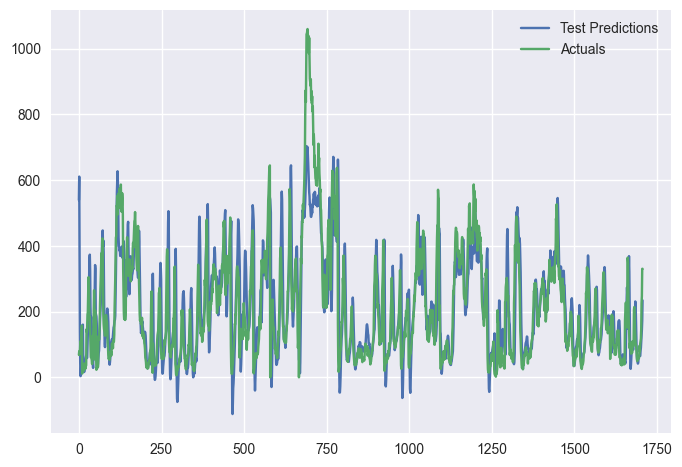

In [32]:
model = load_model('3H_Forecast/3H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(3,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 4 hours forecast

In [34]:
%%time

Trainer(4,6,12,50)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 64)                17920     
                                                                 
 dense_50 (Dense)            (None, 8)                 520       
                                                                 
 dense_51 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 11:17:18.541620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:17:18.733482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:17:19.204417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9855 - mae: 0.6893 - mse: 0.9855 - mape: 121.4013

2023-02-10 11:17:23.539711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:17:23.612757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.71430, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 12s 64ms/step - loss: 0.9855 - mae: 0.6893 - mse: 0.9855 - mape: 121.4013 - val_loss: 0.7143 - val_mae: 0.6573 - val_mse: 0.7143 - val_mape: 110.1341
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.7168 - mae: 0.5146 - mse: 0.7168 - mape: 172.0504
Epoch 2: val_loss improved from 0.71430 to 0.47631, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.7168 - mae: 0.5146 - mse: 0.7168 - mape: 172.0504 - val_loss: 0.4763 - val_mae: 0.5196 - val_mse: 0.4763 - val_mape: 137.4263
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6121 - mae: 0.4270 - mse: 0.6121 - mape: 288.5200
Epoch 3: val_loss improved from 0.47631 to 0.39195, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.6121 - mae: 0.4270 - mse: 0.6121 - mape: 288.5200 - val_loss: 0.3919 - val_mae: 0.4567 - val_mse: 0.3919 - val_mape: 152.9971
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5829 - mae: 0.3998 - mse: 0.5829 - mape: 311.5057
Epoch 4: val_loss improved from 0.39195 to 0.38197, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5829 - mae: 0.3998 - mse: 0.5829 - mape: 311.5057 - val_loss: 0.3820 - val_mae: 0.4479 - val_mse: 0.3820 - val_mape: 157.3509
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5683 - mae: 0.3879 - mse: 0.5683 - mape: 338.4094
Epoch 5: val_loss improved from 0.38197 to 0.37907, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5683 - mae: 0.3879 - mse: 0.5683 - mape: 338.4094 - val_loss: 0.3791 - val_mae: 0.4469 - val_mse: 0.3791 - val_mape: 158.3992
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5601 - mae: 0.3819 - mse: 0.5601 - mape: 341.6588
Epoch 6: val_loss did not improve from 0.37907
161/161 [==============================] - 3s 21ms/step - loss: 0.5601 - mae: 0.3819 - mse: 0.5601 - mape: 341.6588 - val_loss: 0.3796 - val_mae: 0.4482 - val_mse: 0.3796 - val_mape: 156.8048
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5537 - mae: 0.3750 - mse: 0.5537 - mape: 346.0508
Epoch 7: val_loss did not improve from 0.37907
161/161 [==============================] - 3s 20ms/step - loss: 0.5537 - mae: 0.3750 - mse: 0.5537 - mape: 346.0508 - val_loss: 0.3950 - val_mae: 0.4592 - val_mse: 0.3950 - val_mape: 152.1942
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5479 - mae: 0.

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.5372 - mae: 0.3672 - mse: 0.5372 - mape: 337.7122 - val_loss: 0.3774 - val_mae: 0.4480 - val_mse: 0.3774 - val_mape: 150.1006
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.5314 - mae: 0.3633 - mse: 0.5314 - mape: 337.7336
Epoch 11: val_loss did not improve from 0.37744
161/161 [==============================] - 4s 25ms/step - loss: 0.5314 - mae: 0.3633 - mse: 0.5314 - mape: 337.7336 - val_loss: 0.3800 - val_mae: 0.4496 - val_mse: 0.3800 - val_mape: 147.7614
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.5264 - mae: 0.3612 - mse: 0.5264 - mape: 342.0732
Epoch 12: val_loss did not improve from 0.37744
161/161 [==============================] - 3s 19ms/step - loss: 0.5264 - mae: 0.3612 - mse: 0.5264 - mape: 342.0732 - val_loss: 0.3821 - val_mae: 0.4502 - val_mse: 0.3821 - val_mape: 146.0741
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.5215 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5215 - mae: 0.3593 - mse: 0.5215 - mape: 322.2748 - val_loss: 0.3725 - val_mae: 0.4416 - val_mse: 0.3725 - val_mape: 149.1344
Epoch 14/50
160/161 [============================>.] - ETA: 0s - loss: 0.5161 - mae: 0.3578 - mse: 0.5161 - mape: 319.8310
Epoch 14: val_loss improved from 0.37254 to 0.36340, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5159 - mae: 0.3577 - mse: 0.5159 - mape: 319.7138 - val_loss: 0.3634 - val_mae: 0.4344 - val_mse: 0.3634 - val_mape: 148.7371
Epoch 15/50
158/161 [============================>.] - ETA: 0s - loss: 0.5147 - mae: 0.3537 - mse: 0.5147 - mape: 307.4342
Epoch 15: val_loss did not improve from 0.36340
161/161 [==============================] - 3s 19ms/step - loss: 0.5117 - mae: 0.3535 - mse: 0.5117 - mape: 304.6416 - val_loss: 0.3647 - val_mae: 0.4348 - val_mse: 0.3647 - val_mape: 146.6122
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.5061 - mae: 0.3500 - mse: 0.5061 - mape: 305.1796
Epoch 16: val_loss did not improve from 0.36340
161/161 [==============================] - 3s 18ms/step - loss: 0.5063 - mae: 0.3503 - mse: 0.5063 - mape: 305.2165 - val_loss: 0.3638 - val_mae: 0.4336 - val_mse: 0.3638 - val_mape: 147.4710
Epoch 17/50
160/161 [============================>.] - ETA: 0s - loss: 0.5013 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5011 - mae: 0.3472 - mse: 0.5011 - mape: 295.3372 - val_loss: 0.3549 - val_mae: 0.4276 - val_mse: 0.3549 - val_mape: 145.7390
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.4964 - mae: 0.3440 - mse: 0.4964 - mape: 300.3245
Epoch 18: val_loss improved from 0.35489 to 0.34685, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4962 - mae: 0.3439 - mse: 0.4962 - mape: 300.2142 - val_loss: 0.3468 - val_mae: 0.4215 - val_mse: 0.3468 - val_mape: 148.4763
Epoch 19/50
158/161 [============================>.] - ETA: 0s - loss: 0.4917 - mae: 0.3431 - mse: 0.4917 - mape: 290.6502
Epoch 19: val_loss did not improve from 0.34685
161/161 [==============================] - 3s 19ms/step - loss: 0.4907 - mae: 0.3441 - mse: 0.4907 - mape: 289.9683 - val_loss: 0.3479 - val_mae: 0.4201 - val_mse: 0.3479 - val_mape: 150.6262
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.4844 - mae: 0.3393 - mse: 0.4844 - mape: 281.8213
Epoch 20: val_loss did not improve from 0.34685
161/161 [==============================] - 3s 19ms/step - loss: 0.4844 - mae: 0.3393 - mse: 0.4844 - mape: 281.8213 - val_loss: 0.3574 - val_mae: 0.4253 - val_mse: 0.3574 - val_mape: 151.0879
Epoch 21/50
159/161 [============================>.] - ETA: 0s - loss: 0.4801 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.4787 - mae: 0.3355 - mse: 0.4787 - mape: 283.1928 - val_loss: 0.3446 - val_mae: 0.4184 - val_mse: 0.3446 - val_mape: 146.9816
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.4727 - mae: 0.3343 - mse: 0.4727 - mape: 271.5349
Epoch 22: val_loss improved from 0.34461 to 0.33457, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4727 - mae: 0.3343 - mse: 0.4727 - mape: 271.5349 - val_loss: 0.3346 - val_mae: 0.4109 - val_mse: 0.3346 - val_mape: 150.1536
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.4663 - mae: 0.3302 - mse: 0.4663 - mape: 267.9099
Epoch 23: val_loss improved from 0.33457 to 0.32891, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4663 - mae: 0.3302 - mse: 0.4663 - mape: 267.9099 - val_loss: 0.3289 - val_mae: 0.4069 - val_mse: 0.3289 - val_mape: 150.8506
Epoch 24/50
160/161 [============================>.] - ETA: 0s - loss: 0.4600 - mae: 0.3304 - mse: 0.4600 - mape: 264.6904
Epoch 24: val_loss did not improve from 0.32891
161/161 [==============================] - 3s 18ms/step - loss: 0.4599 - mae: 0.3304 - mse: 0.4599 - mape: 264.6240 - val_loss: 0.3386 - val_mae: 0.4110 - val_mse: 0.3386 - val_mape: 154.6092
Epoch 25/50
160/161 [============================>.] - ETA: 0s - loss: 0.4533 - mae: 0.3246 - mse: 0.4533 - mape: 253.7365
Epoch 25: val_loss improved from 0.32891 to 0.32258, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4532 - mae: 0.3247 - mse: 0.4532 - mape: 253.6634 - val_loss: 0.3226 - val_mae: 0.4016 - val_mse: 0.3226 - val_mape: 150.8389
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.4454 - mae: 0.3213 - mse: 0.4454 - mape: 249.8612
Epoch 26: val_loss improved from 0.32258 to 0.30701, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 46ms/step - loss: 0.4454 - mae: 0.3213 - mse: 0.4454 - mape: 249.8612 - val_loss: 0.3070 - val_mae: 0.3913 - val_mse: 0.3070 - val_mape: 153.7085
Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.4385 - mae: 0.3189 - mse: 0.4385 - mape: 249.8154
Epoch 27: val_loss improved from 0.30701 to 0.30126, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.4385 - mae: 0.3189 - mse: 0.4385 - mape: 249.8154 - val_loss: 0.3013 - val_mae: 0.3874 - val_mse: 0.3013 - val_mape: 154.1156
Epoch 28/50
161/161 [==============================] - ETA: 0s - loss: 0.4311 - mae: 0.3169 - mse: 0.4311 - mape: 243.4351
Epoch 28: val_loss did not improve from 0.30126
161/161 [==============================] - 3s 20ms/step - loss: 0.4311 - mae: 0.3169 - mse: 0.4311 - mape: 243.4351 - val_loss: 0.3024 - val_mae: 0.3867 - val_mse: 0.3024 - val_mape: 155.1520
Epoch 29/50
161/161 [==============================] - ETA: 0s - loss: 0.4240 - mae: 0.3129 - mse: 0.4240 - mape: 224.4008
Epoch 29: val_loss improved from 0.30126 to 0.29301, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4240 - mae: 0.3129 - mse: 0.4240 - mape: 224.4008 - val_loss: 0.2930 - val_mae: 0.3769 - val_mse: 0.2930 - val_mape: 159.6040
Epoch 30/50
160/161 [============================>.] - ETA: 0s - loss: 0.4175 - mae: 0.3093 - mse: 0.4175 - mape: 234.1753
Epoch 30: val_loss improved from 0.29301 to 0.29300, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4174 - mae: 0.3093 - mse: 0.4174 - mape: 234.1272 - val_loss: 0.2930 - val_mae: 0.3794 - val_mse: 0.2930 - val_mape: 163.0561
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.4103 - mae: 0.3050 - mse: 0.4103 - mape: 224.4243
Epoch 31: val_loss improved from 0.29300 to 0.28182, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4103 - mae: 0.3050 - mse: 0.4103 - mape: 224.4243 - val_loss: 0.2818 - val_mae: 0.3717 - val_mse: 0.2818 - val_mape: 163.5006
Epoch 32/50
160/161 [============================>.] - ETA: 0s - loss: 0.4057 - mae: 0.3077 - mse: 0.4057 - mape: 220.8133
Epoch 32: val_loss did not improve from 0.28182
161/161 [==============================] - 3s 20ms/step - loss: 0.4055 - mae: 0.3076 - mse: 0.4055 - mape: 220.7324 - val_loss: 0.2849 - val_mae: 0.3732 - val_mse: 0.2849 - val_mape: 165.1919
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3986 - mae: 0.3014 - mse: 0.3986 - mape: 214.2704
Epoch 33: val_loss improved from 0.28182 to 0.27748, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3986 - mae: 0.3014 - mse: 0.3986 - mape: 214.2704 - val_loss: 0.2775 - val_mae: 0.3675 - val_mse: 0.2775 - val_mape: 168.9285
Epoch 34/50
159/161 [============================>.] - ETA: 0s - loss: 0.3944 - mae: 0.3000 - mse: 0.3944 - mape: 211.1609
Epoch 34: val_loss improved from 0.27748 to 0.27124, saving model to 4H_Forecast/4H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3932 - mae: 0.3001 - mse: 0.3932 - mape: 210.1404 - val_loss: 0.2712 - val_mae: 0.3616 - val_mse: 0.2712 - val_mape: 171.3183
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.3885 - mae: 0.2993 - mse: 0.3885 - mape: 201.3214
Epoch 35: val_loss did not improve from 0.27124
161/161 [==============================] - 4s 22ms/step - loss: 0.3885 - mae: 0.2993 - mse: 0.3885 - mape: 201.3214 - val_loss: 0.2762 - val_mae: 0.3646 - val_mse: 0.2762 - val_mape: 173.7658
Epoch 36/50
159/161 [============================>.] - ETA: 0s - loss: 0.3850 - mae: 0.2983 - mse: 0.3850 - mape: 213.7650
Epoch 36: val_loss did not improve from 0.27124
161/161 [==============================] - 3s 20ms/step - loss: 0.3834 - mae: 0.2980 - mse: 0.3834 - mape: 212.7160 - val_loss: 0.2719 - val_mae: 0.3602 - val_mse: 0.2719 - val_mape: 174.6999
Epoch 37/50
159/161 [============================>.] - ETA: 0s - loss: 0.3786 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 53ms/step - loss: 0.3751 - mae: 0.2948 - mse: 0.3751 - mape: 212.6549 - val_loss: 0.2622 - val_mae: 0.3543 - val_mse: 0.2622 - val_mape: 173.9729
Epoch 39/50
160/161 [============================>.] - ETA: 0s - loss: 0.3712 - mae: 0.2949 - mse: 0.3712 - mape: 211.8371
Epoch 39: val_loss did not improve from 0.26222
161/161 [==============================] - 4s 24ms/step - loss: 0.3712 - mae: 0.2950 - mse: 0.3712 - mape: 211.7855 - val_loss: 0.2699 - val_mae: 0.3602 - val_mse: 0.2699 - val_mape: 178.7404
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.3685 - mae: 0.2932 - mse: 0.3685 - mape: 210.7791
Epoch 40: val_loss did not improve from 0.26222
161/161 [==============================] - 4s 23ms/step - loss: 0.3684 - mae: 0.2931 - mse: 0.3684 - mape: 210.7007 - val_loss: 0.2708 - val_mae: 0.3587 - val_mse: 0.2708 - val_mape: 182.3684
Epoch 41/50
158/161 [============================>.] - ETA: 0s - loss: 0.3673 - ma

2023-02-10 11:21:44.811614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:21:44.985523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:21:45.407237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8747 - mae: 0.6054 - mse: 0.8747 - mape: 181.2818

2023-02-10 11:21:49.567423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:21:49.624934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.64744, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 11s 58ms/step - loss: 0.8747 - mae: 0.6054 - mse: 0.8747 - mape: 181.2818 - val_loss: 0.6474 - val_mae: 0.6189 - val_mse: 0.6474 - val_mape: 119.2803
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6742 - mae: 0.4727 - mse: 0.6742 - mape: 240.3778
Epoch 2: val_loss improved from 0.64744 to 0.45033, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.6742 - mae: 0.4727 - mse: 0.6742 - mape: 240.3778 - val_loss: 0.4503 - val_mae: 0.5033 - val_mse: 0.4503 - val_mape: 145.3757
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6055 - mae: 0.4179 - mse: 0.6055 - mape: 308.5900
Epoch 3: val_loss improved from 0.45033 to 0.41327, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.6055 - mae: 0.4179 - mse: 0.6055 - mape: 308.5900 - val_loss: 0.4133 - val_mae: 0.4764 - val_mse: 0.4133 - val_mape: 151.7487
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5813 - mae: 0.3944 - mse: 0.5813 - mape: 325.1476
Epoch 4: val_loss improved from 0.41327 to 0.41289, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.5813 - mae: 0.3944 - mse: 0.5813 - mape: 325.1476 - val_loss: 0.4129 - val_mae: 0.4753 - val_mse: 0.4129 - val_mape: 151.1092
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5688 - mae: 0.3877 - mse: 0.5688 - mape: 335.5082
Epoch 5: val_loss improved from 0.41289 to 0.40776, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.5688 - mae: 0.3877 - mse: 0.5688 - mape: 335.5082 - val_loss: 0.4078 - val_mae: 0.4716 - val_mse: 0.4078 - val_mape: 149.9026
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5609 - mae: 0.3800 - mse: 0.5609 - mape: 333.8831
Epoch 6: val_loss did not improve from 0.40776
161/161 [==============================] - 4s 23ms/step - loss: 0.5609 - mae: 0.3800 - mse: 0.5609 - mape: 333.8831 - val_loss: 0.4121 - val_mae: 0.4746 - val_mse: 0.4121 - val_mape: 145.9903
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5544 - mae: 0.3760 - mse: 0.5544 - mape: 330.8258
Epoch 7: val_loss improved from 0.40776 to 0.40568, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.5544 - mae: 0.3760 - mse: 0.5544 - mape: 330.8258 - val_loss: 0.4057 - val_mae: 0.4685 - val_mse: 0.4057 - val_mape: 147.0273
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5483 - mae: 0.3696 - mse: 0.5483 - mape: 335.4119
Epoch 8: val_loss improved from 0.40568 to 0.40178, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5483 - mae: 0.3696 - mse: 0.5483 - mape: 335.4119 - val_loss: 0.4018 - val_mae: 0.4645 - val_mse: 0.4018 - val_mape: 145.7180
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.5424 - mae: 0.3690 - mse: 0.5424 - mape: 314.7193
Epoch 9: val_loss improved from 0.40178 to 0.39657, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.5423 - mae: 0.3690 - mse: 0.5423 - mape: 314.6642 - val_loss: 0.3966 - val_mae: 0.4601 - val_mse: 0.3966 - val_mape: 145.9569
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.5363 - mae: 0.3634 - mse: 0.5363 - mape: 306.4902
Epoch 10: val_loss improved from 0.39657 to 0.38787, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.5363 - mae: 0.3634 - mse: 0.5363 - mape: 306.4902 - val_loss: 0.3879 - val_mae: 0.4531 - val_mse: 0.3879 - val_mape: 144.5635
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.5308 - mae: 0.3615 - mse: 0.5308 - mape: 300.7979
Epoch 11: val_loss improved from 0.38787 to 0.37478, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.5308 - mae: 0.3615 - mse: 0.5308 - mape: 300.7979 - val_loss: 0.3748 - val_mae: 0.4418 - val_mse: 0.3748 - val_mape: 148.1060
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.5262 - mae: 0.3568 - mse: 0.5262 - mape: 297.6973
Epoch 12: val_loss improved from 0.37478 to 0.37314, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5262 - mae: 0.3568 - mse: 0.5262 - mape: 297.6973 - val_loss: 0.3731 - val_mae: 0.4394 - val_mse: 0.3731 - val_mape: 147.6142
Epoch 13/50
158/161 [============================>.] - ETA: 0s - loss: 0.5239 - mae: 0.3524 - mse: 0.5239 - mape: 278.9017
Epoch 13: val_loss improved from 0.37314 to 0.36761, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.5199 - mae: 0.3518 - mse: 0.5199 - mape: 276.7263 - val_loss: 0.3676 - val_mae: 0.4333 - val_mse: 0.3676 - val_mape: 147.7712
Epoch 14/50
160/161 [============================>.] - ETA: 0s - loss: 0.5149 - mae: 0.3509 - mse: 0.5149 - mape: 276.7466
Epoch 14: val_loss improved from 0.36761 to 0.34948, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5148 - mae: 0.3509 - mse: 0.5148 - mape: 276.7042 - val_loss: 0.3495 - val_mae: 0.4212 - val_mse: 0.3495 - val_mape: 150.6666
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.5094 - mae: 0.3482 - mse: 0.5094 - mape: 262.3697
Epoch 15: val_loss did not improve from 0.34948
161/161 [==============================] - 4s 23ms/step - loss: 0.5094 - mae: 0.3482 - mse: 0.5094 - mape: 262.3697 - val_loss: 0.3495 - val_mae: 0.4185 - val_mse: 0.3495 - val_mape: 152.8745
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.5031 - mae: 0.3408 - mse: 0.5031 - mape: 255.4644
Epoch 16: val_loss improved from 0.34948 to 0.33621, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.5031 - mae: 0.3409 - mse: 0.5031 - mape: 255.4426 - val_loss: 0.3362 - val_mae: 0.4092 - val_mse: 0.3362 - val_mape: 150.3114
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.4981 - mae: 0.3406 - mse: 0.4981 - mape: 251.5169
Epoch 17: val_loss improved from 0.33621 to 0.32331, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.4981 - mae: 0.3406 - mse: 0.4981 - mape: 251.5169 - val_loss: 0.3233 - val_mae: 0.3994 - val_mse: 0.3233 - val_mape: 154.1142
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.4910 - mae: 0.3341 - mse: 0.4910 - mape: 246.4254
Epoch 18: val_loss improved from 0.32331 to 0.32043, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.4909 - mae: 0.3341 - mse: 0.4909 - mape: 246.4381 - val_loss: 0.3204 - val_mae: 0.3969 - val_mse: 0.3204 - val_mape: 152.9254
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.4854 - mae: 0.3323 - mse: 0.4854 - mape: 236.8808
Epoch 19: val_loss improved from 0.32043 to 0.30939, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.4854 - mae: 0.3324 - mse: 0.4854 - mape: 236.9509 - val_loss: 0.3094 - val_mae: 0.3879 - val_mse: 0.3094 - val_mape: 157.5952
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.4794 - mae: 0.3268 - mse: 0.4794 - mape: 235.1469
Epoch 20: val_loss improved from 0.30939 to 0.30184, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 58ms/step - loss: 0.4794 - mae: 0.3268 - mse: 0.4794 - mape: 235.1469 - val_loss: 0.3018 - val_mae: 0.3844 - val_mse: 0.3018 - val_mape: 154.7679
Epoch 21/50
160/161 [============================>.] - ETA: 0s - loss: 0.4746 - mae: 0.3270 - mse: 0.4746 - mape: 227.6812
Epoch 21: val_loss improved from 0.30184 to 0.29569, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4746 - mae: 0.3271 - mse: 0.4746 - mape: 227.6479 - val_loss: 0.2957 - val_mae: 0.3809 - val_mse: 0.2957 - val_mape: 155.0103
Epoch 22/50
160/161 [============================>.] - ETA: 0s - loss: 0.4678 - mae: 0.3212 - mse: 0.4678 - mape: 222.2236
Epoch 22: val_loss improved from 0.29569 to 0.27379, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 57ms/step - loss: 0.4677 - mae: 0.3212 - mse: 0.4677 - mape: 222.1921 - val_loss: 0.2738 - val_mae: 0.3669 - val_mse: 0.2738 - val_mape: 159.3243
Epoch 23/50
160/161 [============================>.] - ETA: 0s - loss: 0.4615 - mae: 0.3196 - mse: 0.4615 - mape: 227.2279
Epoch 23: val_loss did not improve from 0.27379
161/161 [==============================] - 4s 23ms/step - loss: 0.4615 - mae: 0.3196 - mse: 0.4615 - mape: 227.3317 - val_loss: 0.2798 - val_mae: 0.3712 - val_mse: 0.2798 - val_mape: 157.7056
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.4566 - mae: 0.3166 - mse: 0.4566 - mape: 217.5278
Epoch 24: val_loss improved from 0.27379 to 0.26465, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4566 - mae: 0.3166 - mse: 0.4566 - mape: 217.5278 - val_loss: 0.2646 - val_mae: 0.3622 - val_mse: 0.2646 - val_mape: 159.5672
Epoch 25/50
160/161 [============================>.] - ETA: 0s - loss: 0.4508 - mae: 0.3133 - mse: 0.4508 - mape: 223.9557
Epoch 25: val_loss did not improve from 0.26465
161/161 [==============================] - 4s 23ms/step - loss: 0.4509 - mae: 0.3134 - mse: 0.4509 - mape: 223.9370 - val_loss: 0.2693 - val_mae: 0.3663 - val_mse: 0.2693 - val_mape: 157.1224
Epoch 26/50
160/161 [============================>.] - ETA: 0s - loss: 0.4457 - mae: 0.3137 - mse: 0.4457 - mape: 217.1695
Epoch 26: val_loss did not improve from 0.26465
161/161 [==============================] - 4s 23ms/step - loss: 0.4456 - mae: 0.3137 - mse: 0.4456 - mape: 217.1353 - val_loss: 0.2661 - val_mae: 0.3600 - val_mse: 0.2661 - val_mape: 166.4138
Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.4401 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 58ms/step - loss: 0.4401 - mae: 0.3093 - mse: 0.4401 - mape: 198.0542 - val_loss: 0.2629 - val_mae: 0.3617 - val_mse: 0.2629 - val_mape: 156.1871
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.4367 - mae: 0.3133 - mse: 0.4367 - mape: 210.1551
Epoch 28: val_loss improved from 0.26289 to 0.25807, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.4366 - mae: 0.3133 - mse: 0.4366 - mape: 210.1173 - val_loss: 0.2581 - val_mae: 0.3585 - val_mse: 0.2581 - val_mape: 159.2284
Epoch 29/50
161/161 [==============================] - ETA: 0s - loss: 0.4303 - mae: 0.3062 - mse: 0.4303 - mape: 195.7331
Epoch 29: val_loss improved from 0.25807 to 0.25242, saving model to 4H_Forecast/4H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.4303 - mae: 0.3062 - mse: 0.4303 - mape: 195.7331 - val_loss: 0.2524 - val_mae: 0.3557 - val_mse: 0.2524 - val_mape: 159.1730
Epoch 30/50
159/161 [============================>.] - ETA: 0s - loss: 0.4276 - mae: 0.3111 - mse: 0.4276 - mape: 207.9014
Epoch 30: val_loss did not improve from 0.25242
161/161 [==============================] - 4s 24ms/step - loss: 0.4256 - mae: 0.3107 - mse: 0.4256 - mape: 207.1675 - val_loss: 0.2571 - val_mae: 0.3536 - val_mse: 0.2571 - val_mape: 165.4784
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.4192 - mae: 0.3050 - mse: 0.4192 - mape: 207.5024
Epoch 31: val_loss did not improve from 0.25242
161/161 [==============================] - 4s 24ms/step - loss: 0.4192 - mae: 0.3050 - mse: 0.4192 - mape: 207.5024 - val_loss: 0.2577 - val_mae: 0.3543 - val_mse: 0.2577 - val_mape: 158.6462
Epoch 32/50
161/161 [==============================] - ETA: 0s - loss: 0.4148 - ma

                                                                 
 dense_54 (Dense)            (None, 8)                 520       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 11:26:40.456250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:40.612337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:40.988827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8023 - mae: 0.5486 - mse: 0.8023 - mape: 205.9777

2023-02-10 11:26:45.098264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:26:45.153323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.62604, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 11s 60ms/step - loss: 0.8023 - mae: 0.5486 - mse: 0.8023 - mape: 205.9777 - val_loss: 0.6260 - val_mae: 0.5729 - val_mse: 0.6260 - val_mape: 144.4077
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6204 - mae: 0.4185 - mse: 0.6204 - mape: 292.5718
Epoch 2: val_loss improved from 0.62604 to 0.44624, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.6204 - mae: 0.4185 - mse: 0.6204 - mape: 292.5718 - val_loss: 0.4462 - val_mae: 0.4716 - val_mse: 0.4462 - val_mape: 147.7991
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.5836 - mae: 0.3917 - mse: 0.5836 - mape: 315.5450
Epoch 3: val_loss improved from 0.44624 to 0.39971, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.5836 - mae: 0.3917 - mse: 0.5836 - mape: 315.5450 - val_loss: 0.3997 - val_mae: 0.4496 - val_mse: 0.3997 - val_mape: 147.9034
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.5715 - mae: 0.3848 - mse: 0.5715 - mape: 322.5531
Epoch 4: val_loss improved from 0.39971 to 0.39614, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5715 - mae: 0.3848 - mse: 0.5715 - mape: 322.5531 - val_loss: 0.3961 - val_mae: 0.4483 - val_mse: 0.3961 - val_mape: 143.1853
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5614 - mae: 0.3755 - mse: 0.5614 - mape: 315.5832
Epoch 5: val_loss improved from 0.39614 to 0.38745, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5614 - mae: 0.3755 - mse: 0.5614 - mape: 315.5832 - val_loss: 0.3875 - val_mae: 0.4426 - val_mse: 0.3875 - val_mape: 142.1356
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5520 - mae: 0.3727 - mse: 0.5520 - mape: 309.7440
Epoch 6: val_loss improved from 0.38745 to 0.38242, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5520 - mae: 0.3727 - mse: 0.5520 - mape: 309.7440 - val_loss: 0.3824 - val_mae: 0.4388 - val_mse: 0.3824 - val_mape: 142.2856
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5442 - mae: 0.3663 - mse: 0.5442 - mape: 313.1862
Epoch 7: val_loss improved from 0.38242 to 0.37223, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5442 - mae: 0.3663 - mse: 0.5442 - mape: 313.1862 - val_loss: 0.3722 - val_mae: 0.4329 - val_mse: 0.3722 - val_mape: 140.8383
Epoch 8/50
159/161 [============================>.] - ETA: 0s - loss: 0.5369 - mae: 0.3604 - mse: 0.5369 - mape: 302.4077
Epoch 8: val_loss improved from 0.37223 to 0.36914, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5362 - mae: 0.3607 - mse: 0.5362 - mape: 300.9497 - val_loss: 0.3691 - val_mae: 0.4307 - val_mse: 0.3691 - val_mape: 141.6068
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.5284 - mae: 0.3553 - mse: 0.5284 - mape: 291.9748
Epoch 9: val_loss did not improve from 0.36914
161/161 [==============================] - 4s 22ms/step - loss: 0.5284 - mae: 0.3553 - mse: 0.5284 - mape: 291.9748 - val_loss: 0.3727 - val_mae: 0.4329 - val_mse: 0.3727 - val_mape: 141.2973
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.5210 - mae: 0.3512 - mse: 0.5210 - mape: 284.1310
Epoch 10: val_loss improved from 0.36914 to 0.35813, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5210 - mae: 0.3512 - mse: 0.5210 - mape: 284.1310 - val_loss: 0.3581 - val_mae: 0.4228 - val_mse: 0.3581 - val_mape: 142.9336
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.5132 - mae: 0.3484 - mse: 0.5132 - mape: 282.2862
Epoch 11: val_loss improved from 0.35813 to 0.34140, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5132 - mae: 0.3484 - mse: 0.5132 - mape: 282.2862 - val_loss: 0.3414 - val_mae: 0.4133 - val_mse: 0.3414 - val_mape: 142.9455
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.5045 - mae: 0.3402 - mse: 0.5045 - mape: 274.4181
Epoch 12: val_loss improved from 0.34140 to 0.33521, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5045 - mae: 0.3402 - mse: 0.5045 - mape: 274.4181 - val_loss: 0.3352 - val_mae: 0.4091 - val_mse: 0.3352 - val_mape: 145.6060
Epoch 13/50
159/161 [============================>.] - ETA: 0s - loss: 0.4949 - mae: 0.3369 - mse: 0.4949 - mape: 253.3329
Epoch 13: val_loss improved from 0.33521 to 0.31857, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4954 - mae: 0.3372 - mse: 0.4954 - mape: 253.1280 - val_loss: 0.3186 - val_mae: 0.3965 - val_mse: 0.3186 - val_mape: 151.7974
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.4884 - mae: 0.3309 - mse: 0.4884 - mape: 250.4631
Epoch 14: val_loss improved from 0.31857 to 0.30951, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4884 - mae: 0.3309 - mse: 0.4884 - mape: 250.4631 - val_loss: 0.3095 - val_mae: 0.3911 - val_mse: 0.3095 - val_mape: 151.5221
Epoch 15/50
159/161 [============================>.] - ETA: 0s - loss: 0.4809 - mae: 0.3264 - mse: 0.4809 - mape: 244.4369
Epoch 15: val_loss improved from 0.30951 to 0.29935, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4791 - mae: 0.3265 - mse: 0.4791 - mape: 243.6793 - val_loss: 0.2994 - val_mae: 0.3871 - val_mse: 0.2994 - val_mape: 149.1399
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.4732 - mae: 0.3238 - mse: 0.4732 - mape: 232.8838
Epoch 16: val_loss improved from 0.29935 to 0.29383, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4732 - mae: 0.3238 - mse: 0.4732 - mape: 232.8838 - val_loss: 0.2938 - val_mae: 0.3832 - val_mse: 0.2938 - val_mape: 151.8822
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.4651 - mae: 0.3183 - mse: 0.4651 - mape: 230.7066
Epoch 17: val_loss did not improve from 0.29383
161/161 [==============================] - 3s 21ms/step - loss: 0.4651 - mae: 0.3183 - mse: 0.4651 - mape: 230.7066 - val_loss: 0.2957 - val_mae: 0.3851 - val_mse: 0.2957 - val_mape: 150.8248
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.4583 - mae: 0.3176 - mse: 0.4583 - mape: 229.4093
Epoch 18: val_loss did not improve from 0.29383
161/161 [==============================] - 3s 19ms/step - loss: 0.4583 - mae: 0.3176 - mse: 0.4583 - mape: 229.4093 - val_loss: 0.2961 - val_mae: 0.3846 - val_mse: 0.2961 - val_mape: 156.0271
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.4531 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.4530 - mae: 0.3166 - mse: 0.4530 - mape: 224.5439 - val_loss: 0.2896 - val_mae: 0.3782 - val_mse: 0.2896 - val_mape: 160.4983
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.4486 - mae: 0.3135 - mse: 0.4486 - mape: 227.5577
Epoch 20: val_loss did not improve from 0.28956
161/161 [==============================] - 3s 21ms/step - loss: 0.4486 - mae: 0.3135 - mse: 0.4486 - mape: 227.5577 - val_loss: 0.2929 - val_mae: 0.3813 - val_mse: 0.2929 - val_mape: 157.3476
Epoch 21/50
161/161 [==============================] - ETA: 0s - loss: 0.4413 - mae: 0.3126 - mse: 0.4413 - mape: 216.9445
Epoch 21: val_loss improved from 0.28956 to 0.28453, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4413 - mae: 0.3126 - mse: 0.4413 - mape: 216.9445 - val_loss: 0.2845 - val_mae: 0.3766 - val_mse: 0.2845 - val_mape: 159.2501
Epoch 22/50
159/161 [============================>.] - ETA: 0s - loss: 0.4380 - mae: 0.3115 - mse: 0.4380 - mape: 214.3313
Epoch 22: val_loss did not improve from 0.28453
161/161 [==============================] - 3s 21ms/step - loss: 0.4361 - mae: 0.3113 - mse: 0.4361 - mape: 214.5932 - val_loss: 0.2980 - val_mae: 0.3832 - val_mse: 0.2980 - val_mape: 160.9625
Epoch 23/50
159/161 [============================>.] - ETA: 0s - loss: 0.4308 - mae: 0.3096 - mse: 0.4308 - mape: 218.2547
Epoch 23: val_loss did not improve from 0.28453
161/161 [==============================] - 3s 21ms/step - loss: 0.4300 - mae: 0.3099 - mse: 0.4300 - mape: 217.8478 - val_loss: 0.2889 - val_mae: 0.3750 - val_mse: 0.2889 - val_mape: 164.8416
Epoch 24/50
158/161 [============================>.] - ETA: 0s - loss: 0.4261 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 57ms/step - loss: 0.3799 - mae: 0.3026 - mse: 0.3799 - mape: 210.1426 - val_loss: 0.2839 - val_mae: 0.3681 - val_mse: 0.2839 - val_mape: 169.3397
Epoch 33/50
161/161 [==============================] - ETA: 0s - loss: 0.3753 - mae: 0.3020 - mse: 0.3753 - mape: 216.0829
Epoch 33: val_loss did not improve from 0.28388
161/161 [==============================] - 4s 24ms/step - loss: 0.3753 - mae: 0.3020 - mse: 0.3753 - mape: 216.0829 - val_loss: 0.2908 - val_mae: 0.3724 - val_mse: 0.2908 - val_mape: 168.2362
Epoch 34/50
159/161 [============================>.] - ETA: 0s - loss: 0.3740 - mae: 0.3047 - mse: 0.3740 - mape: 216.0477
Epoch 34: val_loss did not improve from 0.28388
161/161 [==============================] - 4s 24ms/step - loss: 0.3723 - mae: 0.3045 - mse: 0.3723 - mape: 216.0124 - val_loss: 0.2848 - val_mae: 0.3677 - val_mse: 0.2848 - val_mape: 169.4786
Epoch 35/50
159/161 [============================>.] - ETA: 0s - loss: 0.3677 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.3658 - mae: 0.2999 - mse: 0.3658 - mape: 206.1485 - val_loss: 0.2791 - val_mae: 0.3659 - val_mse: 0.2791 - val_mape: 174.0150
Epoch 36/50
161/161 [==============================] - ETA: 0s - loss: 0.3599 - mae: 0.2983 - mse: 0.3599 - mape: 210.0107
Epoch 36: val_loss did not improve from 0.27907
161/161 [==============================] - 4s 25ms/step - loss: 0.3599 - mae: 0.2983 - mse: 0.3599 - mape: 210.0107 - val_loss: 0.2878 - val_mae: 0.3685 - val_mse: 0.2878 - val_mape: 174.0697
Epoch 37/50
161/161 [==============================] - ETA: 0s - loss: 0.3554 - mae: 0.2974 - mse: 0.3554 - mape: 203.6620
Epoch 37: val_loss did not improve from 0.27907
161/161 [==============================] - 4s 23ms/step - loss: 0.3554 - mae: 0.2974 - mse: 0.3554 - mape: 203.6620 - val_loss: 0.2820 - val_mae: 0.3657 - val_mse: 0.2820 - val_mape: 171.4252
Epoch 38/50
160/161 [============================>.] - ETA: 0s - loss: 0.3518 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 57ms/step - loss: 0.3480 - mae: 0.2966 - mse: 0.3480 - mape: 201.0134 - val_loss: 0.2789 - val_mae: 0.3654 - val_mse: 0.2789 - val_mape: 177.8780
Epoch 40/50
161/161 [==============================] - ETA: 0s - loss: 0.3429 - mae: 0.2979 - mse: 0.3429 - mape: 195.9600
Epoch 40: val_loss improved from 0.27891 to 0.27396, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.3429 - mae: 0.2979 - mse: 0.3429 - mape: 195.9600 - val_loss: 0.2740 - val_mae: 0.3612 - val_mse: 0.2740 - val_mape: 169.5480
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.3381 - mae: 0.2947 - mse: 0.3381 - mape: 206.4307
Epoch 41: val_loss did not improve from 0.27396
161/161 [==============================] - 4s 24ms/step - loss: 0.3381 - mae: 0.2947 - mse: 0.3381 - mape: 206.4307 - val_loss: 0.2823 - val_mae: 0.3664 - val_mse: 0.2823 - val_mape: 174.0613
Epoch 42/50
160/161 [============================>.] - ETA: 0s - loss: 0.3347 - mae: 0.2952 - mse: 0.3347 - mape: 193.3404
Epoch 42: val_loss improved from 0.27396 to 0.27035, saving model to 4H_Forecast/4H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.3347 - mae: 0.2952 - mse: 0.3347 - mape: 193.3045 - val_loss: 0.2704 - val_mae: 0.3611 - val_mse: 0.2704 - val_mape: 177.6657
Epoch 43/50
161/161 [==============================] - ETA: 0s - loss: 0.3292 - mae: 0.2914 - mse: 0.3292 - mape: 197.0545
Epoch 43: val_loss did not improve from 0.27035
161/161 [==============================] - 4s 27ms/step - loss: 0.3292 - mae: 0.2914 - mse: 0.3292 - mape: 197.0545 - val_loss: 0.2706 - val_mae: 0.3600 - val_mse: 0.2706 - val_mape: 172.9774
Epoch 44/50
160/161 [============================>.] - ETA: 0s - loss: 0.3267 - mae: 0.2921 - mse: 0.3267 - mape: 196.8970
Epoch 44: val_loss did not improve from 0.27035
161/161 [==============================] - 4s 23ms/step - loss: 0.3267 - mae: 0.2921 - mse: 0.3267 - mape: 196.8626 - val_loss: 0.2804 - val_mae: 0.3642 - val_mse: 0.2804 - val_mape: 176.3408
Epoch 45/50
159/161 [============================>.] - ETA: 0s - loss: 0.3241 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.3141 - mae: 0.2880 - mse: 0.3141 - mape: 186.7013 - val_loss: 0.2686 - val_mae: 0.3576 - val_mse: 0.2686 - val_mape: 180.2508
Epoch 48/50
160/161 [============================>.] - ETA: 0s - loss: 0.3095 - mae: 0.2893 - mse: 0.3095 - mape: 189.1145
Epoch 48: val_loss did not improve from 0.26863
161/161 [==============================] - 4s 26ms/step - loss: 0.3094 - mae: 0.2893 - mse: 0.3094 - mape: 189.0852 - val_loss: 0.2775 - val_mae: 0.3610 - val_mse: 0.2775 - val_mape: 177.0200
Epoch 49/50
161/161 [==============================] - ETA: 0s - loss: 0.3065 - mae: 0.2849 - mse: 0.3065 - mape: 188.4265
Epoch 49: val_loss did not improve from 0.26863
161/161 [==============================] - 4s 23ms/step - loss: 0.3065 - mae: 0.2849 - mse: 0.3065 - mape: 188.4265 - val_loss: 0.2731 - val_mae: 0.3577 - val_mse: 0.2731 - val_mape: 175.1179
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.3015 - ma

2023-02-10 11:31:33.427063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:31:33.606874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:31:34.106941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 1.0886 - mae: 0.7330 - mse: 1.0886 - mape: 113.6577

2023-02-10 11:31:38.918308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:31:38.979666: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.95171, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 13s 69ms/step - loss: 1.0886 - mae: 0.7330 - mse: 1.0886 - mape: 113.6577 - val_loss: 0.9517 - val_mae: 0.7639 - val_mse: 0.9517 - val_mape: 117.9680
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.8843 - mae: 0.6078 - mse: 0.8843 - mape: 108.7069
Epoch 2: val_loss improved from 0.95171 to 0.81173, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 57ms/step - loss: 0.8843 - mae: 0.6078 - mse: 0.8843 - mape: 108.7069 - val_loss: 0.8117 - val_mae: 0.7021 - val_mse: 0.8117 - val_mape: 124.0759
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.7589 - mae: 0.5311 - mse: 0.7589 - mape: 136.1883
Epoch 3: val_loss improved from 0.81173 to 0.60584, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.7589 - mae: 0.5311 - mse: 0.7589 - mape: 136.1883 - val_loss: 0.6058 - val_mae: 0.5905 - val_mse: 0.6058 - val_mape: 131.0662
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6498 - mae: 0.4543 - mse: 0.6498 - mape: 282.0002
Epoch 4: val_loss improved from 0.60584 to 0.48916, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.6498 - mae: 0.4543 - mse: 0.6498 - mape: 282.0002 - val_loss: 0.4892 - val_mae: 0.5101 - val_mse: 0.4892 - val_mape: 138.1264
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.6140 - mae: 0.4165 - mse: 0.6140 - mape: 349.4500
Epoch 5: val_loss improved from 0.48916 to 0.45349, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 57ms/step - loss: 0.6140 - mae: 0.4165 - mse: 0.6140 - mape: 349.4500 - val_loss: 0.4535 - val_mae: 0.4893 - val_mse: 0.4535 - val_mape: 142.2392
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5986 - mae: 0.4061 - mse: 0.5986 - mape: 352.2530
Epoch 6: val_loss improved from 0.45349 to 0.44344, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 58ms/step - loss: 0.5986 - mae: 0.4061 - mse: 0.5986 - mape: 352.2530 - val_loss: 0.4434 - val_mae: 0.4818 - val_mse: 0.4434 - val_mape: 140.5622
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5872 - mae: 0.3972 - mse: 0.5872 - mape: 350.8709
Epoch 7: val_loss improved from 0.44344 to 0.42926, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.5872 - mae: 0.3972 - mse: 0.5872 - mape: 350.8709 - val_loss: 0.4293 - val_mae: 0.4737 - val_mse: 0.4293 - val_mape: 138.7312
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5760 - mae: 0.3899 - mse: 0.5760 - mape: 346.3481
Epoch 8: val_loss improved from 0.42926 to 0.42100, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5760 - mae: 0.3899 - mse: 0.5760 - mape: 346.3481 - val_loss: 0.4210 - val_mae: 0.4686 - val_mse: 0.4210 - val_mape: 137.9797
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.5649 - mae: 0.3798 - mse: 0.5649 - mape: 344.0135
Epoch 9: val_loss improved from 0.42100 to 0.41576, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.5648 - mae: 0.3798 - mse: 0.5648 - mape: 343.9965 - val_loss: 0.4158 - val_mae: 0.4664 - val_mse: 0.4158 - val_mape: 134.1854
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.5541 - mae: 0.3753 - mse: 0.5541 - mape: 330.5456
Epoch 10: val_loss improved from 0.41576 to 0.39902, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5541 - mae: 0.3753 - mse: 0.5541 - mape: 330.5456 - val_loss: 0.3990 - val_mae: 0.4559 - val_mse: 0.3990 - val_mape: 135.5557
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.5417 - mae: 0.3635 - mse: 0.5417 - mape: 327.6127
Epoch 11: val_loss improved from 0.39902 to 0.38816, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 55ms/step - loss: 0.5417 - mae: 0.3635 - mse: 0.5417 - mape: 327.6127 - val_loss: 0.3882 - val_mae: 0.4498 - val_mse: 0.3882 - val_mape: 137.0034
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.5321 - mae: 0.3609 - mse: 0.5321 - mape: 308.3116
Epoch 12: val_loss improved from 0.38816 to 0.36675, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.5321 - mae: 0.3609 - mse: 0.5321 - mape: 308.3116 - val_loss: 0.3667 - val_mae: 0.4346 - val_mse: 0.3667 - val_mape: 140.8986
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.5202 - mae: 0.3502 - mse: 0.5202 - mape: 299.1442
Epoch 13: val_loss improved from 0.36675 to 0.35142, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5202 - mae: 0.3502 - mse: 0.5202 - mape: 299.1442 - val_loss: 0.3514 - val_mae: 0.4249 - val_mse: 0.3514 - val_mape: 143.8826
Epoch 14/50
159/161 [============================>.] - ETA: 0s - loss: 0.5120 - mae: 0.3436 - mse: 0.5120 - mape: 287.7981
Epoch 14: val_loss improved from 0.35142 to 0.34357, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.5104 - mae: 0.3438 - mse: 0.5104 - mape: 286.4854 - val_loss: 0.3436 - val_mae: 0.4180 - val_mse: 0.3436 - val_mape: 145.7024
Epoch 15/50
159/161 [============================>.] - ETA: 0s - loss: 0.5042 - mae: 0.3386 - mse: 0.5042 - mape: 288.5134
Epoch 15: val_loss improved from 0.34357 to 0.33301, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5023 - mae: 0.3386 - mse: 0.5023 - mape: 287.0661 - val_loss: 0.3330 - val_mae: 0.4140 - val_mse: 0.3330 - val_mape: 143.0490
Epoch 16/50
159/161 [============================>.] - ETA: 0s - loss: 0.4964 - mae: 0.3335 - mse: 0.4964 - mape: 268.8803
Epoch 16: val_loss did not improve from 0.33301
161/161 [==============================] - 4s 22ms/step - loss: 0.4939 - mae: 0.3327 - mse: 0.4939 - mape: 268.2319 - val_loss: 0.3371 - val_mae: 0.4133 - val_mse: 0.3371 - val_mape: 146.8192
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.4862 - mae: 0.3314 - mse: 0.4862 - mape: 258.3266
Epoch 17: val_loss improved from 0.33301 to 0.31998, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.4862 - mae: 0.3314 - mse: 0.4862 - mape: 258.3266 - val_loss: 0.3200 - val_mae: 0.4009 - val_mse: 0.3200 - val_mape: 153.6060
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.4796 - mae: 0.3290 - mse: 0.4796 - mape: 261.6558
Epoch 18: val_loss did not improve from 0.31998
161/161 [==============================] - 3s 19ms/step - loss: 0.4796 - mae: 0.3290 - mse: 0.4796 - mape: 261.6558 - val_loss: 0.3368 - val_mae: 0.4104 - val_mse: 0.3368 - val_mape: 151.3345
Epoch 19/50
159/161 [============================>.] - ETA: 0s - loss: 0.4743 - mae: 0.3268 - mse: 0.4743 - mape: 263.6220
Epoch 19: val_loss improved from 0.31998 to 0.31559, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4727 - mae: 0.3269 - mse: 0.4727 - mape: 262.6423 - val_loss: 0.3156 - val_mae: 0.3970 - val_mse: 0.3156 - val_mape: 153.9475
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.4666 - mae: 0.3221 - mse: 0.4666 - mape: 258.1831
Epoch 20: val_loss did not improve from 0.31559
161/161 [==============================] - 3s 19ms/step - loss: 0.4666 - mae: 0.3221 - mse: 0.4666 - mape: 258.1831 - val_loss: 0.3204 - val_mae: 0.3997 - val_mse: 0.3204 - val_mape: 155.8416
Epoch 21/50
160/161 [============================>.] - ETA: 0s - loss: 0.4607 - mae: 0.3234 - mse: 0.4607 - mape: 255.9605
Epoch 21: val_loss did not improve from 0.31559
161/161 [==============================] - 3s 17ms/step - loss: 0.4606 - mae: 0.3234 - mse: 0.4606 - mape: 255.9174 - val_loss: 0.3247 - val_mae: 0.4009 - val_mse: 0.3247 - val_mape: 157.4711
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.4546 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4422 - mae: 0.3183 - mse: 0.4422 - mape: 241.4107 - val_loss: 0.3151 - val_mae: 0.3932 - val_mse: 0.3151 - val_mape: 164.2036
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.4364 - mae: 0.3123 - mse: 0.4364 - mape: 241.0733
Epoch 25: val_loss did not improve from 0.31512
161/161 [==============================] - 3s 19ms/step - loss: 0.4364 - mae: 0.3123 - mse: 0.4364 - mape: 241.0733 - val_loss: 0.3157 - val_mae: 0.3938 - val_mse: 0.3157 - val_mape: 163.2766
Epoch 26/50
159/161 [============================>.] - ETA: 0s - loss: 0.4332 - mae: 0.3158 - mse: 0.4332 - mape: 242.0591
Epoch 26: val_loss improved from 0.31512 to 0.31433, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4316 - mae: 0.3159 - mse: 0.4316 - mape: 242.1926 - val_loss: 0.3143 - val_mae: 0.3922 - val_mse: 0.3143 - val_mape: 164.9565
Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.4237 - mae: 0.3135 - mse: 0.4237 - mape: 240.1951
Epoch 27: val_loss improved from 0.31433 to 0.31396, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4237 - mae: 0.3135 - mse: 0.4237 - mape: 240.1951 - val_loss: 0.3140 - val_mae: 0.3911 - val_mse: 0.3140 - val_mape: 170.0115
Epoch 28/50
159/161 [============================>.] - ETA: 0s - loss: 0.4207 - mae: 0.3104 - mse: 0.4207 - mape: 235.1515
Epoch 28: val_loss improved from 0.31396 to 0.29791, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4188 - mae: 0.3102 - mse: 0.4188 - mape: 234.2398 - val_loss: 0.2979 - val_mae: 0.3825 - val_mse: 0.2979 - val_mape: 169.1622
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.4117 - mae: 0.3085 - mse: 0.4117 - mape: 241.8566
Epoch 29: val_loss improved from 0.29791 to 0.29779, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4117 - mae: 0.3085 - mse: 0.4117 - mape: 241.8098 - val_loss: 0.2978 - val_mae: 0.3810 - val_mse: 0.2978 - val_mape: 173.7480
Epoch 30/50
160/161 [============================>.] - ETA: 0s - loss: 0.4074 - mae: 0.3064 - mse: 0.4074 - mape: 244.3970
Epoch 30: val_loss improved from 0.29779 to 0.29564, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4074 - mae: 0.3065 - mse: 0.4074 - mape: 244.3581 - val_loss: 0.2956 - val_mae: 0.3796 - val_mse: 0.2956 - val_mape: 177.0624
Epoch 31/50
160/161 [============================>.] - ETA: 0s - loss: 0.4012 - mae: 0.3055 - mse: 0.4012 - mape: 233.3714
Epoch 31: val_loss improved from 0.29564 to 0.29450, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4011 - mae: 0.3055 - mse: 0.4011 - mape: 233.3283 - val_loss: 0.2945 - val_mae: 0.3772 - val_mse: 0.2945 - val_mape: 177.3528
Epoch 32/50
159/161 [============================>.] - ETA: 0s - loss: 0.3964 - mae: 0.3028 - mse: 0.3964 - mape: 240.7707
Epoch 32: val_loss improved from 0.29450 to 0.28885, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3945 - mae: 0.3024 - mse: 0.3945 - mape: 240.4304 - val_loss: 0.2889 - val_mae: 0.3747 - val_mse: 0.2889 - val_mape: 178.9183
Epoch 33/50
158/161 [============================>.] - ETA: 0s - loss: 0.3908 - mae: 0.2998 - mse: 0.3908 - mape: 234.7069
Epoch 33: val_loss did not improve from 0.28885
161/161 [==============================] - 3s 17ms/step - loss: 0.3880 - mae: 0.2995 - mse: 0.3880 - mape: 232.4532 - val_loss: 0.2895 - val_mae: 0.3745 - val_mse: 0.2895 - val_mape: 181.6536
Epoch 34/50
160/161 [============================>.] - ETA: 0s - loss: 0.3827 - mae: 0.3005 - mse: 0.3827 - mape: 220.9208
Epoch 34: val_loss did not improve from 0.28885
161/161 [==============================] - 3s 17ms/step - loss: 0.3827 - mae: 0.3006 - mse: 0.3827 - mape: 220.8834 - val_loss: 0.2918 - val_mae: 0.3758 - val_mse: 0.2918 - val_mape: 183.2940
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.3773 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.3611 - mae: 0.2926 - mse: 0.3611 - mape: 198.0583 - val_loss: 0.2843 - val_mae: 0.3687 - val_mse: 0.2843 - val_mape: 183.6547
Epoch 39/50
158/161 [============================>.] - ETA: 0s - loss: 0.3572 - mae: 0.2878 - mse: 0.3572 - mape: 218.3206
Epoch 39: val_loss did not improve from 0.28425
161/161 [==============================] - 3s 16ms/step - loss: 0.3571 - mae: 0.2886 - mse: 0.3571 - mape: 216.5551 - val_loss: 0.2868 - val_mae: 0.3710 - val_mse: 0.2868 - val_mape: 187.0738
Epoch 40/50
160/161 [============================>.] - ETA: 0s - loss: 0.3533 - mae: 0.2921 - mse: 0.3533 - mape: 212.9533
Epoch 40: val_loss improved from 0.28425 to 0.28389, saving model to 4H_Forecast/4H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_9_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.3532 - mae: 0.2921 - mse: 0.3532 - mape: 212.9131 - val_loss: 0.2839 - val_mae: 0.3686 - val_mse: 0.2839 - val_mape: 187.0850
Epoch 41/50
158/161 [============================>.] - ETA: 0s - loss: 0.3503 - mae: 0.2883 - mse: 0.3503 - mape: 209.8953
Epoch 41: val_loss did not improve from 0.28389
161/161 [==============================] - 3s 17ms/step - loss: 0.3479 - mae: 0.2884 - mse: 0.3479 - mape: 209.4083 - val_loss: 0.2959 - val_mae: 0.3730 - val_mse: 0.2959 - val_mape: 185.6901
Epoch 42/50
161/161 [==============================] - ETA: 0s - loss: 0.3437 - mae: 0.2815 - mse: 0.3437 - mape: 203.2996
Epoch 42: val_loss did not improve from 0.28389
161/161 [==============================] - 3s 17ms/step - loss: 0.3437 - mae: 0.2815 - mse: 0.3437 - mape: 203.2996 - val_loss: 0.2950 - val_mae: 0.3732 - val_mse: 0.2950 - val_mape: 183.9336
Epoch 43/50
159/161 [============================>.] - ETA: 0s - loss: 0.3423 - ma

2023-02-10 11:36:21.274684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:21.393392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:21.755945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8331 - mae: 0.6052 - mse: 0.8331 - mape: 166.9770

2023-02-10 11:36:24.694523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:36:24.752353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.61793, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 10s 54ms/step - loss: 0.8331 - mae: 0.6052 - mse: 0.8331 - mape: 166.9770 - val_loss: 0.6179 - val_mae: 0.6155 - val_mse: 0.6179 - val_mape: 111.3298
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6426 - mae: 0.4502 - mse: 0.6426 - mape: 240.6962
Epoch 2: val_loss improved from 0.61793 to 0.48099, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.6426 - mae: 0.4502 - mse: 0.6426 - mape: 240.6962 - val_loss: 0.4810 - val_mae: 0.5242 - val_mse: 0.4810 - val_mape: 123.2127
Epoch 3/50
157/160 [============================>.] - ETA: 0s - loss: 0.6088 - mae: 0.4139 - mse: 0.6088 - mape: 307.3523
Epoch 3: val_loss improved from 0.48099 to 0.45702, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.6033 - mae: 0.4145 - mse: 0.6033 - mape: 312.2304 - val_loss: 0.4570 - val_mae: 0.5019 - val_mse: 0.4570 - val_mape: 137.1567
Epoch 4/50
158/160 [============================>.] - ETA: 0s - loss: 0.5935 - mae: 0.4031 - mse: 0.5935 - mape: 346.6056
Epoch 4: val_loss improved from 0.45702 to 0.44077, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5896 - mae: 0.4027 - mse: 0.5896 - mape: 344.0302 - val_loss: 0.4408 - val_mae: 0.4907 - val_mse: 0.4408 - val_mape: 139.8904
Epoch 5/50
156/160 [============================>.] - ETA: 0s - loss: 0.5380 - mae: 0.3903 - mse: 0.5380 - mape: 344.6981
Epoch 5: val_loss improved from 0.44077 to 0.43242, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 41ms/step - loss: 0.5783 - mae: 0.3927 - mse: 0.5783 - mape: 339.0850 - val_loss: 0.4324 - val_mae: 0.4843 - val_mse: 0.4324 - val_mape: 141.7157
Epoch 6/50
157/160 [============================>.] - ETA: 0s - loss: 0.5723 - mae: 0.3858 - mse: 0.5723 - mape: 312.6663
Epoch 6: val_loss improved from 0.43242 to 0.41948, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5676 - mae: 0.3864 - mse: 0.5676 - mape: 346.0905 - val_loss: 0.4195 - val_mae: 0.4761 - val_mse: 0.4195 - val_mape: 142.0671
Epoch 7/50
157/160 [============================>.] - ETA: 0s - loss: 0.5627 - mae: 0.3794 - mse: 0.5627 - mape: 346.1998
Epoch 7: val_loss improved from 0.41948 to 0.41212, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5581 - mae: 0.3792 - mse: 0.5581 - mape: 341.4158 - val_loss: 0.4121 - val_mae: 0.4711 - val_mse: 0.4121 - val_mape: 144.5519
Epoch 8/50
157/160 [============================>.] - ETA: 0s - loss: 0.5549 - mae: 0.3754 - mse: 0.5549 - mape: 345.6671
Epoch 8: val_loss improved from 0.41212 to 0.40137, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5488 - mae: 0.3744 - mse: 0.5488 - mape: 341.0684 - val_loss: 0.4014 - val_mae: 0.4639 - val_mse: 0.4014 - val_mape: 145.0877
Epoch 9/50
157/160 [============================>.] - ETA: 0s - loss: 0.5432 - mae: 0.3676 - mse: 0.5432 - mape: 342.7434
Epoch 9: val_loss improved from 0.40137 to 0.38940, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5393 - mae: 0.3673 - mse: 0.5393 - mape: 338.3273 - val_loss: 0.3894 - val_mae: 0.4560 - val_mse: 0.3894 - val_mape: 148.0263
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5305 - mae: 0.3623 - mse: 0.5305 - mape: 322.2686
Epoch 10: val_loss improved from 0.38940 to 0.38542, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5305 - mae: 0.3623 - mse: 0.5305 - mape: 322.2686 - val_loss: 0.3854 - val_mae: 0.4499 - val_mse: 0.3854 - val_mape: 151.0816
Epoch 11/50
158/160 [============================>.] - ETA: 0s - loss: 0.5238 - mae: 0.3529 - mse: 0.5238 - mape: 317.3820
Epoch 11: val_loss improved from 0.38542 to 0.38407, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5210 - mae: 0.3534 - mse: 0.5210 - mape: 314.5611 - val_loss: 0.3841 - val_mae: 0.4485 - val_mse: 0.3841 - val_mape: 151.8412
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5114 - mae: 0.3503 - mse: 0.5114 - mape: 294.6272
Epoch 12: val_loss improved from 0.38407 to 0.36560, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.5114 - mae: 0.3503 - mse: 0.5114 - mape: 294.6272 - val_loss: 0.3656 - val_mae: 0.4350 - val_mse: 0.3656 - val_mape: 154.0231
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5024 - mae: 0.3431 - mse: 0.5024 - mape: 288.5557
Epoch 13: val_loss improved from 0.36560 to 0.35723, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.5024 - mae: 0.3431 - mse: 0.5024 - mape: 288.5557 - val_loss: 0.3572 - val_mae: 0.4312 - val_mse: 0.3572 - val_mape: 148.8245
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.4924 - mae: 0.3389 - mse: 0.4924 - mape: 268.4799
Epoch 14: val_loss improved from 0.35723 to 0.34422, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.4924 - mae: 0.3389 - mse: 0.4924 - mape: 268.4799 - val_loss: 0.3442 - val_mae: 0.4196 - val_mse: 0.3442 - val_mape: 156.0120
Epoch 15/50
158/160 [============================>.] - ETA: 0s - loss: 0.4875 - mae: 0.3311 - mse: 0.4875 - mape: 262.9607
Epoch 15: val_loss improved from 0.34422 to 0.33191, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.4841 - mae: 0.3313 - mse: 0.4841 - mape: 262.2513 - val_loss: 0.3319 - val_mae: 0.4126 - val_mse: 0.3319 - val_mape: 154.7922
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.4762 - mae: 0.3334 - mse: 0.4762 - mape: 239.4964
Epoch 16: val_loss improved from 0.33191 to 0.32903, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 41ms/step - loss: 0.4762 - mae: 0.3334 - mse: 0.4762 - mape: 239.4964 - val_loss: 0.3290 - val_mae: 0.4060 - val_mse: 0.3290 - val_mape: 163.4994
Epoch 17/50
157/160 [============================>.] - ETA: 0s - loss: 0.4737 - mae: 0.3273 - mse: 0.4737 - mape: 242.5629
Epoch 17: val_loss improved from 0.32903 to 0.32119, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.4685 - mae: 0.3269 - mse: 0.4685 - mape: 243.1492 - val_loss: 0.3212 - val_mae: 0.4018 - val_mse: 0.3212 - val_mape: 157.2614
Epoch 18/50
157/160 [============================>.] - ETA: 0s - loss: 0.4677 - mae: 0.3263 - mse: 0.4677 - mape: 252.7791
Epoch 18: val_loss improved from 0.32119 to 0.31673, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.4625 - mae: 0.3257 - mse: 0.4625 - mape: 249.4083 - val_loss: 0.3167 - val_mae: 0.4007 - val_mse: 0.3167 - val_mape: 158.7647
Epoch 19/50
157/160 [============================>.] - ETA: 0s - loss: 0.4592 - mae: 0.3236 - mse: 0.4592 - mape: 237.5890
Epoch 19: val_loss improved from 0.31673 to 0.31658, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.4549 - mae: 0.3233 - mse: 0.4549 - mape: 235.5160 - val_loss: 0.3166 - val_mae: 0.3980 - val_mse: 0.3166 - val_mape: 160.7741
Epoch 20/50
157/160 [============================>.] - ETA: 0s - loss: 0.4512 - mae: 0.3227 - mse: 0.4512 - mape: 232.8046
Epoch 20: val_loss improved from 0.31658 to 0.30838, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4469 - mae: 0.3225 - mse: 0.4469 - mape: 230.0762 - val_loss: 0.3084 - val_mae: 0.3914 - val_mse: 0.3084 - val_mape: 162.8706
Epoch 21/50
158/160 [============================>.] - ETA: 0s - loss: 0.4420 - mae: 0.3212 - mse: 0.4420 - mape: 231.5420
Epoch 21: val_loss improved from 0.30838 to 0.30809, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.4403 - mae: 0.3215 - mse: 0.4403 - mape: 229.8342 - val_loss: 0.3081 - val_mae: 0.3912 - val_mse: 0.3081 - val_mape: 164.8134
Epoch 22/50
158/160 [============================>.] - ETA: 0s - loss: 0.4359 - mae: 0.3189 - mse: 0.4359 - mape: 227.2887
Epoch 22: val_loss did not improve from 0.30809
160/160 [==============================] - 3s 17ms/step - loss: 0.4330 - mae: 0.3187 - mse: 0.4330 - mape: 225.3739 - val_loss: 0.3131 - val_mae: 0.3915 - val_mse: 0.3131 - val_mape: 163.9118
Epoch 23/50
157/160 [============================>.] - ETA: 0s - loss: 0.4301 - mae: 0.3199 - mse: 0.4301 - mape: 239.9801
Epoch 23: val_loss improved from 0.30809 to 0.30359, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.4252 - mae: 0.3191 - mse: 0.4252 - mape: 236.7247 - val_loss: 0.3036 - val_mae: 0.3860 - val_mse: 0.3036 - val_mape: 167.8073
Epoch 24/50
156/160 [============================>.] - ETA: 0s - loss: 0.4207 - mae: 0.3181 - mse: 0.4207 - mape: 229.1772
Epoch 24: val_loss did not improve from 0.30359
160/160 [==============================] - 3s 17ms/step - loss: 0.4178 - mae: 0.3180 - mse: 0.4178 - mape: 228.3565 - val_loss: 0.3040 - val_mae: 0.3853 - val_mse: 0.3040 - val_mape: 165.1590
Epoch 25/50
159/160 [============================>.] - ETA: 0s - loss: 0.4113 - mae: 0.3162 - mse: 0.4113 - mape: 230.2915
Epoch 25: val_loss did not improve from 0.30359
160/160 [==============================] - 3s 16ms/step - loss: 0.4098 - mae: 0.3162 - mse: 0.4098 - mape: 229.3481 - val_loss: 0.3080 - val_mae: 0.3874 - val_mse: 0.3080 - val_mape: 167.1308
Epoch 26/50
158/160 [============================>.] - ETA: 0s - loss: 0.4045 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.3945 - mae: 0.3122 - mse: 0.3945 - mape: 227.3755 - val_loss: 0.3025 - val_mae: 0.3829 - val_mse: 0.3025 - val_mape: 164.1311
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.3893 - mae: 0.3125 - mse: 0.3893 - mape: 227.9559
Epoch 28: val_loss improved from 0.30247 to 0.30234, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.3875 - mae: 0.3120 - mse: 0.3875 - mape: 226.9066 - val_loss: 0.3023 - val_mae: 0.3826 - val_mse: 0.3023 - val_mape: 166.2767
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.3800 - mae: 0.3105 - mse: 0.3800 - mape: 225.6891
Epoch 29: val_loss did not improve from 0.30234
160/160 [==============================] - 3s 16ms/step - loss: 0.3800 - mae: 0.3105 - mse: 0.3800 - mape: 225.6891 - val_loss: 0.3093 - val_mae: 0.3831 - val_mse: 0.3093 - val_mape: 171.4884
Epoch 30/50
158/160 [============================>.] - ETA: 0s - loss: 0.3733 - mae: 0.3057 - mse: 0.3733 - mape: 225.6021
Epoch 30: val_loss improved from 0.30234 to 0.29882, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.3712 - mae: 0.3062 - mse: 0.3712 - mape: 225.4115 - val_loss: 0.2988 - val_mae: 0.3784 - val_mse: 0.2988 - val_mape: 167.2244
Epoch 31/50
157/160 [============================>.] - ETA: 0s - loss: 0.3709 - mae: 0.3093 - mse: 0.3709 - mape: 218.9502
Epoch 31: val_loss did not improve from 0.29882
160/160 [==============================] - 2s 15ms/step - loss: 0.3672 - mae: 0.3089 - mse: 0.3672 - mape: 225.8009 - val_loss: 0.3047 - val_mae: 0.3801 - val_mse: 0.3047 - val_mape: 174.0132
Epoch 32/50
157/160 [============================>.] - ETA: 0s - loss: 0.3603 - mae: 0.3037 - mse: 0.3603 - mape: 227.8574
Epoch 32: val_loss did not improve from 0.29882
160/160 [==============================] - 3s 17ms/step - loss: 0.3593 - mae: 0.3043 - mse: 0.3593 - mape: 226.0540 - val_loss: 0.3057 - val_mae: 0.3795 - val_mse: 0.3057 - val_mape: 177.2339
Epoch 33/50
158/160 [============================>.] - ETA: 0s - loss: 0.3542 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.3417 - mae: 0.3003 - mse: 0.3417 - mape: 219.7586 - val_loss: 0.2986 - val_mae: 0.3753 - val_mse: 0.2986 - val_mape: 183.9947
Epoch 36/50
159/160 [============================>.] - ETA: 0s - loss: 0.3373 - mae: 0.2976 - mse: 0.3373 - mape: 226.6737
Epoch 36: val_loss improved from 0.29857 to 0.29629, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.3358 - mae: 0.2974 - mse: 0.3358 - mape: 226.0296 - val_loss: 0.2963 - val_mae: 0.3727 - val_mse: 0.2963 - val_mape: 182.4822
Epoch 37/50
159/160 [============================>.] - ETA: 0s - loss: 0.3327 - mae: 0.2969 - mse: 0.3327 - mape: 217.3866
Epoch 37: val_loss improved from 0.29629 to 0.29471, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.3315 - mae: 0.2965 - mse: 0.3315 - mape: 217.1444 - val_loss: 0.2947 - val_mae: 0.3716 - val_mse: 0.2947 - val_mape: 181.7088
Epoch 38/50
159/160 [============================>.] - ETA: 0s - loss: 0.3274 - mae: 0.2936 - mse: 0.3274 - mape: 213.5658
Epoch 38: val_loss improved from 0.29471 to 0.29134, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 6s 40ms/step - loss: 0.3259 - mae: 0.2931 - mse: 0.3259 - mape: 212.4534 - val_loss: 0.2913 - val_mae: 0.3698 - val_mse: 0.2913 - val_mape: 181.8929
Epoch 39/50
157/160 [============================>.] - ETA: 0s - loss: 0.3243 - mae: 0.2925 - mse: 0.3243 - mape: 216.1986
Epoch 39: val_loss improved from 0.29134 to 0.28175, saving model to 4H_Forecast/4H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.3214 - mae: 0.2928 - mse: 0.3214 - mape: 214.0927 - val_loss: 0.2817 - val_mae: 0.3649 - val_mse: 0.2817 - val_mape: 184.3274
Epoch 40/50
157/160 [============================>.] - ETA: 0s - loss: 0.3207 - mae: 0.2892 - mse: 0.3207 - mape: 209.7034
Epoch 40: val_loss did not improve from 0.28175
160/160 [==============================] - 2s 14ms/step - loss: 0.3180 - mae: 0.2896 - mse: 0.3180 - mape: 208.7409 - val_loss: 0.2892 - val_mae: 0.3683 - val_mse: 0.2892 - val_mape: 188.3623
Epoch 41/50
157/160 [============================>.] - ETA: 0s - loss: 0.3155 - mae: 0.2885 - mse: 0.3155 - mape: 201.3478
Epoch 41: val_loss did not improve from 0.28175
160/160 [==============================] - 2s 15ms/step - loss: 0.3131 - mae: 0.2887 - mse: 0.3131 - mape: 207.3251 - val_loss: 0.2932 - val_mae: 0.3694 - val_mse: 0.2932 - val_mape: 188.3078
Epoch 42/50
159/160 [============================>.] - ETA: 0s - loss: 0.3093 - ma

2023-02-10 11:40:47.586519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:40:47.744745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:40:48.181228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8453 - mae: 0.5933 - mse: 0.8453 - mape: 163.9292

2023-02-10 11:40:51.973651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:40:52.025075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.50698, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 11s 58ms/step - loss: 0.8453 - mae: 0.5933 - mse: 0.8453 - mape: 163.9292 - val_loss: 0.5070 - val_mae: 0.5448 - val_mse: 0.5070 - val_mape: 120.3165
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6438 - mae: 0.4341 - mse: 0.6438 - mape: 288.5789
Epoch 2: val_loss improved from 0.50698 to 0.40604, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.6438 - mae: 0.4341 - mse: 0.6438 - mape: 288.5789 - val_loss: 0.4060 - val_mae: 0.4676 - val_mse: 0.4060 - val_mape: 137.8287
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6084 - mae: 0.4056 - mse: 0.6084 - mape: 328.1435
Epoch 3: val_loss improved from 0.40604 to 0.40061, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.6084 - mae: 0.4056 - mse: 0.6084 - mape: 328.1435 - val_loss: 0.4006 - val_mae: 0.4636 - val_mse: 0.4006 - val_mape: 133.4223
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5885 - mae: 0.3912 - mse: 0.5885 - mape: 330.7112
Epoch 4: val_loss improved from 0.40061 to 0.39616, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5885 - mae: 0.3912 - mse: 0.5885 - mape: 330.7112 - val_loss: 0.3962 - val_mae: 0.4598 - val_mse: 0.3962 - val_mape: 129.8588
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5718 - mae: 0.3791 - mse: 0.5718 - mape: 325.8257
Epoch 5: val_loss improved from 0.39616 to 0.39199, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.5718 - mae: 0.3791 - mse: 0.5718 - mape: 325.8257 - val_loss: 0.3920 - val_mae: 0.4571 - val_mse: 0.3920 - val_mape: 126.2485
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5585 - mae: 0.3736 - mse: 0.5585 - mape: 315.7079
Epoch 6: val_loss improved from 0.39199 to 0.37551, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 41ms/step - loss: 0.5585 - mae: 0.3736 - mse: 0.5585 - mape: 315.7079 - val_loss: 0.3755 - val_mae: 0.4466 - val_mse: 0.3755 - val_mape: 126.8898
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5462 - mae: 0.3648 - mse: 0.5462 - mape: 309.7080
Epoch 7: val_loss improved from 0.37551 to 0.34921, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5462 - mae: 0.3648 - mse: 0.5462 - mape: 309.7080 - val_loss: 0.3492 - val_mae: 0.4285 - val_mse: 0.3492 - val_mape: 128.7056
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5363 - mae: 0.3573 - mse: 0.5363 - mape: 306.4065
Epoch 8: val_loss did not improve from 0.34921
160/160 [==============================] - 3s 18ms/step - loss: 0.5363 - mae: 0.3573 - mse: 0.5363 - mape: 306.4065 - val_loss: 0.3562 - val_mae: 0.4357 - val_mse: 0.3562 - val_mape: 127.8822
Epoch 9/50
157/160 [============================>.] - ETA: 0s - loss: 0.5327 - mae: 0.3529 - mse: 0.5327 - mape: 290.7675
Epoch 9: val_loss improved from 0.34921 to 0.34662, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.5263 - mae: 0.3518 - mse: 0.5263 - mape: 287.0180 - val_loss: 0.3466 - val_mae: 0.4277 - val_mse: 0.3466 - val_mape: 130.2435
Epoch 10/50
158/160 [============================>.] - ETA: 0s - loss: 0.5234 - mae: 0.3468 - mse: 0.5234 - mape: 275.5261
Epoch 10: val_loss improved from 0.34662 to 0.32684, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.5186 - mae: 0.3458 - mse: 0.5186 - mape: 273.2314 - val_loss: 0.3268 - val_mae: 0.4138 - val_mse: 0.3268 - val_mape: 135.1718
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5097 - mae: 0.3382 - mse: 0.5097 - mape: 258.0188
Epoch 11: val_loss did not improve from 0.32684
160/160 [==============================] - 3s 17ms/step - loss: 0.5097 - mae: 0.3382 - mse: 0.5097 - mape: 258.0188 - val_loss: 0.3323 - val_mae: 0.4157 - val_mse: 0.3323 - val_mape: 138.5598
Epoch 12/50
158/160 [============================>.] - ETA: 0s - loss: 0.5069 - mae: 0.3396 - mse: 0.5069 - mape: 261.5217
Epoch 12: val_loss improved from 0.32684 to 0.32074, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.5031 - mae: 0.3393 - mse: 0.5031 - mape: 259.9044 - val_loss: 0.3207 - val_mae: 0.4093 - val_mse: 0.3207 - val_mape: 140.0177
Epoch 13/50
159/160 [============================>.] - ETA: 0s - loss: 0.4988 - mae: 0.3337 - mse: 0.4988 - mape: 242.4542
Epoch 13: val_loss improved from 0.32074 to 0.32030, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.4970 - mae: 0.3338 - mse: 0.4970 - mape: 242.4052 - val_loss: 0.3203 - val_mae: 0.4067 - val_mse: 0.3203 - val_mape: 144.2673
Epoch 14/50
157/160 [============================>.] - ETA: 0s - loss: 0.4975 - mae: 0.3317 - mse: 0.4975 - mape: 250.5662
Epoch 14: val_loss did not improve from 0.32030
160/160 [==============================] - 3s 17ms/step - loss: 0.4909 - mae: 0.3307 - mse: 0.4909 - mape: 248.3820 - val_loss: 0.3281 - val_mae: 0.4136 - val_mse: 0.3281 - val_mape: 141.9668
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.4833 - mae: 0.3320 - mse: 0.4833 - mape: 240.0904
Epoch 15: val_loss improved from 0.32030 to 0.31530, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.4833 - mae: 0.3320 - mse: 0.4833 - mape: 240.0904 - val_loss: 0.3153 - val_mae: 0.4032 - val_mse: 0.3153 - val_mape: 147.0307
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.4769 - mae: 0.3276 - mse: 0.4769 - mape: 235.1755
Epoch 16: val_loss improved from 0.31530 to 0.30268, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.4769 - mae: 0.3276 - mse: 0.4769 - mape: 235.1755 - val_loss: 0.3027 - val_mae: 0.3944 - val_mse: 0.3027 - val_mape: 146.5714
Epoch 17/50
158/160 [============================>.] - ETA: 0s - loss: 0.4698 - mae: 0.3250 - mse: 0.4698 - mape: 239.8480
Epoch 17: val_loss improved from 0.30268 to 0.29904, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.4691 - mae: 0.3253 - mse: 0.4691 - mape: 239.0717 - val_loss: 0.2990 - val_mae: 0.3916 - val_mse: 0.2990 - val_mape: 149.7875
Epoch 18/50
159/160 [============================>.] - ETA: 0s - loss: 0.4617 - mae: 0.3233 - mse: 0.4617 - mape: 220.7753
Epoch 18: val_loss improved from 0.29904 to 0.29354, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 41ms/step - loss: 0.4600 - mae: 0.3234 - mse: 0.4600 - mape: 220.3823 - val_loss: 0.2935 - val_mae: 0.3868 - val_mse: 0.2935 - val_mape: 150.3582
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.4544 - mae: 0.3243 - mse: 0.4544 - mape: 218.7125
Epoch 19: val_loss did not improve from 0.29354
160/160 [==============================] - 3s 18ms/step - loss: 0.4544 - mae: 0.3243 - mse: 0.4544 - mape: 218.7125 - val_loss: 0.3048 - val_mae: 0.3944 - val_mse: 0.3048 - val_mape: 153.1940
Epoch 20/50
159/160 [============================>.] - ETA: 0s - loss: 0.4469 - mae: 0.3223 - mse: 0.4469 - mape: 219.5441
Epoch 20: val_loss did not improve from 0.29354
160/160 [==============================] - 3s 16ms/step - loss: 0.4447 - mae: 0.3217 - mse: 0.4447 - mape: 218.6132 - val_loss: 0.3014 - val_mae: 0.3920 - val_mse: 0.3014 - val_mape: 154.8354
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.4350 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.4191 - mae: 0.3173 - mse: 0.4191 - mape: 220.2333 - val_loss: 0.2921 - val_mae: 0.3826 - val_mse: 0.2921 - val_mape: 163.9358
Epoch 24/50
158/160 [============================>.] - ETA: 0s - loss: 0.4138 - mae: 0.3166 - mse: 0.4138 - mape: 209.9514
Epoch 24: val_loss did not improve from 0.29210
160/160 [==============================] - 3s 17ms/step - loss: 0.4114 - mae: 0.3166 - mse: 0.4114 - mape: 210.6737 - val_loss: 0.2955 - val_mae: 0.3852 - val_mse: 0.2955 - val_mape: 164.9380
Epoch 25/50
157/160 [============================>.] - ETA: 0s - loss: 0.4070 - mae: 0.3133 - mse: 0.4070 - mape: 210.7752
Epoch 25: val_loss improved from 0.29210 to 0.28891, saving model to 4H_Forecast/4H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 6s 40ms/step - loss: 0.4038 - mae: 0.3142 - mse: 0.4038 - mape: 211.8667 - val_loss: 0.2889 - val_mae: 0.3788 - val_mse: 0.2889 - val_mape: 167.0767
Epoch 26/50
157/160 [============================>.] - ETA: 0s - loss: 0.4005 - mae: 0.3117 - mse: 0.4005 - mape: 207.7271
Epoch 26: val_loss did not improve from 0.28891
160/160 [==============================] - 3s 18ms/step - loss: 0.3970 - mae: 0.3113 - mse: 0.3970 - mape: 205.3873 - val_loss: 0.2917 - val_mae: 0.3788 - val_mse: 0.2917 - val_mape: 169.0655
Epoch 27/50
159/160 [============================>.] - ETA: 0s - loss: 0.3883 - mae: 0.3096 - mse: 0.3883 - mape: 217.0556
Epoch 27: val_loss did not improve from 0.28891
160/160 [==============================] - 3s 17ms/step - loss: 0.3905 - mae: 0.3104 - mse: 0.3905 - mape: 217.0343 - val_loss: 0.2914 - val_mae: 0.3791 - val_mse: 0.2914 - val_mape: 169.3437
Epoch 28/50
158/160 [============================>.] - ETA: 0s - loss: 0.3853 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.3632 - mae: 0.3027 - mse: 0.3632 - mape: 209.1713 - val_loss: 0.2866 - val_mae: 0.3724 - val_mse: 0.2866 - val_mape: 175.6257
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.3567 - mae: 0.3027 - mse: 0.3567 - mape: 200.3923
Epoch 32: val_loss did not improve from 0.28660
160/160 [==============================] - 3s 17ms/step - loss: 0.3567 - mae: 0.3027 - mse: 0.3567 - mape: 200.3923 - val_loss: 0.2873 - val_mae: 0.3721 - val_mse: 0.2873 - val_mape: 181.3205
Epoch 33/50
157/160 [============================>.] - ETA: 0s - loss: 0.3560 - mae: 0.2985 - mse: 0.3560 - mape: 207.3172
Epoch 33: val_loss did not improve from 0.28660
160/160 [==============================] - 3s 17ms/step - loss: 0.3515 - mae: 0.2980 - mse: 0.3515 - mape: 205.4669 - val_loss: 0.2931 - val_mae: 0.3732 - val_mse: 0.2931 - val_mape: 178.0929
Epoch 34/50
158/160 [============================>.] - ETA: 0s - loss: 0.3496 - ma

2023-02-10 11:44:23.157102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:44:23.307047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:44:23.719401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.9010 - mae: 0.6414 - mse: 0.9010 - mape: 184.5551

2023-02-10 11:44:27.709995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:44:27.767425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.62187, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 11s 58ms/step - loss: 0.9010 - mae: 0.6414 - mse: 0.9010 - mape: 184.5551 - val_loss: 0.6219 - val_mae: 0.6015 - val_mse: 0.6219 - val_mape: 145.9047
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6625 - mae: 0.4626 - mse: 0.6625 - mape: 296.1604
Epoch 2: val_loss improved from 0.62187 to 0.45364, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.6625 - mae: 0.4626 - mse: 0.6625 - mape: 296.1604 - val_loss: 0.4536 - val_mae: 0.4964 - val_mse: 0.4536 - val_mape: 159.2196
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6097 - mae: 0.4188 - mse: 0.6097 - mape: 338.8402
Epoch 3: val_loss improved from 0.45364 to 0.43011, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.6097 - mae: 0.4188 - mse: 0.6097 - mape: 338.8402 - val_loss: 0.4301 - val_mae: 0.4799 - val_mse: 0.4301 - val_mape: 159.6746
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.5900 - mae: 0.4026 - mse: 0.5900 - mape: 353.0149
Epoch 4: val_loss improved from 0.43011 to 0.41760, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 53ms/step - loss: 0.5900 - mae: 0.4026 - mse: 0.5900 - mape: 353.0149 - val_loss: 0.4176 - val_mae: 0.4715 - val_mse: 0.4176 - val_mape: 153.3921
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5757 - mae: 0.3955 - mse: 0.5757 - mape: 345.4462
Epoch 5: val_loss improved from 0.41760 to 0.40354, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.5757 - mae: 0.3955 - mse: 0.5757 - mape: 345.4462 - val_loss: 0.4035 - val_mae: 0.4610 - val_mse: 0.4035 - val_mape: 154.6349
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5628 - mae: 0.3829 - mse: 0.5628 - mape: 345.8476
Epoch 6: val_loss improved from 0.40354 to 0.39640, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.5628 - mae: 0.3829 - mse: 0.5628 - mape: 345.8476 - val_loss: 0.3964 - val_mae: 0.4562 - val_mse: 0.3964 - val_mape: 150.4401
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5514 - mae: 0.3777 - mse: 0.5514 - mape: 332.5548
Epoch 7: val_loss improved from 0.39640 to 0.38833, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.5514 - mae: 0.3777 - mse: 0.5514 - mape: 332.5548 - val_loss: 0.3883 - val_mae: 0.4492 - val_mse: 0.3883 - val_mape: 150.6421
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5387 - mae: 0.3681 - mse: 0.5387 - mape: 332.8318
Epoch 8: val_loss improved from 0.38833 to 0.37755, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.5387 - mae: 0.3681 - mse: 0.5387 - mape: 332.8318 - val_loss: 0.3775 - val_mae: 0.4414 - val_mse: 0.3775 - val_mape: 152.2932
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5273 - mae: 0.3596 - mse: 0.5273 - mape: 325.8336
Epoch 9: val_loss improved from 0.37755 to 0.36494, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5273 - mae: 0.3596 - mse: 0.5273 - mape: 325.8336 - val_loss: 0.3649 - val_mae: 0.4320 - val_mse: 0.3649 - val_mape: 154.0292
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5160 - mae: 0.3505 - mse: 0.5160 - mape: 293.3228
Epoch 10: val_loss improved from 0.36494 to 0.35640, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5160 - mae: 0.3505 - mse: 0.5160 - mape: 293.3228 - val_loss: 0.3564 - val_mae: 0.4278 - val_mse: 0.3564 - val_mape: 154.8191
Epoch 11/50
159/160 [============================>.] - ETA: 0s - loss: 0.5075 - mae: 0.3476 - mse: 0.5075 - mape: 277.2349
Epoch 11: val_loss improved from 0.35640 to 0.34185, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5054 - mae: 0.3474 - mse: 0.5054 - mape: 276.6956 - val_loss: 0.3419 - val_mae: 0.4183 - val_mse: 0.3419 - val_mape: 160.0016
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.4952 - mae: 0.3401 - mse: 0.4952 - mape: 252.7812
Epoch 12: val_loss improved from 0.34185 to 0.34136, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.4952 - mae: 0.3401 - mse: 0.4952 - mape: 252.7812 - val_loss: 0.3414 - val_mae: 0.4191 - val_mse: 0.3414 - val_mape: 158.2593
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.4866 - mae: 0.3397 - mse: 0.4866 - mape: 238.7419
Epoch 13: val_loss improved from 0.34136 to 0.32661, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4866 - mae: 0.3397 - mse: 0.4866 - mape: 238.7419 - val_loss: 0.3266 - val_mae: 0.4067 - val_mse: 0.3266 - val_mape: 167.1742
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.4753 - mae: 0.3345 - mse: 0.4753 - mape: 222.8912
Epoch 14: val_loss did not improve from 0.32661
160/160 [==============================] - 3s 20ms/step - loss: 0.4753 - mae: 0.3345 - mse: 0.4753 - mape: 222.8912 - val_loss: 0.3327 - val_mae: 0.4123 - val_mse: 0.3327 - val_mape: 163.2251
Epoch 15/50
159/160 [============================>.] - ETA: 0s - loss: 0.4684 - mae: 0.3306 - mse: 0.4684 - mape: 225.0769
Epoch 15: val_loss improved from 0.32661 to 0.32337, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.4663 - mae: 0.3301 - mse: 0.4663 - mape: 224.5988 - val_loss: 0.3234 - val_mae: 0.4077 - val_mse: 0.3234 - val_mape: 163.4408
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.4573 - mae: 0.3277 - mse: 0.4573 - mape: 213.5034
Epoch 16: val_loss did not improve from 0.32337
160/160 [==============================] - 5s 30ms/step - loss: 0.4573 - mae: 0.3277 - mse: 0.4573 - mape: 213.5034 - val_loss: 0.3244 - val_mae: 0.4080 - val_mse: 0.3244 - val_mape: 165.6070
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.4474 - mae: 0.3265 - mse: 0.4474 - mape: 212.6466
Epoch 17: val_loss did not improve from 0.32337
160/160 [==============================] - 3s 19ms/step - loss: 0.4474 - mae: 0.3265 - mse: 0.4474 - mape: 212.6466 - val_loss: 0.3249 - val_mae: 0.4070 - val_mse: 0.3249 - val_mape: 166.9011
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.4378 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 9s 54ms/step - loss: 0.4296 - mae: 0.3241 - mse: 0.4296 - mape: 209.4662 - val_loss: 0.3201 - val_mae: 0.4010 - val_mse: 0.3201 - val_mape: 170.0154
Epoch 20/50
158/160 [============================>.] - ETA: 0s - loss: 0.4220 - mae: 0.3214 - mse: 0.4220 - mape: 193.2497
Epoch 20: val_loss did not improve from 0.32006
160/160 [==============================] - 4s 25ms/step - loss: 0.4193 - mae: 0.3209 - mse: 0.4193 - mape: 193.4247 - val_loss: 0.3217 - val_mae: 0.4004 - val_mse: 0.3217 - val_mape: 170.6526
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.4116 - mae: 0.3184 - mse: 0.4116 - mape: 195.1575
Epoch 21: val_loss improved from 0.32006 to 0.31089, saving model to 4H_Forecast/4H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.4116 - mae: 0.3184 - mse: 0.4116 - mape: 195.1575 - val_loss: 0.3109 - val_mae: 0.3929 - val_mse: 0.3109 - val_mape: 171.8248
Epoch 22/50
159/160 [============================>.] - ETA: 0s - loss: 0.4038 - mae: 0.3142 - mse: 0.4038 - mape: 199.5279
Epoch 22: val_loss did not improve from 0.31089
160/160 [==============================] - 3s 18ms/step - loss: 0.4022 - mae: 0.3139 - mse: 0.4022 - mape: 200.5888 - val_loss: 0.3311 - val_mae: 0.4035 - val_mse: 0.3311 - val_mape: 170.9367
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.3931 - mae: 0.3161 - mse: 0.3931 - mape: 190.3082
Epoch 23: val_loss did not improve from 0.31089
160/160 [==============================] - 3s 18ms/step - loss: 0.3931 - mae: 0.3161 - mse: 0.3931 - mape: 190.3082 - val_loss: 0.3157 - val_mae: 0.3926 - val_mse: 0.3157 - val_mape: 175.3529
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.3850 - ma

INFO:tensorflow:Assets written to: 4H_Forecast/4H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.3414 - mae: 0.2965 - mse: 0.3414 - mape: 178.2712 - val_loss: 0.3108 - val_mae: 0.3817 - val_mse: 0.3108 - val_mape: 182.2179
Epoch 31/50
157/160 [============================>.] - ETA: 0s - loss: 0.3382 - mae: 0.2947 - mse: 0.3382 - mape: 179.5158
Epoch 31: val_loss did not improve from 0.31080
160/160 [==============================] - 3s 18ms/step - loss: 0.3351 - mae: 0.2945 - mse: 0.3351 - mape: 178.3363 - val_loss: 0.3291 - val_mae: 0.3900 - val_mse: 0.3291 - val_mape: 185.4668
Epoch 32/50
159/160 [============================>.] - ETA: 0s - loss: 0.3309 - mae: 0.2921 - mse: 0.3309 - mape: 180.1692
Epoch 32: val_loss did not improve from 0.31080
160/160 [==============================] - 3s 19ms/step - loss: 0.3297 - mae: 0.2919 - mse: 0.3297 - mape: 179.3901 - val_loss: 0.3214 - val_mae: 0.3868 - val_mse: 0.3214 - val_mape: 186.4682
Epoch 33/50
159/160 [============================>.] - ETA: 0s - loss: 0.3168 - ma

In [32]:
%%time

modelsEvaluator(4,6,12)

Loading: 4H_Forecast/4H_ForecastModel_6_SizeWindow/
35/54 [==================>...........] - ETA: 0s

2023-02-14 14:59:29.402391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:29.429736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
72.35921250884428
Loading: 4H_Forecast/4H_ForecastModel_7_SizeWindow/
34/54 [=================>............] - ETA: 0s

2023-02-14 14:59:32.514742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:32.544036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
73.11579150325055
Loading: 4H_Forecast/4H_ForecastModel_8_SizeWindow/
35/54 [==================>...........] - ETA: 0s

2023-02-14 14:59:35.876118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:35.904335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
74.09517210192693
Loading: 4H_Forecast/4H_ForecastModel_9_SizeWindow/
36/54 [===================>..........] - ETA: 0s

2023-02-14 14:59:38.950500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:38.978034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
74.11186503762795
Loading: 4H_Forecast/4H_ForecastModel_10_SizeWindow/
34/54 [=================>............] - ETA: 0s

2023-02-14 14:59:42.213758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:42.241955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
72.52008728271076
Loading: 4H_Forecast/4H_ForecastModel_11_SizeWindow/
15/54 [=======>......................] - ETA: 0s 

2023-02-14 14:59:45.384246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:45.411971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
74.2184202090427
Loading: 4H_Forecast/4H_ForecastModel_12_SizeWindow/
30/54 [===============>..............] - ETA: 0s

2023-02-14 14:59:48.251480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:48.279467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
72.61378897135175
CPU times: user 21.8 s, sys: 609 ms, total: 22.4 s
Wall time: 22.4 s


2023-02-10 11:49:34.053179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:49:34.091259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 8ms/step


,Test Predictions,Actuals
0,166.814819,68.766000
1,261.172516,79.580000
2,325.423767,69.918333
3,263.729218,78.193333
4,191.971130,99.771667
5,143.944183,110.829091
6,138.440475,94.683333
7,113.602394,104.376667
8,91.750175,134.989091
9,87.329689,157.801667


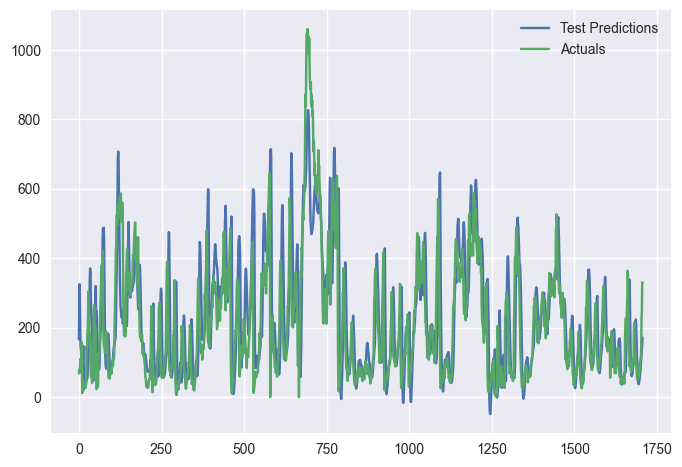

In [36]:
model = load_model('4H_Forecast/4H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(4,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 5 hours forecast

In [37]:
%%time

Trainer(5,6,12,50)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 64)                17920     
                                                                 
 dense_64 (Dense)            (None, 8)                 520       
                                                                 
 dense_65 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 11:49:35.923835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:49:36.057459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:49:36.685700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8555 - mae: 0.6179 - mse: 0.8555 - mape: 163.0540

2023-02-10 11:49:41.346983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:49:41.423694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.57585, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 13s 70ms/step - loss: 0.8555 - mae: 0.6179 - mse: 0.8555 - mape: 163.0540 - val_loss: 0.5758 - val_mae: 0.5636 - val_mse: 0.5758 - val_mape: 152.0498
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6613 - mae: 0.4687 - mse: 0.6613 - mape: 243.8623
Epoch 2: val_loss improved from 0.57585 to 0.46922, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.6613 - mae: 0.4687 - mse: 0.6613 - mape: 243.8623 - val_loss: 0.4692 - val_mae: 0.4933 - val_mse: 0.4692 - val_mape: 158.6233
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6151 - mae: 0.4269 - mse: 0.6151 - mape: 316.0240
Epoch 3: val_loss improved from 0.46922 to 0.45535, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6151 - mae: 0.4269 - mse: 0.6151 - mape: 316.0240 - val_loss: 0.4553 - val_mae: 0.4830 - val_mse: 0.4553 - val_mape: 161.8431
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6001 - mae: 0.4112 - mse: 0.6001 - mape: 354.8098
Epoch 4: val_loss did not improve from 0.45535
161/161 [==============================] - 3s 19ms/step - loss: 0.6001 - mae: 0.4112 - mse: 0.6001 - mape: 354.8098 - val_loss: 0.4586 - val_mae: 0.4841 - val_mse: 0.4586 - val_mape: 160.2209
Epoch 5/50
159/161 [============================>.] - ETA: 0s - loss: 0.5945 - mae: 0.4075 - mse: 0.5945 - mape: 361.6664
Epoch 5: val_loss improved from 0.45535 to 0.45274, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.5912 - mae: 0.4064 - mse: 0.5912 - mape: 360.2975 - val_loss: 0.4527 - val_mae: 0.4821 - val_mse: 0.4527 - val_mape: 156.2820
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5836 - mae: 0.4015 - mse: 0.5836 - mape: 351.7452
Epoch 6: val_loss improved from 0.45274 to 0.45232, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5836 - mae: 0.4015 - mse: 0.5836 - mape: 351.7452 - val_loss: 0.4523 - val_mae: 0.4816 - val_mse: 0.4523 - val_mape: 152.1845
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5771 - mae: 0.3965 - mse: 0.5771 - mape: 356.4026
Epoch 7: val_loss did not improve from 0.45232
161/161 [==============================] - 3s 17ms/step - loss: 0.5771 - mae: 0.3965 - mse: 0.5771 - mape: 356.4026 - val_loss: 0.4567 - val_mae: 0.4847 - val_mse: 0.4567 - val_mape: 147.2681
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5706 - mae: 0.3952 - mse: 0.5706 - mape: 355.5286
Epoch 8: val_loss did not improve from 0.45232
161/161 [==============================] - 3s 18ms/step - loss: 0.5706 - mae: 0.3952 - mse: 0.5706 - mape: 355.5286 - val_loss: 0.4575 - val_mae: 0.4842 - val_mse: 0.4575 - val_mape: 147.1819
Epoch 9/50
158/161 [============================>.] - ETA: 0s - loss: 0.5679 - mae: 0.

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5595 - mae: 0.3894 - mse: 0.5595 - mape: 349.7366 - val_loss: 0.4425 - val_mae: 0.4738 - val_mse: 0.4425 - val_mape: 147.0099
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.5531 - mae: 0.3872 - mse: 0.5531 - mape: 348.4765
Epoch 11: val_loss did not improve from 0.44254
161/161 [==============================] - 3s 17ms/step - loss: 0.5531 - mae: 0.3872 - mse: 0.5531 - mape: 348.4765 - val_loss: 0.4538 - val_mae: 0.4773 - val_mse: 0.4538 - val_mape: 145.7942
Epoch 12/50
160/161 [============================>.] - ETA: 0s - loss: 0.5478 - mae: 0.3832 - mse: 0.5478 - mape: 347.2610
Epoch 12: val_loss did not improve from 0.44254
161/161 [==============================] - 3s 17ms/step - loss: 0.5477 - mae: 0.3832 - mse: 0.5477 - mape: 347.2033 - val_loss: 0.4429 - val_mae: 0.4702 - val_mse: 0.4429 - val_mape: 147.3674
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.5420 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5420 - mae: 0.3803 - mse: 0.5420 - mape: 350.1658 - val_loss: 0.4355 - val_mae: 0.4666 - val_mse: 0.4355 - val_mape: 145.6363
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.5368 - mae: 0.3785 - mse: 0.5368 - mape: 340.3167
Epoch 14: val_loss did not improve from 0.43555
161/161 [==============================] - 3s 19ms/step - loss: 0.5368 - mae: 0.3785 - mse: 0.5368 - mape: 340.3167 - val_loss: 0.4461 - val_mae: 0.4698 - val_mse: 0.4461 - val_mape: 145.4524
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.5324 - mae: 0.3761 - mse: 0.5324 - mape: 344.4775
Epoch 15: val_loss improved from 0.43555 to 0.43378, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5324 - mae: 0.3761 - mse: 0.5324 - mape: 344.4775 - val_loss: 0.4338 - val_mae: 0.4620 - val_mse: 0.4338 - val_mape: 148.9098
Epoch 16/50
160/161 [============================>.] - ETA: 0s - loss: 0.5260 - mae: 0.3733 - mse: 0.5260 - mape: 325.3742
Epoch 16: val_loss improved from 0.43378 to 0.42996, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.5259 - mae: 0.3733 - mse: 0.5259 - mape: 325.3238 - val_loss: 0.4300 - val_mae: 0.4569 - val_mse: 0.4300 - val_mape: 153.5928
Epoch 17/50
160/161 [============================>.] - ETA: 0s - loss: 0.5215 - mae: 0.3716 - mse: 0.5215 - mape: 341.6791
Epoch 17: val_loss improved from 0.42996 to 0.42563, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5214 - mae: 0.3715 - mse: 0.5214 - mape: 341.6125 - val_loss: 0.4256 - val_mae: 0.4560 - val_mse: 0.4256 - val_mape: 152.3831
Epoch 18/50
159/161 [============================>.] - ETA: 0s - loss: 0.5184 - mae: 0.3692 - mse: 0.5184 - mape: 326.5876
Epoch 18: val_loss improved from 0.42563 to 0.42292, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.5160 - mae: 0.3688 - mse: 0.5160 - mape: 327.2177 - val_loss: 0.4229 - val_mae: 0.4513 - val_mse: 0.4229 - val_mape: 156.1137
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.5091 - mae: 0.3654 - mse: 0.5091 - mape: 328.0875
Epoch 19: val_loss did not improve from 0.42292
161/161 [==============================] - 3s 20ms/step - loss: 0.5091 - mae: 0.3654 - mse: 0.5091 - mape: 328.0875 - val_loss: 0.4308 - val_mae: 0.4533 - val_mse: 0.4308 - val_mape: 157.1439
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.5033 - mae: 0.3636 - mse: 0.5033 - mape: 317.2879
Epoch 20: val_loss improved from 0.42292 to 0.41375, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5033 - mae: 0.3636 - mse: 0.5033 - mape: 317.2879 - val_loss: 0.4137 - val_mae: 0.4465 - val_mse: 0.4137 - val_mape: 159.5606
Epoch 21/50
160/161 [============================>.] - ETA: 0s - loss: 0.4971 - mae: 0.3623 - mse: 0.4971 - mape: 316.5177
Epoch 21: val_loss did not improve from 0.41375
161/161 [==============================] - 3s 20ms/step - loss: 0.4970 - mae: 0.3623 - mse: 0.4970 - mape: 316.4585 - val_loss: 0.4228 - val_mae: 0.4471 - val_mse: 0.4228 - val_mape: 162.9629
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.4904 - mae: 0.3581 - mse: 0.4904 - mape: 327.6387
Epoch 22: val_loss did not improve from 0.41375
161/161 [==============================] - 3s 18ms/step - loss: 0.4904 - mae: 0.3581 - mse: 0.4904 - mape: 327.6387 - val_loss: 0.4179 - val_mae: 0.4473 - val_mse: 0.4179 - val_mape: 165.8653
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.4856 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.4792 - mae: 0.3530 - mse: 0.4792 - mape: 298.7477 - val_loss: 0.4108 - val_mae: 0.4429 - val_mse: 0.4108 - val_mape: 169.3783
Epoch 25/50
159/161 [============================>.] - ETA: 0s - loss: 0.4726 - mae: 0.3490 - mse: 0.4726 - mape: 303.3581
Epoch 25: val_loss improved from 0.41083 to 0.39619, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4724 - mae: 0.3494 - mse: 0.4724 - mape: 302.9106 - val_loss: 0.3962 - val_mae: 0.4385 - val_mse: 0.3962 - val_mape: 170.4302
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.4664 - mae: 0.3496 - mse: 0.4664 - mape: 301.9440
Epoch 26: val_loss did not improve from 0.39619
161/161 [==============================] - 3s 19ms/step - loss: 0.4664 - mae: 0.3496 - mse: 0.4664 - mape: 301.9440 - val_loss: 0.3972 - val_mae: 0.4394 - val_mse: 0.3972 - val_mape: 175.2127
Epoch 27/50
161/161 [==============================] - ETA: 0s - loss: 0.4622 - mae: 0.3459 - mse: 0.4622 - mape: 298.0903
Epoch 27: val_loss improved from 0.39619 to 0.39404, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.4622 - mae: 0.3459 - mse: 0.4622 - mape: 298.0903 - val_loss: 0.3940 - val_mae: 0.4408 - val_mse: 0.3940 - val_mape: 175.1698
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.4585 - mae: 0.3456 - mse: 0.4585 - mape: 304.2710
Epoch 28: val_loss improved from 0.39404 to 0.39369, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.4585 - mae: 0.3457 - mse: 0.4585 - mape: 304.2316 - val_loss: 0.3937 - val_mae: 0.4379 - val_mse: 0.3937 - val_mape: 178.1445
Epoch 29/50
160/161 [============================>.] - ETA: 0s - loss: 0.4499 - mae: 0.3415 - mse: 0.4499 - mape: 293.3170
Epoch 29: val_loss did not improve from 0.39369
161/161 [==============================] - 3s 19ms/step - loss: 0.4499 - mae: 0.3415 - mse: 0.4499 - mape: 293.2706 - val_loss: 0.4048 - val_mae: 0.4408 - val_mse: 0.4048 - val_mape: 179.0660
Epoch 30/50
159/161 [============================>.] - ETA: 0s - loss: 0.4504 - mae: 0.3428 - mse: 0.4504 - mape: 293.5234
Epoch 30: val_loss did not improve from 0.39369
161/161 [==============================] - 3s 19ms/step - loss: 0.4480 - mae: 0.3421 - mse: 0.4480 - mape: 292.0385 - val_loss: 0.3951 - val_mae: 0.4390 - val_mse: 0.3951 - val_mape: 177.7657
Epoch 31/50
161/161 [==============================] - ETA: 0s - loss: 0.4410 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.4316 - mae: 0.3361 - mse: 0.4316 - mape: 295.1807 - val_loss: 0.3923 - val_mae: 0.4367 - val_mse: 0.3923 - val_mape: 185.6207
Epoch 34/50
159/161 [============================>.] - ETA: 0s - loss: 0.4278 - mae: 0.3326 - mse: 0.4278 - mape: 290.7071
Epoch 34: val_loss improved from 0.39234 to 0.37986, saving model to 5H_Forecast/5H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4266 - mae: 0.3330 - mse: 0.4266 - mape: 289.5659 - val_loss: 0.3799 - val_mae: 0.4295 - val_mse: 0.3799 - val_mape: 180.7462
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.4234 - mae: 0.3336 - mse: 0.4234 - mape: 286.9361
Epoch 35: val_loss did not improve from 0.37986
161/161 [==============================] - 3s 17ms/step - loss: 0.4234 - mae: 0.3336 - mse: 0.4234 - mape: 286.9361 - val_loss: 0.4086 - val_mae: 0.4430 - val_mse: 0.4086 - val_mape: 190.2882
Epoch 36/50
161/161 [==============================] - ETA: 0s - loss: 0.4193 - mae: 0.3322 - mse: 0.4193 - mape: 282.3179
Epoch 36: val_loss did not improve from 0.37986
161/161 [==============================] - 3s 17ms/step - loss: 0.4193 - mae: 0.3322 - mse: 0.4193 - mape: 282.3179 - val_loss: 0.3941 - val_mae: 0.4368 - val_mse: 0.3941 - val_mape: 193.3485
Epoch 37/50
160/161 [============================>.] - ETA: 0s - loss: 0.4160 - ma

2023-02-10 11:53:31.800732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:53:31.945280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:53:32.375348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9769 - mae: 0.7069 - mse: 0.9769 - mape: 187.2649

2023-02-10 11:53:36.199499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:53:36.265962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.55882, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 11s 57ms/step - loss: 0.9769 - mae: 0.7069 - mse: 0.9769 - mape: 187.2649 - val_loss: 0.5588 - val_mae: 0.5902 - val_mse: 0.5588 - val_mape: 113.0115
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.7273 - mae: 0.5520 - mse: 0.7273 - mape: 179.7227
Epoch 2: val_loss improved from 0.55882 to 0.45088, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.7273 - mae: 0.5520 - mse: 0.7273 - mape: 179.7227 - val_loss: 0.4509 - val_mae: 0.5116 - val_mse: 0.4509 - val_mape: 127.8438
Epoch 3/50
159/161 [============================>.] - ETA: 0s - loss: 0.6451 - mae: 0.4622 - mse: 0.6451 - mape: 232.1390
Epoch 3: val_loss improved from 0.45088 to 0.44462, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.6427 - mae: 0.4616 - mse: 0.6427 - mape: 249.5750 - val_loss: 0.4446 - val_mae: 0.4978 - val_mse: 0.4446 - val_mape: 130.3405
Epoch 4/50
159/161 [============================>.] - ETA: 0s - loss: 0.6156 - mae: 0.4256 - mse: 0.6156 - mape: 270.4918
Epoch 4: val_loss did not improve from 0.44462
161/161 [==============================] - 3s 18ms/step - loss: 0.6134 - mae: 0.4251 - mse: 0.6134 - mape: 269.8326 - val_loss: 0.4540 - val_mae: 0.4975 - val_mse: 0.4540 - val_mape: 132.7516
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.5972 - mae: 0.4114 - mse: 0.5972 - mape: 293.0126
Epoch 5: val_loss did not improve from 0.44462
161/161 [==============================] - 3s 17ms/step - loss: 0.5972 - mae: 0.4114 - mse: 0.5972 - mape: 293.0126 - val_loss: 0.4586 - val_mae: 0.4989 - val_mse: 0.4586 - val_mape: 134.4581
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.5859 - mae: 0.

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4991 - mae: 0.3709 - mse: 0.4991 - mape: 319.9828 - val_loss: 0.4404 - val_mae: 0.4793 - val_mse: 0.4404 - val_mape: 149.5341
Epoch 19/50
160/161 [============================>.] - ETA: 0s - loss: 0.4922 - mae: 0.3674 - mse: 0.4922 - mape: 311.1081
Epoch 19: val_loss improved from 0.44041 to 0.43503, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4921 - mae: 0.3673 - mse: 0.4921 - mape: 311.0490 - val_loss: 0.4350 - val_mae: 0.4757 - val_mse: 0.4350 - val_mape: 152.4137
Epoch 20/50
159/161 [============================>.] - ETA: 0s - loss: 0.4620 - mae: 0.3610 - mse: 0.4620 - mape: 307.0917
Epoch 20: val_loss improved from 0.43503 to 0.42160, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4825 - mae: 0.3629 - mse: 0.4825 - mape: 305.6820 - val_loss: 0.4216 - val_mae: 0.4660 - val_mse: 0.4216 - val_mape: 159.2414
Epoch 21/50
159/161 [============================>.] - ETA: 0s - loss: 0.4751 - mae: 0.3607 - mse: 0.4751 - mape: 322.1590
Epoch 21: val_loss improved from 0.42160 to 0.42036, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4753 - mae: 0.3611 - mse: 0.4753 - mape: 320.5056 - val_loss: 0.4204 - val_mae: 0.4645 - val_mse: 0.4204 - val_mape: 162.7500
Epoch 22/50
161/161 [==============================] - ETA: 0s - loss: 0.4659 - mae: 0.3570 - mse: 0.4659 - mape: 312.3350
Epoch 22: val_loss improved from 0.42036 to 0.41681, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4659 - mae: 0.3570 - mse: 0.4659 - mape: 312.3350 - val_loss: 0.4168 - val_mae: 0.4608 - val_mse: 0.4168 - val_mape: 167.4295
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.4582 - mae: 0.3572 - mse: 0.4582 - mape: 305.2298
Epoch 23: val_loss improved from 0.41681 to 0.41363, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4582 - mae: 0.3572 - mse: 0.4582 - mape: 305.2298 - val_loss: 0.4136 - val_mae: 0.4587 - val_mse: 0.4136 - val_mape: 170.2262
Epoch 24/50
161/161 [==============================] - ETA: 0s - loss: 0.4489 - mae: 0.3550 - mse: 0.4489 - mape: 297.5429
Epoch 24: val_loss improved from 0.41363 to 0.41234, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.4489 - mae: 0.3550 - mse: 0.4489 - mape: 297.5429 - val_loss: 0.4123 - val_mae: 0.4580 - val_mse: 0.4123 - val_mape: 171.3105
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.4447 - mae: 0.3528 - mse: 0.4447 - mape: 283.6168
Epoch 25: val_loss improved from 0.41234 to 0.39492, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4447 - mae: 0.3528 - mse: 0.4447 - mape: 283.6168 - val_loss: 0.3949 - val_mae: 0.4461 - val_mse: 0.3949 - val_mape: 182.3180
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.4366 - mae: 0.3486 - mse: 0.4366 - mape: 291.8100
Epoch 26: val_loss improved from 0.39492 to 0.39016, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.4366 - mae: 0.3486 - mse: 0.4366 - mape: 291.8100 - val_loss: 0.3902 - val_mae: 0.4432 - val_mse: 0.3902 - val_mape: 188.2730
Epoch 27/50
160/161 [============================>.] - ETA: 0s - loss: 0.4303 - mae: 0.3454 - mse: 0.4303 - mape: 299.6118
Epoch 27: val_loss improved from 0.39016 to 0.38411, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.4303 - mae: 0.3454 - mse: 0.4303 - mape: 299.5565 - val_loss: 0.3841 - val_mae: 0.4410 - val_mse: 0.3841 - val_mape: 185.2489
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.4235 - mae: 0.3458 - mse: 0.4235 - mape: 293.8886
Epoch 28: val_loss did not improve from 0.38411
161/161 [==============================] - 3s 19ms/step - loss: 0.4235 - mae: 0.3458 - mse: 0.4235 - mape: 293.8321 - val_loss: 0.3935 - val_mae: 0.4430 - val_mse: 0.3935 - val_mape: 197.4895
Epoch 29/50
161/161 [==============================] - ETA: 0s - loss: 0.4201 - mae: 0.3446 - mse: 0.4201 - mape: 286.2068
Epoch 29: val_loss did not improve from 0.38411
161/161 [==============================] - 3s 21ms/step - loss: 0.4201 - mae: 0.3446 - mse: 0.4201 - mape: 286.2068 - val_loss: 0.3909 - val_mae: 0.4432 - val_mse: 0.3909 - val_mape: 198.6063
Epoch 30/50
159/161 [============================>.] - ETA: 0s - loss: 0.4143 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.3992 - mae: 0.3392 - mse: 0.3992 - mape: 275.6971 - val_loss: 0.3798 - val_mae: 0.4377 - val_mse: 0.3798 - val_mape: 203.1547
Epoch 34/50
161/161 [==============================] - ETA: 0s - loss: 0.3947 - mae: 0.3386 - mse: 0.3947 - mape: 282.1312
Epoch 34: val_loss did not improve from 0.37976
161/161 [==============================] - 3s 21ms/step - loss: 0.3947 - mae: 0.3386 - mse: 0.3947 - mape: 282.1312 - val_loss: 0.3874 - val_mae: 0.4417 - val_mse: 0.3874 - val_mape: 209.4227
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.3899 - mae: 0.3358 - mse: 0.3899 - mape: 276.1017
Epoch 35: val_loss improved from 0.37976 to 0.37822, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.3899 - mae: 0.3358 - mse: 0.3899 - mape: 276.1017 - val_loss: 0.3782 - val_mae: 0.4361 - val_mse: 0.3782 - val_mape: 215.9546
Epoch 36/50
159/161 [============================>.] - ETA: 0s - loss: 0.3891 - mae: 0.3351 - mse: 0.3891 - mape: 284.2392
Epoch 36: val_loss did not improve from 0.37822
161/161 [==============================] - 3s 17ms/step - loss: 0.3876 - mae: 0.3347 - mse: 0.3876 - mape: 282.8589 - val_loss: 0.3911 - val_mae: 0.4420 - val_mse: 0.3911 - val_mape: 217.9815
Epoch 37/50
158/161 [============================>.] - ETA: 0s - loss: 0.3861 - mae: 0.3338 - mse: 0.3861 - mape: 271.5303
Epoch 37: val_loss did not improve from 0.37822
161/161 [==============================] - 3s 17ms/step - loss: 0.3852 - mae: 0.3345 - mse: 0.3852 - mape: 270.4681 - val_loss: 0.3901 - val_mae: 0.4442 - val_mse: 0.3901 - val_mape: 221.6984
Epoch 38/50
161/161 [==============================] - ETA: 0s - loss: 0.3800 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.3726 - mae: 0.3297 - mse: 0.3726 - mape: 262.0024 - val_loss: 0.3740 - val_mae: 0.4341 - val_mse: 0.3740 - val_mape: 219.5370
Epoch 41/50
161/161 [==============================] - ETA: 0s - loss: 0.3701 - mae: 0.3306 - mse: 0.3701 - mape: 279.5233
Epoch 41: val_loss improved from 0.37396 to 0.37041, saving model to 5H_Forecast/5H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 43ms/step - loss: 0.3701 - mae: 0.3306 - mse: 0.3701 - mape: 279.5233 - val_loss: 0.3704 - val_mae: 0.4294 - val_mse: 0.3704 - val_mape: 220.6359
Epoch 42/50
158/161 [============================>.] - ETA: 0s - loss: 0.3684 - mae: 0.3293 - mse: 0.3684 - mape: 260.6545
Epoch 42: val_loss did not improve from 0.37041
161/161 [==============================] - 3s 18ms/step - loss: 0.3670 - mae: 0.3297 - mse: 0.3670 - mape: 259.7135 - val_loss: 0.3727 - val_mae: 0.4321 - val_mse: 0.3727 - val_mape: 221.1293
Epoch 43/50
158/161 [============================>.] - ETA: 0s - loss: 0.3667 - mae: 0.3284 - mse: 0.3667 - mape: 261.9774
Epoch 43: val_loss did not improve from 0.37041
161/161 [==============================] - 3s 17ms/step - loss: 0.3639 - mae: 0.3277 - mse: 0.3639 - mape: 259.8896 - val_loss: 0.3783 - val_mae: 0.4339 - val_mse: 0.3783 - val_mape: 220.4303
Epoch 44/50
159/161 [============================>.] - ETA: 0s - loss: 0.3612 - ma

2023-02-10 11:57:15.066178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:57:15.213116: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:57:15.612265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.8993 - mae: 0.6387 - mse: 0.8993 - mape: 212.9928

2023-02-10 11:57:19.819347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 11:57:19.886927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.58472, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 12s 60ms/step - loss: 0.8993 - mae: 0.6387 - mse: 0.8993 - mape: 212.9928 - val_loss: 0.5847 - val_mae: 0.5703 - val_mse: 0.5847 - val_mape: 135.1923
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.6813 - mae: 0.4714 - mse: 0.6813 - mape: 299.0593
Epoch 2: val_loss improved from 0.58472 to 0.48297, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6813 - mae: 0.4714 - mse: 0.6813 - mape: 299.0593 - val_loss: 0.4830 - val_mae: 0.5129 - val_mse: 0.4830 - val_mape: 152.6475
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6356 - mae: 0.4284 - mse: 0.6356 - mape: 350.9209
Epoch 3: val_loss improved from 0.48297 to 0.46283, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6356 - mae: 0.4284 - mse: 0.6356 - mape: 350.9209 - val_loss: 0.4628 - val_mae: 0.5028 - val_mse: 0.4628 - val_mape: 145.3612
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6213 - mae: 0.4185 - mse: 0.6213 - mape: 356.3828
Epoch 4: val_loss improved from 0.46283 to 0.46131, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6213 - mae: 0.4185 - mse: 0.6213 - mape: 356.3828 - val_loss: 0.4613 - val_mae: 0.5001 - val_mse: 0.4613 - val_mape: 141.5609
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.6104 - mae: 0.4106 - mse: 0.6104 - mape: 362.1336
Epoch 5: val_loss did not improve from 0.46131
161/161 [==============================] - 3s 18ms/step - loss: 0.6104 - mae: 0.4106 - mse: 0.6104 - mape: 362.1336 - val_loss: 0.4655 - val_mae: 0.5033 - val_mse: 0.4655 - val_mape: 139.4613
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.6015 - mae: 0.4043 - mse: 0.6015 - mape: 337.4293
Epoch 6: val_loss improved from 0.46131 to 0.45915, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.6015 - mae: 0.4043 - mse: 0.6015 - mape: 337.4293 - val_loss: 0.4592 - val_mae: 0.4977 - val_mse: 0.4592 - val_mape: 139.5995
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.5930 - mae: 0.3994 - mse: 0.5930 - mape: 343.8436
Epoch 7: val_loss did not improve from 0.45915
161/161 [==============================] - 3s 20ms/step - loss: 0.5930 - mae: 0.3994 - mse: 0.5930 - mape: 343.8436 - val_loss: 0.4612 - val_mae: 0.4986 - val_mse: 0.4612 - val_mape: 136.3020
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.5846 - mae: 0.3959 - mse: 0.5846 - mape: 340.6564
Epoch 8: val_loss improved from 0.45915 to 0.45715, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5846 - mae: 0.3959 - mse: 0.5846 - mape: 340.6564 - val_loss: 0.4571 - val_mae: 0.4950 - val_mse: 0.4571 - val_mape: 139.0556
Epoch 9/50
160/161 [============================>.] - ETA: 0s - loss: 0.5768 - mae: 0.3909 - mse: 0.5768 - mape: 328.9509
Epoch 9: val_loss improved from 0.45715 to 0.45496, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.5767 - mae: 0.3908 - mse: 0.5767 - mape: 328.8985 - val_loss: 0.4550 - val_mae: 0.4931 - val_mse: 0.4550 - val_mape: 138.9729
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.5694 - mae: 0.3885 - mse: 0.5694 - mape: 327.8473
Epoch 10: val_loss improved from 0.45496 to 0.45447, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5694 - mae: 0.3885 - mse: 0.5694 - mape: 327.8473 - val_loss: 0.4545 - val_mae: 0.4919 - val_mse: 0.4545 - val_mape: 140.9094
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.5630 - mae: 0.3835 - mse: 0.5630 - mape: 325.8998
Epoch 11: val_loss did not improve from 0.45447
161/161 [==============================] - 3s 18ms/step - loss: 0.5630 - mae: 0.3835 - mse: 0.5630 - mape: 325.8998 - val_loss: 0.4551 - val_mae: 0.4913 - val_mse: 0.4551 - val_mape: 140.7974
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.5575 - mae: 0.3815 - mse: 0.5575 - mape: 320.6010
Epoch 12: val_loss improved from 0.45447 to 0.44798, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.5575 - mae: 0.3815 - mse: 0.5575 - mape: 320.6010 - val_loss: 0.4480 - val_mae: 0.4867 - val_mse: 0.4480 - val_mape: 143.7494
Epoch 13/50
161/161 [==============================] - ETA: 0s - loss: 0.5515 - mae: 0.3771 - mse: 0.5515 - mape: 315.8217
Epoch 13: val_loss improved from 0.44798 to 0.44619, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.5515 - mae: 0.3771 - mse: 0.5515 - mape: 315.8217 - val_loss: 0.4462 - val_mae: 0.4842 - val_mse: 0.4462 - val_mape: 146.5964
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.5460 - mae: 0.3756 - mse: 0.5460 - mape: 317.4684
Epoch 14: val_loss improved from 0.44619 to 0.43796, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5460 - mae: 0.3756 - mse: 0.5460 - mape: 317.4684 - val_loss: 0.4380 - val_mae: 0.4802 - val_mse: 0.4380 - val_mape: 147.0653
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.5403 - mae: 0.3719 - mse: 0.5403 - mape: 317.3012
Epoch 15: val_loss improved from 0.43796 to 0.43752, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.5403 - mae: 0.3719 - mse: 0.5403 - mape: 317.3012 - val_loss: 0.4375 - val_mae: 0.4805 - val_mse: 0.4375 - val_mape: 145.2303
Epoch 16/50
159/161 [============================>.] - ETA: 0s - loss: 0.5366 - mae: 0.3706 - mse: 0.5366 - mape: 311.9593
Epoch 16: val_loss improved from 0.43752 to 0.42477, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5340 - mae: 0.3700 - mse: 0.5340 - mape: 310.5850 - val_loss: 0.4248 - val_mae: 0.4712 - val_mse: 0.4248 - val_mape: 151.2309
Epoch 17/50
161/161 [==============================] - ETA: 0s - loss: 0.5287 - mae: 0.3686 - mse: 0.5287 - mape: 307.9010
Epoch 17: val_loss did not improve from 0.42477
161/161 [==============================] - 3s 20ms/step - loss: 0.5287 - mae: 0.3686 - mse: 0.5287 - mape: 307.9010 - val_loss: 0.4322 - val_mae: 0.4742 - val_mse: 0.4322 - val_mape: 150.1464
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.5221 - mae: 0.3638 - mse: 0.5221 - mape: 304.1227
Epoch 18: val_loss did not improve from 0.42477
161/161 [==============================] - 3s 19ms/step - loss: 0.5221 - mae: 0.3638 - mse: 0.5221 - mape: 304.1227 - val_loss: 0.4319 - val_mae: 0.4737 - val_mse: 0.4319 - val_mape: 153.4664
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.5155 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4772 - mae: 0.3522 - mse: 0.4772 - mape: 294.3313 - val_loss: 0.4240 - val_mae: 0.4640 - val_mse: 0.4240 - val_mape: 163.0603
Epoch 26/50
161/161 [==============================] - ETA: 0s - loss: 0.4703 - mae: 0.3480 - mse: 0.4703 - mape: 285.6944
Epoch 26: val_loss improved from 0.42401 to 0.41618, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.4703 - mae: 0.3480 - mse: 0.4703 - mape: 285.6944 - val_loss: 0.4162 - val_mae: 0.4612 - val_mse: 0.4162 - val_mape: 160.2499
Epoch 27/50
160/161 [============================>.] - ETA: 0s - loss: 0.4643 - mae: 0.3499 - mse: 0.4643 - mape: 288.3878
Epoch 27: val_loss improved from 0.41618 to 0.41546, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4642 - mae: 0.3498 - mse: 0.4642 - mape: 288.3335 - val_loss: 0.4155 - val_mae: 0.4612 - val_mse: 0.4155 - val_mape: 161.3924
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.4574 - mae: 0.3475 - mse: 0.4574 - mape: 285.9353
Epoch 28: val_loss did not improve from 0.41546
161/161 [==============================] - 3s 19ms/step - loss: 0.4573 - mae: 0.3475 - mse: 0.4573 - mape: 285.8854 - val_loss: 0.4181 - val_mae: 0.4614 - val_mse: 0.4181 - val_mape: 165.2288
Epoch 29/50
159/161 [============================>.] - ETA: 0s - loss: 0.4544 - mae: 0.3471 - mse: 0.4544 - mape: 285.4593
Epoch 29: val_loss improved from 0.41546 to 0.41344, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.4524 - mae: 0.3469 - mse: 0.4524 - mape: 284.4099 - val_loss: 0.4134 - val_mae: 0.4580 - val_mse: 0.4134 - val_mape: 166.7496
Epoch 30/50
160/161 [============================>.] - ETA: 0s - loss: 0.4462 - mae: 0.3426 - mse: 0.4462 - mape: 291.6266
Epoch 30: val_loss did not improve from 0.41344
161/161 [==============================] - 4s 22ms/step - loss: 0.4461 - mae: 0.3425 - mse: 0.4461 - mape: 291.5705 - val_loss: 0.4165 - val_mae: 0.4608 - val_mse: 0.4165 - val_mape: 165.7596
Epoch 31/50
160/161 [============================>.] - ETA: 0s - loss: 0.4403 - mae: 0.3455 - mse: 0.4403 - mape: 289.9013
Epoch 31: val_loss did not improve from 0.41344
161/161 [==============================] - 4s 23ms/step - loss: 0.4402 - mae: 0.3455 - mse: 0.4402 - mape: 289.8516 - val_loss: 0.4193 - val_mae: 0.4593 - val_mse: 0.4193 - val_mape: 173.0288
Epoch 32/50
159/161 [============================>.] - ETA: 0s - loss: 0.4370 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.4294 - mae: 0.3413 - mse: 0.4294 - mape: 286.6185 - val_loss: 0.4122 - val_mae: 0.4574 - val_mse: 0.4122 - val_mape: 169.0255
Epoch 34/50
158/161 [============================>.] - ETA: 0s - loss: 0.4283 - mae: 0.3403 - mse: 0.4283 - mape: 292.0560
Epoch 34: val_loss improved from 0.41220 to 0.40570, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.4249 - mae: 0.3395 - mse: 0.4249 - mape: 292.3456 - val_loss: 0.4057 - val_mae: 0.4520 - val_mse: 0.4057 - val_mape: 172.6804
Epoch 35/50
161/161 [==============================] - ETA: 0s - loss: 0.4193 - mae: 0.3385 - mse: 0.4193 - mape: 288.9167
Epoch 35: val_loss did not improve from 0.40570
161/161 [==============================] - 5s 28ms/step - loss: 0.4193 - mae: 0.3385 - mse: 0.4193 - mape: 288.9167 - val_loss: 0.4111 - val_mae: 0.4549 - val_mse: 0.4111 - val_mape: 173.3234
Epoch 36/50
161/161 [==============================] - ETA: 0s - loss: 0.4148 - mae: 0.3371 - mse: 0.4148 - mape: 284.5070
Epoch 36: val_loss improved from 0.40570 to 0.40324, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.4148 - mae: 0.3371 - mse: 0.4148 - mape: 284.5070 - val_loss: 0.4032 - val_mae: 0.4517 - val_mse: 0.4032 - val_mape: 172.1024
Epoch 37/50
161/161 [==============================] - ETA: 0s - loss: 0.4095 - mae: 0.3344 - mse: 0.4095 - mape: 278.4602
Epoch 37: val_loss did not improve from 0.40324
161/161 [==============================] - 5s 28ms/step - loss: 0.4095 - mae: 0.3344 - mse: 0.4095 - mape: 278.4602 - val_loss: 0.4101 - val_mae: 0.4545 - val_mse: 0.4101 - val_mape: 170.1239
Epoch 38/50
161/161 [==============================] - ETA: 0s - loss: 0.4065 - mae: 0.3367 - mse: 0.4065 - mape: 276.0471
Epoch 38: val_loss improved from 0.40324 to 0.40117, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 56ms/step - loss: 0.4065 - mae: 0.3367 - mse: 0.4065 - mape: 276.0471 - val_loss: 0.4012 - val_mae: 0.4469 - val_mse: 0.4012 - val_mape: 179.3166
Epoch 39/50
161/161 [==============================] - ETA: 0s - loss: 0.4019 - mae: 0.3320 - mse: 0.4019 - mape: 298.2448
Epoch 39: val_loss did not improve from 0.40117
161/161 [==============================] - 3s 19ms/step - loss: 0.4019 - mae: 0.3320 - mse: 0.4019 - mape: 298.2448 - val_loss: 0.4076 - val_mae: 0.4518 - val_mse: 0.4076 - val_mape: 173.3434
Epoch 40/50
158/161 [============================>.] - ETA: 0s - loss: 0.4007 - mae: 0.3362 - mse: 0.4007 - mape: 282.5359
Epoch 40: val_loss did not improve from 0.40117
161/161 [==============================] - 3s 18ms/step - loss: 0.3978 - mae: 0.3358 - mse: 0.3978 - mape: 280.7417 - val_loss: 0.4128 - val_mae: 0.4524 - val_mse: 0.4128 - val_mape: 181.0666
Epoch 41/50
160/161 [============================>.] - ETA: 0s - loss: 0.3929 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.3929 - mae: 0.3333 - mse: 0.3929 - mape: 285.9655 - val_loss: 0.3997 - val_mae: 0.4467 - val_mse: 0.3997 - val_mape: 182.0711
Epoch 42/50
158/161 [============================>.] - ETA: 0s - loss: 0.3920 - mae: 0.3324 - mse: 0.3920 - mape: 273.4333
Epoch 42: val_loss did not improve from 0.39966
161/161 [==============================] - 3s 20ms/step - loss: 0.3897 - mae: 0.3323 - mse: 0.3897 - mape: 270.6725 - val_loss: 0.4026 - val_mae: 0.4474 - val_mse: 0.4026 - val_mape: 178.7748
Epoch 43/50
159/161 [============================>.] - ETA: 0s - loss: 0.3873 - mae: 0.3309 - mse: 0.3873 - mape: 270.0670
Epoch 43: val_loss did not improve from 0.39966
161/161 [==============================] - 3s 18ms/step - loss: 0.3866 - mae: 0.3311 - mse: 0.3866 - mape: 270.0968 - val_loss: 0.4064 - val_mae: 0.4474 - val_mse: 0.4064 - val_mape: 183.6678
Epoch 44/50
159/161 [============================>.] - ETA: 0s - loss: 0.3850 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 9s 53ms/step - loss: 0.3767 - mae: 0.3289 - mse: 0.3767 - mape: 267.9772 - val_loss: 0.3978 - val_mae: 0.4429 - val_mse: 0.3978 - val_mape: 180.6191
Epoch 47/50
161/161 [==============================] - ETA: 0s - loss: 0.3719 - mae: 0.3265 - mse: 0.3719 - mape: 264.7181
Epoch 47: val_loss improved from 0.39781 to 0.39006, saving model to 5H_Forecast/5H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_8_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.3719 - mae: 0.3265 - mse: 0.3719 - mape: 264.7181 - val_loss: 0.3901 - val_mae: 0.4396 - val_mse: 0.3901 - val_mape: 179.8664
Epoch 48/50
161/161 [==============================] - ETA: 0s - loss: 0.3697 - mae: 0.3239 - mse: 0.3697 - mape: 259.2111
Epoch 48: val_loss did not improve from 0.39006
161/161 [==============================] - 3s 21ms/step - loss: 0.3697 - mae: 0.3239 - mse: 0.3697 - mape: 259.2111 - val_loss: 0.3989 - val_mae: 0.4436 - val_mse: 0.3989 - val_mape: 184.5013
Epoch 49/50
158/161 [============================>.] - ETA: 0s - loss: 0.3685 - mae: 0.3275 - mse: 0.3685 - mape: 272.1385
Epoch 49: val_loss did not improve from 0.39006
161/161 [==============================] - 3s 19ms/step - loss: 0.3680 - mae: 0.3278 - mse: 0.3680 - mape: 270.3502 - val_loss: 0.4009 - val_mae: 0.4442 - val_mse: 0.4009 - val_mape: 189.6917
Epoch 50/50
160/161 [============================>.] - ETA: 0s - loss: 0.3645 - ma

2023-02-10 12:01:54.257598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:01:54.437480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:01:54.810483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


157/160 [============================>.] - ETA: 0s - loss: 0.8573 - mae: 0.6145 - mse: 0.8573 - mape: 146.2744

2023-02-10 12:01:59.111671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:01:59.236971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.63603, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 12s 66ms/step - loss: 0.8486 - mae: 0.6124 - mse: 0.8486 - mape: 145.1414 - val_loss: 0.6360 - val_mae: 0.6249 - val_mse: 0.6360 - val_mape: 113.1031
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 0.6632 - mae: 0.4632 - mse: 0.6632 - mape: 201.4659
Epoch 2: val_loss improved from 0.63603 to 0.51624, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 53ms/step - loss: 0.6637 - mae: 0.4637 - mse: 0.6637 - mape: 201.2845 - val_loss: 0.5162 - val_mae: 0.5443 - val_mse: 0.5162 - val_mape: 119.2944
Epoch 3/50
157/160 [============================>.] - ETA: 0s - loss: 0.6367 - mae: 0.4317 - mse: 0.6367 - mape: 314.4039
Epoch 3: val_loss improved from 0.51624 to 0.50720, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.6300 - mae: 0.4312 - mse: 0.6300 - mape: 310.8877 - val_loss: 0.5072 - val_mae: 0.5354 - val_mse: 0.5072 - val_mape: 119.9798
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6141 - mae: 0.4189 - mse: 0.6141 - mape: 333.9562
Epoch 4: val_loss improved from 0.50720 to 0.49025, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 9s 54ms/step - loss: 0.6141 - mae: 0.4189 - mse: 0.6141 - mape: 333.9562 - val_loss: 0.4902 - val_mae: 0.5231 - val_mse: 0.4902 - val_mape: 124.2949
Epoch 5/50
158/160 [============================>.] - ETA: 0s - loss: 0.6075 - mae: 0.4118 - mse: 0.6075 - mape: 338.0753
Epoch 5: val_loss improved from 0.49025 to 0.48305, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.6025 - mae: 0.4110 - mse: 0.6025 - mape: 335.4819 - val_loss: 0.4830 - val_mae: 0.5184 - val_mse: 0.4830 - val_mape: 123.9850
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5935 - mae: 0.4068 - mse: 0.5935 - mape: 328.3051
Epoch 6: val_loss improved from 0.48305 to 0.46995, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.5935 - mae: 0.4068 - mse: 0.5935 - mape: 328.3051 - val_loss: 0.4699 - val_mae: 0.5105 - val_mse: 0.4699 - val_mape: 123.1715
Epoch 7/50
159/160 [============================>.] - ETA: 0s - loss: 0.5876 - mae: 0.4010 - mse: 0.5876 - mape: 322.5468
Epoch 7: val_loss improved from 0.46995 to 0.44434, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5850 - mae: 0.4004 - mse: 0.5850 - mape: 321.7174 - val_loss: 0.4443 - val_mae: 0.4932 - val_mse: 0.4443 - val_mape: 128.4601
Epoch 8/50
158/160 [============================>.] - ETA: 0s - loss: 0.5816 - mae: 0.3972 - mse: 0.5816 - mape: 329.1942
Epoch 8: val_loss improved from 0.44434 to 0.43107, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5779 - mae: 0.3969 - mse: 0.5779 - mape: 327.1971 - val_loss: 0.4311 - val_mae: 0.4846 - val_mse: 0.4311 - val_mape: 127.4621
Epoch 9/50
158/160 [============================>.] - ETA: 0s - loss: 0.5755 - mae: 0.3911 - mse: 0.5755 - mape: 327.0826
Epoch 9: val_loss did not improve from 0.43107
160/160 [==============================] - 3s 16ms/step - loss: 0.5704 - mae: 0.3900 - mse: 0.5704 - mape: 324.5404 - val_loss: 0.4350 - val_mae: 0.4879 - val_mse: 0.4350 - val_mape: 125.4197
Epoch 10/50
159/160 [============================>.] - ETA: 0s - loss: 0.5648 - mae: 0.3875 - mse: 0.5648 - mape: 313.9196
Epoch 10: val_loss improved from 0.43107 to 0.41683, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5636 - mae: 0.3875 - mse: 0.5636 - mape: 312.9292 - val_loss: 0.4168 - val_mae: 0.4744 - val_mse: 0.4168 - val_mape: 128.5241
Epoch 11/50
158/160 [============================>.] - ETA: 0s - loss: 0.5615 - mae: 0.3848 - mse: 0.5615 - mape: 312.3675
Epoch 11: val_loss did not improve from 0.41683
160/160 [==============================] - 3s 17ms/step - loss: 0.5568 - mae: 0.3838 - mse: 0.5568 - mape: 316.6503 - val_loss: 0.4193 - val_mae: 0.4763 - val_mse: 0.4193 - val_mape: 129.2692
Epoch 12/50
159/160 [============================>.] - ETA: 0s - loss: 0.5518 - mae: 0.3795 - mse: 0.5518 - mape: 317.7097
Epoch 12: val_loss improved from 0.41683 to 0.40601, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5498 - mae: 0.3795 - mse: 0.5498 - mape: 317.0202 - val_loss: 0.4060 - val_mae: 0.4668 - val_mse: 0.4060 - val_mape: 133.3259
Epoch 13/50
159/160 [============================>.] - ETA: 0s - loss: 0.5455 - mae: 0.3759 - mse: 0.5455 - mape: 305.0110
Epoch 13: val_loss improved from 0.40601 to 0.39564, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.5433 - mae: 0.3753 - mse: 0.5433 - mape: 303.7139 - val_loss: 0.3956 - val_mae: 0.4618 - val_mse: 0.3956 - val_mape: 133.3009
Epoch 14/50
158/160 [============================>.] - ETA: 0s - loss: 0.5394 - mae: 0.3739 - mse: 0.5394 - mape: 299.6514
Epoch 14: val_loss improved from 0.39564 to 0.38938, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.5374 - mae: 0.3747 - mse: 0.5374 - mape: 298.2410 - val_loss: 0.3894 - val_mae: 0.4574 - val_mse: 0.3894 - val_mape: 137.5214
Epoch 15/50
157/160 [============================>.] - ETA: 0s - loss: 0.4962 - mae: 0.3671 - mse: 0.4962 - mape: 303.2376
Epoch 15: val_loss did not improve from 0.38938
160/160 [==============================] - 3s 17ms/step - loss: 0.5300 - mae: 0.3699 - mse: 0.5300 - mape: 300.0327 - val_loss: 0.3934 - val_mae: 0.4577 - val_mse: 0.3934 - val_mape: 141.8449
Epoch 16/50
159/160 [============================>.] - ETA: 0s - loss: 0.5254 - mae: 0.3675 - mse: 0.5254 - mape: 294.5425
Epoch 16: val_loss improved from 0.38938 to 0.37818, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5231 - mae: 0.3671 - mse: 0.5231 - mape: 293.2608 - val_loss: 0.3782 - val_mae: 0.4462 - val_mse: 0.3782 - val_mape: 146.5063
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.5173 - mae: 0.3644 - mse: 0.5173 - mape: 294.0204
Epoch 17: val_loss did not improve from 0.37818
160/160 [==============================] - 3s 17ms/step - loss: 0.5173 - mae: 0.3644 - mse: 0.5173 - mape: 294.0204 - val_loss: 0.3819 - val_mae: 0.4473 - val_mse: 0.3819 - val_mape: 149.8615
Epoch 18/50
158/160 [============================>.] - ETA: 0s - loss: 0.5117 - mae: 0.3618 - mse: 0.5117 - mape: 293.8014
Epoch 18: val_loss improved from 0.37818 to 0.37609, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5113 - mae: 0.3623 - mse: 0.5113 - mape: 291.0563 - val_loss: 0.3761 - val_mae: 0.4440 - val_mse: 0.3761 - val_mape: 153.9567
Epoch 19/50
158/160 [============================>.] - ETA: 0s - loss: 0.5061 - mae: 0.3596 - mse: 0.5061 - mape: 280.5299
Epoch 19: val_loss improved from 0.37609 to 0.36047, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5049 - mae: 0.3601 - mse: 0.5049 - mape: 279.1422 - val_loss: 0.3605 - val_mae: 0.4341 - val_mse: 0.3605 - val_mape: 158.2087
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.4992 - mae: 0.3587 - mse: 0.4992 - mape: 284.7766
Epoch 20: val_loss did not improve from 0.36047
160/160 [==============================] - 3s 19ms/step - loss: 0.4992 - mae: 0.3587 - mse: 0.4992 - mape: 284.7766 - val_loss: 0.3668 - val_mae: 0.4358 - val_mse: 0.3668 - val_mape: 159.9494
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.4929 - mae: 0.3566 - mse: 0.4929 - mape: 287.9724
Epoch 21: val_loss improved from 0.36047 to 0.35763, saving model to 5H_Forecast/5H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.4929 - mae: 0.3566 - mse: 0.4929 - mape: 287.9724 - val_loss: 0.3576 - val_mae: 0.4311 - val_mse: 0.3576 - val_mape: 165.3943
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.4865 - mae: 0.3545 - mse: 0.4865 - mape: 282.6357
Epoch 22: val_loss did not improve from 0.35763
160/160 [==============================] - 3s 17ms/step - loss: 0.4865 - mae: 0.3545 - mse: 0.4865 - mape: 282.6357 - val_loss: 0.3709 - val_mae: 0.4385 - val_mse: 0.3709 - val_mape: 167.2637
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.4809 - mae: 0.3505 - mse: 0.4809 - mape: 277.0448
Epoch 23: val_loss did not improve from 0.35763
160/160 [==============================] - 3s 16ms/step - loss: 0.4809 - mae: 0.3505 - mse: 0.4809 - mape: 277.0448 - val_loss: 0.3583 - val_mae: 0.4313 - val_mse: 0.3583 - val_mape: 168.4366
Epoch 24/50
157/160 [============================>.] - ETA: 0s - loss: 0.4781 - ma

2023-02-10 12:05:38.056443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:05:38.202300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:05:38.678735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8525 - mae: 0.6173 - mse: 0.8525 - mape: 147.7153

2023-02-10 12:05:43.118218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:05:43.172703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.69423, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 12s 62ms/step - loss: 0.8525 - mae: 0.6173 - mse: 0.8525 - mape: 147.7153 - val_loss: 0.6942 - val_mae: 0.6364 - val_mse: 0.6942 - val_mape: 118.8751
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6558 - mae: 0.4512 - mse: 0.6558 - mape: 273.5257
Epoch 2: val_loss improved from 0.69423 to 0.55513, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6558 - mae: 0.4512 - mse: 0.6558 - mape: 273.5257 - val_loss: 0.5551 - val_mae: 0.5494 - val_mse: 0.5551 - val_mape: 133.0756
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6241 - mae: 0.4239 - mse: 0.6241 - mape: 309.2083
Epoch 3: val_loss improved from 0.55513 to 0.53541, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6241 - mae: 0.4239 - mse: 0.6241 - mape: 309.2083 - val_loss: 0.5354 - val_mae: 0.5345 - val_mse: 0.5354 - val_mape: 135.7864
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6074 - mae: 0.4136 - mse: 0.6074 - mape: 323.1163
Epoch 4: val_loss improved from 0.53541 to 0.50844, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6074 - mae: 0.4136 - mse: 0.6074 - mape: 323.1163 - val_loss: 0.5084 - val_mae: 0.5177 - val_mse: 0.5084 - val_mape: 125.8179
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5953 - mae: 0.4041 - mse: 0.5953 - mape: 322.1312
Epoch 5: val_loss improved from 0.50844 to 0.49128, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 52ms/step - loss: 0.5953 - mae: 0.4041 - mse: 0.5953 - mape: 322.1312 - val_loss: 0.4913 - val_mae: 0.5062 - val_mse: 0.4913 - val_mape: 129.5205
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5853 - mae: 0.3972 - mse: 0.5853 - mape: 323.7477
Epoch 6: val_loss improved from 0.49128 to 0.46631, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.5853 - mae: 0.3972 - mse: 0.5853 - mape: 323.7477 - val_loss: 0.4663 - val_mae: 0.4934 - val_mse: 0.4663 - val_mape: 132.5444
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5763 - mae: 0.3924 - mse: 0.5763 - mape: 315.9166
Epoch 7: val_loss did not improve from 0.46631
160/160 [==============================] - 3s 19ms/step - loss: 0.5763 - mae: 0.3924 - mse: 0.5763 - mape: 315.9166 - val_loss: 0.4706 - val_mae: 0.4959 - val_mse: 0.4706 - val_mape: 133.1103
Epoch 8/50
159/160 [============================>.] - ETA: 0s - loss: 0.5703 - mae: 0.3921 - mse: 0.5703 - mape: 321.5357
Epoch 8: val_loss improved from 0.46631 to 0.45390, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5682 - mae: 0.3920 - mse: 0.5682 - mape: 321.4821 - val_loss: 0.4539 - val_mae: 0.4829 - val_mse: 0.4539 - val_mape: 135.6979
Epoch 9/50
158/160 [============================>.] - ETA: 0s - loss: 0.5602 - mae: 0.3815 - mse: 0.5602 - mape: 316.8029
Epoch 9: val_loss did not improve from 0.45390
160/160 [==============================] - 3s 20ms/step - loss: 0.5598 - mae: 0.3820 - mse: 0.5598 - mape: 314.4683 - val_loss: 0.4589 - val_mae: 0.4844 - val_mse: 0.4589 - val_mape: 140.3548
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5527 - mae: 0.3796 - mse: 0.5527 - mape: 314.1763
Epoch 10: val_loss improved from 0.45390 to 0.43593, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5527 - mae: 0.3796 - mse: 0.5527 - mape: 314.1763 - val_loss: 0.4359 - val_mae: 0.4728 - val_mse: 0.4359 - val_mape: 144.6467
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5456 - mae: 0.3750 - mse: 0.5456 - mape: 312.0268
Epoch 11: val_loss did not improve from 0.43593
160/160 [==============================] - 3s 20ms/step - loss: 0.5456 - mae: 0.3750 - mse: 0.5456 - mape: 312.0268 - val_loss: 0.4597 - val_mae: 0.4841 - val_mse: 0.4597 - val_mape: 147.7407
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5388 - mae: 0.3716 - mse: 0.5388 - mape: 303.2483
Epoch 12: val_loss did not improve from 0.43593
160/160 [==============================] - 4s 22ms/step - loss: 0.5388 - mae: 0.3716 - mse: 0.5388 - mape: 303.2483 - val_loss: 0.4383 - val_mae: 0.4719 - val_mse: 0.4383 - val_mape: 152.2963
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5320 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5320 - mae: 0.3684 - mse: 0.5320 - mape: 306.0276 - val_loss: 0.4346 - val_mae: 0.4682 - val_mse: 0.4346 - val_mape: 157.1297
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5256 - mae: 0.3650 - mse: 0.5256 - mape: 307.9106
Epoch 14: val_loss did not improve from 0.43459
160/160 [==============================] - 3s 19ms/step - loss: 0.5256 - mae: 0.3650 - mse: 0.5256 - mape: 307.9106 - val_loss: 0.4374 - val_mae: 0.4690 - val_mse: 0.4374 - val_mape: 159.4072
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.5195 - mae: 0.3640 - mse: 0.5195 - mape: 301.9638
Epoch 15: val_loss did not improve from 0.43459
160/160 [==============================] - 3s 19ms/step - loss: 0.5195 - mae: 0.3640 - mse: 0.5195 - mape: 301.9638 - val_loss: 0.4353 - val_mae: 0.4659 - val_mse: 0.4353 - val_mape: 164.5593
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.5118 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 52ms/step - loss: 0.4905 - mae: 0.3532 - mse: 0.4905 - mape: 286.7792 - val_loss: 0.4305 - val_mae: 0.4591 - val_mse: 0.4305 - val_mape: 179.8545
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.4832 - mae: 0.3543 - mse: 0.4832 - mape: 286.5027
Epoch 20: val_loss did not improve from 0.43055
160/160 [==============================] - 4s 25ms/step - loss: 0.4832 - mae: 0.3543 - mse: 0.4832 - mape: 286.5027 - val_loss: 0.4324 - val_mae: 0.4595 - val_mse: 0.4324 - val_mape: 180.4704
Epoch 21/50
159/160 [============================>.] - ETA: 0s - loss: 0.4774 - mae: 0.3520 - mse: 0.4774 - mape: 286.8508
Epoch 21: val_loss did not improve from 0.43055
160/160 [==============================] - 3s 22ms/step - loss: 0.4758 - mae: 0.3518 - mse: 0.4758 - mape: 285.4183 - val_loss: 0.4425 - val_mae: 0.4619 - val_mse: 0.4425 - val_mape: 182.7039
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.4674 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4674 - mae: 0.3469 - mse: 0.4674 - mape: 284.0645 - val_loss: 0.4261 - val_mae: 0.4537 - val_mse: 0.4261 - val_mape: 185.0137
Epoch 23/50
157/160 [============================>.] - ETA: 0s - loss: 0.4052 - mae: 0.3437 - mse: 0.4052 - mape: 275.4158
Epoch 23: val_loss did not improve from 0.42614
160/160 [==============================] - 3s 18ms/step - loss: 0.4612 - mae: 0.3467 - mse: 0.4612 - mape: 273.9276 - val_loss: 0.4357 - val_mae: 0.4568 - val_mse: 0.4357 - val_mape: 191.1163
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.4537 - mae: 0.3455 - mse: 0.4537 - mape: 272.9391
Epoch 24: val_loss improved from 0.42614 to 0.41727, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4537 - mae: 0.3455 - mse: 0.4537 - mape: 272.9391 - val_loss: 0.4173 - val_mae: 0.4480 - val_mse: 0.4173 - val_mape: 194.0241
Epoch 25/50
159/160 [============================>.] - ETA: 0s - loss: 0.4474 - mae: 0.3408 - mse: 0.4474 - mape: 268.7240
Epoch 25: val_loss improved from 0.41727 to 0.41538, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.4453 - mae: 0.3403 - mse: 0.4453 - mape: 268.6085 - val_loss: 0.4154 - val_mae: 0.4460 - val_mse: 0.4154 - val_mape: 193.7444
Epoch 26/50
157/160 [============================>.] - ETA: 0s - loss: 0.4437 - mae: 0.3432 - mse: 0.4437 - mape: 270.5095
Epoch 26: val_loss did not improve from 0.41538
160/160 [==============================] - 3s 19ms/step - loss: 0.4390 - mae: 0.3427 - mse: 0.4390 - mape: 267.8719 - val_loss: 0.4287 - val_mae: 0.4514 - val_mse: 0.4287 - val_mape: 198.0419
Epoch 27/50
158/160 [============================>.] - ETA: 0s - loss: 0.4356 - mae: 0.3385 - mse: 0.4356 - mape: 260.1201
Epoch 27: val_loss did not improve from 0.41538
160/160 [==============================] - 4s 22ms/step - loss: 0.4328 - mae: 0.3383 - mse: 0.4328 - mape: 257.8075 - val_loss: 0.4161 - val_mae: 0.4445 - val_mse: 0.4161 - val_mape: 202.3230
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.4263 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.4246 - mae: 0.3372 - mse: 0.4246 - mape: 258.5770 - val_loss: 0.3993 - val_mae: 0.4364 - val_mse: 0.3993 - val_mape: 205.4059
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.4118 - mae: 0.3350 - mse: 0.4118 - mape: 254.4622
Epoch 29: val_loss did not improve from 0.39932
160/160 [==============================] - 4s 22ms/step - loss: 0.4118 - mae: 0.3350 - mse: 0.4118 - mape: 254.4622 - val_loss: 0.4192 - val_mae: 0.4460 - val_mse: 0.4192 - val_mape: 206.7447
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.4014 - mae: 0.3322 - mse: 0.4014 - mape: 240.1124
Epoch 30: val_loss did not improve from 0.39932
160/160 [==============================] - 3s 21ms/step - loss: 0.4014 - mae: 0.3322 - mse: 0.4014 - mape: 240.1124 - val_loss: 0.4242 - val_mae: 0.4496 - val_mse: 0.4242 - val_mape: 205.4428
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.3924 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 9s 57ms/step - loss: 0.3780 - mae: 0.3294 - mse: 0.3780 - mape: 245.2972 - val_loss: 0.3905 - val_mae: 0.4333 - val_mse: 0.3905 - val_mape: 214.9171
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.3706 - mae: 0.3280 - mse: 0.3706 - mape: 243.1489
Epoch 34: val_loss did not improve from 0.39053
160/160 [==============================] - 3s 20ms/step - loss: 0.3706 - mae: 0.3280 - mse: 0.3706 - mape: 243.1489 - val_loss: 0.3935 - val_mae: 0.4340 - val_mse: 0.3935 - val_mape: 215.6354
Epoch 35/50
159/160 [============================>.] - ETA: 0s - loss: 0.3655 - mae: 0.3253 - mse: 0.3655 - mape: 238.4261
Epoch 35: val_loss improved from 0.39053 to 0.39009, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.3646 - mae: 0.3254 - mse: 0.3646 - mape: 237.5059 - val_loss: 0.3901 - val_mae: 0.4329 - val_mse: 0.3901 - val_mape: 214.9895
Epoch 36/50
160/160 [==============================] - ETA: 0s - loss: 0.3600 - mae: 0.3241 - mse: 0.3600 - mape: 236.8907
Epoch 36: val_loss did not improve from 0.39009
160/160 [==============================] - 3s 19ms/step - loss: 0.3600 - mae: 0.3241 - mse: 0.3600 - mape: 236.8907 - val_loss: 0.3987 - val_mae: 0.4364 - val_mse: 0.3987 - val_mape: 217.5447
Epoch 37/50
157/160 [============================>.] - ETA: 0s - loss: 0.3600 - mae: 0.3296 - mse: 0.3600 - mape: 234.3907
Epoch 37: val_loss did not improve from 0.39009
160/160 [==============================] - 3s 18ms/step - loss: 0.3559 - mae: 0.3284 - mse: 0.3559 - mape: 231.3730 - val_loss: 0.3960 - val_mae: 0.4338 - val_mse: 0.3960 - val_mape: 221.4429
Epoch 38/50
160/160 [==============================] - ETA: 0s - loss: 0.3508 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 52ms/step - loss: 0.3508 - mae: 0.3215 - mse: 0.3508 - mape: 232.7078 - val_loss: 0.3876 - val_mae: 0.4307 - val_mse: 0.3876 - val_mape: 220.2383
Epoch 39/50
159/160 [============================>.] - ETA: 0s - loss: 0.3474 - mae: 0.3216 - mse: 0.3474 - mape: 230.8552
Epoch 39: val_loss did not improve from 0.38764
160/160 [==============================] - 3s 21ms/step - loss: 0.3463 - mae: 0.3214 - mse: 0.3463 - mape: 230.0029 - val_loss: 0.4035 - val_mae: 0.4372 - val_mse: 0.4035 - val_mape: 220.6942
Epoch 40/50
158/160 [============================>.] - ETA: 0s - loss: 0.3460 - mae: 0.3216 - mse: 0.3460 - mape: 242.8992
Epoch 40: val_loss improved from 0.38764 to 0.38743, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.3439 - mae: 0.3213 - mse: 0.3439 - mape: 241.4989 - val_loss: 0.3874 - val_mae: 0.4300 - val_mse: 0.3874 - val_mape: 223.4568
Epoch 41/50
159/160 [============================>.] - ETA: 0s - loss: 0.3391 - mae: 0.3190 - mse: 0.3391 - mape: 233.7224
Epoch 41: val_loss improved from 0.38743 to 0.38564, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.3390 - mae: 0.3193 - mse: 0.3390 - mape: 233.0723 - val_loss: 0.3856 - val_mae: 0.4314 - val_mse: 0.3856 - val_mape: 223.4787
Epoch 42/50
159/160 [============================>.] - ETA: 0s - loss: 0.3369 - mae: 0.3182 - mse: 0.3369 - mape: 230.6039
Epoch 42: val_loss improved from 0.38564 to 0.38232, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 9s 54ms/step - loss: 0.3362 - mae: 0.3186 - mse: 0.3362 - mape: 231.4346 - val_loss: 0.3823 - val_mae: 0.4274 - val_mse: 0.3823 - val_mape: 229.5942
Epoch 43/50
158/160 [============================>.] - ETA: 0s - loss: 0.3360 - mae: 0.3174 - mse: 0.3360 - mape: 238.9767
Epoch 43: val_loss improved from 0.38232 to 0.38140, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 53ms/step - loss: 0.3335 - mae: 0.3171 - mse: 0.3335 - mape: 238.0257 - val_loss: 0.3814 - val_mae: 0.4290 - val_mse: 0.3814 - val_mape: 229.2256
Epoch 44/50
160/160 [==============================] - ETA: 0s - loss: 0.3309 - mae: 0.3179 - mse: 0.3309 - mape: 235.6456
Epoch 44: val_loss did not improve from 0.38140
160/160 [==============================] - 3s 21ms/step - loss: 0.3309 - mae: 0.3179 - mse: 0.3309 - mape: 235.6456 - val_loss: 0.3977 - val_mae: 0.4364 - val_mse: 0.3977 - val_mape: 229.0235
Epoch 45/50
160/160 [==============================] - ETA: 0s - loss: 0.3283 - mae: 0.3141 - mse: 0.3283 - mape: 232.9371
Epoch 45: val_loss improved from 0.38140 to 0.37564, saving model to 5H_Forecast/5H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.3283 - mae: 0.3141 - mse: 0.3283 - mape: 232.9371 - val_loss: 0.3756 - val_mae: 0.4254 - val_mse: 0.3756 - val_mape: 231.1568
Epoch 46/50
158/160 [============================>.] - ETA: 0s - loss: 0.3279 - mae: 0.3160 - mse: 0.3279 - mape: 237.0920
Epoch 46: val_loss did not improve from 0.37564
160/160 [==============================] - 4s 22ms/step - loss: 0.3250 - mae: 0.3148 - mse: 0.3250 - mape: 235.9045 - val_loss: 0.3792 - val_mae: 0.4279 - val_mse: 0.3792 - val_mape: 235.9749
Epoch 47/50
159/160 [============================>.] - ETA: 0s - loss: 0.3236 - mae: 0.3125 - mse: 0.3236 - mape: 228.3662
Epoch 47: val_loss did not improve from 0.37564
160/160 [==============================] - 3s 18ms/step - loss: 0.3229 - mae: 0.3126 - mse: 0.3229 - mape: 228.6012 - val_loss: 0.3820 - val_mae: 0.4283 - val_mse: 0.3820 - val_mape: 237.2857
Epoch 48/50
158/160 [============================>.] - ETA: 0s - loss: 0.3152 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 53ms/step - loss: 0.3183 - mae: 0.3118 - mse: 0.3183 - mape: 232.9662 - val_loss: 0.3726 - val_mae: 0.4248 - val_mse: 0.3726 - val_mape: 239.5992
Epoch 50/50
158/160 [============================>.] - ETA: 0s - loss: 0.3169 - mae: 0.3109 - mse: 0.3169 - mape: 231.2945
Epoch 50: val_loss did not improve from 0.37265
160/160 [==============================] - 4s 23ms/step - loss: 0.3160 - mae: 0.3114 - mse: 0.3160 - mape: 230.0382 - val_loss: 0.3881 - val_mae: 0.4329 - val_mse: 0.3881 - val_mape: 241.2307

-----------------------------------------------------------------------------------------------------------

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 64)                17920     
                                                                 
 dense_74 (Dense)            (None, 8)          

2023-02-10 12:10:15.045453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:10:15.265142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:10:15.725672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8723 - mae: 0.6092 - mse: 0.8723 - mape: 151.6960

2023-02-10 12:10:19.865331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:10:19.919214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.51063, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 12s 63ms/step - loss: 0.8723 - mae: 0.6092 - mse: 0.8723 - mape: 151.6960 - val_loss: 0.5106 - val_mae: 0.5372 - val_mse: 0.5106 - val_mape: 160.5023
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6696 - mae: 0.4640 - mse: 0.6696 - mape: 267.1061
Epoch 2: val_loss improved from 0.51063 to 0.42650, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6696 - mae: 0.4640 - mse: 0.6696 - mape: 267.1061 - val_loss: 0.4265 - val_mae: 0.4831 - val_mse: 0.4265 - val_mape: 161.4390
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6304 - mae: 0.4327 - mse: 0.6304 - mape: 319.0624
Epoch 3: val_loss improved from 0.42650 to 0.41359, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 9s 54ms/step - loss: 0.6304 - mae: 0.4327 - mse: 0.6304 - mape: 319.0624 - val_loss: 0.4136 - val_mae: 0.4736 - val_mse: 0.4136 - val_mape: 154.9844
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6098 - mae: 0.4168 - mse: 0.6098 - mape: 345.3892
Epoch 4: val_loss improved from 0.41359 to 0.40228, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 9s 56ms/step - loss: 0.6098 - mae: 0.4168 - mse: 0.6098 - mape: 345.3892 - val_loss: 0.4023 - val_mae: 0.4675 - val_mse: 0.4023 - val_mape: 152.5719
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5957 - mae: 0.4056 - mse: 0.5957 - mape: 346.4500
Epoch 5: val_loss improved from 0.40228 to 0.40227, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 11s 69ms/step - loss: 0.5957 - mae: 0.4056 - mse: 0.5957 - mape: 346.4500 - val_loss: 0.4023 - val_mae: 0.4670 - val_mse: 0.4023 - val_mape: 149.1118
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5837 - mae: 0.3977 - mse: 0.5837 - mape: 329.9902
Epoch 6: val_loss improved from 0.40227 to 0.39623, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5837 - mae: 0.3977 - mse: 0.5837 - mape: 329.9902 - val_loss: 0.3962 - val_mae: 0.4616 - val_mse: 0.3962 - val_mape: 148.4913
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5747 - mae: 0.3932 - mse: 0.5747 - mape: 337.1233
Epoch 7: val_loss improved from 0.39623 to 0.38625, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.5747 - mae: 0.3932 - mse: 0.5747 - mape: 337.1233 - val_loss: 0.3863 - val_mae: 0.4571 - val_mse: 0.3863 - val_mape: 146.6111
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5663 - mae: 0.3902 - mse: 0.5663 - mape: 328.4191
Epoch 8: val_loss improved from 0.38625 to 0.38331, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5663 - mae: 0.3902 - mse: 0.5663 - mape: 328.4191 - val_loss: 0.3833 - val_mae: 0.4529 - val_mse: 0.3833 - val_mape: 147.7179
Epoch 9/50
157/160 [============================>.] - ETA: 0s - loss: 0.5640 - mae: 0.3849 - mse: 0.5640 - mape: 329.7069
Epoch 9: val_loss improved from 0.38331 to 0.37568, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5583 - mae: 0.3841 - mse: 0.5583 - mape: 326.9690 - val_loss: 0.3757 - val_mae: 0.4487 - val_mse: 0.3757 - val_mape: 150.5191
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5514 - mae: 0.3791 - mse: 0.5514 - mape: 309.3496
Epoch 10: val_loss improved from 0.37568 to 0.37213, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5514 - mae: 0.3791 - mse: 0.5514 - mape: 309.3496 - val_loss: 0.3721 - val_mae: 0.4452 - val_mse: 0.3721 - val_mape: 151.1639
Epoch 11/50
159/160 [============================>.] - ETA: 0s - loss: 0.5465 - mae: 0.3761 - mse: 0.5465 - mape: 321.2165
Epoch 11: val_loss improved from 0.37213 to 0.37163, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5440 - mae: 0.3755 - mse: 0.5440 - mape: 319.6498 - val_loss: 0.3716 - val_mae: 0.4464 - val_mse: 0.3716 - val_mape: 151.9041
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5372 - mae: 0.3729 - mse: 0.5372 - mape: 296.6601
Epoch 12: val_loss improved from 0.37163 to 0.36963, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5372 - mae: 0.3729 - mse: 0.5372 - mape: 296.6601 - val_loss: 0.3696 - val_mae: 0.4421 - val_mse: 0.3696 - val_mape: 157.6208
Epoch 13/50
157/160 [============================>.] - ETA: 0s - loss: 0.4986 - mae: 0.3682 - mse: 0.4986 - mape: 308.0562
Epoch 13: val_loss improved from 0.36963 to 0.36449, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.5312 - mae: 0.3696 - mse: 0.5312 - mape: 304.4222 - val_loss: 0.3645 - val_mae: 0.4399 - val_mse: 0.3645 - val_mape: 161.1844
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5238 - mae: 0.3644 - mse: 0.5238 - mape: 294.1638
Epoch 14: val_loss did not improve from 0.36449
160/160 [==============================] - 3s 21ms/step - loss: 0.5238 - mae: 0.3644 - mse: 0.5238 - mape: 294.1638 - val_loss: 0.3751 - val_mae: 0.4420 - val_mse: 0.3751 - val_mape: 166.5390
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.5165 - mae: 0.3619 - mse: 0.5165 - mape: 299.7989
Epoch 15: val_loss improved from 0.36449 to 0.35535, saving model to 5H_Forecast/5H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5165 - mae: 0.3619 - mse: 0.5165 - mape: 299.7989 - val_loss: 0.3554 - val_mae: 0.4344 - val_mse: 0.3554 - val_mape: 173.4232
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.5086 - mae: 0.3603 - mse: 0.5086 - mape: 292.3627
Epoch 16: val_loss did not improve from 0.35535
160/160 [==============================] - 3s 20ms/step - loss: 0.5086 - mae: 0.3603 - mse: 0.5086 - mape: 292.3627 - val_loss: 0.3598 - val_mae: 0.4319 - val_mse: 0.3598 - val_mape: 182.2459
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.4988 - mae: 0.3540 - mse: 0.4988 - mape: 282.9722
Epoch 17: val_loss did not improve from 0.35535
160/160 [==============================] - 3s 18ms/step - loss: 0.4988 - mae: 0.3540 - mse: 0.4988 - mape: 282.9722 - val_loss: 0.3608 - val_mae: 0.4324 - val_mse: 0.3608 - val_mape: 187.0733
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.4921 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.4921 - mae: 0.3571 - mse: 0.4921 - mape: 293.1383 - val_loss: 0.3543 - val_mae: 0.4275 - val_mse: 0.3543 - val_mape: 196.1670
Epoch 19/50
159/160 [============================>.] - ETA: 0s - loss: 0.4843 - mae: 0.3492 - mse: 0.4843 - mape: 284.3996
Epoch 19: val_loss did not improve from 0.35433
160/160 [==============================] - 3s 20ms/step - loss: 0.4830 - mae: 0.3493 - mse: 0.4830 - mape: 283.9147 - val_loss: 0.3562 - val_mae: 0.4264 - val_mse: 0.3562 - val_mape: 203.1384
Epoch 20/50
157/160 [============================>.] - ETA: 0s - loss: 0.4781 - mae: 0.3461 - mse: 0.4781 - mape: 284.8473
Epoch 20: val_loss did not improve from 0.35433
160/160 [==============================] - 3s 17ms/step - loss: 0.4736 - mae: 0.3462 - mse: 0.4736 - mape: 283.1741 - val_loss: 0.3607 - val_mae: 0.4278 - val_mse: 0.3607 - val_mape: 210.3797
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.4648 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.4546 - mae: 0.3421 - mse: 0.4546 - mape: 285.6828 - val_loss: 0.3460 - val_mae: 0.4163 - val_mse: 0.3460 - val_mape: 224.1481
Epoch 23/50
159/160 [============================>.] - ETA: 0s - loss: 0.4476 - mae: 0.3420 - mse: 0.4476 - mape: 267.3414
Epoch 23: val_loss did not improve from 0.34601
160/160 [==============================] - 3s 19ms/step - loss: 0.4462 - mae: 0.3419 - mse: 0.4462 - mape: 274.3517 - val_loss: 0.3782 - val_mae: 0.4323 - val_mse: 0.3782 - val_mape: 233.9283
Epoch 24/50
157/160 [============================>.] - ETA: 0s - loss: 0.4420 - mae: 0.3378 - mse: 0.4420 - mape: 176.6302
Epoch 24: val_loss did not improve from 0.34601
160/160 [==============================] - 3s 20ms/step - loss: 0.4369 - mae: 0.3371 - mse: 0.4369 - mape: 260.5072 - val_loss: 0.3759 - val_mae: 0.4321 - val_mse: 0.3759 - val_mape: 237.5031
Epoch 25/50
160/160 [==============================] - ETA: 0s - loss: 0.4267 - ma

2023-02-10 12:14:08.359114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:14:08.478920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:14:09.001258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8517 - mae: 0.5997 - mse: 0.8517 - mape: 181.3759

2023-02-10 12:14:13.422002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:14:13.479354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.61176, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 12s 64ms/step - loss: 0.8517 - mae: 0.5997 - mse: 0.8517 - mape: 181.3759 - val_loss: 0.6118 - val_mae: 0.5914 - val_mse: 0.6118 - val_mape: 146.0388
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6739 - mae: 0.4548 - mse: 0.6739 - mape: 323.7936
Epoch 2: val_loss improved from 0.61176 to 0.46875, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6739 - mae: 0.4548 - mse: 0.6739 - mape: 323.7936 - val_loss: 0.4688 - val_mae: 0.5006 - val_mse: 0.4688 - val_mape: 164.0847
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6355 - mae: 0.4310 - mse: 0.6355 - mape: 354.2577
Epoch 3: val_loss improved from 0.46875 to 0.43868, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6355 - mae: 0.4310 - mse: 0.6355 - mape: 354.2577 - val_loss: 0.4387 - val_mae: 0.4811 - val_mse: 0.4387 - val_mape: 161.7902
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6168 - mae: 0.4156 - mse: 0.6168 - mape: 342.2837
Epoch 4: val_loss improved from 0.43868 to 0.42336, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6168 - mae: 0.4156 - mse: 0.6168 - mape: 342.2837 - val_loss: 0.4234 - val_mae: 0.4712 - val_mse: 0.4234 - val_mape: 155.9498
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.5999 - mae: 0.4007 - mse: 0.5999 - mape: 348.8576
Epoch 5: val_loss improved from 0.42336 to 0.40796, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.5999 - mae: 0.4007 - mse: 0.5999 - mape: 348.8576 - val_loss: 0.4080 - val_mae: 0.4608 - val_mse: 0.4080 - val_mape: 152.0582
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.5862 - mae: 0.3962 - mse: 0.5862 - mape: 347.6794
Epoch 6: val_loss improved from 0.40796 to 0.38502, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.5862 - mae: 0.3962 - mse: 0.5862 - mape: 347.6794 - val_loss: 0.3850 - val_mae: 0.4466 - val_mse: 0.3850 - val_mape: 151.6859
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.5760 - mae: 0.3873 - mse: 0.5760 - mape: 341.0230
Epoch 7: val_loss improved from 0.38502 to 0.37910, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5760 - mae: 0.3873 - mse: 0.5760 - mape: 341.0230 - val_loss: 0.3791 - val_mae: 0.4434 - val_mse: 0.3791 - val_mape: 145.7964
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5668 - mae: 0.3799 - mse: 0.5668 - mape: 330.1782
Epoch 8: val_loss improved from 0.37910 to 0.36964, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.5668 - mae: 0.3799 - mse: 0.5668 - mape: 330.1782 - val_loss: 0.3696 - val_mae: 0.4364 - val_mse: 0.3696 - val_mape: 146.7340
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5600 - mae: 0.3768 - mse: 0.5600 - mape: 319.4097
Epoch 9: val_loss improved from 0.36964 to 0.36739, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5600 - mae: 0.3768 - mse: 0.5600 - mape: 319.4097 - val_loss: 0.3674 - val_mae: 0.4361 - val_mse: 0.3674 - val_mape: 146.3826
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5542 - mae: 0.3735 - mse: 0.5542 - mape: 311.0604
Epoch 10: val_loss improved from 0.36739 to 0.35892, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5542 - mae: 0.3735 - mse: 0.5542 - mape: 311.0604 - val_loss: 0.3589 - val_mae: 0.4292 - val_mse: 0.3589 - val_mape: 145.1325
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5486 - mae: 0.3692 - mse: 0.5486 - mape: 306.0910
Epoch 11: val_loss improved from 0.35892 to 0.35868, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 9s 55ms/step - loss: 0.5486 - mae: 0.3692 - mse: 0.5486 - mape: 306.0910 - val_loss: 0.3587 - val_mae: 0.4311 - val_mse: 0.3587 - val_mape: 145.1414
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5444 - mae: 0.3670 - mse: 0.5444 - mape: 300.8159
Epoch 12: val_loss improved from 0.35868 to 0.35526, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 52ms/step - loss: 0.5444 - mae: 0.3670 - mse: 0.5444 - mape: 300.8159 - val_loss: 0.3553 - val_mae: 0.4255 - val_mse: 0.3553 - val_mape: 149.6312
Epoch 13/50
159/160 [============================>.] - ETA: 0s - loss: 0.5428 - mae: 0.3655 - mse: 0.5428 - mape: 290.9574
Epoch 13: val_loss improved from 0.35526 to 0.34485, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 11s 68ms/step - loss: 0.5401 - mae: 0.3647 - mse: 0.5401 - mape: 289.9168 - val_loss: 0.3449 - val_mae: 0.4203 - val_mse: 0.3449 - val_mape: 153.2796
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5354 - mae: 0.3645 - mse: 0.5354 - mape: 288.3546
Epoch 14: val_loss improved from 0.34485 to 0.34471, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 52ms/step - loss: 0.5354 - mae: 0.3645 - mse: 0.5354 - mape: 288.3546 - val_loss: 0.3447 - val_mae: 0.4202 - val_mse: 0.3447 - val_mape: 154.2288
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.5312 - mae: 0.3605 - mse: 0.5312 - mape: 285.9312
Epoch 15: val_loss did not improve from 0.34471
160/160 [==============================] - 4s 22ms/step - loss: 0.5312 - mae: 0.3605 - mse: 0.5312 - mape: 285.9312 - val_loss: 0.3528 - val_mae: 0.4261 - val_mse: 0.3528 - val_mape: 153.5797
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.5275 - mae: 0.3598 - mse: 0.5275 - mape: 288.0298
Epoch 16: val_loss did not improve from 0.34471
160/160 [==============================] - 5s 31ms/step - loss: 0.5275 - mae: 0.3598 - mse: 0.5275 - mape: 288.0298 - val_loss: 0.3460 - val_mae: 0.4219 - val_mse: 0.3460 - val_mape: 156.3233
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.5235 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 9s 58ms/step - loss: 0.4924 - mae: 0.3514 - mse: 0.4924 - mape: 270.8080 - val_loss: 0.3379 - val_mae: 0.4148 - val_mse: 0.3379 - val_mape: 164.7106
Epoch 24/50
158/160 [============================>.] - ETA: 0s - loss: 0.4901 - mae: 0.3473 - mse: 0.4901 - mape: 264.8554
Epoch 24: val_loss did not improve from 0.33788
160/160 [==============================] - 5s 29ms/step - loss: 0.4863 - mae: 0.3468 - mse: 0.4863 - mape: 263.3604 - val_loss: 0.3450 - val_mae: 0.4173 - val_mse: 0.3450 - val_mape: 163.8464
Epoch 25/50
157/160 [============================>.] - ETA: 0s - loss: 0.4855 - mae: 0.3486 - mse: 0.4855 - mape: 263.6191
Epoch 25: val_loss improved from 0.33788 to 0.33122, saving model to 5H_Forecast/5H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 9s 55ms/step - loss: 0.4808 - mae: 0.3477 - mse: 0.4808 - mape: 260.2200 - val_loss: 0.3312 - val_mae: 0.4103 - val_mse: 0.3312 - val_mape: 166.4177
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.4741 - mae: 0.3447 - mse: 0.4741 - mape: 253.1414
Epoch 26: val_loss did not improve from 0.33122
160/160 [==============================] - 3s 19ms/step - loss: 0.4741 - mae: 0.3447 - mse: 0.4741 - mape: 253.1414 - val_loss: 0.3358 - val_mae: 0.4115 - val_mse: 0.3358 - val_mape: 166.4402
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.4676 - mae: 0.3430 - mse: 0.4676 - mape: 267.6997
Epoch 27: val_loss did not improve from 0.33122
160/160 [==============================] - 3s 17ms/step - loss: 0.4676 - mae: 0.3430 - mse: 0.4676 - mape: 267.6997 - val_loss: 0.3385 - val_mae: 0.4122 - val_mse: 0.3385 - val_mape: 168.2664
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.4616 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 52ms/step - loss: 0.4059 - mae: 0.3253 - mse: 0.4059 - mape: 233.6871 - val_loss: 0.3291 - val_mae: 0.4028 - val_mse: 0.3291 - val_mape: 187.0382
Epoch 38/50
160/160 [==============================] - ETA: 0s - loss: 0.4005 - mae: 0.3262 - mse: 0.4005 - mape: 239.4652
Epoch 38: val_loss did not improve from 0.32909
160/160 [==============================] - 3s 21ms/step - loss: 0.4005 - mae: 0.3262 - mse: 0.4005 - mape: 239.4652 - val_loss: 0.3327 - val_mae: 0.4045 - val_mse: 0.3327 - val_mape: 183.2585
Epoch 39/50
158/160 [============================>.] - ETA: 0s - loss: 0.3994 - mae: 0.3224 - mse: 0.3994 - mape: 232.3497
Epoch 39: val_loss did not improve from 0.32909
160/160 [==============================] - 3s 19ms/step - loss: 0.3971 - mae: 0.3226 - mse: 0.3971 - mape: 230.5705 - val_loss: 0.3322 - val_mae: 0.4032 - val_mse: 0.3322 - val_mape: 190.5361
Epoch 40/50
158/160 [============================>.] - ETA: 0s - loss: 0.3959 - ma

INFO:tensorflow:Assets written to: 5H_Forecast/5H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.3833 - mae: 0.3170 - mse: 0.3833 - mape: 231.5712 - val_loss: 0.3272 - val_mae: 0.4013 - val_mse: 0.3272 - val_mape: 197.4502
Epoch 43/50
158/160 [============================>.] - ETA: 0s - loss: 0.3829 - mae: 0.3176 - mse: 0.3829 - mape: 164.7807
Epoch 43: val_loss did not improve from 0.32719
160/160 [==============================] - 3s 19ms/step - loss: 0.3799 - mae: 0.3173 - mse: 0.3799 - mape: 234.7249 - val_loss: 0.3437 - val_mae: 0.4076 - val_mse: 0.3437 - val_mape: 195.9385
Epoch 44/50
159/160 [============================>.] - ETA: 0s - loss: 0.3770 - mae: 0.3175 - mse: 0.3770 - mape: 230.6699
Epoch 44: val_loss did not improve from 0.32719
160/160 [==============================] - 3s 20ms/step - loss: 0.3758 - mae: 0.3175 - mse: 0.3758 - mape: 230.4532 - val_loss: 0.3528 - val_mae: 0.4130 - val_mse: 0.3528 - val_mape: 197.1150
Epoch 45/50
160/160 [==============================] - ETA: 0s - loss: 0.3728 - ma

In [33]:
%%time

modelsEvaluator(5,6,12)

Loading: 5H_Forecast/5H_ForecastModel_6_SizeWindow/
15/54 [=======>......................] - ETA: 0s 

2023-02-14 14:59:54.484304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:54.512014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
85.05304555447697
Loading: 5H_Forecast/5H_ForecastModel_7_SizeWindow/
30/54 [===============>..............] - ETA: 0s

2023-02-14 14:59:57.531480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 14:59:57.559335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
85.54931335547339
Loading: 5H_Forecast/5H_ForecastModel_8_SizeWindow/
30/54 [===============>..............] - ETA: 0s

2023-02-14 15:00:00.850852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:00.878816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
85.98581305181203
Loading: 5H_Forecast/5H_ForecastModel_9_SizeWindow/
13/54 [======>.......................] - ETA: 0s 

2023-02-14 15:00:03.829914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:03.857923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
86.8777184573693
Loading: 5H_Forecast/5H_ForecastModel_10_SizeWindow/
16/54 [=======>......................] - ETA: 0s 

2023-02-14 15:00:07.082830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:07.112367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
84.32499559738417
Loading: 5H_Forecast/5H_ForecastModel_11_SizeWindow/
12/54 [=====>........................] - ETA: 0s 

2023-02-14 15:00:10.543143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:10.573574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
86.04722245871275
Loading: 5H_Forecast/5H_ForecastModel_12_SizeWindow/
28/54 [==============>...............] - ETA: 0s

2023-02-14 15:00:14.043449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:14.072829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
84.75818114449321
CPU times: user 22.5 s, sys: 629 ms, total: 23.1 s
Wall time: 23.1 s


2023-02-10 12:19:23.968307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:19:24.012408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 10ms/step


,Test Predictions,Actuals
0,172.830521,68.766000
1,168.987732,79.580000
2,195.944580,69.918333
3,228.179794,78.193333
4,166.675323,99.771667
5,97.553581,110.829091
6,61.622108,94.683333
7,44.578209,104.376667
8,42.455925,134.989091
9,86.761024,157.801667


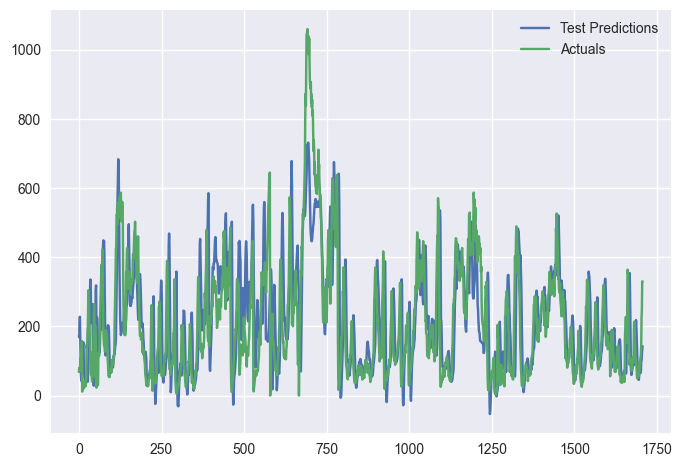

In [39]:
model = load_model('5H_Forecast/5H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(5,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)

### 6 hours forecast

In [40]:
%%time

Trainer(6,6,12,50)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 64)                17920     
                                                                 
 dense_78 (Dense)            (None, 8)                 520       
                                                                 
 dense_79 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 12:19:26.109311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:19:26.287284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:19:26.735850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9683 - mae: 0.6251 - mse: 0.9683 - mape: 172.3237

2023-02-10 12:19:30.836639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:19:30.893683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.04691, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 11s 59ms/step - loss: 0.9683 - mae: 0.6251 - mse: 0.9683 - mape: 172.3237 - val_loss: 1.0469 - val_mae: 0.7797 - val_mse: 1.0469 - val_mape: 129.9339
Epoch 2/50
161/161 [==============================] - ETA: 0s - loss: 0.8436 - mae: 0.5428 - mse: 0.8436 - mape: 238.8554
Epoch 2: val_loss improved from 1.04691 to 0.89612, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.8436 - mae: 0.5428 - mse: 0.8436 - mape: 238.8554 - val_loss: 0.8961 - val_mae: 0.7162 - val_mse: 0.8961 - val_mape: 121.6826
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.7920 - mae: 0.5092 - mse: 0.7920 - mape: 267.8947
Epoch 3: val_loss improved from 0.89612 to 0.80316, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.7920 - mae: 0.5092 - mse: 0.7920 - mape: 267.8947 - val_loss: 0.8032 - val_mae: 0.6760 - val_mse: 0.8032 - val_mape: 120.0979
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.7461 - mae: 0.4871 - mse: 0.7461 - mape: 282.6094
Epoch 4: val_loss improved from 0.80316 to 0.71376, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 52ms/step - loss: 0.7461 - mae: 0.4871 - mse: 0.7461 - mape: 282.6094 - val_loss: 0.7138 - val_mae: 0.6341 - val_mse: 0.7138 - val_mape: 127.3877
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.7014 - mae: 0.4659 - mse: 0.7014 - mape: 312.2843
Epoch 5: val_loss improved from 0.71376 to 0.62365, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.7014 - mae: 0.4659 - mse: 0.7014 - mape: 312.2843 - val_loss: 0.6236 - val_mae: 0.5858 - val_mse: 0.6236 - val_mape: 134.4651
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.6680 - mae: 0.4496 - mse: 0.6680 - mape: 342.4872
Epoch 6: val_loss improved from 0.62365 to 0.56393, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 48ms/step - loss: 0.6680 - mae: 0.4496 - mse: 0.6680 - mape: 342.4872 - val_loss: 0.5639 - val_mae: 0.5520 - val_mse: 0.5639 - val_mape: 139.4434
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.6476 - mae: 0.4380 - mse: 0.6476 - mape: 357.2440
Epoch 7: val_loss improved from 0.56393 to 0.52027, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6476 - mae: 0.4380 - mse: 0.6476 - mape: 357.2440 - val_loss: 0.5203 - val_mae: 0.5246 - val_mse: 0.5203 - val_mape: 141.9925
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.6370 - mae: 0.4326 - mse: 0.6370 - mape: 358.0757
Epoch 8: val_loss improved from 0.52027 to 0.49719, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6370 - mae: 0.4326 - mse: 0.6370 - mape: 358.0757 - val_loss: 0.4972 - val_mae: 0.5109 - val_mse: 0.4972 - val_mape: 144.3928
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.6292 - mae: 0.4268 - mse: 0.6292 - mape: 354.9885
Epoch 9: val_loss improved from 0.49719 to 0.48325, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.6292 - mae: 0.4268 - mse: 0.6292 - mape: 354.9885 - val_loss: 0.4832 - val_mae: 0.5007 - val_mse: 0.4832 - val_mape: 142.1051
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.6233 - mae: 0.4210 - mse: 0.6233 - mape: 356.8064
Epoch 10: val_loss improved from 0.48325 to 0.47517, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.6233 - mae: 0.4210 - mse: 0.6233 - mape: 356.8064 - val_loss: 0.4752 - val_mae: 0.4950 - val_mse: 0.4752 - val_mape: 141.1057
Epoch 11/50
161/161 [==============================] - ETA: 0s - loss: 0.6170 - mae: 0.4196 - mse: 0.6170 - mape: 356.2537
Epoch 11: val_loss improved from 0.47517 to 0.47071, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6170 - mae: 0.4196 - mse: 0.6170 - mape: 356.2537 - val_loss: 0.4707 - val_mae: 0.4906 - val_mse: 0.4707 - val_mape: 141.8066
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.6112 - mae: 0.4139 - mse: 0.6112 - mape: 355.0433
Epoch 12: val_loss improved from 0.47071 to 0.46675, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.6112 - mae: 0.4139 - mse: 0.6112 - mape: 355.0433 - val_loss: 0.4667 - val_mae: 0.4881 - val_mse: 0.4667 - val_mape: 142.1844
Epoch 13/50
159/161 [============================>.] - ETA: 0s - loss: 0.6082 - mae: 0.4112 - mse: 0.6082 - mape: 344.1010
Epoch 13: val_loss improved from 0.46675 to 0.46650, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.6059 - mae: 0.4110 - mse: 0.6059 - mape: 342.7321 - val_loss: 0.4665 - val_mae: 0.4872 - val_mse: 0.4665 - val_mape: 142.8764
Epoch 14/50
161/161 [==============================] - ETA: 0s - loss: 0.6005 - mae: 0.4075 - mse: 0.6005 - mape: 347.9932
Epoch 14: val_loss improved from 0.46650 to 0.46378, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.6005 - mae: 0.4075 - mse: 0.6005 - mape: 347.9932 - val_loss: 0.4638 - val_mae: 0.4851 - val_mse: 0.4638 - val_mape: 146.6907
Epoch 15/50
160/161 [============================>.] - ETA: 0s - loss: 0.5948 - mae: 0.4046 - mse: 0.5948 - mape: 333.1852
Epoch 15: val_loss improved from 0.46378 to 0.45818, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 47ms/step - loss: 0.5947 - mae: 0.4045 - mse: 0.5947 - mape: 333.1214 - val_loss: 0.4582 - val_mae: 0.4823 - val_mse: 0.4582 - val_mape: 149.7625
Epoch 16/50
161/161 [==============================] - ETA: 0s - loss: 0.5894 - mae: 0.3984 - mse: 0.5894 - mape: 332.0806
Epoch 16: val_loss did not improve from 0.45818
161/161 [==============================] - 3s 19ms/step - loss: 0.5894 - mae: 0.3984 - mse: 0.5894 - mape: 332.0806 - val_loss: 0.4613 - val_mae: 0.4831 - val_mse: 0.4613 - val_mape: 144.3976
Epoch 17/50
160/161 [============================>.] - ETA: 0s - loss: 0.5850 - mae: 0.3996 - mse: 0.5850 - mape: 345.1142
Epoch 17: val_loss improved from 0.45818 to 0.45393, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.5849 - mae: 0.3996 - mse: 0.5849 - mape: 345.0814 - val_loss: 0.4539 - val_mae: 0.4797 - val_mse: 0.4539 - val_mape: 150.4322
Epoch 18/50
160/161 [============================>.] - ETA: 0s - loss: 0.5806 - mae: 0.3949 - mse: 0.5806 - mape: 341.5597
Epoch 18: val_loss did not improve from 0.45393
161/161 [==============================] - 3s 20ms/step - loss: 0.5804 - mae: 0.3948 - mse: 0.5804 - mape: 341.4961 - val_loss: 0.4545 - val_mae: 0.4803 - val_mse: 0.4545 - val_mape: 150.8696
Epoch 19/50
161/161 [==============================] - ETA: 0s - loss: 0.5756 - mae: 0.3898 - mse: 0.5756 - mape: 338.9953
Epoch 19: val_loss did not improve from 0.45393
161/161 [==============================] - 3s 19ms/step - loss: 0.5756 - mae: 0.3898 - mse: 0.5756 - mape: 338.9953 - val_loss: 0.4540 - val_mae: 0.4792 - val_mse: 0.4540 - val_mape: 149.4279
Epoch 20/50
161/161 [==============================] - ETA: 0s - loss: 0.5715 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5715 - mae: 0.3907 - mse: 0.5715 - mape: 338.0796 - val_loss: 0.4473 - val_mae: 0.4759 - val_mse: 0.4473 - val_mape: 153.5907
Epoch 21/50
160/161 [============================>.] - ETA: 0s - loss: 0.5681 - mae: 0.3839 - mse: 0.5681 - mape: 344.4594
Epoch 21: val_loss did not improve from 0.44728
161/161 [==============================] - 3s 20ms/step - loss: 0.5680 - mae: 0.3838 - mse: 0.5680 - mape: 344.3934 - val_loss: 0.4516 - val_mae: 0.4794 - val_mse: 0.4516 - val_mape: 150.8243
Epoch 22/50
160/161 [============================>.] - ETA: 0s - loss: 0.5650 - mae: 0.3857 - mse: 0.5650 - mape: 339.2778
Epoch 22: val_loss improved from 0.44728 to 0.44644, saving model to 6H_Forecast/6H_ForecastModel_6_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 9s 54ms/step - loss: 0.5650 - mae: 0.3858 - mse: 0.5650 - mape: 339.2473 - val_loss: 0.4464 - val_mae: 0.4762 - val_mse: 0.4464 - val_mape: 154.3200
Epoch 23/50
161/161 [==============================] - ETA: 0s - loss: 0.5626 - mae: 0.3854 - mse: 0.5626 - mape: 318.4396
Epoch 23: val_loss did not improve from 0.44644
161/161 [==============================] - 3s 20ms/step - loss: 0.5626 - mae: 0.3854 - mse: 0.5626 - mape: 318.4396 - val_loss: 0.4498 - val_mae: 0.4780 - val_mse: 0.4498 - val_mape: 155.5802
Epoch 24/50
160/161 [============================>.] - ETA: 0s - loss: 0.5580 - mae: 0.3819 - mse: 0.5580 - mape: 330.4818
Epoch 24: val_loss did not improve from 0.44644
161/161 [==============================] - 3s 20ms/step - loss: 0.5579 - mae: 0.3818 - mse: 0.5579 - mape: 330.4257 - val_loss: 0.4470 - val_mae: 0.4764 - val_mse: 0.4470 - val_mape: 158.2673
Epoch 25/50
161/161 [==============================] - ETA: 0s - loss: 0.5550 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.5493 - mae: 0.3754 - mse: 0.5493 - mape: 337.8999 - val_loss: 0.4450 - val_mae: 0.4757 - val_mse: 0.4450 - val_mape: 159.3758
Epoch 28/50
160/161 [============================>.] - ETA: 0s - loss: 0.5471 - mae: 0.3764 - mse: 0.5471 - mape: 330.2438
Epoch 28: val_loss did not improve from 0.44499
161/161 [==============================] - 3s 19ms/step - loss: 0.5470 - mae: 0.3764 - mse: 0.5470 - mape: 330.1806 - val_loss: 0.4516 - val_mae: 0.4784 - val_mse: 0.4516 - val_mape: 164.8643
Epoch 29/50
159/161 [============================>.] - ETA: 0s - loss: 0.5445 - mae: 0.3761 - mse: 0.5445 - mape: 330.2078
Epoch 29: val_loss did not improve from 0.44499
161/161 [==============================] - 3s 18ms/step - loss: 0.5431 - mae: 0.3761 - mse: 0.5431 - mape: 329.1811 - val_loss: 0.4473 - val_mae: 0.4749 - val_mse: 0.4473 - val_mape: 168.3660
Epoch 30/50
159/161 [============================>.] - ETA: 0s - loss: 0.5410 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_6_SizeWindow/assets


161/161 [==============================] - 8s 50ms/step - loss: 0.5284 - mae: 0.3688 - mse: 0.5284 - mape: 335.9257 - val_loss: 0.4429 - val_mae: 0.4718 - val_mse: 0.4429 - val_mape: 173.0935
Epoch 36/50
159/161 [============================>.] - ETA: 0s - loss: 0.5270 - mae: 0.3671 - mse: 0.5270 - mape: 327.9484
Epoch 36: val_loss did not improve from 0.44295
161/161 [==============================] - 3s 20ms/step - loss: 0.5261 - mae: 0.3675 - mse: 0.5261 - mape: 326.4031 - val_loss: 0.4610 - val_mae: 0.4827 - val_mse: 0.4610 - val_mape: 171.8700
Epoch 37/50
158/161 [============================>.] - ETA: 0s - loss: 0.5250 - mae: 0.3686 - mse: 0.5250 - mape: 324.8165
Epoch 37: val_loss did not improve from 0.44295
161/161 [==============================] - 3s 18ms/step - loss: 0.5243 - mae: 0.3697 - mse: 0.5243 - mape: 322.7066 - val_loss: 0.4589 - val_mae: 0.4800 - val_mse: 0.4589 - val_mape: 177.4807
Epoch 38/50
160/161 [============================>.] - ETA: 0s - loss: 0.5211 - ma

2023-02-10 12:23:39.002620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:39.151471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:39.788022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


161/161 [==============================] - ETA: 0s - loss: 0.9124 - mae: 0.6156 - mse: 0.9124 - mape: 169.4169

2023-02-10 12:23:44.308283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:23:44.390124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.71647, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 11s 57ms/step - loss: 0.9124 - mae: 0.6156 - mse: 0.9124 - mape: 169.4169 - val_loss: 0.7165 - val_mae: 0.6270 - val_mse: 0.7165 - val_mape: 135.5161
Epoch 2/50
160/161 [============================>.] - ETA: 0s - loss: 0.7318 - mae: 0.4861 - mse: 0.7318 - mape: 253.8669
Epoch 2: val_loss improved from 0.71647 to 0.56826, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.7318 - mae: 0.4862 - mse: 0.7318 - mape: 253.8512 - val_loss: 0.5683 - val_mae: 0.5478 - val_mse: 0.5683 - val_mape: 144.8846
Epoch 3/50
161/161 [==============================] - ETA: 0s - loss: 0.6742 - mae: 0.4487 - mse: 0.6742 - mape: 326.6256
Epoch 3: val_loss improved from 0.56826 to 0.49776, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.6742 - mae: 0.4487 - mse: 0.6742 - mape: 326.6256 - val_loss: 0.4978 - val_mae: 0.5083 - val_mse: 0.4978 - val_mape: 149.4792
Epoch 4/50
161/161 [==============================] - ETA: 0s - loss: 0.6537 - mae: 0.4340 - mse: 0.6537 - mape: 343.6310
Epoch 4: val_loss improved from 0.49776 to 0.47114, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.6537 - mae: 0.4340 - mse: 0.6537 - mape: 343.6310 - val_loss: 0.4711 - val_mae: 0.4917 - val_mse: 0.4711 - val_mape: 145.3101
Epoch 5/50
161/161 [==============================] - ETA: 0s - loss: 0.6425 - mae: 0.4284 - mse: 0.6425 - mape: 358.8842
Epoch 5: val_loss improved from 0.47114 to 0.45661, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 49ms/step - loss: 0.6425 - mae: 0.4284 - mse: 0.6425 - mape: 358.8842 - val_loss: 0.4566 - val_mae: 0.4835 - val_mse: 0.4566 - val_mape: 143.3133
Epoch 6/50
161/161 [==============================] - ETA: 0s - loss: 0.6338 - mae: 0.4221 - mse: 0.6338 - mape: 360.8018
Epoch 6: val_loss improved from 0.45661 to 0.44072, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 8s 51ms/step - loss: 0.6338 - mae: 0.4221 - mse: 0.6338 - mape: 360.8018 - val_loss: 0.4407 - val_mae: 0.4732 - val_mse: 0.4407 - val_mape: 145.8457
Epoch 7/50
161/161 [==============================] - ETA: 0s - loss: 0.6258 - mae: 0.4191 - mse: 0.6258 - mape: 354.3044
Epoch 7: val_loss did not improve from 0.44072
161/161 [==============================] - 3s 18ms/step - loss: 0.6258 - mae: 0.4191 - mse: 0.6258 - mape: 354.3044 - val_loss: 0.4429 - val_mae: 0.4701 - val_mse: 0.4429 - val_mape: 152.3751
Epoch 8/50
161/161 [==============================] - ETA: 0s - loss: 0.6187 - mae: 0.4138 - mse: 0.6187 - mape: 362.6618
Epoch 8: val_loss improved from 0.44072 to 0.43916, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 42ms/step - loss: 0.6187 - mae: 0.4138 - mse: 0.6187 - mape: 362.6618 - val_loss: 0.4392 - val_mae: 0.4685 - val_mse: 0.4392 - val_mape: 152.2101
Epoch 9/50
161/161 [==============================] - ETA: 0s - loss: 0.6125 - mae: 0.4079 - mse: 0.6125 - mape: 362.2026
Epoch 9: val_loss improved from 0.43916 to 0.42955, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 47ms/step - loss: 0.6125 - mae: 0.4079 - mse: 0.6125 - mape: 362.2026 - val_loss: 0.4295 - val_mae: 0.4612 - val_mse: 0.4295 - val_mape: 159.1172
Epoch 10/50
161/161 [==============================] - ETA: 0s - loss: 0.6068 - mae: 0.4047 - mse: 0.6068 - mape: 362.4251
Epoch 10: val_loss did not improve from 0.42955
161/161 [==============================] - 3s 18ms/step - loss: 0.6068 - mae: 0.4047 - mse: 0.6068 - mape: 362.4251 - val_loss: 0.4315 - val_mae: 0.4608 - val_mse: 0.4315 - val_mape: 162.6091
Epoch 11/50
158/161 [============================>.] - ETA: 0s - loss: 0.6057 - mae: 0.4010 - mse: 0.6057 - mape: 336.3248
Epoch 11: val_loss did not improve from 0.42955
161/161 [==============================] - 3s 17ms/step - loss: 0.6011 - mae: 0.4007 - mse: 0.6011 - mape: 355.3778 - val_loss: 0.4408 - val_mae: 0.4646 - val_mse: 0.4408 - val_mape: 166.3824
Epoch 12/50
161/161 [==============================] - ETA: 0s - loss: 0.5956 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.5851 - mae: 0.3925 - mse: 0.5851 - mape: 330.5496 - val_loss: 0.4286 - val_mae: 0.4565 - val_mse: 0.4286 - val_mape: 180.0398
Epoch 15/50
161/161 [==============================] - ETA: 0s - loss: 0.5807 - mae: 0.3891 - mse: 0.5807 - mape: 330.1538
Epoch 15: val_loss did not improve from 0.42860
161/161 [==============================] - 3s 17ms/step - loss: 0.5807 - mae: 0.3891 - mse: 0.5807 - mape: 330.1538 - val_loss: 0.4390 - val_mae: 0.4619 - val_mse: 0.4390 - val_mape: 184.1243
Epoch 16/50
159/161 [============================>.] - ETA: 0s - loss: 0.5780 - mae: 0.3849 - mse: 0.5780 - mape: 336.2731
Epoch 16: val_loss improved from 0.42860 to 0.42709, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 41ms/step - loss: 0.5768 - mae: 0.3855 - mse: 0.5768 - mape: 334.4862 - val_loss: 0.4271 - val_mae: 0.4552 - val_mse: 0.4271 - val_mape: 190.0450
Epoch 17/50
160/161 [============================>.] - ETA: 0s - loss: 0.5726 - mae: 0.3833 - mse: 0.5726 - mape: 335.0260
Epoch 17: val_loss improved from 0.42709 to 0.42324, saving model to 6H_Forecast/6H_ForecastModel_7_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 44ms/step - loss: 0.5726 - mae: 0.3834 - mse: 0.5726 - mape: 334.9790 - val_loss: 0.4232 - val_mae: 0.4562 - val_mse: 0.4232 - val_mape: 187.4722
Epoch 18/50
161/161 [==============================] - ETA: 0s - loss: 0.5693 - mae: 0.3830 - mse: 0.5693 - mape: 326.2272
Epoch 18: val_loss did not improve from 0.42324
161/161 [==============================] - 3s 17ms/step - loss: 0.5693 - mae: 0.3830 - mse: 0.5693 - mape: 326.2272 - val_loss: 0.4238 - val_mae: 0.4533 - val_mse: 0.4238 - val_mape: 199.9384
Epoch 19/50
158/161 [============================>.] - ETA: 0s - loss: 0.5697 - mae: 0.3791 - mse: 0.5697 - mape: 193.3872
Epoch 19: val_loss did not improve from 0.42324
161/161 [==============================] - 3s 17ms/step - loss: 0.5657 - mae: 0.3790 - mse: 0.5657 - mape: 326.9809 - val_loss: 0.4325 - val_mae: 0.4582 - val_mse: 0.4325 - val_mape: 202.5384
Epoch 20/50
159/161 [============================>.] - ETA: 0s - loss: 0.5669 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 45ms/step - loss: 0.5130 - mae: 0.3551 - mse: 0.5130 - mape: 316.3117 - val_loss: 0.4213 - val_mae: 0.4449 - val_mse: 0.4213 - val_mape: 224.8364
Epoch 44/50
161/161 [==============================] - ETA: 0s - loss: 0.5113 - mae: 0.3560 - mse: 0.5113 - mape: 316.9517
Epoch 44: val_loss did not improve from 0.42125
161/161 [==============================] - 4s 23ms/step - loss: 0.5113 - mae: 0.3560 - mse: 0.5113 - mape: 316.9517 - val_loss: 0.4276 - val_mae: 0.4461 - val_mse: 0.4276 - val_mape: 228.9646
Epoch 45/50
161/161 [==============================] - ETA: 0s - loss: 0.5092 - mae: 0.3532 - mse: 0.5092 - mape: 321.6426
Epoch 45: val_loss did not improve from 0.42125
161/161 [==============================] - 3s 20ms/step - loss: 0.5092 - mae: 0.3532 - mse: 0.5092 - mape: 321.6426 - val_loss: 0.4548 - val_mae: 0.4573 - val_mse: 0.4548 - val_mape: 234.3271
Epoch 46/50
160/161 [============================>.] - ETA: 0s - loss: 0.5066 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_7_SizeWindow/assets


161/161 [==============================] - 7s 46ms/step - loss: 0.5023 - mae: 0.3518 - mse: 0.5023 - mape: 318.1740 - val_loss: 0.4161 - val_mae: 0.4411 - val_mse: 0.4161 - val_mape: 231.8356
Epoch 49/50
159/161 [============================>.] - ETA: 0s - loss: 0.5029 - mae: 0.3513 - mse: 0.5029 - mape: 323.6685
Epoch 49: val_loss did not improve from 0.41608
161/161 [==============================] - 3s 21ms/step - loss: 0.5004 - mae: 0.3507 - mse: 0.5004 - mape: 322.0890 - val_loss: 0.4176 - val_mae: 0.4423 - val_mse: 0.4176 - val_mape: 226.7294
Epoch 50/50
159/161 [============================>.] - ETA: 0s - loss: 0.4995 - mae: 0.3497 - mse: 0.4995 - mape: 326.9377
Epoch 50: val_loss did not improve from 0.41608
161/161 [==============================] - 4s 23ms/step - loss: 0.4970 - mae: 0.3491 - mse: 0.4970 - mape: 325.2719 - val_loss: 0.4488 - val_mae: 0.4542 - val_mse: 0.4488 - val_mape: 235.8798

---------------------------------------------------------------------------------

2023-02-10 12:27:15.928471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:27:16.068185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:27:16.440096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


159/160 [============================>.] - ETA: 0s - loss: 1.1844 - mae: 0.7980 - mse: 1.1844 - mape: 161.7840

2023-02-10 12:27:19.861133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:27:19.922448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.88194, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 11s 54ms/step - loss: 1.1807 - mae: 0.7970 - mse: 1.1807 - mape: 161.6389 - val_loss: 0.8819 - val_mae: 0.7456 - val_mse: 0.8819 - val_mape: 132.5618
Epoch 2/50
159/160 [============================>.] - ETA: 0s - loss: 0.8838 - mae: 0.6483 - mse: 0.8838 - mape: 142.7678
Epoch 2: val_loss improved from 0.88194 to 0.62558, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.8817 - mae: 0.6484 - mse: 0.8817 - mape: 143.3853 - val_loss: 0.6256 - val_mae: 0.6140 - val_mse: 0.6256 - val_mape: 140.2575
Epoch 3/50
158/160 [============================>.] - ETA: 0s - loss: 0.7511 - mae: 0.5496 - mse: 0.7511 - mape: 178.6641
Epoch 3: val_loss improved from 0.62558 to 0.55751, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.7475 - mae: 0.5498 - mse: 0.7475 - mape: 186.0165 - val_loss: 0.5575 - val_mae: 0.5672 - val_mse: 0.5575 - val_mape: 136.5005
Epoch 4/50
156/160 [============================>.] - ETA: 0s - loss: 0.6590 - mae: 0.4882 - mse: 0.6590 - mape: 259.5640
Epoch 4: val_loss improved from 0.55751 to 0.55013, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.6951 - mae: 0.4907 - mse: 0.6951 - mape: 257.4160 - val_loss: 0.5501 - val_mae: 0.5560 - val_mse: 0.5501 - val_mape: 130.1313
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6667 - mae: 0.4631 - mse: 0.6667 - mape: 289.9619
Epoch 5: val_loss did not improve from 0.55013
160/160 [==============================] - 3s 16ms/step - loss: 0.6667 - mae: 0.4631 - mse: 0.6667 - mape: 289.9619 - val_loss: 0.5591 - val_mae: 0.5577 - val_mse: 0.5591 - val_mape: 128.5885
Epoch 6/50
158/160 [============================>.] - ETA: 0s - loss: 0.6513 - mae: 0.4526 - mse: 0.6513 - mape: 333.4403
Epoch 6: val_loss did not improve from 0.55013
160/160 [==============================] - 2s 16ms/step - loss: 0.6486 - mae: 0.4525 - mse: 0.6486 - mape: 331.1976 - val_loss: 0.5536 - val_mae: 0.5542 - val_mse: 0.5536 - val_mape: 131.6281
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.6352 - mae: 0.

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6242 - mae: 0.4338 - mse: 0.6242 - mape: 345.8112 - val_loss: 0.5403 - val_mae: 0.5461 - val_mse: 0.5403 - val_mape: 132.6533
Epoch 9/50
157/160 [============================>.] - ETA: 0s - loss: 0.6207 - mae: 0.4308 - mse: 0.6207 - mape: 352.6369
Epoch 9: val_loss did not improve from 0.54031
160/160 [==============================] - 2s 15ms/step - loss: 0.6145 - mae: 0.4299 - mse: 0.6145 - mape: 347.6616 - val_loss: 0.5464 - val_mae: 0.5480 - val_mse: 0.5464 - val_mape: 132.4128
Epoch 10/50
159/160 [============================>.] - ETA: 0s - loss: 0.6080 - mae: 0.4266 - mse: 0.6080 - mape: 345.0160
Epoch 10: val_loss improved from 0.54031 to 0.52877, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.6066 - mae: 0.4266 - mse: 0.6066 - mape: 344.2164 - val_loss: 0.5288 - val_mae: 0.5375 - val_mse: 0.5288 - val_mape: 135.6858
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5982 - mae: 0.4203 - mse: 0.5982 - mape: 344.4078
Epoch 11: val_loss improved from 0.52877 to 0.51971, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 41ms/step - loss: 0.5982 - mae: 0.4203 - mse: 0.5982 - mape: 344.4078 - val_loss: 0.5197 - val_mae: 0.5318 - val_mse: 0.5197 - val_mape: 137.0804
Epoch 12/50
159/160 [============================>.] - ETA: 0s - loss: 0.4909 - mae: 0.4102 - mse: 0.4909 - mape: 345.6249
Epoch 12: val_loss improved from 0.51971 to 0.50083, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5892 - mae: 0.4156 - mse: 0.5892 - mape: 343.8495 - val_loss: 0.5008 - val_mae: 0.5210 - val_mse: 0.5008 - val_mape: 141.8163
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5810 - mae: 0.4173 - mse: 0.5810 - mape: 343.8270
Epoch 13: val_loss improved from 0.50083 to 0.49846, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.5810 - mae: 0.4173 - mse: 0.5810 - mape: 343.8270 - val_loss: 0.4985 - val_mae: 0.5164 - val_mse: 0.4985 - val_mape: 145.6730
Epoch 14/50
158/160 [============================>.] - ETA: 0s - loss: 0.5762 - mae: 0.4121 - mse: 0.5762 - mape: 346.1881
Epoch 14: val_loss improved from 0.49846 to 0.48795, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5722 - mae: 0.4114 - mse: 0.5722 - mape: 343.3247 - val_loss: 0.4879 - val_mae: 0.5102 - val_mse: 0.4879 - val_mape: 147.6020
Epoch 15/50
159/160 [============================>.] - ETA: 0s - loss: 0.5652 - mae: 0.4072 - mse: 0.5652 - mape: 346.6996
Epoch 15: val_loss did not improve from 0.48795
160/160 [==============================] - 3s 17ms/step - loss: 0.5644 - mae: 0.4077 - mse: 0.5644 - mape: 345.3474 - val_loss: 0.4897 - val_mae: 0.5098 - val_mse: 0.4897 - val_mape: 148.2166
Epoch 16/50
158/160 [============================>.] - ETA: 0s - loss: 0.5611 - mae: 0.4077 - mse: 0.5611 - mape: 334.9551
Epoch 16: val_loss improved from 0.48795 to 0.47828, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.5563 - mae: 0.4065 - mse: 0.5563 - mape: 332.9847 - val_loss: 0.4783 - val_mae: 0.5039 - val_mse: 0.4783 - val_mape: 151.1325
Epoch 17/50
159/160 [============================>.] - ETA: 0s - loss: 0.5508 - mae: 0.4031 - mse: 0.5508 - mape: 329.5128
Epoch 17: val_loss improved from 0.47828 to 0.46152, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5495 - mae: 0.4036 - mse: 0.5495 - mape: 328.2119 - val_loss: 0.4615 - val_mae: 0.4914 - val_mse: 0.4615 - val_mape: 158.6772
Epoch 18/50
158/160 [============================>.] - ETA: 0s - loss: 0.5419 - mae: 0.4015 - mse: 0.5419 - mape: 337.8925
Epoch 18: val_loss improved from 0.46152 to 0.45518, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 42ms/step - loss: 0.5385 - mae: 0.4012 - mse: 0.5385 - mape: 335.3615 - val_loss: 0.4552 - val_mae: 0.4872 - val_mse: 0.4552 - val_mape: 161.8267
Epoch 19/50
157/160 [============================>.] - ETA: 0s - loss: 0.4778 - mae: 0.3942 - mse: 0.4778 - mape: 305.2236
Epoch 19: val_loss did not improve from 0.45518
160/160 [==============================] - 3s 17ms/step - loss: 0.5309 - mae: 0.3967 - mse: 0.5309 - mape: 321.9142 - val_loss: 0.4567 - val_mae: 0.4871 - val_mse: 0.4567 - val_mape: 162.5210
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.5230 - mae: 0.3977 - mse: 0.5230 - mape: 318.1331
Epoch 20: val_loss improved from 0.45518 to 0.44018, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.5230 - mae: 0.3977 - mse: 0.5230 - mape: 318.1331 - val_loss: 0.4402 - val_mae: 0.4775 - val_mse: 0.4402 - val_mape: 166.9892
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.5147 - mae: 0.3936 - mse: 0.5147 - mape: 309.3440
Epoch 21: val_loss did not improve from 0.44018
160/160 [==============================] - 3s 17ms/step - loss: 0.5147 - mae: 0.3936 - mse: 0.5147 - mape: 309.3440 - val_loss: 0.4405 - val_mae: 0.4750 - val_mse: 0.4405 - val_mape: 171.6338
Epoch 22/50
159/160 [============================>.] - ETA: 0s - loss: 0.5084 - mae: 0.3920 - mse: 0.5084 - mape: 318.9323
Epoch 22: val_loss improved from 0.44018 to 0.43525, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.5066 - mae: 0.3917 - mse: 0.5066 - mape: 317.2973 - val_loss: 0.4353 - val_mae: 0.4705 - val_mse: 0.4353 - val_mape: 178.2720
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.4985 - mae: 0.3899 - mse: 0.4985 - mape: 300.1375
Epoch 23: val_loss did not improve from 0.43525
160/160 [==============================] - 3s 16ms/step - loss: 0.4985 - mae: 0.3899 - mse: 0.4985 - mape: 300.1375 - val_loss: 0.4374 - val_mae: 0.4703 - val_mse: 0.4374 - val_mape: 182.6614
Epoch 24/50
158/160 [============================>.] - ETA: 0s - loss: 0.4932 - mae: 0.3877 - mse: 0.4932 - mape: 316.9902
Epoch 24: val_loss improved from 0.43525 to 0.42358, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.4911 - mae: 0.3879 - mse: 0.4911 - mape: 316.2080 - val_loss: 0.4236 - val_mae: 0.4622 - val_mse: 0.4236 - val_mape: 186.5321
Epoch 25/50
158/160 [============================>.] - ETA: 0s - loss: 0.4875 - mae: 0.3867 - mse: 0.4875 - mape: 293.2712
Epoch 25: val_loss did not improve from 0.42358
160/160 [==============================] - 3s 17ms/step - loss: 0.4833 - mae: 0.3856 - mse: 0.4833 - mape: 304.2551 - val_loss: 0.4252 - val_mae: 0.4626 - val_mse: 0.4252 - val_mape: 189.5042
Epoch 26/50
158/160 [============================>.] - ETA: 0s - loss: 0.4779 - mae: 0.3835 - mse: 0.4779 - mape: 298.2867
Epoch 26: val_loss did not improve from 0.42358
160/160 [==============================] - 3s 16ms/step - loss: 0.4754 - mae: 0.3837 - mse: 0.4754 - mape: 295.6076 - val_loss: 0.4284 - val_mae: 0.4622 - val_mse: 0.4284 - val_mape: 194.5613
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.4690 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.4690 - mae: 0.3824 - mse: 0.4690 - mape: 303.7405 - val_loss: 0.4227 - val_mae: 0.4585 - val_mse: 0.4227 - val_mape: 197.4688
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.4649 - mae: 0.3804 - mse: 0.4649 - mape: 308.2739
Epoch 28: val_loss did not improve from 0.42269
160/160 [==============================] - 3s 17ms/step - loss: 0.4629 - mae: 0.3797 - mse: 0.4629 - mape: 306.8880 - val_loss: 0.4311 - val_mae: 0.4614 - val_mse: 0.4311 - val_mape: 198.9618
Epoch 29/50
158/160 [============================>.] - ETA: 0s - loss: 0.4586 - mae: 0.3782 - mse: 0.4586 - mape: 300.2037
Epoch 29: val_loss improved from 0.42269 to 0.41458, saving model to 6H_Forecast/6H_ForecastModel_8_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.4560 - mae: 0.3780 - mse: 0.4560 - mape: 301.8235 - val_loss: 0.4146 - val_mae: 0.4560 - val_mse: 0.4146 - val_mape: 201.6191
Epoch 30/50
159/160 [============================>.] - ETA: 0s - loss: 0.4521 - mae: 0.3768 - mse: 0.4521 - mape: 289.8645
Epoch 30: val_loss did not improve from 0.41458
160/160 [==============================] - 3s 17ms/step - loss: 0.4503 - mae: 0.3766 - mse: 0.4503 - mape: 288.9977 - val_loss: 0.4263 - val_mae: 0.4586 - val_mse: 0.4263 - val_mape: 202.3842
Epoch 31/50
157/160 [============================>.] - ETA: 0s - loss: 0.4494 - mae: 0.3792 - mse: 0.4494 - mape: 317.4156
Epoch 31: val_loss did not improve from 0.41458
160/160 [==============================] - 3s 17ms/step - loss: 0.4447 - mae: 0.3781 - mse: 0.4447 - mape: 316.9092 - val_loss: 0.4230 - val_mae: 0.4572 - val_mse: 0.4230 - val_mape: 206.2716
Epoch 32/50
157/160 [============================>.] - ETA: 0s - loss: 0.4432 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.4394 - mae: 0.3746 - mse: 0.4394 - mape: 296.2944 - val_loss: 0.4141 - val_mae: 0.4530 - val_mse: 0.4141 - val_mape: 208.5518
Epoch 33/50
160/160 [==============================] - ETA: 0s - loss: 0.4335 - mae: 0.3731 - mse: 0.4335 - mape: 295.2683
Epoch 33: val_loss did not improve from 0.41406
160/160 [==============================] - 3s 16ms/step - loss: 0.4335 - mae: 0.3731 - mse: 0.4335 - mape: 295.2683 - val_loss: 0.4162 - val_mae: 0.4536 - val_mse: 0.4162 - val_mape: 210.3317
Epoch 34/50
160/160 [==============================] - ETA: 0s - loss: 0.4280 - mae: 0.3720 - mse: 0.4280 - mape: 280.2441
Epoch 34: val_loss did not improve from 0.41406
160/160 [==============================] - 2s 16ms/step - loss: 0.4280 - mae: 0.3720 - mse: 0.4280 - mape: 280.2441 - val_loss: 0.4195 - val_mae: 0.4534 - val_mse: 0.4195 - val_mape: 212.6288
Epoch 35/50
159/160 [============================>.] - ETA: 0s - loss: 0.4202 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_8_SizeWindow/assets


160/160 [==============================] - 7s 43ms/step - loss: 0.4032 - mae: 0.3660 - mse: 0.4032 - mape: 298.0795 - val_loss: 0.4092 - val_mae: 0.4482 - val_mse: 0.4092 - val_mape: 222.3436
Epoch 41/50
157/160 [============================>.] - ETA: 0s - loss: 0.4003 - mae: 0.3629 - mse: 0.4003 - mape: 295.9947
Epoch 41: val_loss did not improve from 0.40921
160/160 [==============================] - 3s 17ms/step - loss: 0.3981 - mae: 0.3633 - mse: 0.3981 - mape: 291.9361 - val_loss: 0.4237 - val_mae: 0.4542 - val_mse: 0.4237 - val_mape: 222.9464
Epoch 42/50
157/160 [============================>.] - ETA: 0s - loss: 0.3956 - mae: 0.3623 - mse: 0.3956 - mape: 295.5968
Epoch 42: val_loss did not improve from 0.40921
160/160 [==============================] - 3s 16ms/step - loss: 0.3938 - mae: 0.3621 - mse: 0.3938 - mape: 292.0129 - val_loss: 0.4220 - val_mae: 0.4536 - val_mse: 0.4220 - val_mape: 229.3265
Epoch 43/50
160/160 [==============================] - ETA: 0s - loss: 0.3902 - ma

2023-02-10 12:31:00.877187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:31:01.043229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:31:01.488526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8889 - mae: 0.6532 - mse: 0.8889 - mape: 158.5750

2023-02-10 12:31:05.630502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:31:05.692084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.54100, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 11s 61ms/step - loss: 0.8889 - mae: 0.6532 - mse: 0.8889 - mape: 158.5750 - val_loss: 0.5410 - val_mae: 0.5658 - val_mse: 0.5410 - val_mape: 151.1498
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6939 - mae: 0.4929 - mse: 0.6939 - mape: 239.5971
Epoch 2: val_loss improved from 0.54100 to 0.50124, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6939 - mae: 0.4929 - mse: 0.6939 - mape: 239.5971 - val_loss: 0.5012 - val_mae: 0.5305 - val_mse: 0.5012 - val_mape: 154.5630
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6549 - mae: 0.4527 - mse: 0.6549 - mape: 285.2583
Epoch 3: val_loss improved from 0.50124 to 0.49769, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.6549 - mae: 0.4527 - mse: 0.6549 - mape: 285.2583 - val_loss: 0.4977 - val_mae: 0.5266 - val_mse: 0.4977 - val_mape: 150.8692
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6382 - mae: 0.4378 - mse: 0.6382 - mape: 310.2330
Epoch 4: val_loss improved from 0.49769 to 0.49017, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6382 - mae: 0.4378 - mse: 0.6382 - mape: 310.2330 - val_loss: 0.4902 - val_mae: 0.5229 - val_mse: 0.4902 - val_mape: 151.1354
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6246 - mae: 0.4298 - mse: 0.6246 - mape: 315.0603
Epoch 5: val_loss improved from 0.49017 to 0.47920, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.6246 - mae: 0.4298 - mse: 0.6246 - mape: 315.0603 - val_loss: 0.4792 - val_mae: 0.5163 - val_mse: 0.4792 - val_mape: 152.4089
Epoch 6/50
157/160 [============================>.] - ETA: 0s - loss: 0.5777 - mae: 0.4235 - mse: 0.5777 - mape: 332.6743
Epoch 6: val_loss improved from 0.47920 to 0.47694, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6151 - mae: 0.4262 - mse: 0.6151 - mape: 329.6276 - val_loss: 0.4769 - val_mae: 0.5135 - val_mse: 0.4769 - val_mape: 151.6909
Epoch 7/50
157/160 [============================>.] - ETA: 0s - loss: 0.6102 - mae: 0.4201 - mse: 0.6102 - mape: 209.6488
Epoch 7: val_loss did not improve from 0.47694
160/160 [==============================] - 3s 18ms/step - loss: 0.6044 - mae: 0.4201 - mse: 0.6044 - mape: 327.2420 - val_loss: 0.4895 - val_mae: 0.5222 - val_mse: 0.4895 - val_mape: 141.6631
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.5968 - mae: 0.4190 - mse: 0.5968 - mape: 336.5997
Epoch 8: val_loss improved from 0.47694 to 0.47368, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5968 - mae: 0.4190 - mse: 0.5968 - mape: 336.5997 - val_loss: 0.4737 - val_mae: 0.5127 - val_mse: 0.4737 - val_mape: 144.7262
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.5874 - mae: 0.4141 - mse: 0.5874 - mape: 334.0322
Epoch 9: val_loss did not improve from 0.47368
160/160 [==============================] - 3s 19ms/step - loss: 0.5874 - mae: 0.4141 - mse: 0.5874 - mape: 334.0322 - val_loss: 0.4741 - val_mae: 0.5151 - val_mse: 0.4741 - val_mape: 142.1936
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.5786 - mae: 0.4145 - mse: 0.5786 - mape: 322.5134
Epoch 10: val_loss improved from 0.47368 to 0.46158, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5786 - mae: 0.4145 - mse: 0.5786 - mape: 322.5134 - val_loss: 0.4616 - val_mae: 0.5072 - val_mse: 0.4616 - val_mape: 147.9614
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5698 - mae: 0.4057 - mse: 0.5698 - mape: 327.5417
Epoch 11: val_loss did not improve from 0.46158
160/160 [==============================] - 3s 20ms/step - loss: 0.5698 - mae: 0.4057 - mse: 0.5698 - mape: 327.5417 - val_loss: 0.4636 - val_mae: 0.5056 - val_mse: 0.4636 - val_mape: 150.5045
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5621 - mae: 0.4087 - mse: 0.5621 - mape: 327.2738
Epoch 12: val_loss improved from 0.46158 to 0.45760, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5621 - mae: 0.4087 - mse: 0.5621 - mape: 327.2738 - val_loss: 0.4576 - val_mae: 0.5034 - val_mse: 0.4576 - val_mape: 152.8116
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5530 - mae: 0.4026 - mse: 0.5530 - mape: 326.7533
Epoch 13: val_loss did not improve from 0.45760
160/160 [==============================] - 3s 18ms/step - loss: 0.5530 - mae: 0.4026 - mse: 0.5530 - mape: 326.7533 - val_loss: 0.4642 - val_mae: 0.5059 - val_mse: 0.4642 - val_mape: 150.9605
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5437 - mae: 0.4024 - mse: 0.5437 - mape: 320.5897
Epoch 14: val_loss improved from 0.45760 to 0.45201, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5437 - mae: 0.4024 - mse: 0.5437 - mape: 320.5897 - val_loss: 0.4520 - val_mae: 0.4981 - val_mse: 0.4520 - val_mape: 153.6018
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.5335 - mae: 0.4006 - mse: 0.5335 - mape: 317.4313
Epoch 15: val_loss improved from 0.45201 to 0.44946, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5335 - mae: 0.4006 - mse: 0.5335 - mape: 317.4313 - val_loss: 0.4495 - val_mae: 0.4947 - val_mse: 0.4495 - val_mape: 157.3862
Epoch 16/50
158/160 [============================>.] - ETA: 0s - loss: 0.5270 - mae: 0.3958 - mse: 0.5270 - mape: 293.5199
Epoch 16: val_loss improved from 0.44946 to 0.44343, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.5231 - mae: 0.3950 - mse: 0.5231 - mape: 291.5858 - val_loss: 0.4434 - val_mae: 0.4917 - val_mse: 0.4434 - val_mape: 158.4327
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.5146 - mae: 0.3968 - mse: 0.5146 - mape: 304.3327
Epoch 17: val_loss did not improve from 0.44343
160/160 [==============================] - 3s 18ms/step - loss: 0.5146 - mae: 0.3968 - mse: 0.5146 - mape: 304.3327 - val_loss: 0.4467 - val_mae: 0.4922 - val_mse: 0.4467 - val_mape: 157.9074
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.5042 - mae: 0.3920 - mse: 0.5042 - mape: 298.5595
Epoch 18: val_loss improved from 0.44343 to 0.44340, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5042 - mae: 0.3920 - mse: 0.5042 - mape: 298.5595 - val_loss: 0.4434 - val_mae: 0.4897 - val_mse: 0.4434 - val_mape: 158.6490
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.4940 - mae: 0.3914 - mse: 0.4940 - mape: 308.2100
Epoch 19: val_loss improved from 0.44340 to 0.43547, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.4940 - mae: 0.3914 - mse: 0.4940 - mape: 308.2100 - val_loss: 0.4355 - val_mae: 0.4846 - val_mse: 0.4355 - val_mape: 160.9116
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.4866 - mae: 0.3891 - mse: 0.4866 - mape: 286.7021
Epoch 20: val_loss did not improve from 0.43547
160/160 [==============================] - 3s 19ms/step - loss: 0.4866 - mae: 0.3891 - mse: 0.4866 - mape: 286.7021 - val_loss: 0.4406 - val_mae: 0.4869 - val_mse: 0.4406 - val_mape: 158.7437
Epoch 21/50
158/160 [============================>.] - ETA: 0s - loss: 0.4791 - mae: 0.3883 - mse: 0.4791 - mape: 306.4081
Epoch 21: val_loss did not improve from 0.43547
160/160 [==============================] - 3s 19ms/step - loss: 0.4768 - mae: 0.3881 - mse: 0.4768 - mape: 304.7966 - val_loss: 0.4365 - val_mae: 0.4825 - val_mse: 0.4365 - val_mape: 160.3467
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.4677 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4677 - mae: 0.3848 - mse: 0.4677 - mape: 275.8478 - val_loss: 0.4321 - val_mae: 0.4788 - val_mse: 0.4321 - val_mape: 163.0778
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.4605 - mae: 0.3855 - mse: 0.4605 - mape: 289.9306
Epoch 23: val_loss did not improve from 0.43207
160/160 [==============================] - 3s 18ms/step - loss: 0.4605 - mae: 0.3855 - mse: 0.4605 - mape: 289.9306 - val_loss: 0.4405 - val_mae: 0.4820 - val_mse: 0.4405 - val_mape: 162.7593
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.4512 - mae: 0.3826 - mse: 0.4512 - mape: 278.1452
Epoch 24: val_loss did not improve from 0.43207
160/160 [==============================] - 3s 19ms/step - loss: 0.4512 - mae: 0.3826 - mse: 0.4512 - mape: 278.1452 - val_loss: 0.4435 - val_mae: 0.4843 - val_mse: 0.4435 - val_mape: 163.3116
Epoch 25/50
157/160 [============================>.] - ETA: 0s - loss: 0.4455 - ma

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.4430 - mae: 0.3791 - mse: 0.4430 - mape: 267.5967 - val_loss: 0.4299 - val_mae: 0.4767 - val_mse: 0.4299 - val_mape: 166.6131
Epoch 26/50
159/160 [============================>.] - ETA: 0s - loss: 0.4379 - mae: 0.3792 - mse: 0.4379 - mape: 278.5834
Epoch 26: val_loss did not improve from 0.42989
160/160 [==============================] - 3s 20ms/step - loss: 0.4365 - mae: 0.3788 - mse: 0.4365 - mape: 277.4681 - val_loss: 0.4334 - val_mae: 0.4792 - val_mse: 0.4334 - val_mape: 166.5962
Epoch 27/50
158/160 [============================>.] - ETA: 0s - loss: 0.4310 - mae: 0.3750 - mse: 0.4310 - mape: 258.9258
Epoch 27: val_loss improved from 0.42989 to 0.42743, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.4278 - mae: 0.3744 - mse: 0.4278 - mape: 258.5804 - val_loss: 0.4274 - val_mae: 0.4760 - val_mse: 0.4274 - val_mape: 167.4231
Epoch 28/50
159/160 [============================>.] - ETA: 0s - loss: 0.4239 - mae: 0.3806 - mse: 0.4239 - mape: 245.4012
Epoch 28: val_loss improved from 0.42743 to 0.42278, saving model to 6H_Forecast/6H_ForecastModel_9_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_9_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.4230 - mae: 0.3806 - mse: 0.4230 - mape: 244.4747 - val_loss: 0.4228 - val_mae: 0.4731 - val_mse: 0.4228 - val_mape: 169.8285
Epoch 29/50
159/160 [============================>.] - ETA: 0s - loss: 0.4167 - mae: 0.3723 - mse: 0.4167 - mape: 272.0184
Epoch 29: val_loss did not improve from 0.42278
160/160 [==============================] - 3s 18ms/step - loss: 0.4155 - mae: 0.3722 - mse: 0.4155 - mape: 270.7759 - val_loss: 0.4319 - val_mae: 0.4785 - val_mse: 0.4319 - val_mape: 166.7335
Epoch 30/50
159/160 [============================>.] - ETA: 0s - loss: 0.4097 - mae: 0.3704 - mse: 0.4097 - mape: 270.6534
Epoch 30: val_loss did not improve from 0.42278
160/160 [==============================] - 3s 18ms/step - loss: 0.4090 - mae: 0.3707 - mse: 0.4090 - mape: 269.4822 - val_loss: 0.4297 - val_mae: 0.4775 - val_mse: 0.4297 - val_mape: 169.7372
Epoch 31/50
157/160 [============================>.] - ETA: 0s - loss: 0.4061 - ma

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_43 (LSTM)              (None, 64)                17920     
                                                                 
 dense_86 (Dense)            (None, 8)                 520       
                                                                 
 dense_87 (Dense)            (None, 1)                 9         
                                                                 
Total params: 18,449
Trainable params: 18,449
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


2023-02-10 12:34:55.444087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:34:55.602173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:34:56.069126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.9242 - mae: 0.6291 - mse: 0.9242 - mape: 183.1411

2023-02-10 12:34:59.896649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:34:59.952707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.78132, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 11s 58ms/step - loss: 0.9242 - mae: 0.6291 - mse: 0.9242 - mape: 183.1411 - val_loss: 0.7813 - val_mae: 0.6895 - val_mse: 0.7813 - val_mape: 120.3246
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.7787 - mae: 0.5212 - mse: 0.7787 - mape: 221.4095
Epoch 2: val_loss improved from 0.78132 to 0.60974, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.7787 - mae: 0.5212 - mse: 0.7787 - mape: 221.4095 - val_loss: 0.6097 - val_mae: 0.5980 - val_mse: 0.6097 - val_mape: 137.7076
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.7053 - mae: 0.4734 - mse: 0.7053 - mape: 328.3965
Epoch 3: val_loss improved from 0.60974 to 0.52687, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.7053 - mae: 0.4734 - mse: 0.7053 - mape: 328.3965 - val_loss: 0.5269 - val_mae: 0.5447 - val_mse: 0.5269 - val_mape: 151.4585
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6823 - mae: 0.4571 - mse: 0.6823 - mape: 366.4330
Epoch 4: val_loss improved from 0.52687 to 0.51248, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.6823 - mae: 0.4571 - mse: 0.6823 - mape: 366.4330 - val_loss: 0.5125 - val_mae: 0.5322 - val_mse: 0.5125 - val_mape: 145.9731
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6678 - mae: 0.4491 - mse: 0.6678 - mape: 360.4920
Epoch 5: val_loss improved from 0.51248 to 0.50232, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 44ms/step - loss: 0.6678 - mae: 0.4491 - mse: 0.6678 - mape: 360.4920 - val_loss: 0.5023 - val_mae: 0.5248 - val_mse: 0.5023 - val_mape: 144.8248
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.6536 - mae: 0.4419 - mse: 0.6536 - mape: 358.7509
Epoch 6: val_loss improved from 0.50232 to 0.49267, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.6536 - mae: 0.4419 - mse: 0.6536 - mape: 358.7509 - val_loss: 0.4927 - val_mae: 0.5162 - val_mse: 0.4927 - val_mape: 142.1635
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.6414 - mae: 0.4326 - mse: 0.6414 - mape: 350.3078
Epoch 7: val_loss improved from 0.49267 to 0.48380, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6414 - mae: 0.4326 - mse: 0.6414 - mape: 350.3078 - val_loss: 0.4838 - val_mae: 0.5112 - val_mse: 0.4838 - val_mape: 140.3044
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.6313 - mae: 0.4251 - mse: 0.6313 - mape: 350.1585
Epoch 8: val_loss improved from 0.48380 to 0.46856, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6313 - mae: 0.4251 - mse: 0.6313 - mape: 350.1585 - val_loss: 0.4686 - val_mae: 0.5028 - val_mse: 0.4686 - val_mape: 142.2876
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.6211 - mae: 0.4171 - mse: 0.6211 - mape: 346.9746
Epoch 9: val_loss improved from 0.46856 to 0.46556, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.6211 - mae: 0.4171 - mse: 0.6211 - mape: 346.9746 - val_loss: 0.4656 - val_mae: 0.5001 - val_mse: 0.4656 - val_mape: 140.3992
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.6131 - mae: 0.4194 - mse: 0.6131 - mape: 349.3622
Epoch 10: val_loss improved from 0.46556 to 0.46243, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6131 - mae: 0.4194 - mse: 0.6131 - mape: 349.3622 - val_loss: 0.4624 - val_mae: 0.4970 - val_mse: 0.4624 - val_mape: 142.6356
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.6042 - mae: 0.4101 - mse: 0.6042 - mape: 341.2509
Epoch 11: val_loss improved from 0.46243 to 0.44946, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 48ms/step - loss: 0.6042 - mae: 0.4101 - mse: 0.6042 - mape: 341.2509 - val_loss: 0.4495 - val_mae: 0.4888 - val_mse: 0.4495 - val_mape: 144.3992
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5949 - mae: 0.4034 - mse: 0.5949 - mape: 340.9596
Epoch 12: val_loss improved from 0.44946 to 0.44504, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.5949 - mae: 0.4034 - mse: 0.5949 - mape: 340.9596 - val_loss: 0.4450 - val_mae: 0.4869 - val_mse: 0.4450 - val_mape: 141.1114
Epoch 13/50
158/160 [============================>.] - ETA: 0s - loss: 0.5904 - mae: 0.4008 - mse: 0.5904 - mape: 337.6118
Epoch 13: val_loss improved from 0.44504 to 0.43771, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 45ms/step - loss: 0.5879 - mae: 0.4012 - mse: 0.5879 - mape: 335.9647 - val_loss: 0.4377 - val_mae: 0.4822 - val_mse: 0.4377 - val_mape: 145.3385
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5817 - mae: 0.3968 - mse: 0.5817 - mape: 331.7855
Epoch 14: val_loss improved from 0.43771 to 0.43483, saving model to 6H_Forecast/6H_ForecastModel_10_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_10_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5817 - mae: 0.3968 - mse: 0.5817 - mape: 331.7855 - val_loss: 0.4348 - val_mae: 0.4804 - val_mse: 0.4348 - val_mape: 148.1428
Epoch 15/50
157/160 [============================>.] - ETA: 0s - loss: 0.5802 - mae: 0.3961 - mse: 0.5802 - mape: 332.8486
Epoch 15: val_loss did not improve from 0.43483
160/160 [==============================] - 3s 19ms/step - loss: 0.5761 - mae: 0.3959 - mse: 0.5761 - mape: 329.0464 - val_loss: 0.4420 - val_mae: 0.4853 - val_mse: 0.4420 - val_mape: 146.0504
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.5711 - mae: 0.3922 - mse: 0.5711 - mape: 326.6736
Epoch 16: val_loss did not improve from 0.43483
160/160 [==============================] - 3s 18ms/step - loss: 0.5711 - mae: 0.3922 - mse: 0.5711 - mape: 326.6736 - val_loss: 0.4366 - val_mae: 0.4807 - val_mse: 0.4366 - val_mape: 149.5134
Epoch 17/50
157/160 [============================>.] - ETA: 0s - loss: 0.5710 - ma

2023-02-10 12:38:40.485849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:38:40.656341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:38:41.132506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8962 - mae: 0.6315 - mse: 0.8962 - mape: 164.3257

2023-02-10 12:38:45.134952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:38:45.192343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.61353, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 12s 60ms/step - loss: 0.8962 - mae: 0.6315 - mse: 0.8962 - mape: 164.3257 - val_loss: 0.6135 - val_mae: 0.5835 - val_mse: 0.6135 - val_mape: 127.1206
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.7084 - mae: 0.4833 - mse: 0.7084 - mape: 339.3580
Epoch 2: val_loss improved from 0.61353 to 0.51624, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.7084 - mae: 0.4833 - mse: 0.7084 - mape: 339.3580 - val_loss: 0.5162 - val_mae: 0.5251 - val_mse: 0.5162 - val_mape: 144.3896
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6715 - mae: 0.4536 - mse: 0.6715 - mape: 377.6190
Epoch 3: val_loss improved from 0.51624 to 0.49479, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 9s 53ms/step - loss: 0.6715 - mae: 0.4536 - mse: 0.6715 - mape: 377.6190 - val_loss: 0.4948 - val_mae: 0.5143 - val_mse: 0.4948 - val_mape: 144.2113
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6564 - mae: 0.4423 - mse: 0.6564 - mape: 386.7473
Epoch 4: val_loss improved from 0.49479 to 0.48993, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6564 - mae: 0.4423 - mse: 0.6564 - mape: 386.7473 - val_loss: 0.4899 - val_mae: 0.5110 - val_mse: 0.4899 - val_mape: 143.8676
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6438 - mae: 0.4374 - mse: 0.6438 - mape: 380.7379
Epoch 5: val_loss improved from 0.48993 to 0.48644, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 9s 54ms/step - loss: 0.6438 - mae: 0.4374 - mse: 0.6438 - mape: 380.7379 - val_loss: 0.4864 - val_mae: 0.5090 - val_mse: 0.4864 - val_mape: 147.5492
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.6345 - mae: 0.4284 - mse: 0.6345 - mape: 388.1732
Epoch 6: val_loss improved from 0.48644 to 0.47815, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.6345 - mae: 0.4284 - mse: 0.6345 - mape: 388.1732 - val_loss: 0.4782 - val_mae: 0.5048 - val_mse: 0.4782 - val_mape: 146.2355
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.6273 - mae: 0.4272 - mse: 0.6273 - mape: 385.0561
Epoch 7: val_loss improved from 0.47815 to 0.47123, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.6273 - mae: 0.4272 - mse: 0.6273 - mape: 385.0561 - val_loss: 0.4712 - val_mae: 0.5004 - val_mse: 0.4712 - val_mape: 143.5935
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.6200 - mae: 0.4228 - mse: 0.6200 - mape: 383.1867
Epoch 8: val_loss did not improve from 0.47123
160/160 [==============================] - 3s 19ms/step - loss: 0.6200 - mae: 0.4228 - mse: 0.6200 - mape: 383.1867 - val_loss: 0.4734 - val_mae: 0.4999 - val_mse: 0.4734 - val_mape: 143.1129
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.6124 - mae: 0.4195 - mse: 0.6124 - mape: 375.4403
Epoch 9: val_loss improved from 0.47123 to 0.46752, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 10s 61ms/step - loss: 0.6124 - mae: 0.4195 - mse: 0.6124 - mape: 375.4403 - val_loss: 0.4675 - val_mae: 0.4977 - val_mse: 0.4675 - val_mape: 139.9299
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.6059 - mae: 0.4164 - mse: 0.6059 - mape: 367.6080
Epoch 10: val_loss did not improve from 0.46752
160/160 [==============================] - 3s 21ms/step - loss: 0.6059 - mae: 0.4164 - mse: 0.6059 - mape: 367.6080 - val_loss: 0.4690 - val_mae: 0.4957 - val_mse: 0.4690 - val_mape: 139.7363
Epoch 11/50
159/160 [============================>.] - ETA: 0s - loss: 0.6010 - mae: 0.4131 - mse: 0.6010 - mape: 362.2055
Epoch 11: val_loss improved from 0.46752 to 0.46459, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 46ms/step - loss: 0.5990 - mae: 0.4127 - mse: 0.5990 - mape: 360.4567 - val_loss: 0.4646 - val_mae: 0.4921 - val_mse: 0.4646 - val_mape: 139.9193
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5922 - mae: 0.4065 - mse: 0.5922 - mape: 352.9129
Epoch 12: val_loss improved from 0.46459 to 0.46395, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 8s 47ms/step - loss: 0.5922 - mae: 0.4065 - mse: 0.5922 - mape: 352.9129 - val_loss: 0.4640 - val_mae: 0.4920 - val_mse: 0.4640 - val_mape: 136.8070
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5866 - mae: 0.4090 - mse: 0.5866 - mape: 353.7680
Epoch 13: val_loss improved from 0.46395 to 0.46302, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 9s 53ms/step - loss: 0.5866 - mae: 0.4090 - mse: 0.5866 - mape: 353.7680 - val_loss: 0.4630 - val_mae: 0.4902 - val_mse: 0.4630 - val_mape: 137.2364
Epoch 14/50
158/160 [============================>.] - ETA: 0s - loss: 0.5839 - mae: 0.4031 - mse: 0.5839 - mape: 349.8237
Epoch 14: val_loss did not improve from 0.46302
160/160 [==============================] - 4s 22ms/step - loss: 0.5805 - mae: 0.4028 - mse: 0.5805 - mape: 349.1439 - val_loss: 0.4632 - val_mae: 0.4892 - val_mse: 0.4632 - val_mape: 136.1578
Epoch 15/50
158/160 [============================>.] - ETA: 0s - loss: 0.5778 - mae: 0.3980 - mse: 0.5778 - mape: 354.7706
Epoch 15: val_loss improved from 0.46302 to 0.45462, saving model to 6H_Forecast/6H_ForecastModel_11_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_11_SizeWindow/assets


160/160 [==============================] - 7s 47ms/step - loss: 0.5756 - mae: 0.3983 - mse: 0.5756 - mape: 352.8356 - val_loss: 0.4546 - val_mae: 0.4854 - val_mse: 0.4546 - val_mape: 132.4407
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.5697 - mae: 0.3979 - mse: 0.5697 - mape: 333.3421
Epoch 16: val_loss did not improve from 0.45462
160/160 [==============================] - 3s 21ms/step - loss: 0.5697 - mae: 0.3979 - mse: 0.5697 - mape: 333.3421 - val_loss: 0.4556 - val_mae: 0.4834 - val_mse: 0.4556 - val_mape: 135.1337
Epoch 17/50
159/160 [============================>.] - ETA: 0s - loss: 0.5648 - mae: 0.3931 - mse: 0.5648 - mape: 334.4817
Epoch 17: val_loss did not improve from 0.45462
160/160 [==============================] - 3s 18ms/step - loss: 0.5639 - mae: 0.3933 - mse: 0.5639 - mape: 333.3369 - val_loss: 0.4577 - val_mae: 0.4842 - val_mse: 0.4577 - val_mape: 132.0687
Epoch 18/50
159/160 [============================>.] - ETA: 0s - loss: 0.5599 - ma

2023-02-10 12:42:32.919208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:42:33.108096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:42:33.642962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - ETA: 0s - loss: 0.8806 - mae: 0.6407 - mse: 0.8806 - mape: 174.9256

2023-02-10 12:42:37.897955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:42:37.962444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.70255, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 12s 65ms/step - loss: 0.8806 - mae: 0.6407 - mse: 0.8806 - mape: 174.9256 - val_loss: 0.7025 - val_mae: 0.6415 - val_mse: 0.7025 - val_mape: 113.5401
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.6904 - mae: 0.4827 - mse: 0.6904 - mape: 273.5571
Epoch 2: val_loss improved from 0.70255 to 0.59872, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 10s 62ms/step - loss: 0.6904 - mae: 0.4827 - mse: 0.6904 - mape: 273.5571 - val_loss: 0.5987 - val_mae: 0.5802 - val_mse: 0.5987 - val_mape: 124.3475
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.6647 - mae: 0.4565 - mse: 0.6647 - mape: 345.3291
Epoch 3: val_loss improved from 0.59872 to 0.56682, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 9s 57ms/step - loss: 0.6647 - mae: 0.4565 - mse: 0.6647 - mape: 345.3291 - val_loss: 0.5668 - val_mae: 0.5633 - val_mse: 0.5668 - val_mape: 128.8328
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.6505 - mae: 0.4508 - mse: 0.6505 - mape: 366.6695
Epoch 4: val_loss improved from 0.56682 to 0.54092, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 9s 53ms/step - loss: 0.6505 - mae: 0.4508 - mse: 0.6505 - mape: 366.6695 - val_loss: 0.5409 - val_mae: 0.5490 - val_mse: 0.5409 - val_mape: 130.7530
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.6380 - mae: 0.4405 - mse: 0.6380 - mape: 377.3746
Epoch 5: val_loss improved from 0.54092 to 0.52667, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 10s 60ms/step - loss: 0.6380 - mae: 0.4405 - mse: 0.6380 - mape: 377.3746 - val_loss: 0.5267 - val_mae: 0.5412 - val_mse: 0.5267 - val_mape: 132.3269
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.6285 - mae: 0.4337 - mse: 0.6285 - mape: 382.6969
Epoch 6: val_loss improved from 0.52667 to 0.51632, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 9s 54ms/step - loss: 0.6285 - mae: 0.4337 - mse: 0.6285 - mape: 382.6969 - val_loss: 0.5163 - val_mae: 0.5361 - val_mse: 0.5163 - val_mape: 133.5851
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.6185 - mae: 0.4260 - mse: 0.6185 - mape: 393.9835
Epoch 7: val_loss improved from 0.51632 to 0.50740, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 49ms/step - loss: 0.6185 - mae: 0.4260 - mse: 0.6185 - mape: 393.9835 - val_loss: 0.5074 - val_mae: 0.5318 - val_mse: 0.5074 - val_mape: 134.1853
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.6137 - mae: 0.4292 - mse: 0.6137 - mape: 387.1490
Epoch 8: val_loss improved from 0.50740 to 0.49852, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 51ms/step - loss: 0.6137 - mae: 0.4292 - mse: 0.6137 - mape: 387.1490 - val_loss: 0.4985 - val_mae: 0.5235 - val_mse: 0.4985 - val_mape: 137.6792
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.6050 - mae: 0.4209 - mse: 0.6050 - mape: 378.7379
Epoch 9: val_loss did not improve from 0.49852
160/160 [==============================] - 4s 23ms/step - loss: 0.6050 - mae: 0.4209 - mse: 0.6050 - mape: 378.7379 - val_loss: 0.5028 - val_mae: 0.5227 - val_mse: 0.5028 - val_mape: 139.4104
Epoch 10/50
159/160 [============================>.] - ETA: 0s - loss: 0.6007 - mae: 0.4166 - mse: 0.6007 - mape: 383.1369
Epoch 10: val_loss improved from 0.49852 to 0.48457, saving model to 6H_Forecast/6H_ForecastModel_12_SizeWindow/
INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 11s 67ms/step - loss: 0.5980 - mae: 0.4159 - mse: 0.5980 - mape: 381.2431 - val_loss: 0.4846 - val_mae: 0.5136 - val_mse: 0.4846 - val_mape: 141.6815
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.5910 - mae: 0.4115 - mse: 0.5910 - mape: 365.2521
Epoch 11: val_loss did not improve from 0.48457
160/160 [==============================] - 4s 26ms/step - loss: 0.5910 - mae: 0.4115 - mse: 0.5910 - mape: 365.2521 - val_loss: 0.4925 - val_mae: 0.5160 - val_mse: 0.4925 - val_mape: 141.6797
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.5852 - mae: 0.4077 - mse: 0.5852 - mape: 365.9758
Epoch 12: val_loss did not improve from 0.48457
160/160 [==============================] - 4s 27ms/step - loss: 0.5852 - mae: 0.4077 - mse: 0.5852 - mape: 365.9758 - val_loss: 0.4941 - val_mae: 0.5161 - val_mse: 0.4941 - val_mape: 142.9126
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.5773 - m

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 10s 61ms/step - loss: 0.5773 - mae: 0.4045 - mse: 0.5773 - mape: 357.9530 - val_loss: 0.4785 - val_mae: 0.5068 - val_mse: 0.4785 - val_mape: 145.9599
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.5703 - mae: 0.3989 - mse: 0.5703 - mape: 341.5999
Epoch 14: val_loss did not improve from 0.47851
160/160 [==============================] - 5s 28ms/step - loss: 0.5703 - mae: 0.3989 - mse: 0.5703 - mape: 341.5999 - val_loss: 0.5005 - val_mae: 0.5171 - val_mse: 0.5005 - val_mape: 146.3423
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.5645 - mae: 0.3982 - mse: 0.5645 - mape: 348.0300
Epoch 15: val_loss did not improve from 0.47851
160/160 [==============================] - 5s 29ms/step - loss: 0.5645 - mae: 0.3982 - mse: 0.5645 - mape: 348.0300 - val_loss: 0.4845 - val_mae: 0.5091 - val_mse: 0.4845 - val_mape: 151.0775
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.5568 - m

INFO:tensorflow:Assets written to: 6H_Forecast/6H_ForecastModel_12_SizeWindow/assets


160/160 [==============================] - 8s 50ms/step - loss: 0.5441 - mae: 0.3885 - mse: 0.5441 - mape: 312.9698 - val_loss: 0.4747 - val_mae: 0.5049 - val_mse: 0.4747 - val_mape: 150.9485
Epoch 19/50
158/160 [============================>.] - ETA: 0s - loss: 0.5421 - mae: 0.3881 - mse: 0.5421 - mape: 333.3188
Epoch 19: val_loss did not improve from 0.47469
160/160 [==============================] - 3s 21ms/step - loss: 0.5389 - mae: 0.3882 - mse: 0.5389 - mape: 330.6023 - val_loss: 0.4758 - val_mae: 0.5062 - val_mse: 0.4758 - val_mape: 151.8873
Epoch 20/50
159/160 [============================>.] - ETA: 0s - loss: 0.5336 - mae: 0.3869 - mse: 0.5336 - mape: 309.6731
Epoch 20: val_loss did not improve from 0.47469
160/160 [==============================] - 3s 20ms/step - loss: 0.5315 - mae: 0.3865 - mse: 0.5315 - mape: 315.0509 - val_loss: 0.4950 - val_mae: 0.5180 - val_mse: 0.4950 - val_mape: 151.2124
Epoch 21/50
158/160 [============================>.] - ETA: 0s - loss: 0.5280 - ma

In [34]:
%%time

modelsEvaluator(6,6,12)

Loading: 6H_Forecast/6H_ForecastModel_6_SizeWindow/
14/54 [======>.......................] - ETA: 0s 

2023-02-14 15:00:17.655977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:17.685679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
96.33584339992647
Loading: 6H_Forecast/6H_ForecastModel_7_SizeWindow/
15/54 [=======>......................] - ETA: 0s 

2023-02-14 15:00:21.050529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:21.078791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
96.92188582395093
Loading: 6H_Forecast/6H_ForecastModel_8_SizeWindow/
31/54 [================>.............] - ETA: 0s

2023-02-14 15:00:24.481717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:24.510082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
96.81872221953037
Loading: 6H_Forecast/6H_ForecastModel_9_SizeWindow/
29/54 [===============>..............] - ETA: 0s

2023-02-14 15:00:27.736360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:27.764881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 4ms/step
97.90935477169505
Loading: 6H_Forecast/6H_ForecastModel_10_SizeWindow/
30/54 [===============>..............] - ETA: 0s

2023-02-14 15:00:31.155163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:31.184290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
94.8856710674668
Loading: 6H_Forecast/6H_ForecastModel_11_SizeWindow/
34/54 [=================>............] - ETA: 0s

2023-02-14 15:00:34.401511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:34.430508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
96.54642492196139
Loading: 6H_Forecast/6H_ForecastModel_12_SizeWindow/
32/54 [================>.............] - ETA: 0s

2023-02-14 15:00:37.734451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-14 15:00:37.762248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 0s 3ms/step
95.3974540966648
CPU times: user 22.9 s, sys: 628 ms, total: 23.6 s
Wall time: 23.6 s


2023-02-10 12:47:29.819713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-02-10 12:47:29.868607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


54/54 [==============================] - 1s 11ms/step


,Test Predictions,Actuals
0,254.692322,79.580000
1,254.733078,69.918333
2,366.159760,78.193333
3,438.793549,99.771667
4,366.975800,110.829091
5,311.830688,94.683333
6,254.511658,104.376667
7,189.624496,134.989091
8,147.982895,157.801667
9,116.297325,11.770833


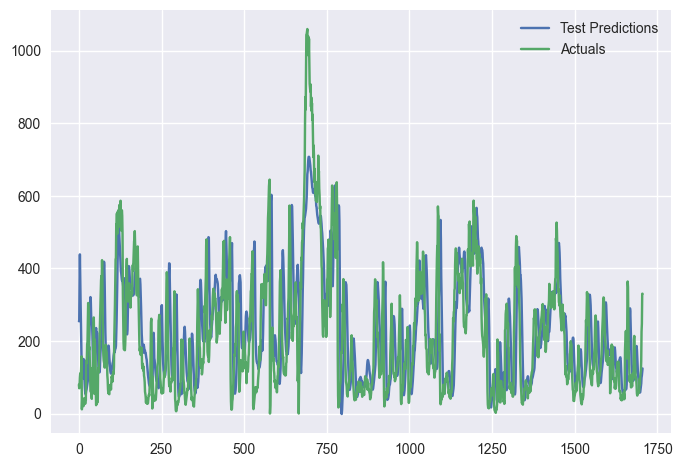

In [42]:
model = load_model('6H_Forecast/6H_ForecastModel_12_SizeWindow/')

X, y = DataHandler(6,12)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25,shuffle=False) 

test_predictions = model.predict(X_test).flatten()
inversedTestPredictions = normalization_helper.inverse_scale_1d(test_predictions,scaler, 'Rn', D001_df)

inversed_y_test = normalization_helper.inverse_scale_1d(y_test,scaler, 'Rn', D001_df)

test_results = pd.DataFrame(data={'Test Predictions':inversedTestPredictions.flatten(), 'Actuals':inversed_y_test.flatten()})
pd.concat([test_results['Test Predictions'],test_results['Actuals']],axis=1).plot()

test_results.head(30)